## Multinomial Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

import wandb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score

In [2]:
data_df = pd.read_csv("WineQT.csv")

In [3]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9.8        5   2  
3      9.8        6   3  
4      9.4        5   4

In [4]:
df = data_df.drop("Id", axis=1)

description = df.describe().loc[['mean', 'std', 'min', 'max']]
description = description.T

In [5]:
description

mean        std      min        max
fixed acidity          8.311111   1.747595  4.60000   15.90000
volatile acidity       0.531339   0.179633  0.12000    1.58000
citric acid            0.268364   0.196686  0.00000    1.00000
residual sugar         2.532152   1.355917  0.90000   15.50000
chlorides              0.086933   0.047267  0.01200    0.61100
free sulfur dioxide   15.615486  10.250486  1.00000   68.00000
total sulfur dioxide  45.914698  32.782130  6.00000  289.00000
density                0.996730   0.001925  0.99007    1.00369
pH                     3.311015   0.156664  2.74000    4.01000
sulphates              0.657708   0.170399  0.33000    2.00000
alcohol               10.442111   1.082196  8.40000   14.90000
quality                5.657043   0.805824  3.00000    8.00000

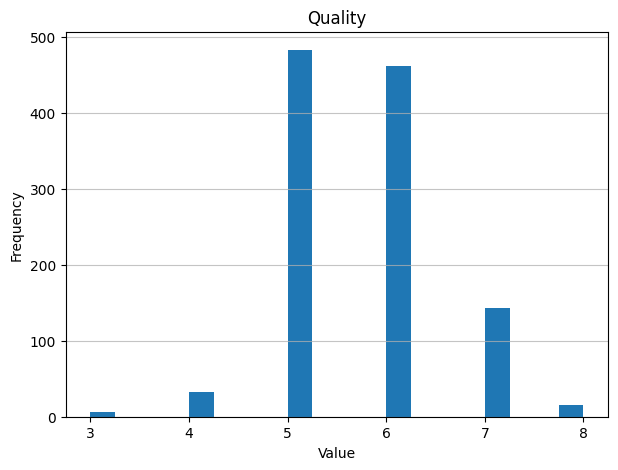

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(data_df["quality"], bins=20)
ax.set_title("Quality")
ax.grid(axis='y', alpha=0.75)
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

plt.show()

In [7]:
null_values = data_df.isnull().sum()
print(null_values)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64


In [8]:
X = data_df.drop(columns=["quality", "Id"], axis=1)
y = data_df["quality"].values.reshape(-1, 1) 

categories = [np.arange(3, 9)]
encoder = OneHotEncoder(sparse=False, categories=categories)
y_encoded = encoder.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
scaler = StandardScaler()
normalizer = MinMaxScaler()

In [10]:
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

X_train_normalized = normalizer.fit_transform(X_train_standardized)
X_val_normalized = normalizer.transform(X_val_standardized)
X_test_normalized = normalizer.transform(X_test_standardized)

In [11]:
def add_bias_column(X):
    ones = np.ones((X.shape[0], 1))
    return np.hstack((ones, X))

X_train_normalized = add_bias_column(X_train_normalized)
X_val_normalized = add_bias_column(X_val_normalized)
X_test_normalized = add_bias_column(X_test_normalized)

In [12]:
class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.1, num_epochs=1000, log_flag=0):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.log_flag = log_flag

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-10
        num_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / num_samples
        return loss

    def gradient_descent(self, X, y, y_pred):
        num_samples = X.shape[0]
        grad = np.dot(X.T, (y_pred - y)) / num_samples
        return grad

    def plot(self, train_losses, val_losses, train_accuracies, val_accuracies):
        epochs = range(1, self.num_epochs + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train')
        plt.plot(epochs, val_losses, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train')
        plt.plot(epochs, val_accuracies, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
    def train(self, X, y, X_val, y_val):
        num_samples, num_features = X.shape
        num_classes = y.shape[1]
        self.weights = np.zeros((num_features, num_classes))
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        for epoch in range(self.num_epochs):
            indices = np.random.permutation(num_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(num_samples):
                xi = X_shuffled[i:i+1]
                yi = y_shuffled[i:i+1]
                z = np.dot(xi, self.weights)
                y_pred = self.softmax(z)
                gradient = self.gradient_descent(xi, yi, y_pred)
                self.weights -= self.learning_rate * gradient

            y_train_pred = self.predict(X)
            y_train_pred_labels = np.argmax(y_train_pred, axis=1)
            train_loss = self.cross_entropy_loss(y, y_train_pred)
            train_losses.append(train_loss)
            train_accuracy = accuracy_score(np.argmax(y, axis=1), y_train_pred_labels)
            train_accuracies.append(train_accuracy)

            y_val_pred = self.predict(X_val)
            y_val_pred_labels = np.argmax(y_val_pred, axis=1)
            val_loss = self.cross_entropy_loss(y_val, y_val_pred)
            val_losses.append(val_loss)
            val_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred_labels)
            val_accuracies.append(val_accuracy)

            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch + 1}/{self.num_epochs}")
                print(f"Train Loss: {train_loss:.4f}")
                print(f"Train Accuracy: {train_accuracy:.2f}%")
                print(f"Validation Loss: {val_loss:.4f}")
                print(f"Validation Accuracy: {val_accuracy:.2f}%\n")
                classification_rep = classification_report(np.argmax(y_val, axis=1), y_val_pred_labels, zero_division=0)
                print("Validation Classification Report:\n", classification_rep)
            
            if self.log_flag == 1:
                wandb.log({
                    "learning_rate": self.learning_rate,
                    "num_epochs": epoch,
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy
                })
                
        self.train_losses = train_losses
        self.val_losses = val_losses
        self.train_accuracies = train_accuracies
        self.val_accuracies = val_accuracies
        self.plot(train_losses, val_losses, train_accuracies, val_accuracies)

    def predict(self, X):
        z = np.dot(X, self.weights)
        return self.softmax(z)

In [13]:
wandb.login()

wandb: Currently logged in as: ashnadua (ashna-dua). Use `wandb login --relogin` to force relogin


True

In [14]:
learning_rate = [0.001, 0.01, 0.025, 0.05, 0.1]
num_epochs = [100, 500, 1000, 2000, 3000]

In [15]:
### Wandb logs done in different files for each question, submitted in folder called (wandb_submission)

In [ ]:
for lr in learning_rate:
    for epochs in num_epochs:
        wandb.init(project="MLR", config={"learning_rate": lr, "num_epochs": epochs})
        model = MultinomialLogisticRegression(learning_rate=lr, num_epochs=epochs, log_flag=1)

        # Train the model
        model.train(X_train_normalized, y_train, X_val_normalized, y_val)
        
        wandb.finish()

## Best Hyperparameters found using W&B results

According to the plots, the highest test accuracy is achieved with 0.025 Learning rate and 99 epochs for Multinomial Logistic Regression. Using these hyper-parameters, the metrics can be observed below:

Epoch 50/99
Train Loss: 0.9320
Train Accuracy: 0.60%
Validation Loss: 0.9787
Validation Accuracy: 0.58%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        10
           2       0.59      0.85      0.70       153
           3       0.57      0.47      0.51       149
           4       0.58      0.30      0.40        46
           5       0.00      0.00      0.00         5

    accuracy                           0.58       366
   macro avg       0.29      0.27      0.27       366
weighted avg       0.55      0.58      0.55       366



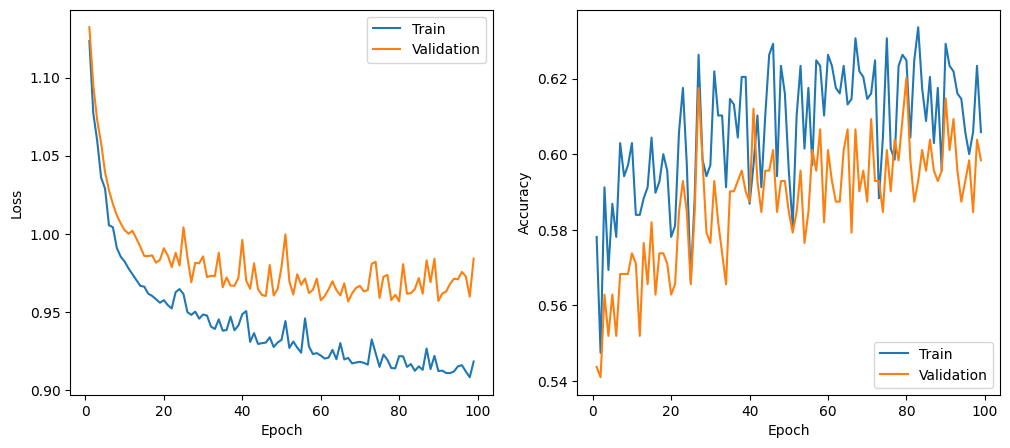

In [16]:
model = MultinomialLogisticRegression(learning_rate=0.025, num_epochs=99, log_flag = 0)
model.train(X_train_normalized, y_train, X_val_normalized, y_val)

In [17]:
y_test_pred = model.predict(X_test_normalized)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
classification_rep = classification_report(np.argmax(y_test, axis=1), y_test_pred_labels, zero_division=0)  # Set zero_division to 0
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_labels)
print("Test Classification Report:\n", classification_rep)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.57      0.68      0.62        37
           3       0.58      0.61      0.60        41
           4       0.60      0.33      0.43         9
           5       0.00      0.00      0.00         1

    accuracy                           0.58        92
   macro avg       0.35      0.32      0.33        92
weighted avg       0.55      0.58      0.56        92

Test Accuracy: 0.58%


## Multilayer Perceptron Classification

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

import wandb
from sklearn.preprocessing import OneHotEncoder

In [315]:
data_df = pd.read_csv("WineQT.csv")

In [316]:
X = data_df.drop(columns=["quality", "Id"], axis=1)
y = data_df["quality"].values.reshape(-1, 1)  # Convert to a NumPy array and reshape

# Define the categories that you want to one-hot encode (from 3 to 8)
categories = [np.arange(3, 9)]

# Initialize the OneHotEncoder with specified categories
encoder = OneHotEncoder(sparse=False, categories=categories)

# Use fit_transform with the reshaped y
y_encoded = encoder.fit_transform(y)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [317]:
scaler = StandardScaler()
normalizer = MinMaxScaler()

In [318]:
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

X_train_normalized = normalizer.fit_transform(X_train_standardized)
X_val_normalized = normalizer.transform(X_val_standardized)
X_test_normalized = normalizer.transform(X_test_standardized)

In [319]:
class MLP:
    def __init__(self, input_dim, hidden_layers, output_dim, learning_rate=0.01, activation="relu", log_flag=0):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.activation = activation
        self.weights = []
        self.biases = []
        self.log_flag = log_flag
        self.__initialize_weights_and_biases()

    def __initialize_weights_and_biases(self):
        layers = [self.input_dim] + self.hidden_layers + [self.output_dim]
        for i in range(len(layers) - 1):
            # Use Xavier initialization for weights
            weight_scale = np.sqrt(2 / (layers[i] + layers[i + 1]))
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * weight_scale)
            # Initialize biases to zeros
            self.biases.append(np.zeros(layers[i + 1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x <= 0, 0, 1)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def forward_propagation(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            if self.activation == "relu":
                a = self.relu(z)
            elif self.activation == "sigmoid":
                a = self.sigmoid(z)
            elif self.activation == "tanh":
                 a = self.tanh(z)   
            self.z.append(z)
            self.a.append(a)
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        a = self.softmax(z)
        self.z.append(z)
        self.a.append(a)
        return a

    def back_propagation(self, X, y):
        m = X.shape[0]
        dz = [self.a[-1] - y]
        for i in range(len(self.hidden_layers), -1, -1):
            dw = 1/m * np.dot(self.a[i].T, dz[-1])
            db = 1/m * np.sum(dz[-1], axis=0)
            if i != 0:
                derivative = None
                if self.activation == "relu":
                    derivative = self.relu_derivative(self.a[i])
                elif self.activation == "sigmoid":
                    derivative = self.sigmoid_derivative(self.a[i])
                elif self.activation == "tanh":
                    derivative = self.tanh_derivative(self.a[i])   
                dz.append(np.dot(dz[-1], self.weights[i].T) * derivative)
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-10
        num_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / num_samples
        return loss

    def train_mini_batch(self, X, y, X_val, y_val, epochs=1000, batch_size=32):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        indices = np.arange(X.shape[0])
        for epoch in range(epochs):
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                self.forward_propagation(X_batch)
                self.back_propagation(X_batch, y_batch)
            y_train_pred = self.predict(X)
            train_loss = self.cross_entropy_loss(y, y_train_pred)
            train_accuracy = self.calculate_accuracy(y, y_train_pred)
        
            y_val_pred = self.predict(X_val)
            val_loss = self.cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)
            
            
            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {train_loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')
                
            if self.log_flag == 1:
                wandb.log({
                    "train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })
                
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
        self.plot(train_losses, val_losses, train_accuracies, val_accuracies)

    def train_batch(self, X, y, X_val, y_val, epochs=1000):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
    
        for epoch in range(epochs):
            y_train_pred = self.forward_propagation(X)
        
            train_loss = self.cross_entropy_loss(y, y_train_pred)
            train_accuracy = self.calculate_accuracy(y, y_train_pred)
        
            self.back_propagation(X, y)
        
            y_val_pred = self.predict(X_val)
            val_loss = self.cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {train_loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')
                
            if self.log_flag == 1:
                wandb.log({
                    "train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })
        
        self.plot(train_losses, val_losses, train_accuracies, val_accuracies)

        
    def train_sgd(self, X, y, X_val, y_val, epochs=1000):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        indices = np.arange(X.shape[0])
        for epoch in range(epochs):
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(X.shape[0]):
                X_i = np.expand_dims(X[i], axis=0)
                y_i = np.expand_dims(y[i], axis=0)
                self.forward_propagation(X_i)
                self.back_propagation(X_i, y_i)
                
            y_train_pred = self.predict(X)
            train_loss = self.cross_entropy_loss(y, y_train_pred)
            train_accuracy = self.calculate_accuracy(y, y_train_pred)
        
            y_val_pred = self.predict(X_val)
            val_loss = self.cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)
            
            
            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {train_loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')
                
            if self.log_flag == 1:
                wandb.log({
                    "train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })
                
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
        self.plot(train_losses, val_losses, train_accuracies, val_accuracies)
        
    def calculate_accuracy(self, y_true, y_pred):
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
    
        accuracy = accuracy_score(y_true_labels, y_pred_labels)
        return accuracy
        
    def plot(self, train_losses, val_losses, train_accuracies, val_accuracies):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss over time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    
        plt.tight_layout()
        plt.show()

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return y_pred

In [320]:
wandb.login()

True

In [27]:
learning_rates = [0.001, 0.01, 0.025]
num_epochs = [100, 500, 1000]
activations = ['sigmoid', 'tanh', 'relu']
hidden_layers = [[4], [5], [4, 4]]

optimizers = {
    'train_sgd': MLP.train_sgd,
    'train_gd': MLP.train_batch,
    'train_mini_batch': MLP.train_mini_batch
}


In [28]:
best_model = None
best_accuracy = 0.0
best_hyperparameters = {}

In [29]:
### Wandb logs done in different files for each question, submitted in folder called (wandb_submission)

In [ ]:
for lr in learning_rates:
    for epochs in num_epochs:
        for activation in activations:
            for layers in hidden_layers:
                for optimizer_name, optimizer_function in optimizers.items():
                    wandb.init(project="MLPClassification")

                    model = MLP(X_train_normalized.shape[1], layers, y_train.shape[1], learning_rate=lr, activation=activation, log_flag=1)
                    optimizer_function(model, X_train_normalized, y_train, X_val_normalized, y_val, epochs=epochs)

                    y_pred = model.predict(X_val_normalized)
                    y_labels_pred = np.argmax(y_pred, axis=1)
                    y_val_labels = np.argmax(y_val, axis=1)
                    accuracy = accuracy_score(y_val_labels, y_labels_pred)
                    wandb.log({"validation_accuracy": accuracy})
                    
                    y_pred = model.predict(X_val_normalized)
                    y_labels_pred = np.argmax(y_pred, axis=1)
                    y_val_labels = np.argmax(y_val, axis=1)
                    accuracy = accuracy_score(y_val_labels, y_labels_pred)
                    wandb.log({"validation_accuracy": accuracy})

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model = model
                        best_hyperparameters = {
                            "learning_rate": lr,
                            "num_epochs": epochs,
                            "activation": activation,
                            "hidden_layers": layers,
                            "optimizer": optimizer_name
                        }

                    # Finish the run
                    wandb.finish()

Epoch 0:
Train Loss 1.1591687237259998
Train Acc 0.5313868613138686
Val Loss 1.1654849750515144
Val Acc 0.5136612021857924

Epoch 50:
Train Loss 0.9012388884840558
Train Acc 0.6262773722627737
Val Loss 0.9542216452100161
Val Acc 0.592896174863388

Epoch 100:
Train Loss 0.8986290191774814
Train Acc 0.6175182481751825
Val Loss 0.9672840366002119
Val Acc 0.587431693989071

Epoch 150:
Train Loss 0.8840177498677391
Train Acc 0.6160583941605839
Val Loss 0.9632970742561657
Val Acc 0.6065573770491803

Epoch 200:
Train Loss 0.8760208008746383
Train Acc 0.6277372262773723
Val Loss 0.9570553870306804
Val Acc 0.6120218579234973

Epoch 250:
Train Loss 0.8880199141592792
Train Acc 0.6248175182481752
Val Loss 0.9691051718989646
Val Acc 0.5901639344262295

Epoch 300:
Train Loss 0.9021327378475623
Train Acc 0.6072992700729927
Val Loss 1.018277808822534
Val Acc 0.5846994535519126

Epoch 350:
Train Loss 0.8753214530901637
Train Acc 0.637956204379562
Val Loss 0.9752834439629716
Val Acc 0.6010928961748634


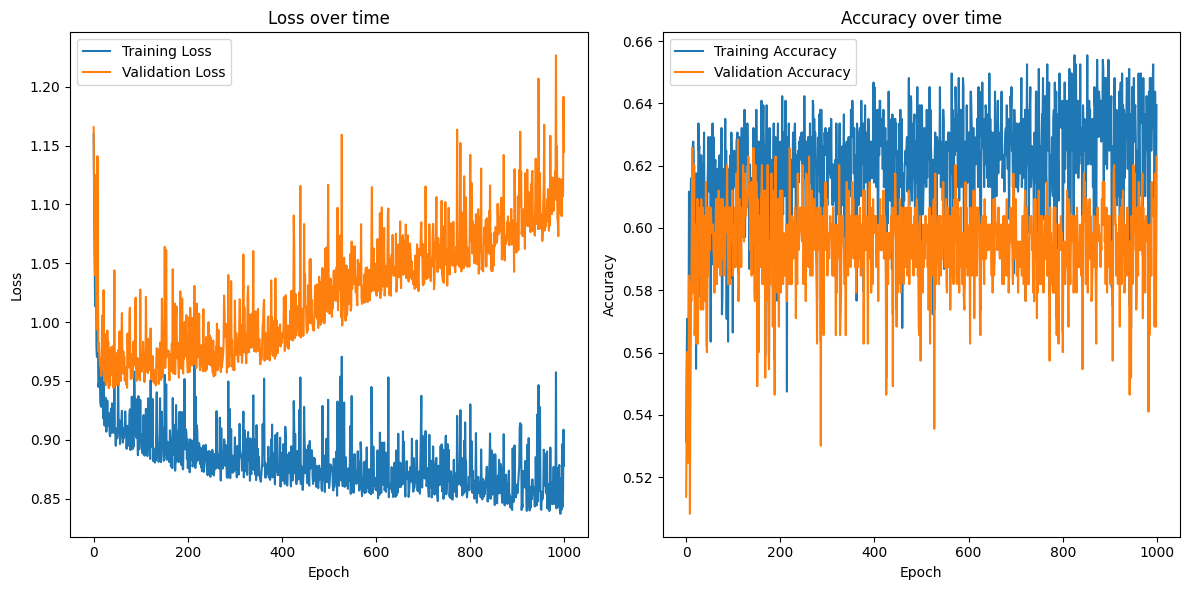

In [321]:
mlp = MLP(input_dim=11, hidden_layers=[5], output_dim=6, learning_rate=0.025, activation="relu")
mlp.train_sgd(X_train_normalized, y_train, X_val_normalized, y_val, epochs=1000)

In [322]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [323]:
y_pred = mlp.predict(X_val_normalized)
y_true_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [324]:
print("Validation Scores: ")
print("Accuracy: ", accuracy)
print("F1: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)

Validation Scores: 
Accuracy:  0.6229508196721312
F1:  0.5986656000312052
Precision:  0.5874230839876935
Recall:  0.6229508196721312


In [328]:
y_pred = mlp.predict(X_test_normalized)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [329]:
print("Test Scores: ")
print("Accuracy: ", accuracy)
print("F1: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)

Test Scores: 
Accuracy:  0.5760869565217391
F1:  0.5627519886673206
Precision:  0.5500700007777864
Recall:  0.5760869565217391


## Multi Label Classification

In [203]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [204]:
data_df = pd.read_csv('advertisement.csv')

In [205]:
data_df.head()

age  gender        income    education  married  children           city  \
0   45    Male  61271.953359       Master    False         3    Lake Sheila   
1   24  Female  53229.101074  High School    False         1   Crystalburgh   
2   45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3   19    Male  48950.246384          PhD    False         0  Williamshaven   
4   29  Female  44792.627094       Master    False         0       New Paul   

    occupation  purchase_amount most bought item  \
0       Doctor        87.697118          monitor   
1  Businessman       115.135586         lipstick   
2     Engineer       101.694559         biscuits   
3       Lawyer        97.964887            maggi   
4  Businessman        86.847281           carpet   

                             labels  
0       electronics clothing sports  
1                  furniture beauty  
2  clothing electronics food sports  
3                              food  
4                              home

In [206]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   int64  
 1   gender            1000 non-null   object 
 2   income            1000 non-null   float64
 3   education         1000 non-null   object 
 4   married           1000 non-null   bool   
 5   children          1000 non-null   int64  
 6   city              1000 non-null   object 
 7   occupation        1000 non-null   object 
 8   purchase_amount   1000 non-null   float64
 9   most bought item  1000 non-null   object 
 10  labels            1000 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 79.2+ KB


In [207]:
categorical_columns = ["education", "city", "occupation", "most bought item"]
data_df_preprocess = pd.get_dummies(data_df, columns=categorical_columns)

In [208]:
data_df_preprocess["gender"] = data_df["gender"].apply(lambda x: 1 if x == "Male" else 0)
data_df_preprocess["married"] = data_df["married"].astype(int)

In [209]:
x = data_df_preprocess.drop(columns=["labels"]).values
y = mlb.fit_transform(data_df_preprocess["labels"].str.split())

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [210]:
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

X_train_normalized = normalizer.fit_transform(X_train_standardized)
X_val_normalized = normalizer.transform(X_val_standardized)
X_test_normalized = normalizer.transform(X_test_standardized)

In [334]:
class MLPMultiLabel:
    def __init__(self, input_dim, hidden_layers, output_dim, learning_rate=0.01, activation="relu", log_flag=0):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.activation = activation
        self.weights = []
        self.biases = []
        self.log_flag = log_flag
        self.__initialize_weights_and_biases()

    def __initialize_weights_and_biases(self):
        layers = [self.input_dim] + self.hidden_layers + [self.output_dim]
        for i in range(len(layers) - 1):
            # Use Xavier initialization for weights
            weight_scale = np.sqrt(2 / (layers[i] + layers[i + 1]))
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * weight_scale)
            # Initialize biases to zeros
            self.biases.append(np.zeros(layers[i + 1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x <= 0, 0, 1)

    def calculate_accuracy(self, y_true, y_pred):
        # Convert probabilities to binary outputs
        y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    
        # Calculate Hamming error using sklearn's function
        hamming_error = hamming_loss(y_true, y_pred_binary)
    
        # Calculate accuracy as 1 - Hamming error
        accuracy = 1 - hamming_error
    
        return accuracy

    def forward_propagation(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            if self.activation == "relu":
                a = self.relu(z)
            elif self.activation == "sigmoid":
                a = self.sigmoid(z)
            elif self.activation == "tanh":
                a = self.tanh(z)
            self.z.append(z)
            self.a.append(a)
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        a = self.sigmoid(z)  # Use sigmoid for multi-label classification
        self.z.append(z)
        self.a.append(a)
        return a

    def back_propagation(self, X, y):
        m = X.shape[0]
        dz = [self.a[-1] - y]
        for i in range(len(self.hidden_layers), -1, -1):
            dw = 1/m * np.dot(self.a[i].T, dz[-1])
            db = 1/m * np.sum(dz[-1], axis=0)
            if i != 0:
                derivative = None
                if self.activation == "relu":
                    derivative = self.relu_derivative(self.a[i])
                elif self.activation == "sigmoid":
                    derivative = self.sigmoid_derivative(self.a[i])
                elif self.activation == "tanh":
                    derivative = self.tanh_derivative(self.a[i])
                dz.append(np.dot(dz[-1], self.weights[i].T) * derivative)
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

    def binary_cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-10
        num_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / num_samples
        return loss
    
    def train_mini_batch(self, X, y, X_val, y_val, epochs=1000, batch_size=32):
        train_losses = []
        val_losses = []
        accuracies = []
        val_accuracies = []
        indices = np.arange(X.shape[0])
        for epoch in range(epochs):
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                self.forward_propagation(X_batch)
                self.back_propagation(X_batch, y_batch)
            y_pred = self.forward_propagation(X)
            loss = self.binary_cross_entropy_loss(y, y_pred)
            train_accuracy = self.calculate_accuracy(y, y_pred)

            # Validation loss and accuracy
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.binary_cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)

            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')

            if self.log_flag == 1:
                wandb.log({
                    "train_loss": loss,
                    "accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })

            train_losses.append(loss)
            val_losses.append(val_loss)
            accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        self.plot(train_losses, val_losses, accuracies, val_accuracies)
        
    def train_batch(self, X, y, X_val, y_val, epochs=1000):
        losses = []
        val_losses = []
        accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X)
            loss = self.binary_cross_entropy_loss(y, y_pred)
            train_accuracy = self.calculate_accuracy(y, y_pred)

            # Validation loss and accuracy
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.binary_cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)

            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')

            if self.log_flag == 1:
                wandb.log({
                    "train_loss": loss,
                    "accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })

            losses.append(loss)
            val_losses.append(val_loss)
            accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            self.back_propagation(X, y)

        self.plot(losses, val_losses, accuracies, val_accuracies)

    def train_sgd(self, X, y, X_val, y_val, epochs=1000):
        losses = []
        val_losses = []
        accuracies = []
        val_accuracies = []
        indices = np.arange(X.shape[0])
        for epoch in range(epochs):
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for i in range(X.shape[0]):
                X_i = np.expand_dims(X[i], axis=0)
                y_i = np.expand_dims(y[i], axis=0)
                self.forward_propagation(X_i)
                self.back_propagation(X_i, y_i)

            y_pred = self.forward_propagation(X)
            loss = self.binary_cross_entropy_loss(y, y_pred)
            train_accuracy = self.calculate_accuracy(y, y_pred)

            # Validation loss and accuracy
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.binary_cross_entropy_loss(y_val, y_val_pred)
            val_accuracy = self.calculate_accuracy(y_val, y_val_pred)

            if epoch % 50 == 0:
                print(f'Epoch {epoch}:\nTrain Loss {loss}\nTrain Acc {train_accuracy}\nVal Loss {val_loss}\nVal Acc {val_accuracy}\n')

            if self.log_flag == 1:
                wandb.log({
                    "train_loss": loss,
                    "accuracy": train_accuracy,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy
                })

            losses.append(loss)
            val_losses.append(val_loss)
            accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        self.plot(losses, val_losses, accuracies, val_accuracies)
    
    def plot(self, losses, val_losses, accuracies, val_accuracies):
        plt.figure(figsize=(10, 4))
    
        plt.subplot(1, 2, 1)
        plt.plot(losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Loss over time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Val Accuracy')
        plt.title('Accuracy over time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return y_pred

In [39]:
learning_rates_multi = [0.001, 0.01, 0.025, 0.05, 0.1]
num_epochs_multi = [100, 500, 1000, 5000, 10000]
activations_multi = ['sigmoid', 'tanh', 'relu']
hidden_layers_multi = [[5], [10], [10, 10], [50, 100], [100, 100]]

optimizers_multi = {
    'train_sgd': MLPMultiLabel.train_sgd,
    'train_gd': MLPMultiLabel.train_batch,
    'train_mini_batch': MLPMultiLabel.train_mini_batch
}

In [40]:
best_model_multi = None
best_accuracy_multi = 0.0
best_hyperparameters_multi = {}

In [ ]:
for lr in learning_rates_multi:
    for epochs in num_epochs_multi:
        for activation in activations_multi:
            for layers in hidden_layers_multi:
                for optimizer_name, optimizer_function in optimizers_multi.items():
                    wandb.init(project="Multilayer Perceptron Classification with Multiple Classes")

                    model = MLPMultiLabel(X_train_normalized.shape[1], layers, y_train.shape[1], learning_rate=lr, activation=activation, log_flag=1)
                    optimizer_function(model, X_train_normalized, y_train, epochs=epochs)

                    y_pred = model.predict(X_val_normalized)
                    y_labels_pred = np.argmax(y_pred, axis=1)
                    y_val_labels = np.argmax(y_val, axis=1)
                    accuracy = accuracy_score(y_val_labels, y_labels_pred)
                    wandb.log({"validation_accuracy": accuracy})

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model = model
                        best_hyperparameters = {
                            "learning_rate": lr,
                            "num_epochs": epochs,
                            "activation": activation,
                            "hidden_layers": layers,
                            "optimizer": optimizer_name
                        }

                    # Finish the run
                    wandb.finish()

In [335]:
model = MLPMultiLabel(X_train_normalized.shape[1], [10], y_train.shape[1], learning_rate=0.001, activation="relu")

Epoch 0:
Train Loss 4.133497498571749
Train Acc 0.583941605839416
Val Loss 4.135703471858451
Val Acc 0.5710382513661203

Epoch 50:
Train Loss 3.0295836045871396
Train Acc 0.845985401459854
Val Loss 3.035079859199873
Val Acc 0.8387978142076502

Epoch 100:
Train Loss 2.2763932624713274
Train Acc 0.8369829683698297
Val Loss 2.2847271913761293
Val Acc 0.8387978142076502

Epoch 150:
Train Loss 2.038364552147646
Train Acc 0.8350364963503649
Val Loss 2.04841165668395
Val Acc 0.836976320582878

Epoch 200:
Train Loss 1.9697011256259869
Train Acc 0.8377128953771289
Val Loss 1.9812995308865267
Val Acc 0.8397085610200364

Epoch 250:
Train Loss 1.9408824602526333
Train Acc 0.8394160583941606
Val Loss 1.953842758692383
Val Acc 0.8410746812386156

Epoch 300:
Train Loss 1.9239583999696828
Train Acc 0.8420924574209245
Val Loss 1.9380721299846717
Val Acc 0.842896174863388

Epoch 350:
Train Loss 1.911416770857335
Train Acc 0.8450121654501217
Val Loss 1.92656730758311
Val Acc 0.8451730418943534

Epoch 400

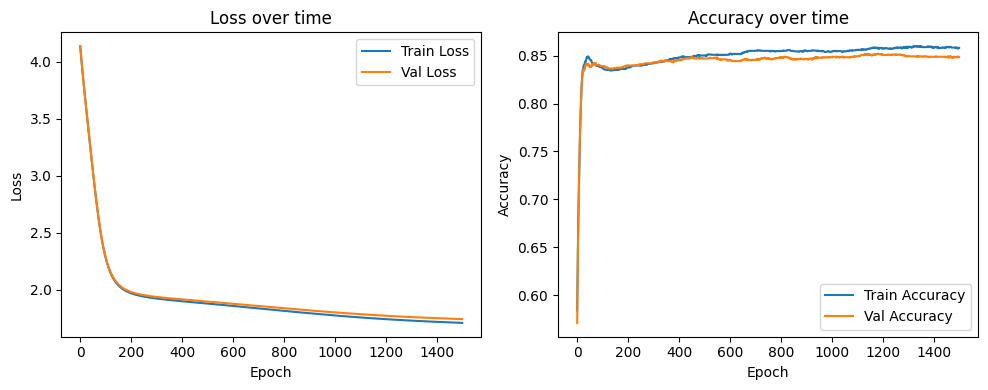

In [338]:
model.train_mini_batch(X_train_normalized, y_train, X_val_normalized, y_val, epochs=1500)

In [337]:
from sklearn.metrics import hamming_loss

In [341]:
y_pred = model.predict(X_val_normalized)

In [347]:
y_pred = model.predict(X_val_normalized)
y_labels_pred = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [348]:
print("Validation Scores: ")
print("Accuracy: ", accuracy)
print("F1: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)

Validation Scores: 
Accuracy:  0.5760869565217391
F1:  0.5627519886673206
Precision:  0.5500700007777864
Recall:  0.5760869565217391


In [344]:
y_pred = model.predict(X_test_normalized)
y_labels_pred = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

accuracy = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [345]:
print("Test Scores: ")
print("Accuracy: ", accuracy)
print("F1: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)

Test Scores: 
Accuracy:  0.5760869565217391
F1:  0.5627519886673206
Precision:  0.5500700007777864
Recall:  0.5760869565217391


## Multilayer Perceptron Regression

In [216]:
data_df = pd.read_csv("HousingData.csv")

In [217]:
data_df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2

In [218]:
description = data_df.describe().loc[['mean', 'std', 'min', 'max']]
description = description.T

In [219]:
description

mean         std        min       max
CRIM       3.611874    8.720192    0.00632   88.9762
ZN        11.211934   23.388876    0.00000  100.0000
INDUS     11.083992    6.835896    0.46000   27.7400
CHAS       0.069959    0.255340    0.00000    1.0000
NOX        0.554695    0.115878    0.38500    0.8710
RM         6.284634    0.702617    3.56100    8.7800
AGE       68.518519   27.999513    2.90000  100.0000
DIS        3.795043    2.105710    1.12960   12.1265
RAD        9.549407    8.707259    1.00000   24.0000
TAX      408.237154  168.537116  187.00000  711.0000
PTRATIO   18.455534    2.164946   12.60000   22.0000
B        356.674032   91.294864    0.32000  396.9000
LSTAT     12.715432    7.155871    1.73000   37.9700
MEDV      22.532806    9.197104    5.00000   50.0000

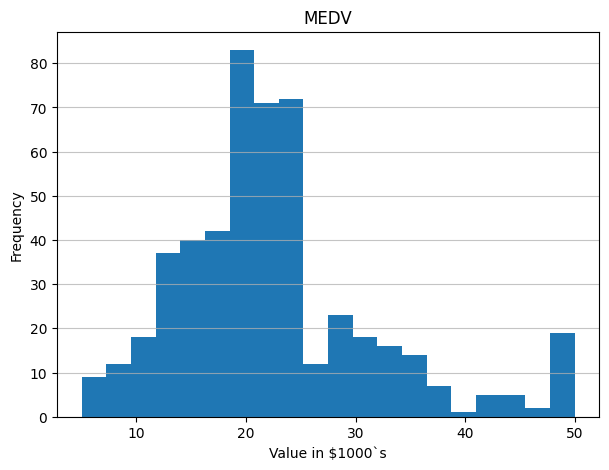

In [220]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(data_df["MEDV"], bins=20)
ax.set_title("MEDV")
ax.grid(axis='y', alpha=0.75)
ax.set_xlabel('Value in $1000`s')
ax.set_ylabel('Frequency')

plt.show()

In [221]:
null_values = data_df.isnull().sum()
print(null_values)

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


In [222]:
# Create an imputer object
imputer = SimpleImputer(strategy='mean')

data_df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT']] = imputer.fit_transform(data_df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT']])

In [223]:
data_df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B      LSTAT  MEDV  
0  396.90   4.980000  24.0  
1  396.90   9.140000  21.6  
2  392.83   4.030000  34.7  
3  394.63   2.940000  33.4  
4  396.90  12.715432  36.2

In [224]:
null_values = data_df.isnull().sum()
print(null_values)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


In [225]:
description = data_df.describe().loc[['mean', 'std', 'min', 'max']]
description = description.T

In [226]:
description

mean         std        min       max
CRIM       3.611874    8.545770    0.00632   88.9762
ZN        11.211934   22.921051    0.00000  100.0000
INDUS     11.083992    6.699165    0.46000   27.7400
CHAS       0.069959    0.250233    0.00000    1.0000
NOX        0.554695    0.115878    0.38500    0.8710
RM         6.284634    0.702617    3.56100    8.7800
AGE       68.518519   27.439466    2.90000  100.0000
DIS        3.795043    2.105710    1.12960   12.1265
RAD        9.549407    8.707259    1.00000   24.0000
TAX      408.237154  168.537116  187.00000  711.0000
PTRATIO   18.455534    2.164946   12.60000   22.0000
B        356.674032   91.294864    0.32000  396.9000
LSTAT     12.715432    7.012739    1.73000   37.9700
MEDV      22.532806    9.197104    5.00000   50.0000

In [227]:
X = data_df.drop(columns=['MEDV'])
y = data_df['MEDV']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [228]:
scaler = StandardScaler()
normalizer = MinMaxScaler()

In [229]:
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

X_train_normalized = normalizer.fit_transform(X_train_standardized)
X_val_normalized = normalizer.transform(X_val_standardized)
X_test_normalized = normalizer.transform(X_test_standardized)

In [291]:
class MLPRegression:
    def __init__(self, input_dim, hidden_layers, output_dim=1, learning_rate=0.01, activation="relu"):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.activation = activation
        self.weights = []
        self.biases = []
        self.__initialize_weights_and_biases()

    def __initialize_weights_and_biases(self):
        layers = [self.input_dim] + self.hidden_layers + [self.output_dim]
        for i in range(len(layers) - 1):
            # Use Xavier initialization for weights
            weight_scale = np.sqrt(2 / (layers[i] + layers[i + 1]))
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * weight_scale)
            # Initialize biases to zeros
            self.biases.append(np.zeros(layers[i + 1]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x <= 0, 0, 1)

    def forward_propagation(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            if self.activation == "relu":
                a = self.relu(z)
            elif self.activation == "sigmoid":
                a = self.sigmoid(z)
            elif self.activation == "tanh":
                 a = self.tanh(z)   
            self.z.append(z)
            self.a.append(a)
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        # No activation function for output layer in regression
        a = z
        self.z.append(z)
        self.a.append(a)
        return a

    def back_propagation(self, X, y):
        m = X.shape[0]
        dz = [self.a[-1] - y]
        for i in range(len(self.hidden_layers), -1, -1):
            dw = np.dot(self.a[i].T, dz[-1])
            db = np.sum(dz[-1], axis=0)
            if i != 0:
                derivative = None
                if self.activation == "relu":
                    derivative = self.relu_derivative(self.a[i])
                elif self.activation == "sigmoid":
                    derivative = self.sigmoid_derivative(self.a[i])
                elif self.activation == "tanh":
                    derivative = self.tanh_derivative(self.a[i])
                dz_next = np.dot(dz[-1], self.weights[i].T)
                dz.append(dz_next * derivative)
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

    def train_sgd(self, X_train, y_train, X_val, y_val, epochs=1000):
        train_losses = []
        val_losses = []
        indices = np.arange(X_train.shape[0])

        for epoch in range(epochs):
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for i in range(X_train.shape[0]):
                X_sample = X_train[i:i+1]
                y_sample = y_train[i:i+1]
                self.forward_propagation(X_sample)
                self.back_propagation(X_sample, y_sample)

            y_train_pred = self.forward_propagation(X_train)
            train_loss = self.mean_squared_error(y_train, y_train_pred)
            train_losses.append(train_loss)

            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.mean_squared_error(y_val, y_val_pred)
            val_losses.append(val_loss)
            
            print(f'Epoch {epoch}: Training Loss {train_loss}, Validation Loss {val_loss}')
            
            wandb.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                })
        
        print("\nTrain Losses")
        self.plot(train_losses)
        print("Validation Losses")
        self.plot(val_losses)
        
    def train_gd(self, X_train, y_train, X_val, y_val, epochs=1000):
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            self.forward_propagation(X_train)
            self.back_propagation(X_train, y_train)

            y_train_pred = self.forward_propagation(X_train)
            train_loss = self.mean_squared_error(y_train, y_train_pred)
            train_losses.append(train_loss)

            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.mean_squared_error(y_val, y_val_pred)
            val_losses.append(val_loss)

            print(f'Epoch {epoch}: Training Loss {train_loss}, Validation Loss {val_loss}')
            
            wandb.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                })
        
        print("\nTrain Losses")
        self.plot(train_losses)
        print("Validation Losses")
        self.plot(val_losses)
        
    def train_mini_batch(self, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32):
        train_losses = []
        val_losses = []
        indices = np.arange(X_train.shape[0])

        for epoch in range(epochs):
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.forward_propagation(X_batch)
                self.back_propagation(X_batch, y_batch)

            y_train_pred = self.forward_propagation(X_train)
            train_loss = self.mean_squared_error(y_train, y_train_pred)
            train_losses.append(train_loss)
            
            y_val_pred = self.forward_propagation(X_val)
            val_loss = self.mean_squared_error(y_val, y_val_pred)
            val_losses.append(val_loss)

            print(f'Epoch {epoch}: Training Loss {train_loss}, Validation Loss {val_loss}')
            
#             wandb.log({
#                     "train_loss": train_loss,
#                     "val_loss": val_loss,
#                 })
    
        print("\nTrain Losses")
        self.plot(train_losses)
        print("Validation Losses")
        self.plot(val_losses)
   
    def mean_squared_error(self, y_true, y_pred):
        num_samples = y_true.shape[0]
        mse_loss = np.sum((y_true - y_pred)**2) / num_samples
        return mse_loss
    
    def plot(self, losses):
        plt.plot(losses)
        plt.title('Loss over time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return y_pred

In [231]:
y = y_train.to_numpy()
y = y_train.to_numpy().reshape(-1, 1)


In [232]:
y_val = y_val.to_numpy().reshape(-1, 1)


In [233]:
num = X_train_normalized.shape[1]
num

13

In [282]:
wandb.init(project="Multilayer Perceptron Regression")

In [283]:
learning_rates_multi = [0.1, 0.01, 0.001]
num_epochs_multi = [100, 500]
activations_multi = ['sigmoid', 'tanh', 'relu']
hidden_layers_multi = [[3], [5]]

optimizers_multi = {
    'train_sgd': MLPRegression.train_sgd,
    'train_gd': MLPRegression.train_gd,
    'train_mini_batch': MLPRegression.train_mini_batch
}

/var/folders/16/36nvykh51lj8191tr2wrzc300000gn/T/ipykernel_57740/668225326.py:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 0: Training Loss 495504.16067736474, Validation Loss 497166.27795334475
Epoch 1: Training Loss 425308855.8855359, Validation Loss 425259488.3570494
Epoch 2: Training Loss 365123323178.1594, Validation Loss 365124768979.25183
Epoch 3: Training Loss 313454721638707.0, Validation Loss 313454679276067.5
Epoch 4: Training Loss 2.69097743979537e+17, Validation Loss 2.6909774522076166e+17
Epoch 5: Training Loss 2.310177222289927e+20, Validation Loss 2.3101772219262484e+20
Epoch 6: Training Loss 1.9832640435636793e+23, Validation Loss 1.983264043574335e+23
Epoch 7: Training Loss 1.7026123487589828e+26, Validation Loss 1.7026123487586708e+26
Epoch 8: Training Loss 1.4616756752860992e+29, Validation Loss 1.4616756752861083e+29
Epoch 9: Training Loss 1.2548339504763633e+32, Validation Loss 1.2548339504763633e+32
Epoch 10: Training Loss 1.0772623981444528e+35, Validation Loss 1.077262398144453e+35
Epoch 11: Training Loss 9.248189961830316e+37, Validation Loss 9.248189961830318e+37
Epoch 12: 

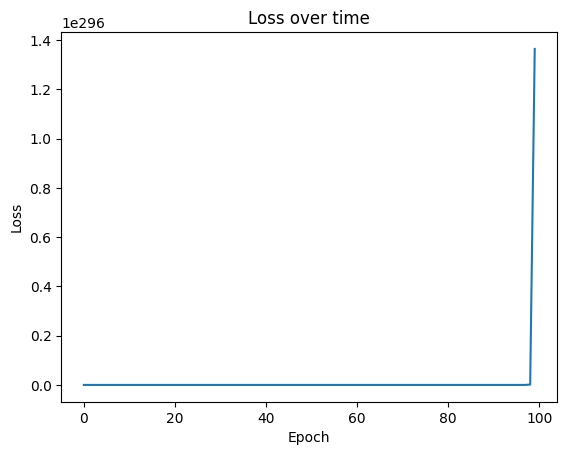

Validation Losses


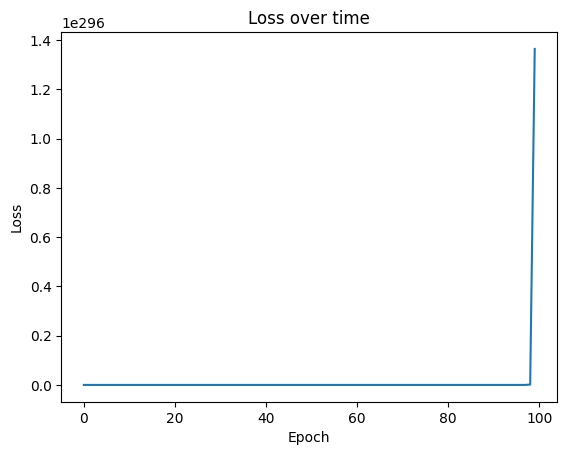

Epoch 0: Training Loss 2.5451808346714576e+268, Validation Loss 2.5451808346714576e+268
Epoch 1: Training Loss 4.749844200194054e+240, Validation Loss 4.749844200194055e+240
Epoch 2: Training Loss 8.864210989954809e+212, Validation Loss 8.864210989954812e+212
Epoch 3: Training Loss 1.6542487113835345e+185, Validation Loss 1.6542487113835342e+185
Epoch 4: Training Loss 3.0871769661340583e+157, Validation Loss 3.0871769661340583e+157
Epoch 5: Training Loss 5.761323285092778e+129, Validation Loss 5.761323285092778e+129
Epoch 6: Training Loss 1.0751844276979805e+102, Validation Loss 1.0751844276979803e+102
Epoch 7: Training Loss 2.0065208917461643e+74, Validation Loss 2.0065208917461648e+74
Epoch 8: Training Loss 3.7445911466872213e+46, Validation Loss 3.744591146687221e+46
Epoch 9: Training Loss 6.988196779180836e+18, Validation Loss 6.988196772855582e+18
Epoch 10: Training Loss 90.55066420368362, Validation Loss 71.27437452074541
Epoch 11: Training Loss 94.78534530923234, Validation Loss

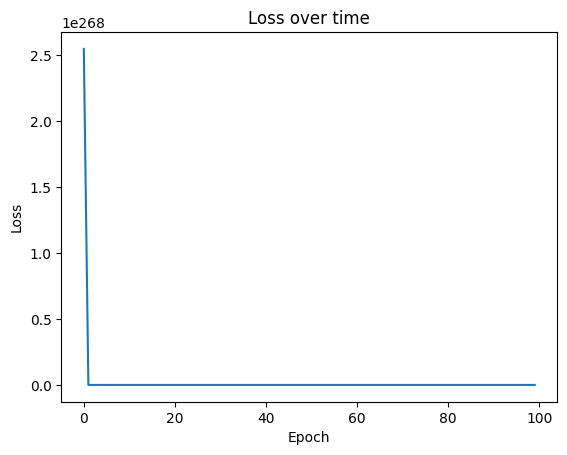

Validation Losses


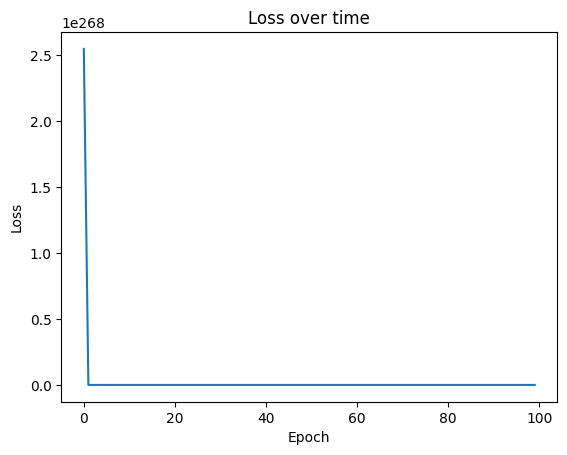

Epoch 0: Training Loss 914203.1921100953, Validation Loss 916468.844107986
Epoch 1: Training Loss 335013851077.1777, Validation Loss 335015235981.7573
Epoch 2: Training Loss 1.2206999861913056e+17, Validation Loss 1.2206999945511813e+17
Epoch 3: Training Loss 4.447922453042169e+22, Validation Loss 4.447922453092633e+22
Epoch 4: Training Loss 1.6207105920001856e+28, Validation Loss 1.620710592000216e+28
Epoch 5: Training Loss 5.905460022884624e+33, Validation Loss 5.905460022884624e+33
Epoch 6: Training Loss 2.1518004666612073e+39, Validation Loss 2.151800466661207e+39
Epoch 7: Training Loss 7.840617378460695e+44, Validation Loss 7.840617378460695e+44
Epoch 8: Training Loss 2.8569229270038442e+50, Validation Loss 2.8569229270038446e+50
Epoch 9: Training Loss 1.040990551746909e+56, Validation Loss 1.040990551746909e+56
Epoch 10: Training Loss 3.793106627355924e+61, Validation Loss 3.793106627355923e+61
Epoch 11: Training Loss 1.3821122451445085e+67, Validation Loss 1.3821122451445085e+67

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/16/36nvykh51lj8191tr2wrzc300000gn/T/ipykernel_57740/668225326.py:180: RuntimeWarning: overflow encountered in square
  mse_loss = np.sum((y_true - y_pred)**2) / num_samples


Epoch 93: Training Loss inf, Validation Loss inf
Epoch 94: Training Loss inf, Validation Loss inf
Epoch 95: Training Loss inf, Validation Loss inf
Epoch 96: Training Loss inf, Validation Loss inf
Epoch 97: Training Loss inf, Validation Loss inf
Epoch 98: Training Loss inf, Validation Loss inf
Epoch 99: Training Loss inf, Validation Loss inf

Train Losses


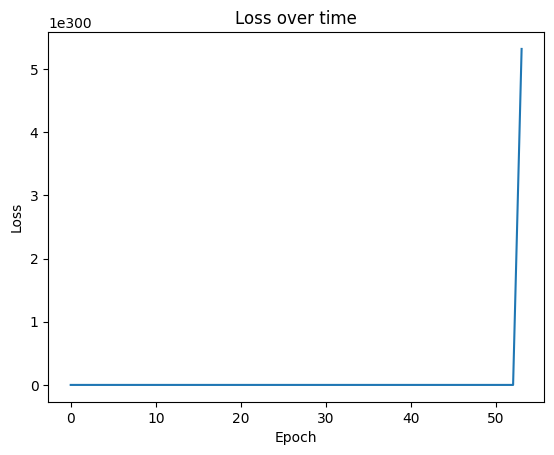

Validation Losses


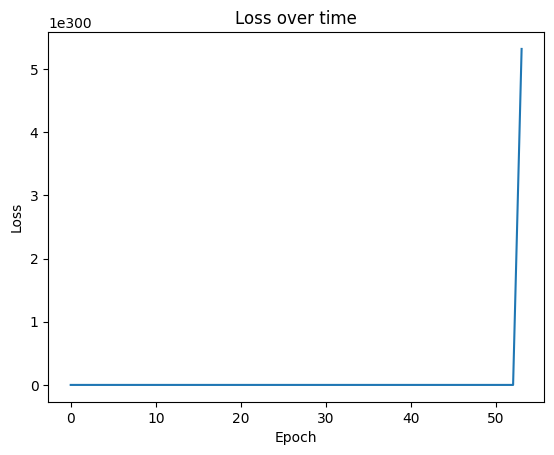

Epoch 0: Training Loss 3260796.8774048337, Validation Loss 3265095.5200636694
Epoch 1: Training Loss 47110834654.724205, Validation Loss 47110315287.90742
Epoch 2: Training Loss 680659222235778.8, Validation Loss 680659284661000.4
Epoch 3: Training Loss 9.834191669230135e+18, Validation Loss 9.834191661726622e+18
Epoch 4: Training Loss 1.4208479460470386e+23, Validation Loss 1.4208479460560579e+23
Epoch 5: Training Loss 2.0528467958405452e+27, Validation Loss 2.0528467958404367e+27
Epoch 6: Training Loss 2.965961262017603e+31, Validation Loss 2.9659612620176033e+31
Epoch 7: Training Loss 4.285232695208062e+35, Validation Loss 4.285232695208063e+35
Epoch 8: Training Loss 6.19132133896736e+39, Validation Loss 6.19132133896736e+39
Epoch 9: Training Loss 8.945245835825384e+43, Validation Loss 8.945245835825384e+43
Epoch 10: Training Loss 1.2924126964583839e+48, Validation Loss 1.2924126964583839e+48
Epoch 11: Training Loss 1.8672830334938705e+52, Validation Loss 1.867283033493871e+52
Epoch

/var/folders/16/36nvykh51lj8191tr2wrzc300000gn/T/ipykernel_57740/668225326.py:74: RuntimeWarning: invalid value encountered in multiply
  dz.append(dz_next * derivative)


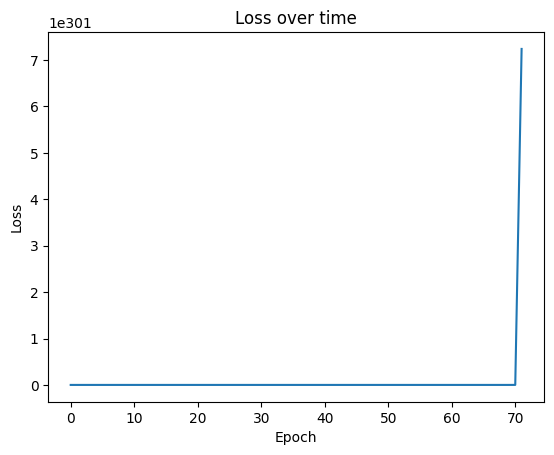

Validation Losses


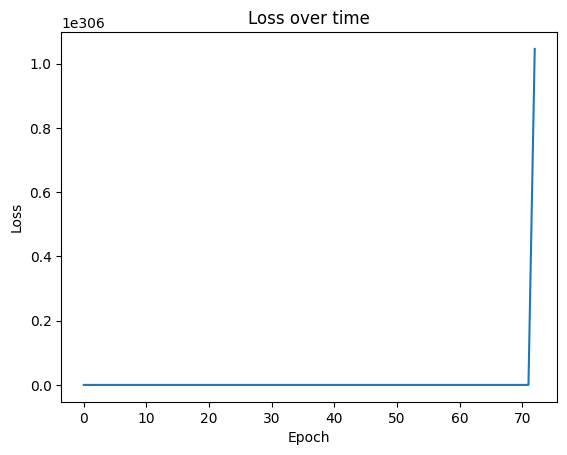

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

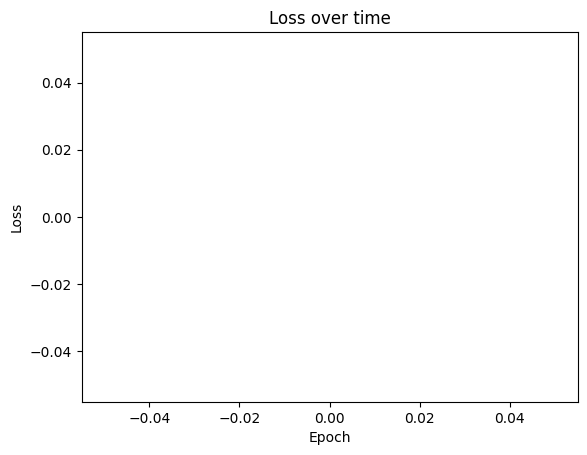

Validation Losses


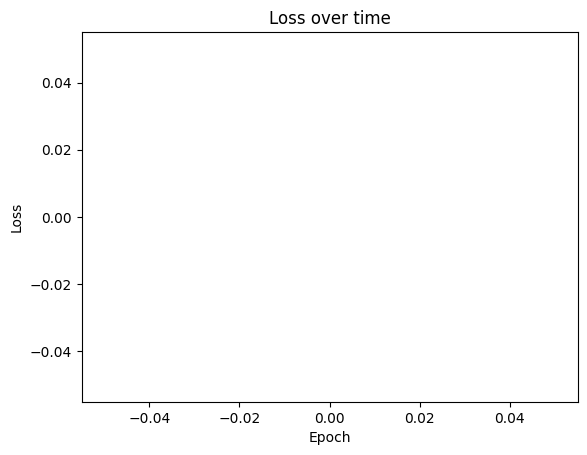

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

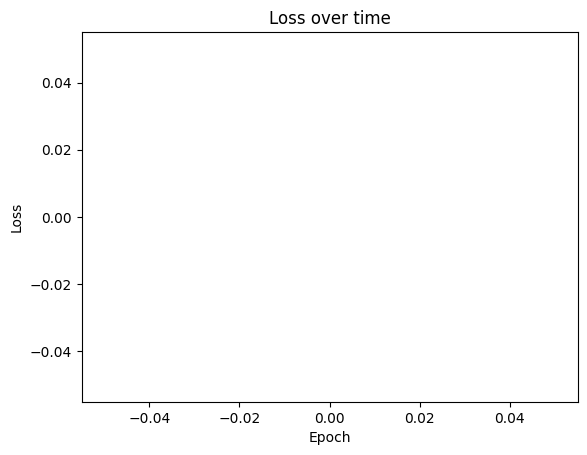

Validation Losses


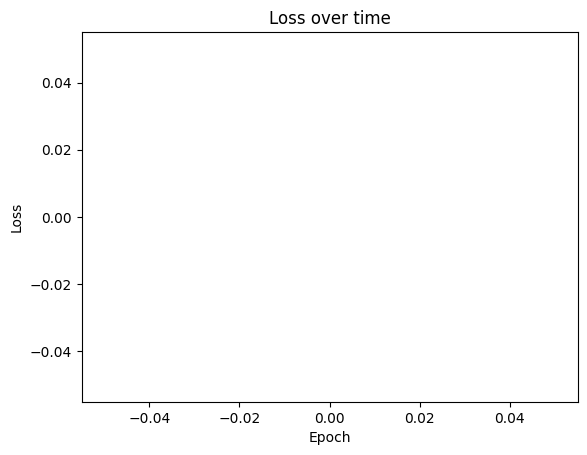

Epoch 0: Training Loss 281334.449043852, Validation Loss 282581.3504416781
Epoch 1: Training Loss 1003343290.382505, Validation Loss 1003267476.9173105
Epoch 2: Training Loss 1087347922.7567413, Validation Loss 1087426801.203573
Epoch 3: Training Loss 15342246334450.053, Validation Loss 15342236962264.58
Epoch 4: Training Loss 14853919116677.037, Validation Loss 14853928338459.387
Epoch 5: Training Loss 2.1819638953238934e+17, Validation Loss 2.1819638841470502e+17
Epoch 6: Training Loss 7.748625636645015e+20, Validation Loss 7.748625635978961e+20
Epoch 7: Training Loss 2.6592992161838595e+24, Validation Loss 2.6592992161799575e+24
Epoch 8: Training Loss 9.115792451822985e+27, Validation Loss 9.115792451822754e+27
Epoch 9: Training Loss 3.1246658976442486e+31, Validation Loss 3.124665897644247e+31
Epoch 10: Training Loss 1.0710558388492341e+35, Validation Loss 1.0710558388492343e+35
Epoch 11: Training Loss 3.671306273494061e+38, Validation Loss 3.671306273494061e+38
Epoch 12: Training 

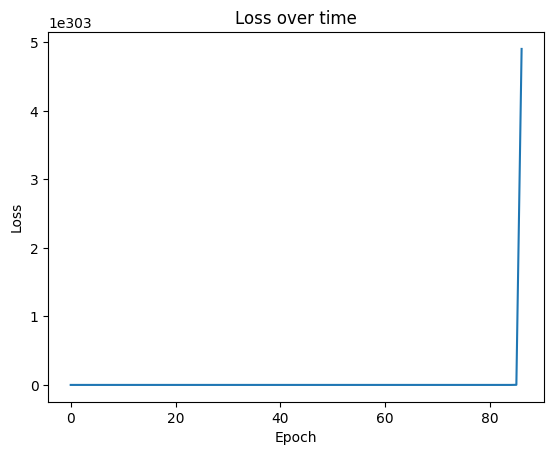

Validation Losses


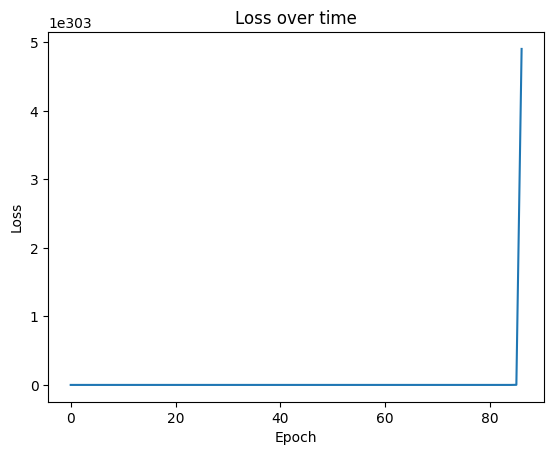

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

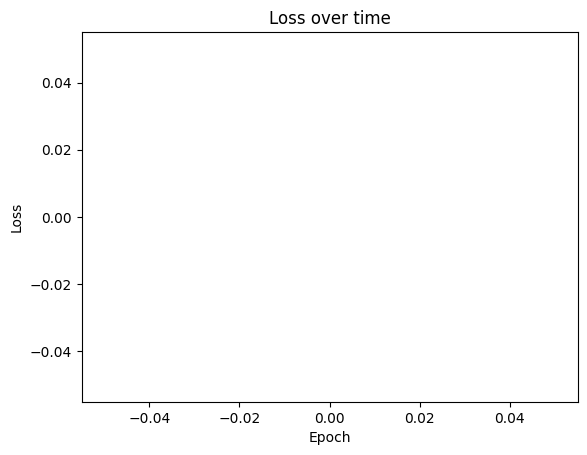

Validation Losses


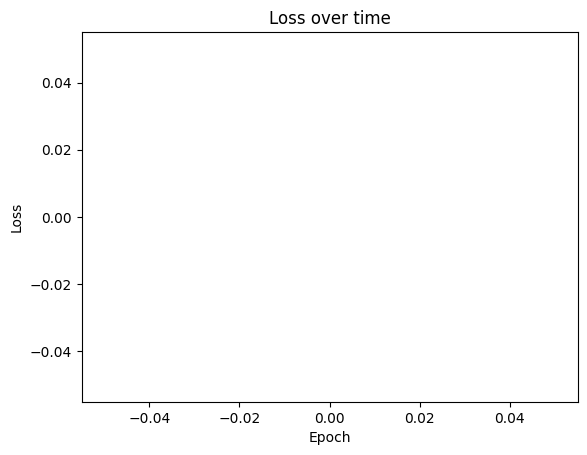

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

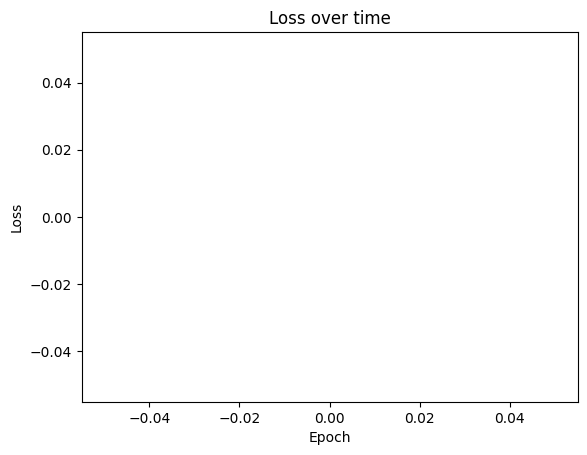

Validation Losses


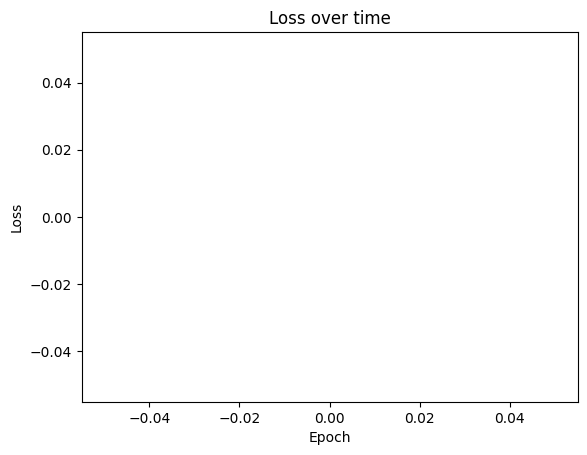

Epoch 0: Training Loss 256.7307190021509, Validation Loss 203.73363962574388
Epoch 1: Training Loss 2255122.4404103765, Validation Loss 2258693.532019251
Epoch 2: Training Loss 8317223260.048748, Validation Loss 8317005023.04192
Epoch 3: Training Loss 33358950745.236935, Validation Loss 33359387743.464935
Epoch 4: Training Loss 489259107827383.75, Validation Loss 489259054901877.94
Epoch 5: Training Loss 750301798571678.4, Validation Loss 750301864112703.0
Epoch 6: Training Loss 1.869949950354368e+19, Validation Loss 1.8699499493196775e+19
Epoch 7: Training Loss 2.1411609257164034e+19, Validation Loss 2.141160926823588e+19
Epoch 8: Training Loss 6.408281957337424e+23, Validation Loss 6.40828195731827e+23
Epoch 9: Training Loss 6.69000582005039e+23, Validation Loss 6.69000582006996e+23
Epoch 10: Training Loss 2.125971384607381e+28, Validation Loss 2.1259713846073457e+28
Epoch 11: Training Loss 2.155235517637764e+28, Validation Loss 2.155235517637799e+28
Epoch 12: Training Loss 6.9820689

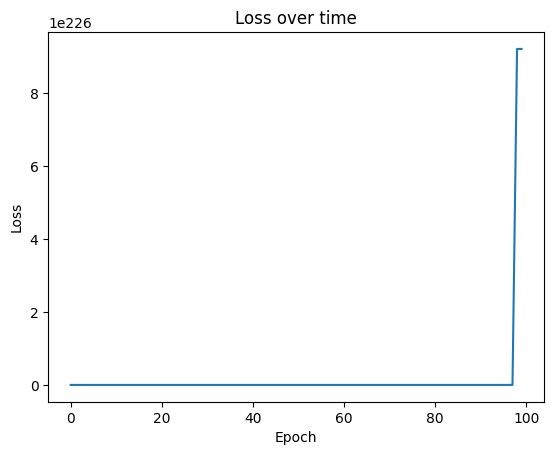

Validation Losses


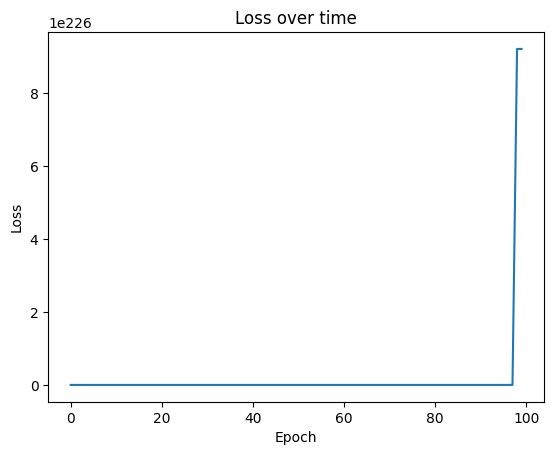

Epoch 0: Training Loss 5.528753500089946e+224, Validation Loss 4.233081881739564e+224
Epoch 1: Training Loss 1.126119263727498e+223, Validation Loss 1.3631791090497417e+221
Epoch 2: Training Loss 2.7220504628232935e+221, Validation Loss 5.757938789733286e+219
Epoch 3: Training Loss 2.254880917646423e+220, Validation Loss 2.0087321661880014e+220
Epoch 4: Training Loss 3.717490193272108e+218, Validation Loss 8.233442668902646e+217
Epoch 5: Training Loss 1.0421712133683862e+217, Validation Loss 4.782889239586714e+215
Epoch 6: Training Loss 3.0711471215859174e+215, Validation Loss 1.1004431241317216e+215
Epoch 7: Training Loss 1.4824112322560087e+214, Validation Loss 1.725185932616035e+212
Epoch 8: Training Loss 9.269192058251644e+212, Validation Loss 2.7561487323829853e+211
Epoch 9: Training Loss 6.360893266383921e+211, Validation Loss 4.885671612378184e+211
Epoch 10: Training Loss 1.6689265861106294e+210, Validation Loss 9.733580040138826e+209
Epoch 11: Training Loss 4.114948006568156e+2

Epoch 94: Training Loss 1.2931175956044432e+86, Validation Loss 1.0439176780422886e+86
Epoch 95: Training Loss 3.216119884541157e+84, Validation Loss 2.1953172524586503e+82
Epoch 96: Training Loss 9.063265054876665e+83, Validation Loss 8.814348079617216e+83
Epoch 97: Training Loss 6.337639927159244e+81, Validation Loss 2.777807118997531e+81
Epoch 98: Training Loss 2.1254615436613642e+80, Validation Loss 3.7228220795581594e+77
Epoch 99: Training Loss 6.846931659308349e+78, Validation Loss 4.226330905934626e+78

Train Losses


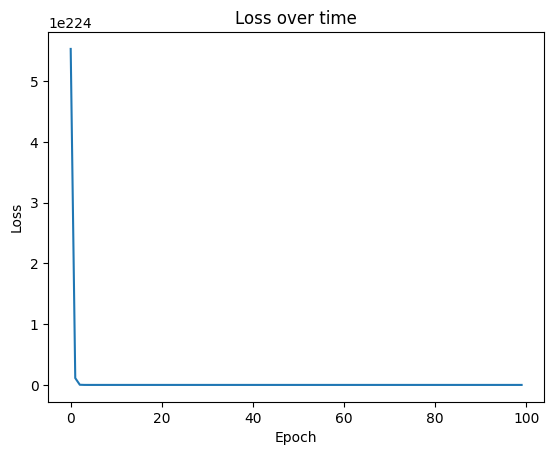

Validation Losses


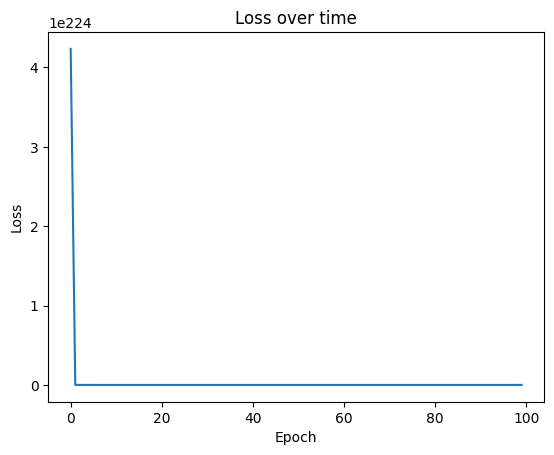

Epoch 0: Training Loss 5.699621207500234e+101, Validation Loss 5.75825826678703e+101
Epoch 1: Training Loss 7.103562282131258e+125, Validation Loss 7.17588237415541e+125
Epoch 2: Training Loss 1.0257705729231648e+150, Validation Loss 1.0363236668661299e+150
Epoch 3: Training Loss 1.3381454611403302e+174, Validation Loss 1.3519183889374545e+174
Epoch 4: Training Loss 1.9261741126862855e+198, Validation Loss 1.945994813360715e+198
Epoch 5: Training Loss 2.66205968511829e+222, Validation Loss 2.6893885333819283e+222
Epoch 6: Training Loss 7.597040810628922e+243, Validation Loss 7.597040810628924e+243
Epoch 7: Training Loss 1.020308532285409e+264, Validation Loss 1.0203085322854088e+264
Epoch 8: Training Loss 1.3703079683168298e+284, Validation Loss 1.3703079683168298e+284
Epoch 9: Training Loss 1.8403687400580743e+304, Validation Loss 1.8403687400580745e+304
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Valid

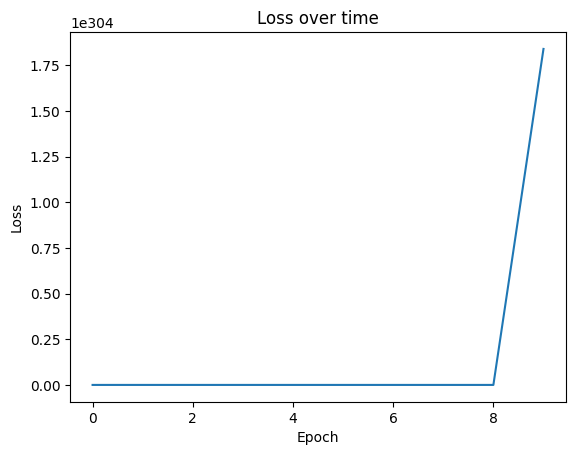

Validation Losses


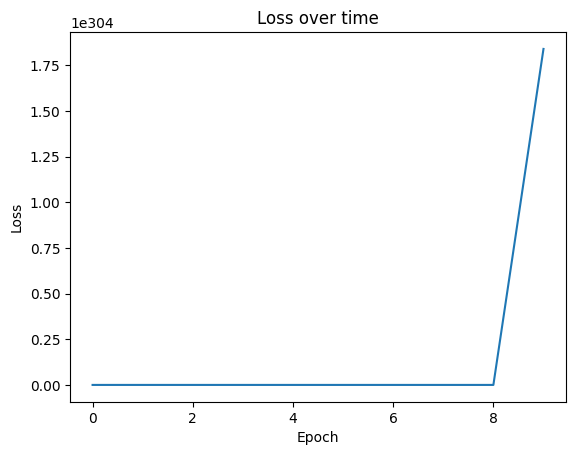

Epoch 0: Training Loss 2241537281504.419, Validation Loss 2301622263123.9424
Epoch 1: Training Loss 2027290853835229.8, Validation Loss 2027290746101053.8
Epoch 2: Training Loss 1.7404089251089298e+18, Validation Loss 1.7404089282655406e+18
Epoch 3: Training Loss 1.4941236581167656e+21, Validation Loss 1.4941236580242767e+21
Epoch 4: Training Loss 1.2826902192566624e+24, Validation Loss 1.2826902192593726e+24
Epoch 5: Training Loss 1.1011767263296525e+27, Validation Loss 1.101176726329573e+27
Epoch 6: Training Loss 9.453492077867433e+29, Validation Loss 9.453492077867456e+29
Epoch 7: Training Loss 8.11572841392841e+32, Validation Loss 8.115728413928411e+32
Epoch 8: Training Loss 6.967271686073397e+35, Validation Loss 6.967271686073397e+35
Epoch 9: Training Loss 5.981333069777149e+38, Validation Loss 5.981333069777147e+38
Epoch 10: Training Loss 5.1349146270729854e+41, Validation Loss 5.134914627072985e+41
Epoch 11: Training Loss 4.408272858195888e+44, Validation Loss 4.4082728581958885

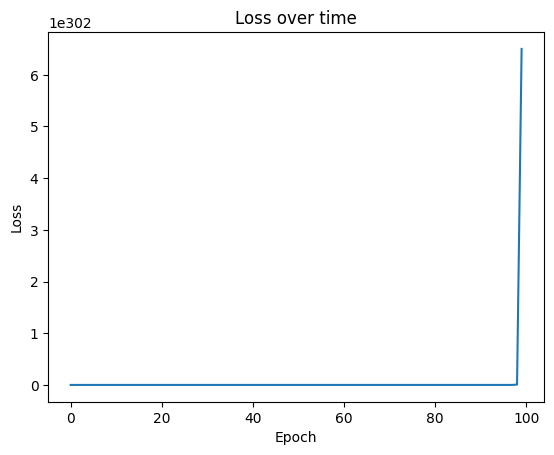

Validation Losses


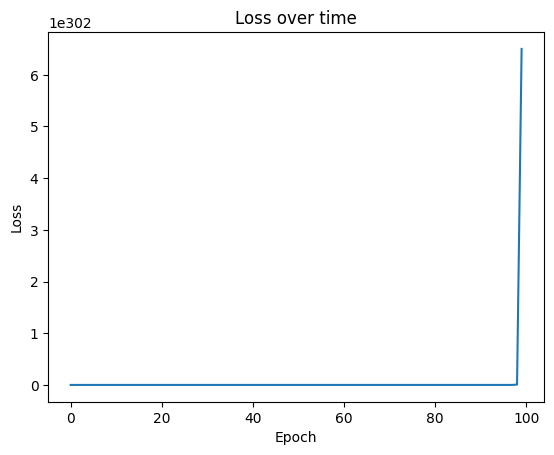

Epoch 0: Training Loss 1.213194326564412e+275, Validation Loss 1.2131943265644122e+275
Epoch 1: Training Loss 2.264076468454225e+247, Validation Loss 2.2640764684542247e+247
Epoch 2: Training Loss 4.2252441696824663e+219, Validation Loss 4.2252441696824663e+219
Epoch 3: Training Loss 7.885196698159423e+191, Validation Loss 7.88519669815942e+191
Epoch 4: Training Loss 1.4715439977362789e+164, Validation Loss 1.4715439977362786e+164
Epoch 5: Training Loss 2.746211439188483e+136, Validation Loss 2.746211439188483e+136
Epoch 6: Training Loss 5.125009704318228e+108, Validation Loss 5.125009704318228e+108
Epoch 7: Training Loss 9.564348940705603e+80, Validation Loss 9.564348940705603e+80
Epoch 8: Training Loss 1.7849092184645098e+53, Validation Loss 1.7849092184645096e+53
Epoch 9: Training Loss 3.33101702783065e+25, Validation Loss 3.3310170278292696e+25
Epoch 10: Training Loss 98.82408837465377, Validation Loss 69.38202164826552
Epoch 11: Training Loss 90.03669133397771, Validation Loss 70.

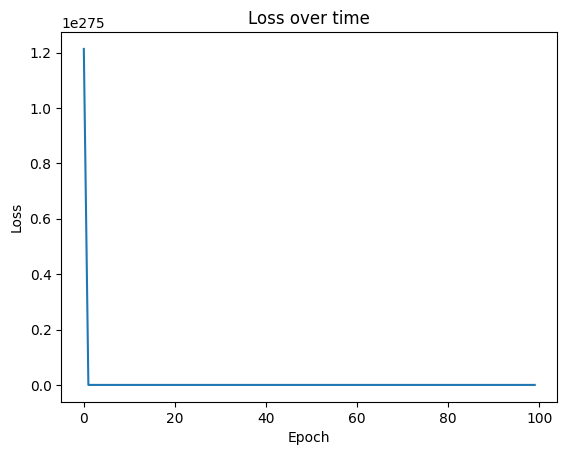

Validation Losses


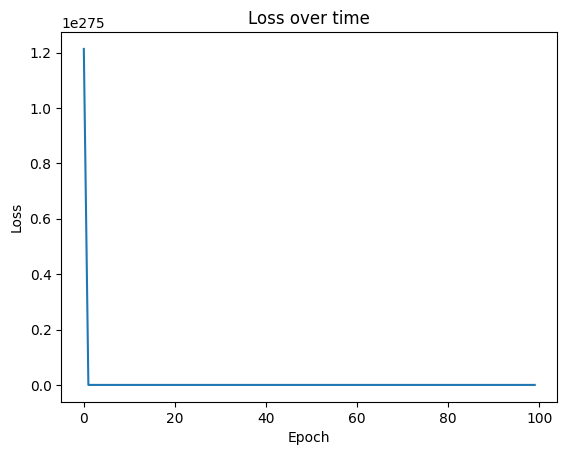

Epoch 0: Training Loss 1158204.9058812794, Validation Loss 1155607.9113230829
Epoch 1: Training Loss 419424532431.10516, Validation Loss 419422982799.4959
Epoch 2: Training Loss 1.528274324749689e+17, Validation Loss 1.528274315395717e+17
Epoch 3: Training Loss 5.568645641873321e+22, Validation Loss 5.568645641816856e+22
Epoch 4: Training Loss 2.029073813774696e+28, Validation Loss 2.029073813774661e+28
Epoch 5: Training Loss 7.393432454797585e+33, Validation Loss 7.393432454797581e+33
Epoch 6: Training Loss 2.693980036239493e+39, Validation Loss 2.6939800362394933e+39
Epoch 7: Training Loss 9.81618278117567e+44, Validation Loss 9.816182781175669e+44
Epoch 8: Training Loss 3.576769059059333e+50, Validation Loss 3.5767690590593326e+50
Epoch 9: Training Loss 1.303284299715532e+56, Validation Loss 1.3032842997155313e+56
Epoch 10: Training Loss 4.748838792325363e+61, Validation Loss 4.748838792325364e+61
Epoch 11: Training Loss 1.7303569052751202e+67, Validation Loss 1.7303569052751202e+67

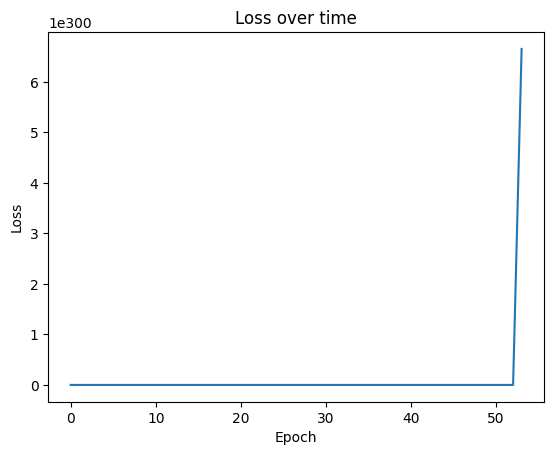

Validation Losses


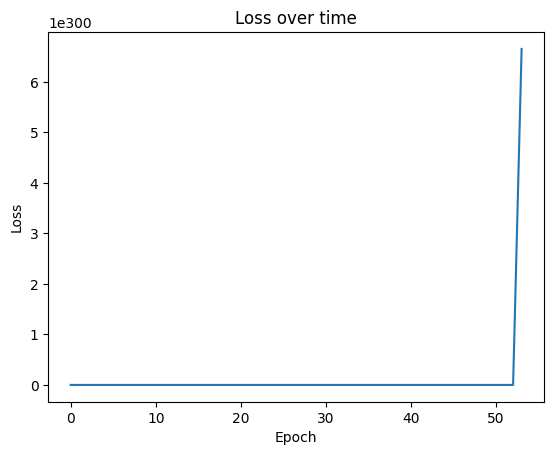

Epoch 0: Training Loss 8014343355.938822, Validation Loss 8177685602.479283
Epoch 1: Training Loss 7282853622347.512, Validation Loss 7282847165096.779
Epoch 2: Training Loss 6252257006172605.0, Validation Loss 6252257195369385.0
Epoch 3: Training Loss 5.367500117229045e+18, Validation Loss 5.367500111685578e+18
Epoch 4: Training Loss 4.607945175639961e+21, Validation Loss 4.6079451758023855e+21
Epoch 5: Training Loss 3.955874853835151e+24, Validation Loss 3.955874853830391e+24
Epoch 6: Training Loss 3.3960790032689406e+27, Validation Loss 3.39607900326908e+27
Epoch 7: Training Loss 2.915499863516353e+30, Validation Loss 2.915499863516349e+30
Epoch 8: Training Loss 2.5029274778301537e+33, Validation Loss 2.502927477830154e+33
Epoch 9: Training Loss 2.148738210442408e+36, Validation Loss 2.148738210442408e+36
Epoch 10: Training Loss 1.8446702662827034e+39, Validation Loss 1.8446702662827034e+39
Epoch 11: Training Loss 1.583630976901037e+42, Validation Loss 1.583630976901037e+42
Epoch 12

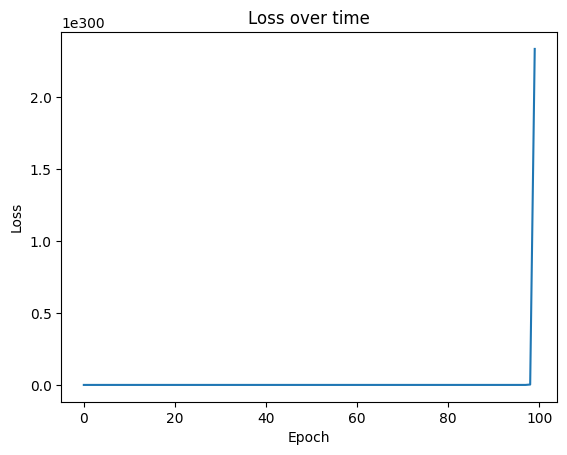

Validation Losses


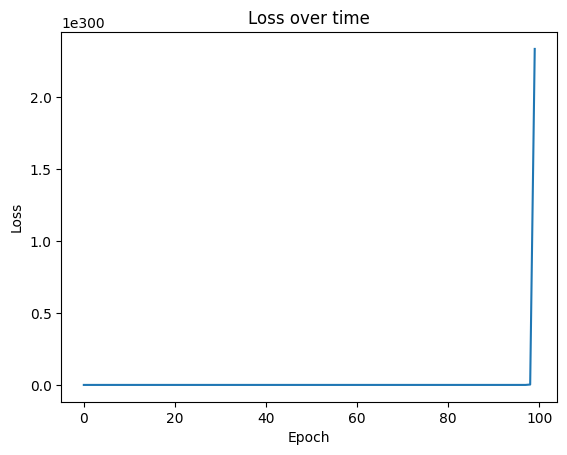

Epoch 0: Training Loss 4.3582876522173806e+272, Validation Loss 4.358287652217381e+272
Epoch 1: Training Loss 8.133483894606767e+244, Validation Loss 8.133483894606763e+244
Epoch 2: Training Loss 1.51787962481482e+217, Validation Loss 1.5178796248148203e+217
Epoch 3: Training Loss 2.832683491210586e+189, Validation Loss 2.832683491210586e+189
Epoch 4: Training Loss 5.286384789805664e+161, Validation Loss 5.286384789805664e+161
Epoch 5: Training Loss 9.86550888321998e+133, Validation Loss 9.865508883219982e+133
Epoch 6: Training Loss 1.8411120150122552e+106, Validation Loss 1.8411120150122556e+106
Epoch 7: Training Loss 3.4359032990056276e+78, Validation Loss 3.4359032990056272e+78
Epoch 8: Training Loss 6.412120166430599e+50, Validation Loss 6.412120166430599e+50
Epoch 9: Training Loss 1.1966368506470901e+23, Validation Loss 1.196636850638813e+23
Epoch 10: Training Loss 106.90623578275738, Validation Loss 74.81603029530393
Epoch 11: Training Loss 90.29141752109562, Validation Loss 65.7

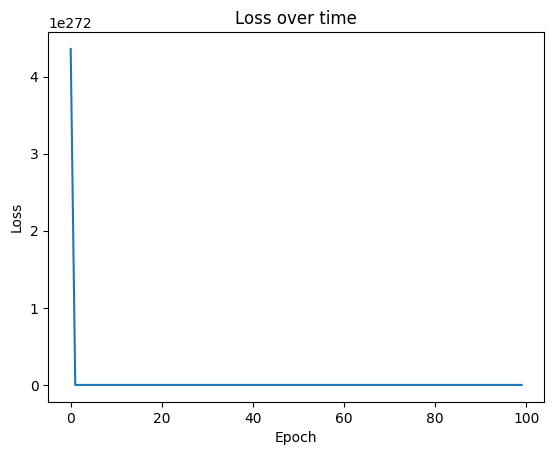

Validation Losses


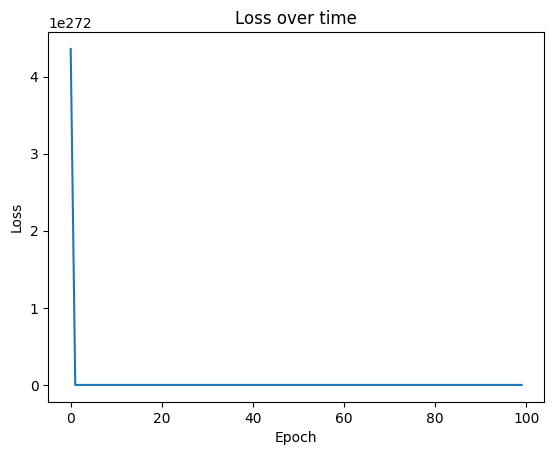

Epoch 0: Training Loss 9697758.44714669, Validation Loss 9690285.168958327
Epoch 1: Training Loss 3535162209461.04, Validation Loss 3535157710604.157
Epoch 2: Training Loss 1.2881284183427108e+18, Validation Loss 1.2881284156270536e+18
Epoch 3: Training Loss 4.693614620443069e+23, Validation Loss 4.6936146204266766e+23
Epoch 4: Training Loss 1.7102346119350462e+29, Validation Loss 1.7102346119350363e+29
Epoch 5: Training Loss 6.231662938705987e+34, Validation Loss 6.231662938705985e+34
Epoch 6: Training Loss 2.270660569645666e+40, Validation Loss 2.2706605696456656e+40
Epoch 7: Training Loss 8.273713570930402e+45, Validation Loss 8.2737135709304e+45
Epoch 8: Training Loss 3.0147322399877755e+51, Validation Loss 3.0147322399877755e+51
Epoch 9: Training Loss 1.0984922793018186e+57, Validation Loss 1.0984922793018187e+57
Epoch 10: Training Loss 4.0026283982374315e+62, Validation Loss 4.0026283982374315e+62
Epoch 11: Training Loss 1.4584566861552692e+68, Validation Loss 1.4584566861552702e

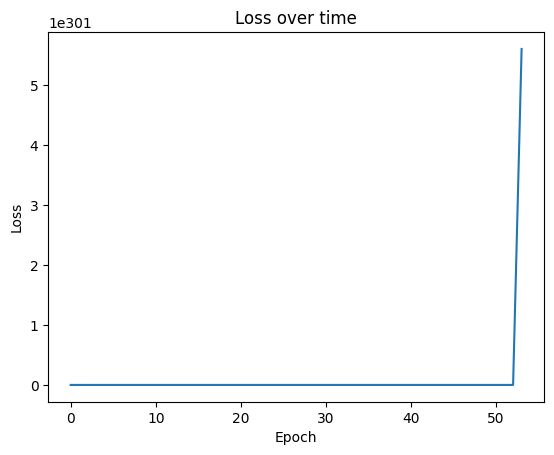

Validation Losses


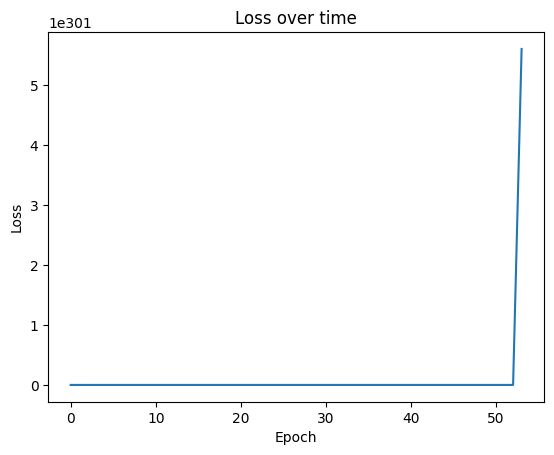

Epoch 0: Training Loss 1337353.7230080978, Validation Loss 1340098.660914132
Epoch 1: Training Loss 4750177542.385294, Validation Loss 4750012609.101493
Epoch 2: Training Loss 16873390342101.037, Validation Loss 16873400170789.77
Epoch 3: Training Loss 5.993698223728077e+16, Validation Loss 5.993698165148959e+16
Epoch 4: Training Loss 2.1290575082397883e+20, Validation Loss 2.1290575085889202e+20
Epoch 5: Training Loss 7.562752918469041e+23, Validation Loss 7.562752918448233e+23
Epoch 6: Training Loss 2.686410840686899e+27, Validation Loss 2.686410840687023e+27
Epoch 7: Training Loss 9.542561131854368e+30, Validation Loss 9.542561131854359e+30
Epoch 8: Training Loss 3.38967039501277e+34, Validation Loss 3.3896703950127693e+34
Epoch 9: Training Loss 1.204065159034852e+38, Validation Loss 1.2040651590348515e+38
Epoch 10: Training Loss 4.277032095317253e+41, Validation Loss 4.277032095317254e+41
Epoch 11: Training Loss 1.5192702327702063e+45, Validation Loss 1.5192702327702063e+45
Epoch 1

Epoch 128: Training Loss nan, Validation Loss nan
Epoch 129: Training Loss nan, Validation Loss nan
Epoch 130: Training Loss nan, Validation Loss nan
Epoch 131: Training Loss nan, Validation Loss nan
Epoch 132: Training Loss nan, Validation Loss nan
Epoch 133: Training Loss nan, Validation Loss nan
Epoch 134: Training Loss nan, Validation Loss nan
Epoch 135: Training Loss nan, Validation Loss nan
Epoch 136: Training Loss nan, Validation Loss nan
Epoch 137: Training Loss nan, Validation Loss nan
Epoch 138: Training Loss nan, Validation Loss nan
Epoch 139: Training Loss nan, Validation Loss nan
Epoch 140: Training Loss nan, Validation Loss nan
Epoch 141: Training Loss nan, Validation Loss nan
Epoch 142: Training Loss nan, Validation Loss nan
Epoch 143: Training Loss nan, Validation Loss nan
Epoch 144: Training Loss nan, Validation Loss nan
Epoch 145: Training Loss nan, Validation Loss nan
Epoch 146: Training Loss nan, Validation Loss nan
Epoch 147: Training Loss nan, Validation Loss nan


Epoch 381: Training Loss nan, Validation Loss nan
Epoch 382: Training Loss nan, Validation Loss nan
Epoch 383: Training Loss nan, Validation Loss nan
Epoch 384: Training Loss nan, Validation Loss nan
Epoch 385: Training Loss nan, Validation Loss nan
Epoch 386: Training Loss nan, Validation Loss nan
Epoch 387: Training Loss nan, Validation Loss nan
Epoch 388: Training Loss nan, Validation Loss nan
Epoch 389: Training Loss nan, Validation Loss nan
Epoch 390: Training Loss nan, Validation Loss nan
Epoch 391: Training Loss nan, Validation Loss nan
Epoch 392: Training Loss nan, Validation Loss nan
Epoch 393: Training Loss nan, Validation Loss nan
Epoch 394: Training Loss nan, Validation Loss nan
Epoch 395: Training Loss nan, Validation Loss nan
Epoch 396: Training Loss nan, Validation Loss nan
Epoch 397: Training Loss nan, Validation Loss nan
Epoch 398: Training Loss nan, Validation Loss nan
Epoch 399: Training Loss nan, Validation Loss nan
Epoch 400: Training Loss nan, Validation Loss nan


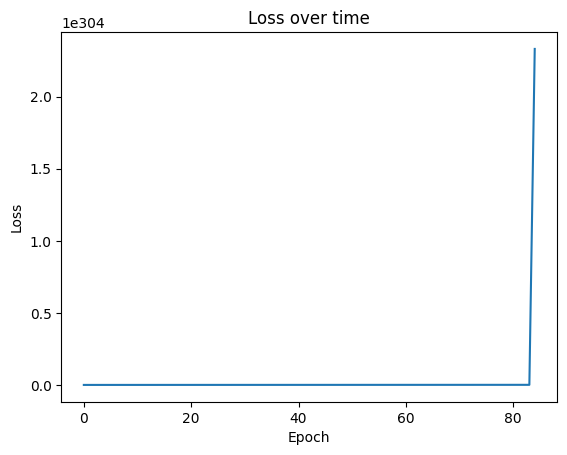

Validation Losses


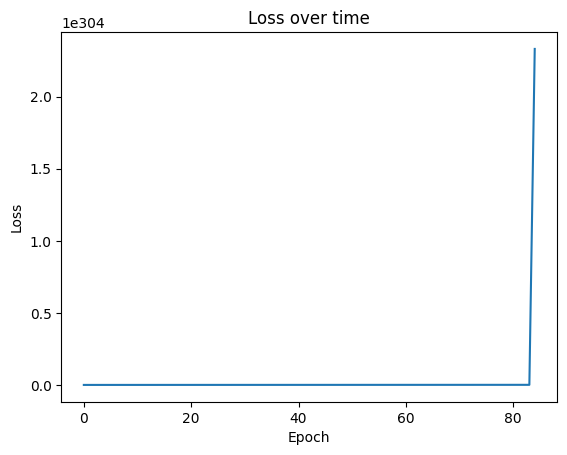

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 167: Training Loss nan, Validation Loss nan
Epoch 168: Training Loss nan, Validation Loss nan
Epoch 169: Training Loss nan, Validation Loss nan
Epoch 170: Training Loss nan, Validation Loss nan
Epoch 171: Training Loss nan, Validation Loss nan
Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan


Epoch 333: Training Loss nan, Validation Loss nan
Epoch 334: Training Loss nan, Validation Loss nan
Epoch 335: Training Loss nan, Validation Loss nan
Epoch 336: Training Loss nan, Validation Loss nan
Epoch 337: Training Loss nan, Validation Loss nan
Epoch 338: Training Loss nan, Validation Loss nan
Epoch 339: Training Loss nan, Validation Loss nan
Epoch 340: Training Loss nan, Validation Loss nan
Epoch 341: Training Loss nan, Validation Loss nan
Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan


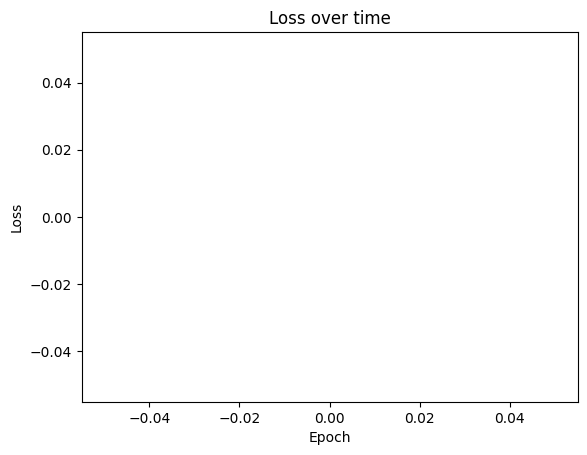

Validation Losses


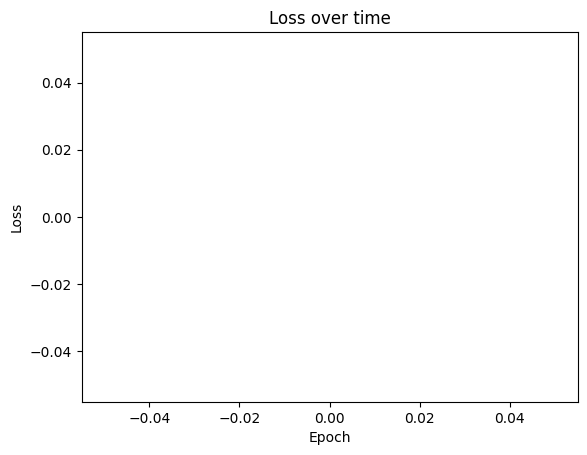

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 212: Training Loss nan, Validation Loss nan
Epoch 213: Training Loss nan, Validation Loss nan
Epoch 214: Training Loss nan, Validation Loss nan
Epoch 215: Training Loss nan, Validation Loss nan
Epoch 216: Training Loss nan, Validation Loss nan
Epoch 217: Training Loss nan, Validation Loss nan
Epoch 218: Training Loss nan, Validation Loss nan
Epoch 219: Training Loss nan, Validation Loss nan
Epoch 220: Training Loss nan, Validation Loss nan
Epoch 221: Training Loss nan, Validation Loss nan
Epoch 222: Training Loss nan, Validation Loss nan
Epoch 223: Training Loss nan, Validation Loss nan
Epoch 224: Training Loss nan, Validation Loss nan
Epoch 225: Training Loss nan, Validation Loss nan
Epoch 226: Training Loss nan, Validation Loss nan
Epoch 227: Training Loss nan, Validation Loss nan
Epoch 228: Training Loss nan, Validation Loss nan
Epoch 229: Training Loss nan, Validation Loss nan
Epoch 230: Training Loss nan, Validation Loss nan
Epoch 231: Training Loss nan, Validation Loss nan


Epoch 437: Training Loss nan, Validation Loss nan
Epoch 438: Training Loss nan, Validation Loss nan
Epoch 439: Training Loss nan, Validation Loss nan
Epoch 440: Training Loss nan, Validation Loss nan
Epoch 441: Training Loss nan, Validation Loss nan
Epoch 442: Training Loss nan, Validation Loss nan
Epoch 443: Training Loss nan, Validation Loss nan
Epoch 444: Training Loss nan, Validation Loss nan
Epoch 445: Training Loss nan, Validation Loss nan
Epoch 446: Training Loss nan, Validation Loss nan
Epoch 447: Training Loss nan, Validation Loss nan
Epoch 448: Training Loss nan, Validation Loss nan
Epoch 449: Training Loss nan, Validation Loss nan
Epoch 450: Training Loss nan, Validation Loss nan
Epoch 451: Training Loss nan, Validation Loss nan
Epoch 452: Training Loss nan, Validation Loss nan
Epoch 453: Training Loss nan, Validation Loss nan
Epoch 454: Training Loss nan, Validation Loss nan
Epoch 455: Training Loss nan, Validation Loss nan
Epoch 456: Training Loss nan, Validation Loss nan


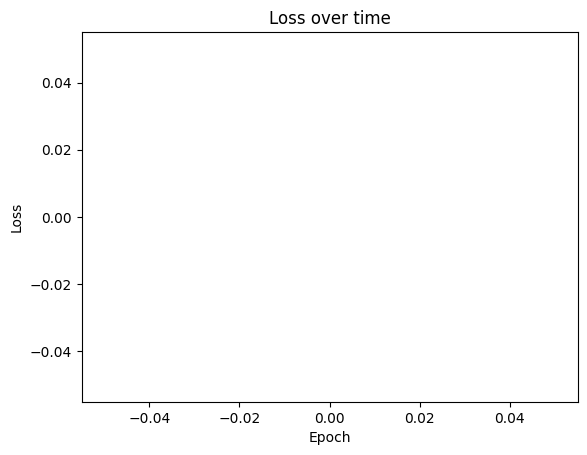

Validation Losses


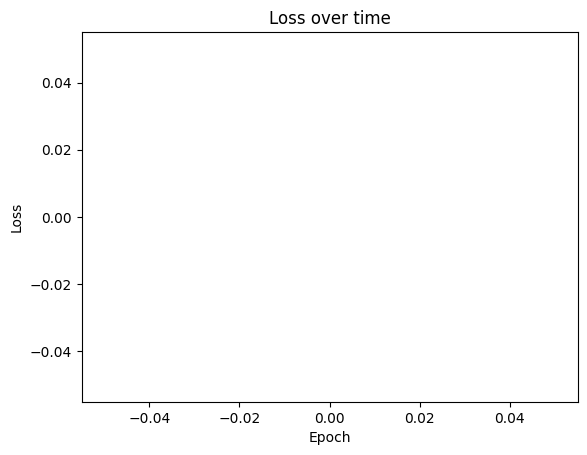

Epoch 0: Training Loss 2566836.81623169, Validation Loss 2570648.2116828808
Epoch 1: Training Loss 20744479775.19036, Validation Loss 20744135128.2624
Epoch 2: Training Loss 167657092266844.53, Validation Loss 167657123248600.9
Epoch 3: Training Loss 1.35500629627084e+18, Validation Loss 1.355006293485578e+18
Epoch 4: Training Loss 4.867188654395112e+21, Validation Loss 4.867188654562041e+21
Epoch 5: Training Loss 1.7289032850596124e+25, Validation Loss 1.7289032850586175e+25
Epoch 6: Training Loss 6.141341093057359e+28, Validation Loss 6.141341093057418e+28
Epoch 7: Training Loss 2.181502617711462e+32, Validation Loss 2.1815026177114628e+32
Epoch 8: Training Loss 7.749046338529998e+35, Validation Loss 7.749046338529999e+35
Epoch 9: Training Loss 2.7525852441872685e+39, Validation Loss 2.752585244187268e+39
Epoch 10: Training Loss 9.777623200992195e+42, Validation Loss 9.777623200992192e+42
Epoch 11: Training Loss 3.4731682029636594e+46, Validation Loss 3.4731682029636604e+46
Epoch 12:

Epoch 382: Training Loss nan, Validation Loss nan
Epoch 383: Training Loss nan, Validation Loss nan
Epoch 384: Training Loss nan, Validation Loss nan
Epoch 385: Training Loss nan, Validation Loss nan
Epoch 386: Training Loss nan, Validation Loss nan
Epoch 387: Training Loss nan, Validation Loss nan
Epoch 388: Training Loss nan, Validation Loss nan
Epoch 389: Training Loss nan, Validation Loss nan
Epoch 390: Training Loss nan, Validation Loss nan
Epoch 391: Training Loss nan, Validation Loss nan
Epoch 392: Training Loss nan, Validation Loss nan
Epoch 393: Training Loss nan, Validation Loss nan
Epoch 394: Training Loss nan, Validation Loss nan
Epoch 395: Training Loss nan, Validation Loss nan
Epoch 396: Training Loss nan, Validation Loss nan
Epoch 397: Training Loss nan, Validation Loss nan
Epoch 398: Training Loss nan, Validation Loss nan
Epoch 399: Training Loss nan, Validation Loss nan
Epoch 400: Training Loss nan, Validation Loss nan
Epoch 401: Training Loss nan, Validation Loss nan


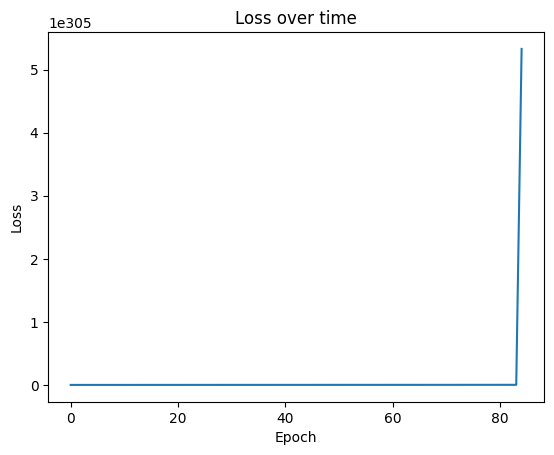

Validation Losses


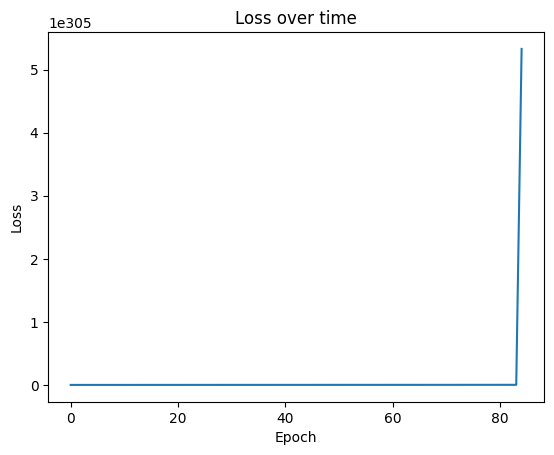

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 169: Training Loss nan, Validation Loss nan
Epoch 170: Training Loss nan, Validation Loss nan
Epoch 171: Training Loss nan, Validation Loss nan
Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan
Epoch 187: Training Loss nan, Validation Loss nan
Epoch 188: Training Loss nan, Validation Loss nan


Epoch 338: Training Loss nan, Validation Loss nan
Epoch 339: Training Loss nan, Validation Loss nan
Epoch 340: Training Loss nan, Validation Loss nan
Epoch 341: Training Loss nan, Validation Loss nan
Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan
Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan
Epoch 355: Training Loss nan, Validation Loss nan
Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan


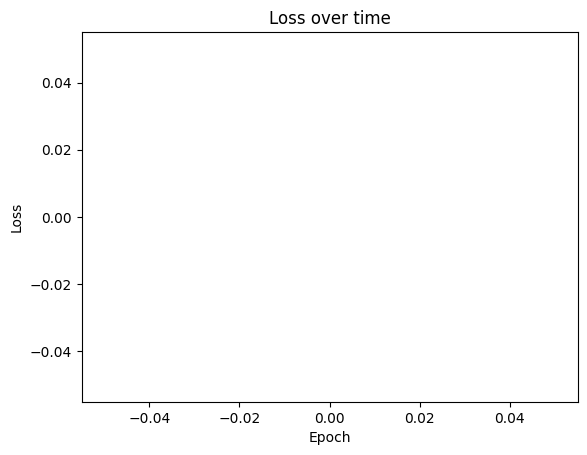

Validation Losses


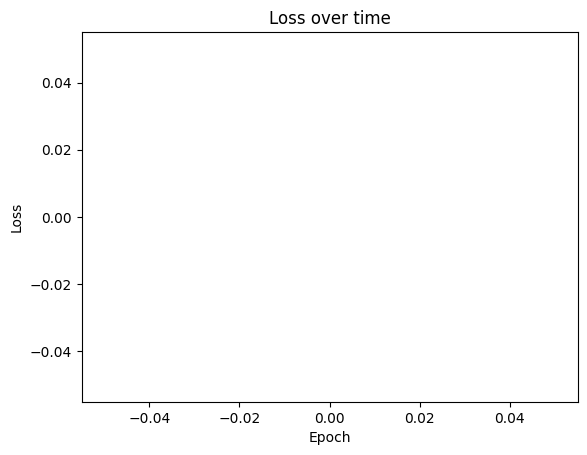

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 197: Training Loss nan, Validation Loss nan
Epoch 198: Training Loss nan, Validation Loss nan
Epoch 199: Training Loss nan, Validation Loss nan
Epoch 200: Training Loss nan, Validation Loss nan
Epoch 201: Training Loss nan, Validation Loss nan
Epoch 202: Training Loss nan, Validation Loss nan
Epoch 203: Training Loss nan, Validation Loss nan
Epoch 204: Training Loss nan, Validation Loss nan
Epoch 205: Training Loss nan, Validation Loss nan
Epoch 206: Training Loss nan, Validation Loss nan
Epoch 207: Training Loss nan, Validation Loss nan
Epoch 208: Training Loss nan, Validation Loss nan
Epoch 209: Training Loss nan, Validation Loss nan
Epoch 210: Training Loss nan, Validation Loss nan
Epoch 211: Training Loss nan, Validation Loss nan
Epoch 212: Training Loss nan, Validation Loss nan
Epoch 213: Training Loss nan, Validation Loss nan
Epoch 214: Training Loss nan, Validation Loss nan
Epoch 215: Training Loss nan, Validation Loss nan
Epoch 216: Training Loss nan, Validation Loss nan


Epoch 431: Training Loss nan, Validation Loss nan
Epoch 432: Training Loss nan, Validation Loss nan
Epoch 433: Training Loss nan, Validation Loss nan
Epoch 434: Training Loss nan, Validation Loss nan
Epoch 435: Training Loss nan, Validation Loss nan
Epoch 436: Training Loss nan, Validation Loss nan
Epoch 437: Training Loss nan, Validation Loss nan
Epoch 438: Training Loss nan, Validation Loss nan
Epoch 439: Training Loss nan, Validation Loss nan
Epoch 440: Training Loss nan, Validation Loss nan
Epoch 441: Training Loss nan, Validation Loss nan
Epoch 442: Training Loss nan, Validation Loss nan
Epoch 443: Training Loss nan, Validation Loss nan
Epoch 444: Training Loss nan, Validation Loss nan
Epoch 445: Training Loss nan, Validation Loss nan
Epoch 446: Training Loss nan, Validation Loss nan
Epoch 447: Training Loss nan, Validation Loss nan
Epoch 448: Training Loss nan, Validation Loss nan
Epoch 449: Training Loss nan, Validation Loss nan
Epoch 450: Training Loss nan, Validation Loss nan


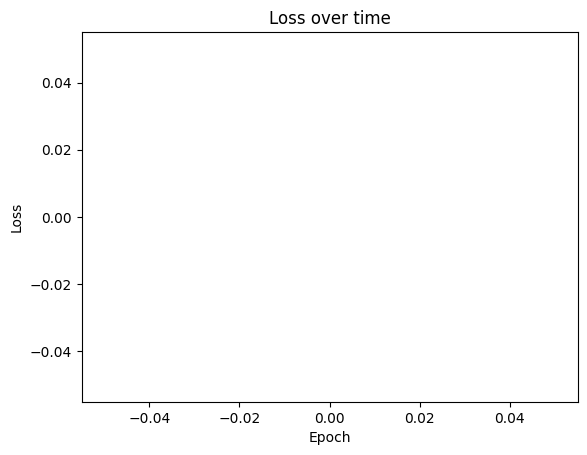

Validation Losses


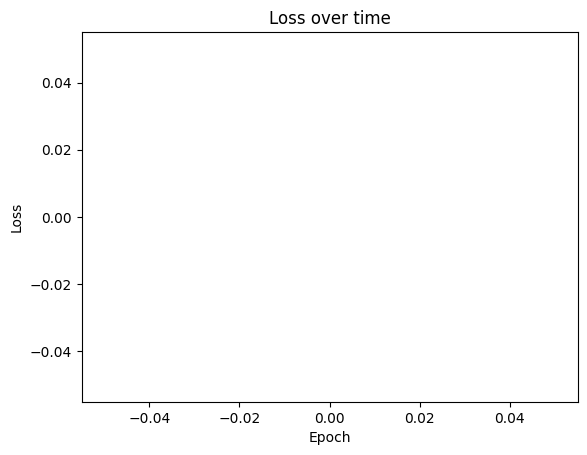

Epoch 0: Training Loss 757536.2076374801, Validation Loss 759596.6133950871
Epoch 1: Training Loss 6481.057628510622, Validation Loss 6650.325116998187
Epoch 2: Training Loss 10943624367.498732, Validation Loss 10943374036.757467
Epoch 3: Training Loss 39577971325401.21, Validation Loss 39577956272411.04
Epoch 4: Training Loss 1.3591497263334112e+17, Validation Loss 1.3591497175121834e+17
Epoch 5: Training Loss 4.659121426305137e+20, Validation Loss 4.659121425788664e+20
Epoch 6: Training Loss 1.597031643976223e+24, Validation Loss 1.5970316439731988e+24
Epoch 7: Training Loss 5.474217625719643e+27, Validation Loss 5.474217625719467e+27
Epoch 8: Training Loss 1.8764221996431594e+31, Validation Loss 1.8764221996431585e+31
Epoch 9: Training Loss 6.431896761374774e+34, Validation Loss 6.431896761374776e+34
Epoch 10: Training Loss 2.2046901786243847e+38, Validation Loss 2.204690178624385e+38
Epoch 11: Training Loss 7.557115675264051e+41, Validation Loss 7.557115675264051e+41
Epoch 12: Trai

Epoch 260: Training Loss nan, Validation Loss nan
Epoch 261: Training Loss nan, Validation Loss nan
Epoch 262: Training Loss nan, Validation Loss nan
Epoch 263: Training Loss nan, Validation Loss nan
Epoch 264: Training Loss nan, Validation Loss nan
Epoch 265: Training Loss nan, Validation Loss nan
Epoch 266: Training Loss nan, Validation Loss nan
Epoch 267: Training Loss nan, Validation Loss nan
Epoch 268: Training Loss nan, Validation Loss nan
Epoch 269: Training Loss nan, Validation Loss nan
Epoch 270: Training Loss nan, Validation Loss nan
Epoch 271: Training Loss nan, Validation Loss nan
Epoch 272: Training Loss nan, Validation Loss nan
Epoch 273: Training Loss nan, Validation Loss nan
Epoch 274: Training Loss nan, Validation Loss nan
Epoch 275: Training Loss nan, Validation Loss nan
Epoch 276: Training Loss nan, Validation Loss nan
Epoch 277: Training Loss nan, Validation Loss nan
Epoch 278: Training Loss nan, Validation Loss nan
Epoch 279: Training Loss nan, Validation Loss nan


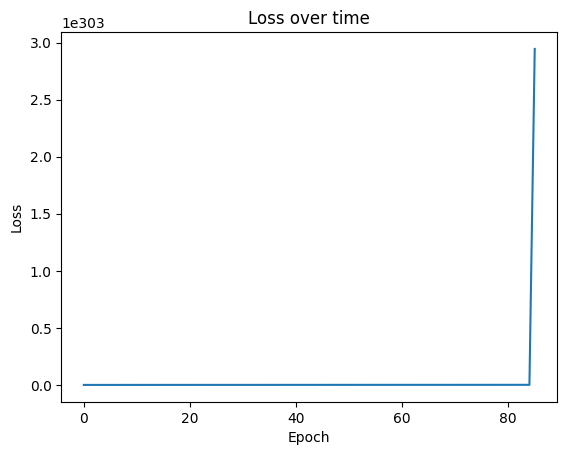

Validation Losses


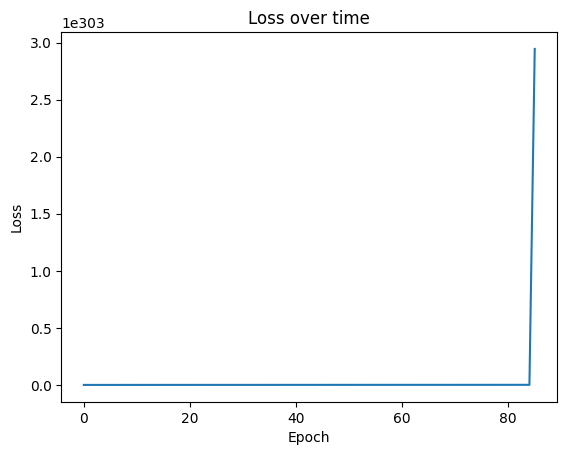

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan
Epoch 187: Training Loss nan, Validation Loss nan
Epoch 188: Training Loss nan, Validation Loss nan
Epoch 189: Training Loss nan, Validation Loss nan
Epoch 190: Training Loss nan, Validation Loss nan
Epoch 191: Training Loss nan, Validation Loss nan


Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan
Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan
Epoch 355: Training Loss nan, Validation Loss nan
Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan
Epoch 358: Training Loss nan, Validation Loss nan
Epoch 359: Training Loss nan, Validation Loss nan
Epoch 360: Training Loss nan, Validation Loss nan
Epoch 361: Training Loss nan, Validation Loss nan


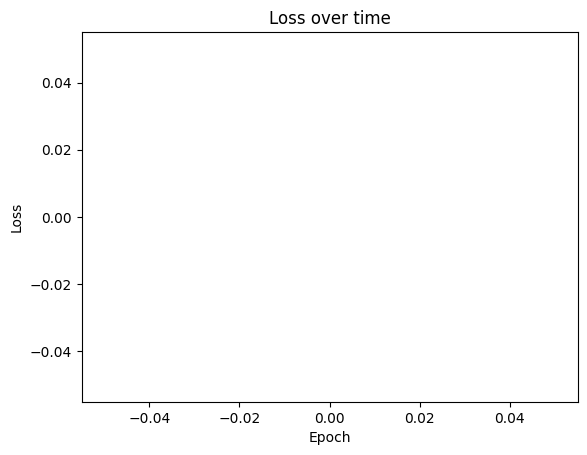

Validation Losses


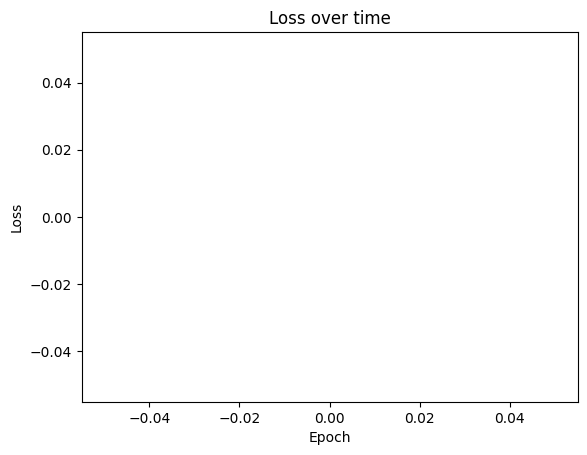

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 194: Training Loss nan, Validation Loss nan
Epoch 195: Training Loss nan, Validation Loss nan
Epoch 196: Training Loss nan, Validation Loss nan
Epoch 197: Training Loss nan, Validation Loss nan
Epoch 198: Training Loss nan, Validation Loss nan
Epoch 199: Training Loss nan, Validation Loss nan
Epoch 200: Training Loss nan, Validation Loss nan
Epoch 201: Training Loss nan, Validation Loss nan
Epoch 202: Training Loss nan, Validation Loss nan
Epoch 203: Training Loss nan, Validation Loss nan
Epoch 204: Training Loss nan, Validation Loss nan
Epoch 205: Training Loss nan, Validation Loss nan
Epoch 206: Training Loss nan, Validation Loss nan
Epoch 207: Training Loss nan, Validation Loss nan
Epoch 208: Training Loss nan, Validation Loss nan
Epoch 209: Training Loss nan, Validation Loss nan
Epoch 210: Training Loss nan, Validation Loss nan
Epoch 211: Training Loss nan, Validation Loss nan
Epoch 212: Training Loss nan, Validation Loss nan
Epoch 213: Training Loss nan, Validation Loss nan


Epoch 371: Training Loss nan, Validation Loss nan
Epoch 372: Training Loss nan, Validation Loss nan
Epoch 373: Training Loss nan, Validation Loss nan
Epoch 374: Training Loss nan, Validation Loss nan
Epoch 375: Training Loss nan, Validation Loss nan
Epoch 376: Training Loss nan, Validation Loss nan
Epoch 377: Training Loss nan, Validation Loss nan
Epoch 378: Training Loss nan, Validation Loss nan
Epoch 379: Training Loss nan, Validation Loss nan
Epoch 380: Training Loss nan, Validation Loss nan
Epoch 381: Training Loss nan, Validation Loss nan
Epoch 382: Training Loss nan, Validation Loss nan
Epoch 383: Training Loss nan, Validation Loss nan
Epoch 384: Training Loss nan, Validation Loss nan
Epoch 385: Training Loss nan, Validation Loss nan
Epoch 386: Training Loss nan, Validation Loss nan
Epoch 387: Training Loss nan, Validation Loss nan
Epoch 388: Training Loss nan, Validation Loss nan
Epoch 389: Training Loss nan, Validation Loss nan
Epoch 390: Training Loss nan, Validation Loss nan


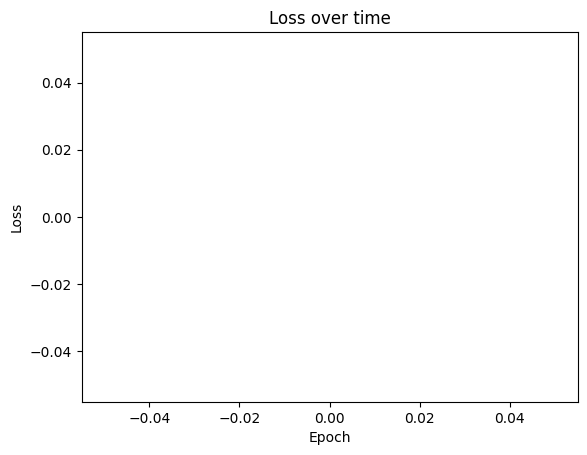

Validation Losses


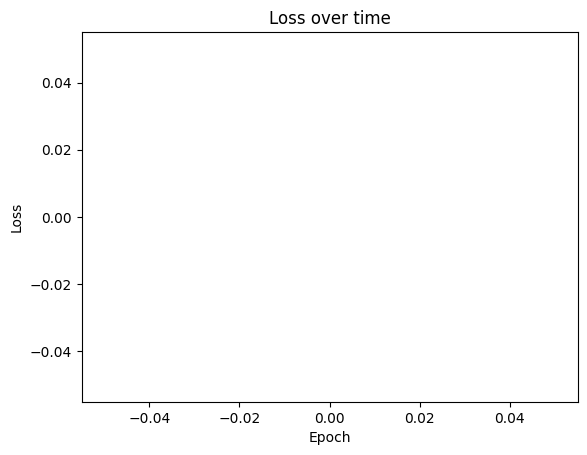

Epoch 0: Training Loss 561697.7855518523, Validation Loss 563468.8880037564
Epoch 1: Training Loss 2140542512.6047847, Validation Loss 2140431788.108689
Epoch 2: Training Loss 8359409050.927912, Validation Loss 8359627796.580023
Epoch 3: Training Loss 124230675827053.47, Validation Loss 124230649157842.84
Epoch 4: Training Loss 189049274192604.2, Validation Loss 189049307091596.44
Epoch 5: Training Loss 4.73383065752412e+18, Validation Loss 4.73383065231815e+18
Epoch 6: Training Loss 5.407260173006657e+18, Validation Loss 5.407260178570617e+18
Epoch 7: Training Loss 1.6208710955660825e+23, Validation Loss 1.620871095556449e+23
Epoch 8: Training Loss 1.6908244178002425e+23, Validation Loss 1.6908244178100817e+23
Epoch 9: Training Loss 5.375866167845565e+27, Validation Loss 5.37586616784539e+27
Epoch 10: Training Loss 5.448530345549637e+27, Validation Loss 5.448530345549815e+27
Epoch 11: Training Loss 1.765382082742141e+32, Validation Loss 1.7653820827421405e+32
Epoch 12: Training Loss 1

Epoch 298: Training Loss nan, Validation Loss nan
Epoch 299: Training Loss nan, Validation Loss nan
Epoch 300: Training Loss nan, Validation Loss nan
Epoch 301: Training Loss nan, Validation Loss nan
Epoch 302: Training Loss nan, Validation Loss nan
Epoch 303: Training Loss nan, Validation Loss nan
Epoch 304: Training Loss nan, Validation Loss nan
Epoch 305: Training Loss nan, Validation Loss nan
Epoch 306: Training Loss nan, Validation Loss nan
Epoch 307: Training Loss nan, Validation Loss nan
Epoch 308: Training Loss nan, Validation Loss nan
Epoch 309: Training Loss nan, Validation Loss nan
Epoch 310: Training Loss nan, Validation Loss nan
Epoch 311: Training Loss nan, Validation Loss nan
Epoch 312: Training Loss nan, Validation Loss nan
Epoch 313: Training Loss nan, Validation Loss nan
Epoch 314: Training Loss nan, Validation Loss nan
Epoch 315: Training Loss nan, Validation Loss nan
Epoch 316: Training Loss nan, Validation Loss nan
Epoch 317: Training Loss nan, Validation Loss nan


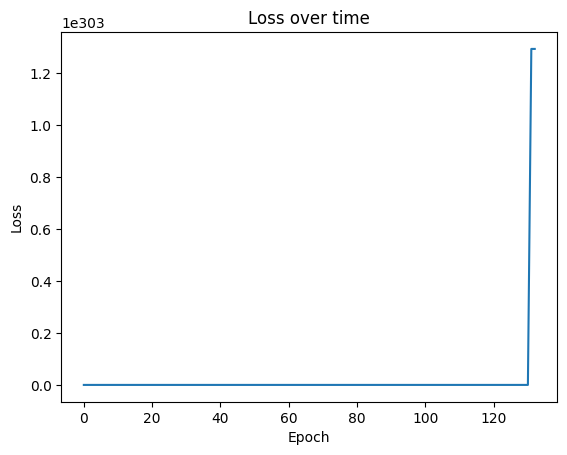

Validation Losses


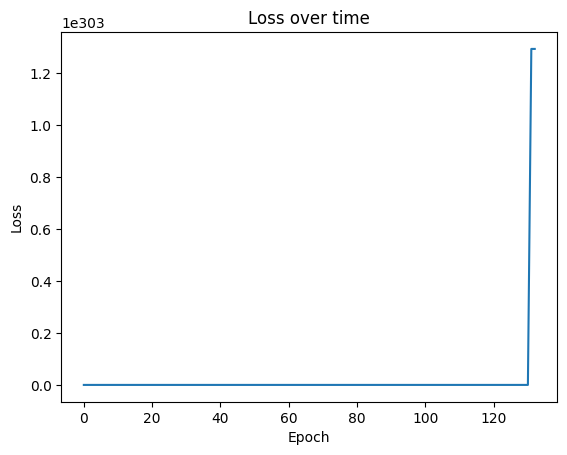

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 169: Training Loss nan, Validation Loss nan
Epoch 170: Training Loss nan, Validation Loss nan
Epoch 171: Training Loss nan, Validation Loss nan
Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan
Epoch 187: Training Loss nan, Validation Loss nan
Epoch 188: Training Loss nan, Validation Loss nan


Epoch 335: Training Loss nan, Validation Loss nan
Epoch 336: Training Loss nan, Validation Loss nan
Epoch 337: Training Loss nan, Validation Loss nan
Epoch 338: Training Loss nan, Validation Loss nan
Epoch 339: Training Loss nan, Validation Loss nan
Epoch 340: Training Loss nan, Validation Loss nan
Epoch 341: Training Loss nan, Validation Loss nan
Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan
Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan


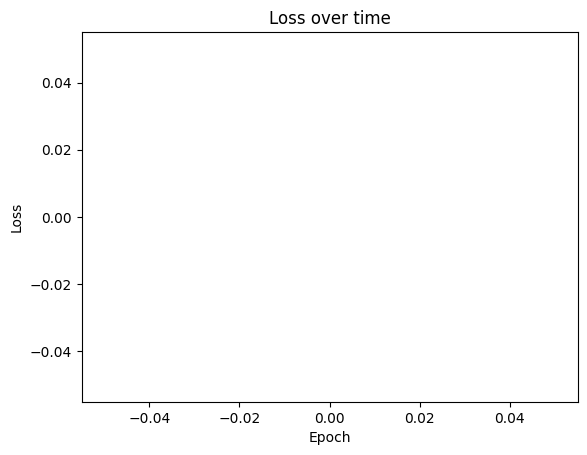

Validation Losses


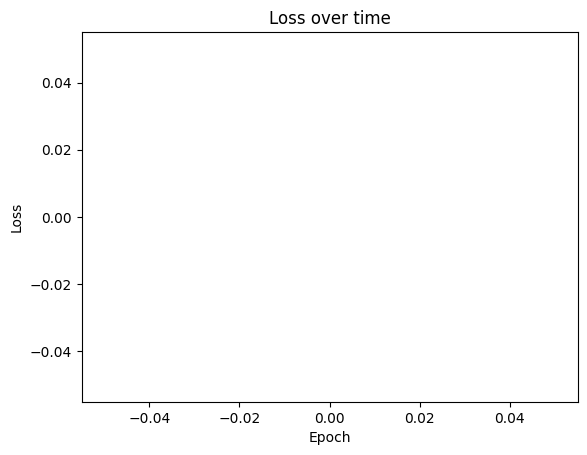

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 196: Training Loss nan, Validation Loss nan
Epoch 197: Training Loss nan, Validation Loss nan
Epoch 198: Training Loss nan, Validation Loss nan
Epoch 199: Training Loss nan, Validation Loss nan
Epoch 200: Training Loss nan, Validation Loss nan
Epoch 201: Training Loss nan, Validation Loss nan
Epoch 202: Training Loss nan, Validation Loss nan
Epoch 203: Training Loss nan, Validation Loss nan
Epoch 204: Training Loss nan, Validation Loss nan
Epoch 205: Training Loss nan, Validation Loss nan
Epoch 206: Training Loss nan, Validation Loss nan
Epoch 207: Training Loss nan, Validation Loss nan
Epoch 208: Training Loss nan, Validation Loss nan
Epoch 209: Training Loss nan, Validation Loss nan
Epoch 210: Training Loss nan, Validation Loss nan
Epoch 211: Training Loss nan, Validation Loss nan
Epoch 212: Training Loss nan, Validation Loss nan
Epoch 213: Training Loss nan, Validation Loss nan
Epoch 214: Training Loss nan, Validation Loss nan
Epoch 215: Training Loss nan, Validation Loss nan


Epoch 377: Training Loss nan, Validation Loss nan
Epoch 378: Training Loss nan, Validation Loss nan
Epoch 379: Training Loss nan, Validation Loss nan
Epoch 380: Training Loss nan, Validation Loss nan
Epoch 381: Training Loss nan, Validation Loss nan
Epoch 382: Training Loss nan, Validation Loss nan
Epoch 383: Training Loss nan, Validation Loss nan
Epoch 384: Training Loss nan, Validation Loss nan
Epoch 385: Training Loss nan, Validation Loss nan
Epoch 386: Training Loss nan, Validation Loss nan
Epoch 387: Training Loss nan, Validation Loss nan
Epoch 388: Training Loss nan, Validation Loss nan
Epoch 389: Training Loss nan, Validation Loss nan
Epoch 390: Training Loss nan, Validation Loss nan
Epoch 391: Training Loss nan, Validation Loss nan
Epoch 392: Training Loss nan, Validation Loss nan
Epoch 393: Training Loss nan, Validation Loss nan
Epoch 394: Training Loss nan, Validation Loss nan
Epoch 395: Training Loss nan, Validation Loss nan
Epoch 396: Training Loss nan, Validation Loss nan


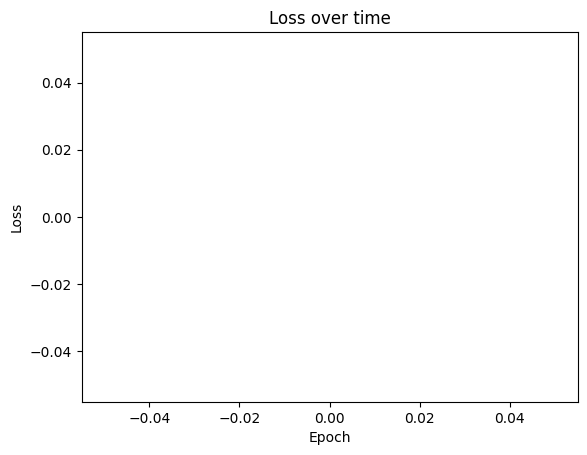

Validation Losses


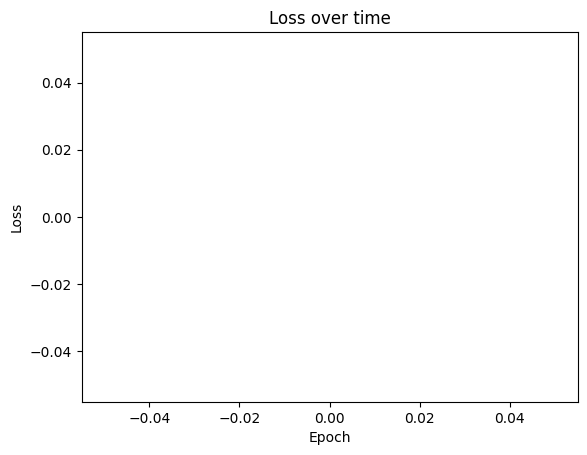

Epoch 0: Training Loss 8425188199.437759, Validation Loss 8712957107.388258
Epoch 1: Training Loss 7580852917013.39, Validation Loss 7580846328978.876
Epoch 2: Training Loss 6508086420650313.0, Validation Loss 6508086613679056.0
Epoch 3: Training Loss 5.58712711126401e+18, Validation Loss 5.587127105608268e+18
Epoch 4: Training Loss 4.796492753749041e+21, Validation Loss 4.796492753914753e+21
Epoch 5: Training Loss 4.1177410641660135e+24, Validation Loss 4.1177410641611586e+24
Epoch 6: Training Loss 3.535039526175881e+27, Validation Loss 3.535039526176024e+27
Epoch 7: Training Loss 3.034796082826733e+30, Validation Loss 3.034796082826729e+30
Epoch 8: Training Loss 2.605342089145924e+33, Validation Loss 2.605342089145923e+33
Epoch 9: Training Loss 2.236660130110885e+36, Validation Loss 2.236660130110885e+36
Epoch 10: Training Loss 1.9201503550988934e+39, Validation Loss 1.920150355098893e+39
Epoch 11: Training Loss 1.6484298783488485e+42, Validation Loss 1.6484298783488485e+42
Epoch 12:

Epoch 175: Training Loss inf, Validation Loss inf
Epoch 176: Training Loss inf, Validation Loss inf
Epoch 177: Training Loss inf, Validation Loss inf
Epoch 178: Training Loss inf, Validation Loss inf
Epoch 179: Training Loss inf, Validation Loss inf
Epoch 180: Training Loss inf, Validation Loss inf
Epoch 181: Training Loss inf, Validation Loss inf
Epoch 182: Training Loss inf, Validation Loss inf
Epoch 183: Training Loss inf, Validation Loss inf
Epoch 184: Training Loss inf, Validation Loss inf
Epoch 185: Training Loss inf, Validation Loss inf
Epoch 186: Training Loss inf, Validation Loss inf
Epoch 187: Training Loss inf, Validation Loss inf
Epoch 188: Training Loss inf, Validation Loss inf
Epoch 189: Training Loss inf, Validation Loss inf
Epoch 190: Training Loss inf, Validation Loss inf
Epoch 191: Training Loss inf, Validation Loss inf
Epoch 192: Training Loss inf, Validation Loss inf
Epoch 193: Training Loss inf, Validation Loss inf
Epoch 194: Training Loss inf, Validation Loss inf


Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan
Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan
Epoch 355: Training Loss nan, Validation Loss nan
Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan
Epoch 358: Training Loss nan, Validation Loss nan
Epoch 359: Training Loss nan, Validation Loss nan
Epoch 360: Training Loss nan, Validation Loss nan
Epoch 361: Training Loss nan, Validation Loss nan


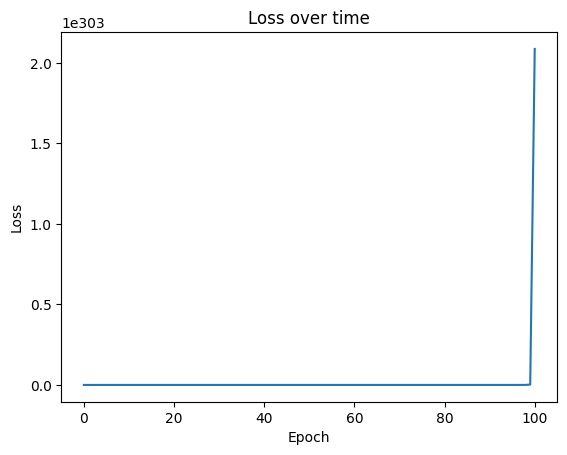

Validation Losses


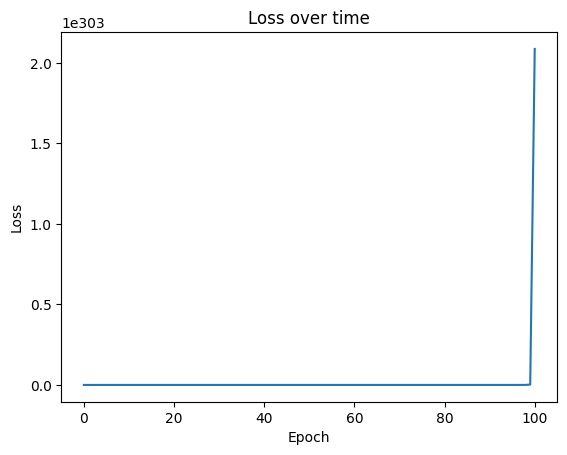

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan
Epoch 187: Training Loss nan, Validation Loss nan
Epoch 188: Training Loss nan, Validation Loss nan
Epoch 189: Training Loss nan, Validation Loss nan
Epoch 190: Training Loss nan, Validation Loss nan
Epoch 191: Training Loss nan, Validation Loss nan


Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan
Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan
Epoch 355: Training Loss nan, Validation Loss nan
Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan
Epoch 358: Training Loss nan, Validation Loss nan
Epoch 359: Training Loss nan, Validation Loss nan
Epoch 360: Training Loss nan, Validation Loss nan
Epoch 361: Training Loss nan, Validation Loss nan


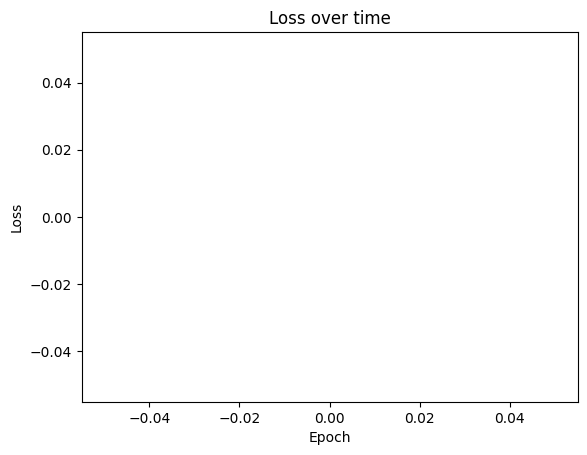

Validation Losses


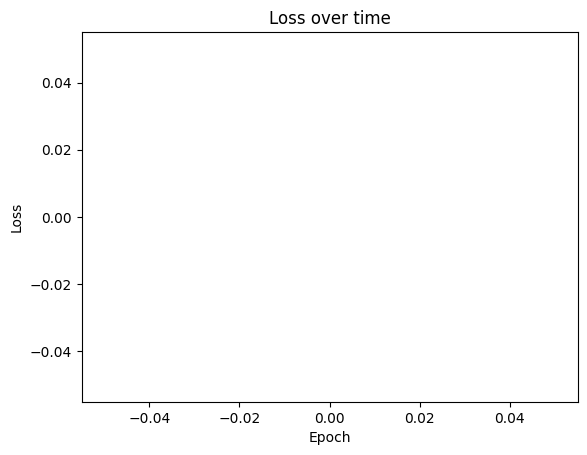

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 275: Training Loss nan, Validation Loss nan
Epoch 276: Training Loss nan, Validation Loss nan
Epoch 277: Training Loss nan, Validation Loss nan
Epoch 278: Training Loss nan, Validation Loss nan
Epoch 279: Training Loss nan, Validation Loss nan
Epoch 280: Training Loss nan, Validation Loss nan
Epoch 281: Training Loss nan, Validation Loss nan
Epoch 282: Training Loss nan, Validation Loss nan
Epoch 283: Training Loss nan, Validation Loss nan
Epoch 284: Training Loss nan, Validation Loss nan
Epoch 285: Training Loss nan, Validation Loss nan
Epoch 286: Training Loss nan, Validation Loss nan
Epoch 287: Training Loss nan, Validation Loss nan
Epoch 288: Training Loss nan, Validation Loss nan
Epoch 289: Training Loss nan, Validation Loss nan
Epoch 290: Training Loss nan, Validation Loss nan
Epoch 291: Training Loss nan, Validation Loss nan
Epoch 292: Training Loss nan, Validation Loss nan
Epoch 293: Training Loss nan, Validation Loss nan
Epoch 294: Training Loss nan, Validation Loss nan


Epoch 456: Training Loss nan, Validation Loss nan
Epoch 457: Training Loss nan, Validation Loss nan
Epoch 458: Training Loss nan, Validation Loss nan
Epoch 459: Training Loss nan, Validation Loss nan
Epoch 460: Training Loss nan, Validation Loss nan
Epoch 461: Training Loss nan, Validation Loss nan
Epoch 462: Training Loss nan, Validation Loss nan
Epoch 463: Training Loss nan, Validation Loss nan
Epoch 464: Training Loss nan, Validation Loss nan
Epoch 465: Training Loss nan, Validation Loss nan
Epoch 466: Training Loss nan, Validation Loss nan
Epoch 467: Training Loss nan, Validation Loss nan
Epoch 468: Training Loss nan, Validation Loss nan
Epoch 469: Training Loss nan, Validation Loss nan
Epoch 470: Training Loss nan, Validation Loss nan
Epoch 471: Training Loss nan, Validation Loss nan
Epoch 472: Training Loss nan, Validation Loss nan
Epoch 473: Training Loss nan, Validation Loss nan
Epoch 474: Training Loss nan, Validation Loss nan
Epoch 475: Training Loss nan, Validation Loss nan


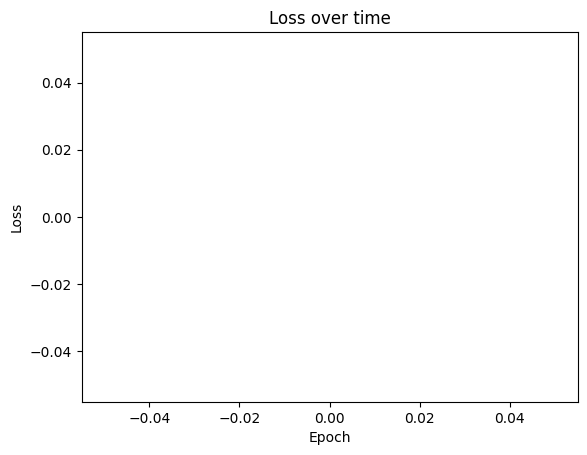

Validation Losses


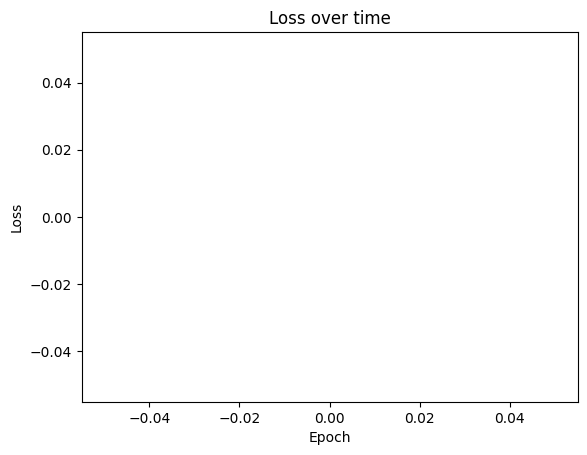

Epoch 0: Training Loss 230477370582.66394, Validation Loss 237082277917.9272
Epoch 1: Training Loss 208278329177831.56, Validation Loss 208278294646152.3
Epoch 2: Training Loss 1.7880486281580013e+17, Validation Loss 1.7880486382757763e+17
Epoch 3: Training Loss 1.5350218667873613e+20, Validation Loss 1.5350218664909108e+20
Epoch 4: Training Loss 1.3178009224182819e+23, Validation Loss 1.3178009224269681e+23
Epoch 5: Training Loss 1.1313189138868712e+26, Validation Loss 1.1313189138866167e+26
Epoch 6: Training Loss 9.712259743827403e+28, Validation Loss 9.712259743827477e+28
Epoch 7: Training Loss 8.337877867478392e+31, Validation Loss 8.337877867478392e+31
Epoch 8: Training Loss 7.157984770451524e+34, Validation Loss 7.157984770451526e+34
Epoch 9: Training Loss 6.145058345584925e+37, Validation Loss 6.145058345584922e+37
Epoch 10: Training Loss 5.275471139101204e+40, Validation Loss 5.275471139101203e+40
Epoch 11: Training Loss 4.528939218206995e+43, Validation Loss 4.528939218206995e

Epoch 296: Training Loss nan, Validation Loss nan
Epoch 297: Training Loss nan, Validation Loss nan
Epoch 298: Training Loss nan, Validation Loss nan
Epoch 299: Training Loss nan, Validation Loss nan
Epoch 300: Training Loss nan, Validation Loss nan
Epoch 301: Training Loss nan, Validation Loss nan
Epoch 302: Training Loss nan, Validation Loss nan
Epoch 303: Training Loss nan, Validation Loss nan
Epoch 304: Training Loss nan, Validation Loss nan
Epoch 305: Training Loss nan, Validation Loss nan
Epoch 306: Training Loss nan, Validation Loss nan
Epoch 307: Training Loss nan, Validation Loss nan
Epoch 308: Training Loss nan, Validation Loss nan
Epoch 309: Training Loss nan, Validation Loss nan
Epoch 310: Training Loss nan, Validation Loss nan
Epoch 311: Training Loss nan, Validation Loss nan
Epoch 312: Training Loss nan, Validation Loss nan
Epoch 313: Training Loss nan, Validation Loss nan
Epoch 314: Training Loss nan, Validation Loss nan
Epoch 315: Training Loss nan, Validation Loss nan


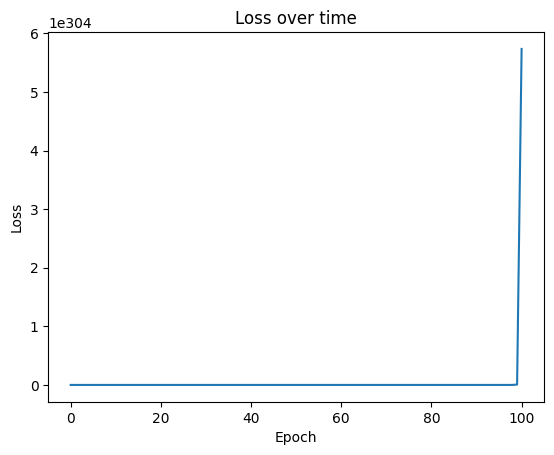

Validation Losses


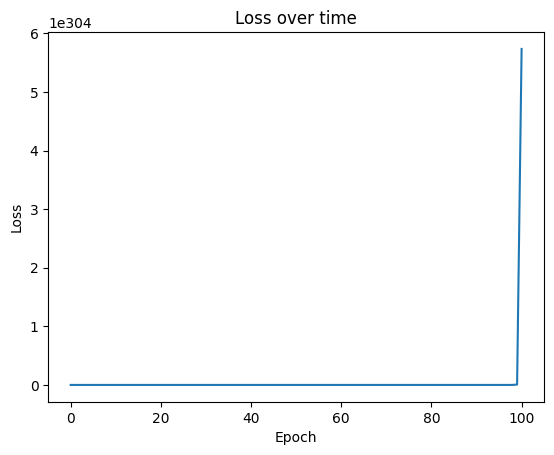

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 167: Training Loss nan, Validation Loss nan
Epoch 168: Training Loss nan, Validation Loss nan
Epoch 169: Training Loss nan, Validation Loss nan
Epoch 170: Training Loss nan, Validation Loss nan
Epoch 171: Training Loss nan, Validation Loss nan
Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan


Epoch 333: Training Loss nan, Validation Loss nan
Epoch 334: Training Loss nan, Validation Loss nan
Epoch 335: Training Loss nan, Validation Loss nan
Epoch 336: Training Loss nan, Validation Loss nan
Epoch 337: Training Loss nan, Validation Loss nan
Epoch 338: Training Loss nan, Validation Loss nan
Epoch 339: Training Loss nan, Validation Loss nan
Epoch 340: Training Loss nan, Validation Loss nan
Epoch 341: Training Loss nan, Validation Loss nan
Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan


Epoch 497: Training Loss nan, Validation Loss nan
Epoch 498: Training Loss nan, Validation Loss nan
Epoch 499: Training Loss nan, Validation Loss nan

Train Losses


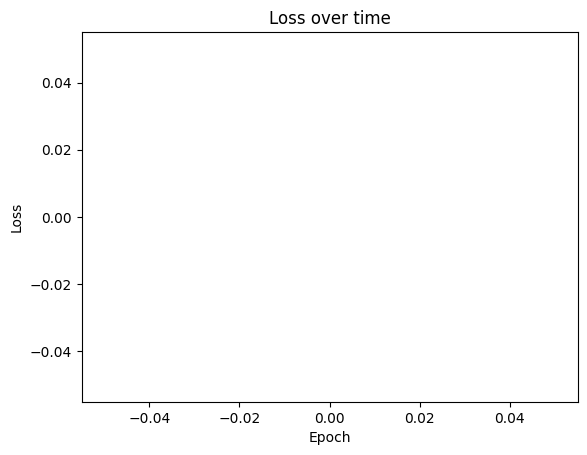

Validation Losses


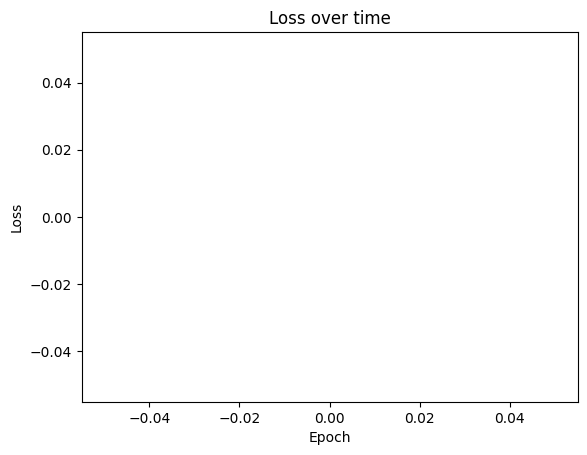

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan
Epoch 187: Training Loss nan, Validation Loss nan
Epoch 188: Training Loss nan, Validation Loss nan
Epoch 189: Training Loss nan, Validation Loss nan
Epoch 190: Training Loss nan, Validation Loss nan
Epoch 191: Training Loss nan, Validation Loss nan
Epoch 192: Training Loss nan, Validation Loss nan
Epoch 193: Training Loss nan, Validation Loss nan
Epoch 194: Training Loss nan, Validation Loss nan
Epoch 195: Training Loss nan, Validation Loss nan
Epoch 196: Training Loss nan, Validation Loss nan


Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan
Epoch 358: Training Loss nan, Validation Loss nan
Epoch 359: Training Loss nan, Validation Loss nan
Epoch 360: Training Loss nan, Validation Loss nan
Epoch 361: Training Loss nan, Validation Loss nan
Epoch 362: Training Loss nan, Validation Loss nan
Epoch 363: Training Loss nan, Validation Loss nan
Epoch 364: Training Loss nan, Validation Loss nan
Epoch 365: Training Loss nan, Validation Loss nan
Epoch 366: Training Loss nan, Validation Loss nan
Epoch 367: Training Loss nan, Validation Loss nan
Epoch 368: Training Loss nan, Validation Loss nan
Epoch 369: Training Loss nan, Validation Loss nan
Epoch 370: Training Loss nan, Validation Loss nan
Epoch 371: Training Loss nan, Validation Loss nan
Epoch 372: Training Loss nan, Validation Loss nan
Epoch 373: Training Loss nan, Validation Loss nan
Epoch 374: Training Loss nan, Validation Loss nan
Epoch 375: Training Loss nan, Validation Loss nan


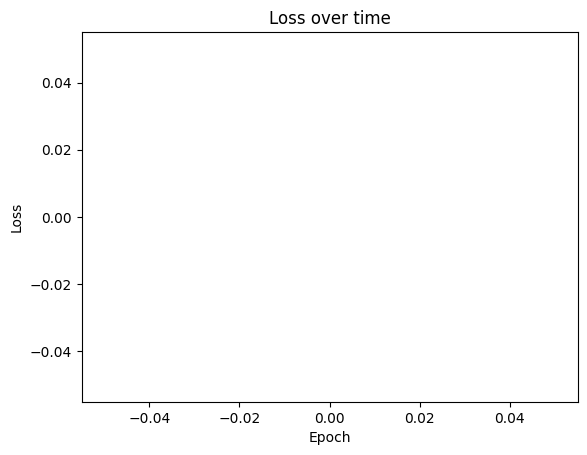

Validation Losses


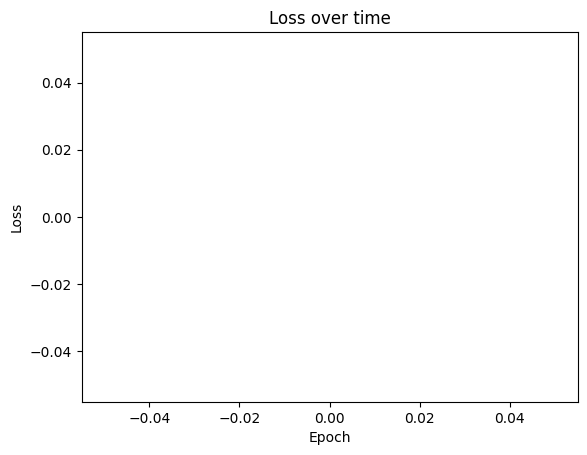

Epoch 0: Training Loss 17825.935515965066, Validation Loss 18130.839625244724
Epoch 1: Training Loss 517780.14397470234, Validation Loss 516036.5208810468
Epoch 2: Training Loss 13254840.395907694, Validation Loss 13263529.630301526
Epoch 3: Training Loss 339369436.26229846, Validation Loss 339325335.2378056
Epoch 4: Training Loss 8689077102.98703, Validation Loss 8689300120.672504
Epoch 5: Training Loss 222471652318.74, Validation Loss 222470523715.75305
Epoch 6: Training Loss 5696075195112.795, Validation Loss 5696080905710.409
Epoch 7: Training Loss 145840030863394.97, Validation Loss 145840001967637.53
Epoch 8: Training Loss 3734029814211827.5, Validation Loss 3734029960424227.0
Epoch 9: Training Loss 9.560460575115171e+16, Validation Loss 9.560460501131686e+16
Epoch 10: Training Loss 2.4478220838101837e+18, Validation Loss 2.447822087553748e+18
Epoch 11: Training Loss 6.2673057505042285e+19, Validation Loss 6.267305748609984e+19
Epoch 12: Training Loss 1.6046558951361007e+21, Vali

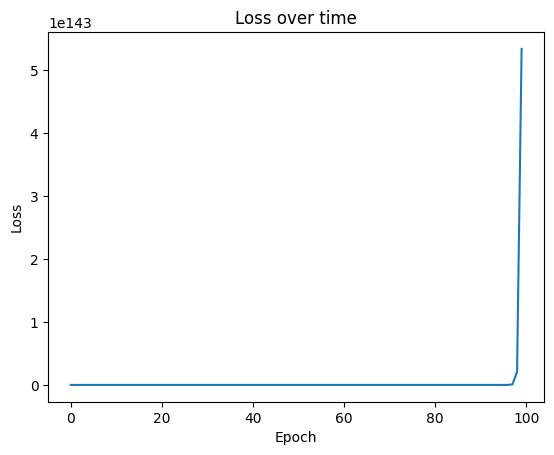

Validation Losses


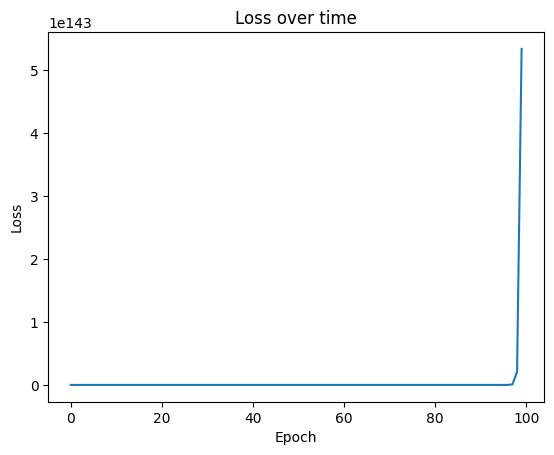

Epoch 0: Training Loss 2.573793594683739e+138, Validation Loss 2.573793594683739e+138
Epoch 1: Training Loss 1.2404394946204035e+133, Validation Loss 1.2404394946204035e+133
Epoch 2: Training Loss 5.978296561901198e+127, Validation Loss 5.978296561901197e+127
Epoch 3: Training Loss 2.881239265360291e+122, Validation Loss 2.881239265360291e+122
Epoch 4: Training Loss 1.3886128963822892e+117, Validation Loss 1.3886128963822892e+117
Epoch 5: Training Loss 6.692418082668789e+111, Validation Loss 6.692418082668792e+111
Epoch 6: Training Loss 3.225410041139879e+106, Validation Loss 3.225410041139878e+106
Epoch 7: Training Loss 1.554485948306355e+101, Validation Loss 1.554485948306355e+101
Epoch 8: Training Loss 7.491848382892098e+95, Validation Loss 7.491848382892098e+95
Epoch 9: Training Loss 3.611678388608627e+90, Validation Loss 3.611678388608627e+90
Epoch 10: Training Loss 2.79744320480505e+86, Validation Loss 2.79744320480505e+86
Epoch 11: Training Loss 2.79744320480505e+86, Validation 

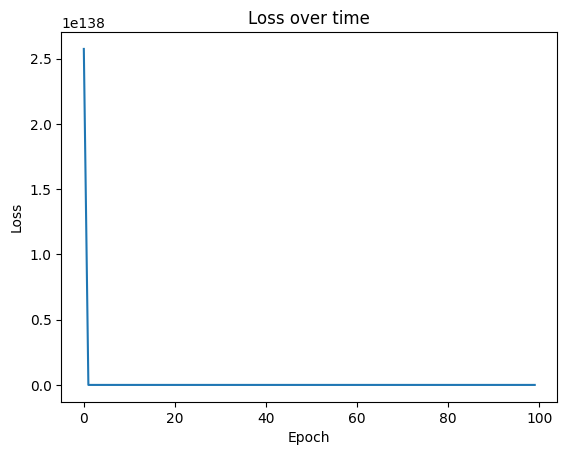

Validation Losses


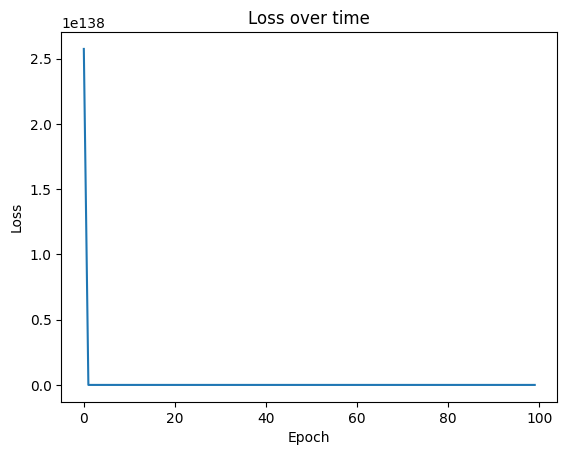

Epoch 0: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 1: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 2: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 3: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 4: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 5: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 6: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 7: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 8: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 9: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 10: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 11: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 12: Training Loss 623.9503630363037, Validation Loss 546.5909900990099
Epoch 13:

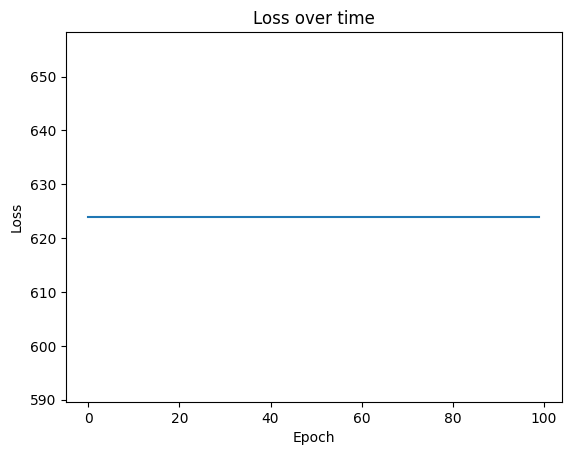

Validation Losses


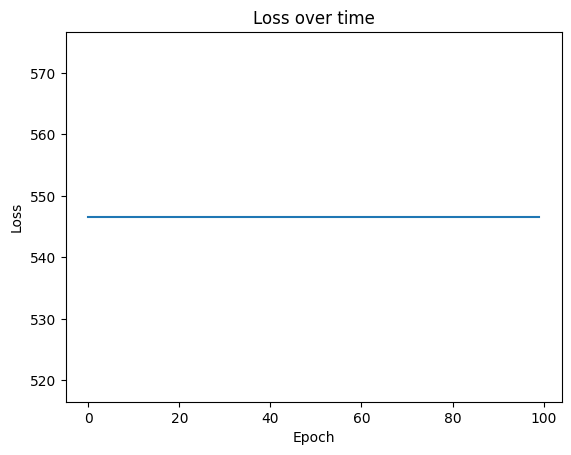

Epoch 0: Training Loss 19740.097294026014, Validation Loss 20053.256771873886
Epoch 1: Training Loss 2429994.433657616, Validation Loss 2426244.8536835564
Epoch 2: Training Loss 169194715.98622307, Validation Loss 169225817.48229077
Epoch 3: Training Loss 11073466902.932486, Validation Loss 11073215093.95248
Epoch 4: Training Loss 322116007574.60345, Validation Loss 322117365557.34644
Epoch 5: Training Loss 8247329409368.325, Validation Loss 8247322537838.484
Epoch 6: Training Loss 211161323263489.53, Validation Loss 211161358033300.6
Epoch 7: Training Loss 1351622213203897.2, Validation Loss 1351622125236215.2
Epoch 8: Training Loss 5569899978391660.0, Validation Loss 5569900156965987.0
Epoch 9: Training Loss 2.295300082095392e+16, Validation Loss 2.295300045844797e+16
Epoch 10: Training Loss 9.458702108306875e+16, Validation Loss 9.458702181895576e+16
Epoch 11: Training Loss 3.897836551812176e+17, Validation Loss 3.89783653687367e+17
Epoch 12: Training Loss 1.6062594646362798e+18, Va

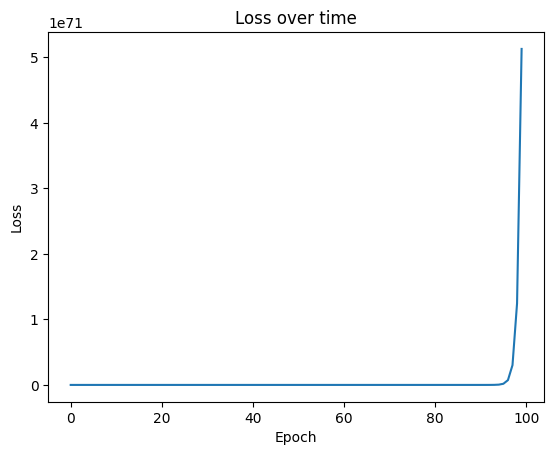

Validation Losses


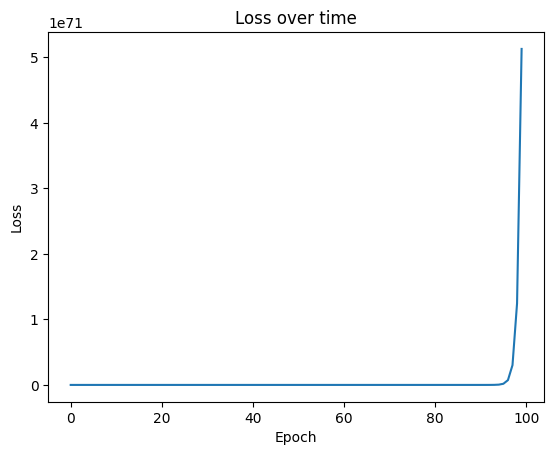

Epoch 0: Training Loss 1.1615936325457165e+69, Validation Loss 1.1615936325457157e+69
Epoch 1: Training Loss 2.6301598799822614e+66, Validation Loss 2.6301598799822618e+66
Epoch 2: Training Loss 5.955388184340857e+63, Validation Loss 5.955388184340857e+63
Epoch 3: Training Loss 1.348459791213371e+61, Validation Loss 1.348459791213371e+61
Epoch 4: Training Loss 3.053275038057764e+58, Validation Loss 3.053275038057764e+58
Epoch 5: Training Loss 6.913434511560845e+55, Validation Loss 6.913434511560843e+55
Epoch 6: Training Loss 1.5653872039003717e+53, Validation Loss 1.5653872039003715e+53
Epoch 7: Training Loss 3.5444569468870168e+50, Validation Loss 3.5444569468870164e+50
Epoch 8: Training Loss 8.025602238879179e+47, Validation Loss 8.025602238879178e+47
Epoch 9: Training Loss 1.817211839835492e+45, Validation Loss 1.8172118398354916e+45
Epoch 10: Training Loss 4.1146555392950286e+42, Validation Loss 4.1146555392950286e+42
Epoch 11: Training Loss 9.31668495434412e+39, Validation Loss 9.

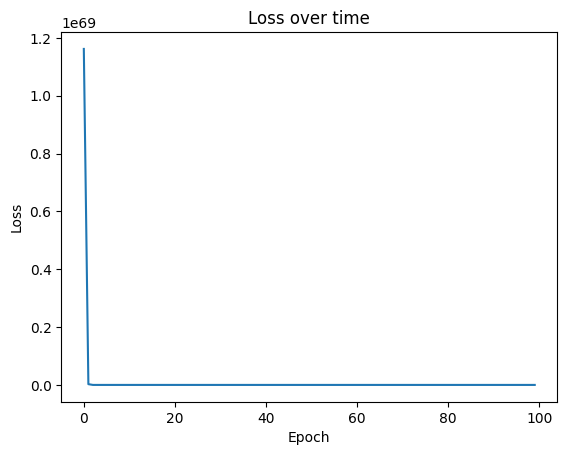

Validation Losses


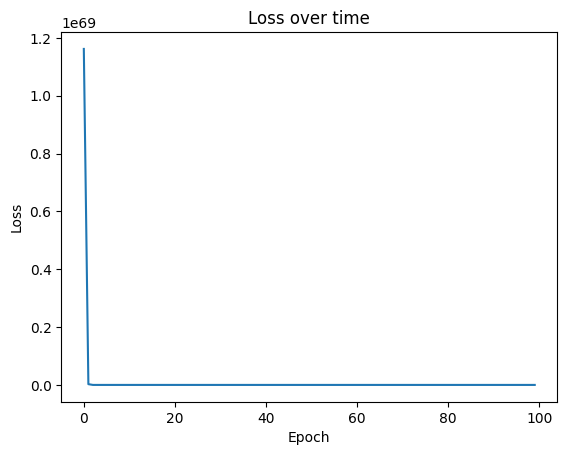

Epoch 0: Training Loss 89.22694275997551, Validation Loss 67.2337401360789
Epoch 1: Training Loss 89.36471116563249, Validation Loss 66.4464059461724
Epoch 2: Training Loss 89.45605751135136, Validation Loss 66.28072827508127
Epoch 3: Training Loss 89.72212277331366, Validation Loss 66.00853644920393
Epoch 4: Training Loss 89.28277027795609, Validation Loss 67.81983493843741
Epoch 5: Training Loss 90.06813162261633, Validation Loss 65.84385035799883
Epoch 6: Training Loss 89.43836443672222, Validation Loss 68.50970867400049
Epoch 7: Training Loss 89.23061587910047, Validation Loss 67.05169081963683
Epoch 8: Training Loss 89.61666310346631, Validation Loss 69.08138330787055
Epoch 9: Training Loss 89.3823089422713, Validation Loss 66.40902935602917
Epoch 10: Training Loss 90.32931994199203, Validation Loss 65.78737332680709
Epoch 11: Training Loss 89.22974646709659, Validation Loss 67.33207612547194
Epoch 12: Training Loss 89.22682048484559, Validation Loss 67.1725978606658
Epoch 13: Tra

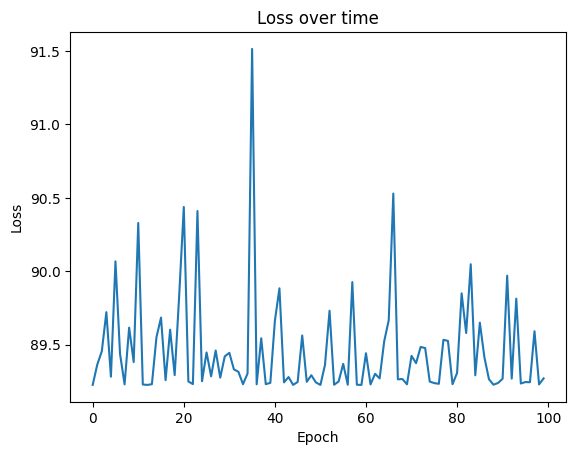

Validation Losses


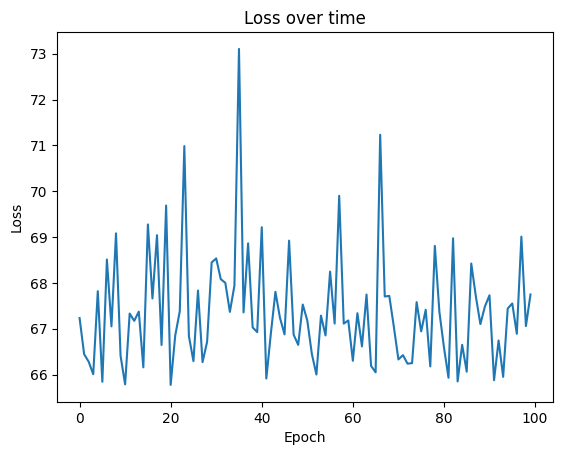

Epoch 0: Training Loss 7711.294144858503, Validation Loss 7898.161488360129
Epoch 1: Training Loss 3507.7666637747943, Validation Loss 3345.837861312276
Epoch 2: Training Loss 786775.5856374659, Validation Loss 788875.8044568608
Epoch 3: Training Loss 19396293.301287558, Validation Loss 19406809.164013293
Epoch 4: Training Loss 283114292.26061636, Validation Loss 283154530.4570025
Epoch 5: Training Loss 2808133017.141467, Validation Loss 2808259790.719597
Epoch 6: Training Loss 17962789154.105312, Validation Loss 17963109819.746506
Epoch 7: Training Loss 49695318170.94089, Validation Loss 49695851549.03927
Epoch 8: Training Loss 19443345692.7715, Validation Loss 19443012028.61908
Epoch 9: Training Loss 2404255234688.195, Validation Loss 2404258944766.5728
Epoch 10: Training Loss 36875350364266.8, Validation Loss 36875364894172.55
Epoch 11: Training Loss 382480235250625.3, Validation Loss 382480282045649.0
Epoch 12: Training Loss 2599954750274687.5, Validation Loss 2599954872279845.5
Ep

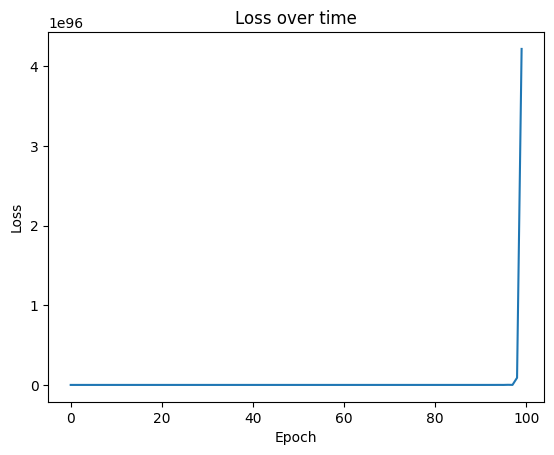

Validation Losses


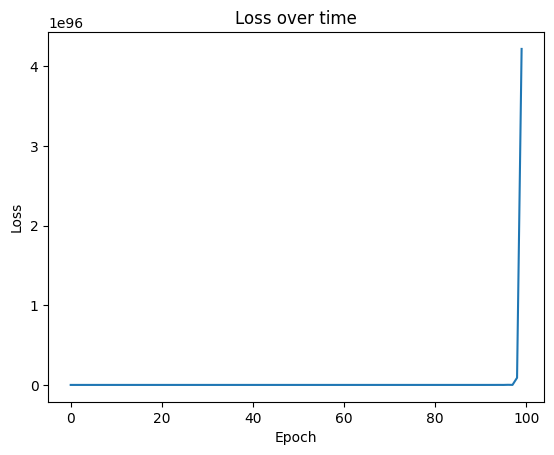

Epoch 0: Training Loss 5.227034572167716e+87, Validation Loss 5.227034572167714e+87
Epoch 1: Training Loss 9.432417599631718e+76, Validation Loss 9.432417599631718e+76
Epoch 2: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 3: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 4: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 5: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 6: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 7: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 8: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 9: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 10: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66
Epoch 11: Training Loss 3.791242500068059e+66, Validation Loss 3.7912425000

Epoch 99: Training Loss 3.791242500068059e+66, Validation Loss 3.791242500068059e+66

Train Losses


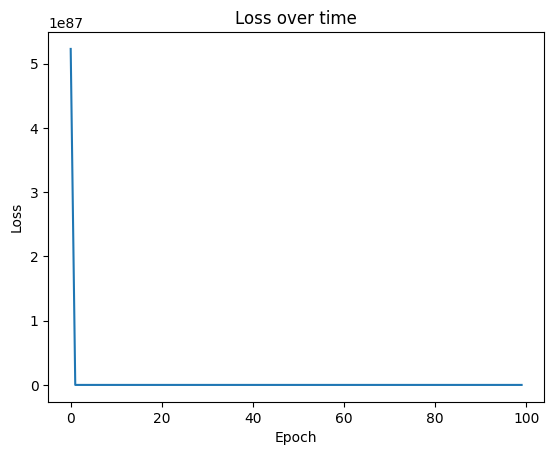

Validation Losses


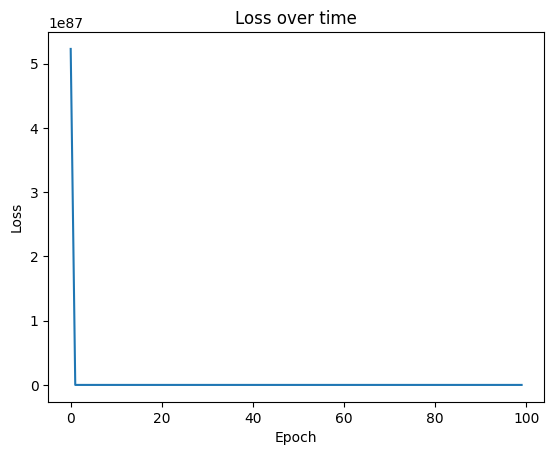

Epoch 0: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 1: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 2: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 3: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 4: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 5: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 6: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 7: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 8: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 9: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 10: Training Loss 6.582018229284824e+63, Validation Loss 6.582018229284824e+63
Epoch 11: Training Loss 6.582018229284824e+63, Validation Loss 6.5820182292

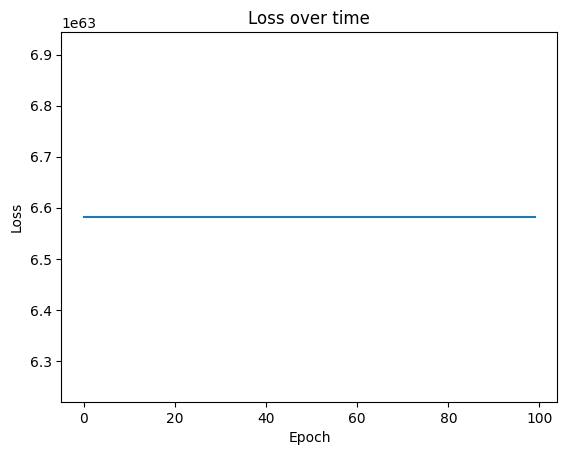

Validation Losses


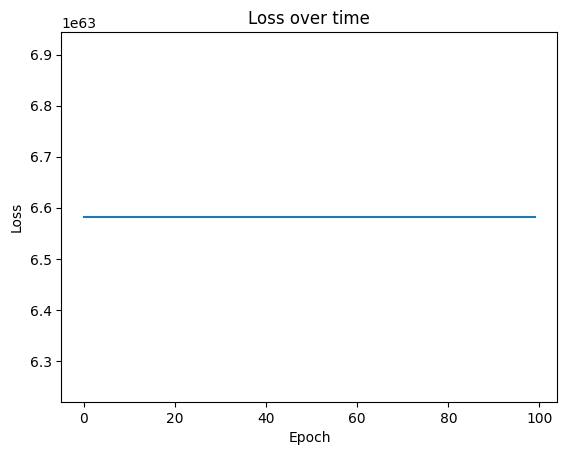

Epoch 0: Training Loss 705.7984628514386, Validation Loss 743.1827681850764
Epoch 1: Training Loss 2653.091847555928, Validation Loss 2509.9069455502467
Epoch 2: Training Loss 459493.8265078158, Validation Loss 461093.5811941602
Epoch 3: Training Loss 382882.5275296431, Validation Loss 381380.1033098508
Epoch 4: Training Loss 133116487.78801294, Validation Loss 133144072.24637355
Epoch 5: Training Loss 16433011919.62177, Validation Loss 16433318625.973135
Epoch 6: Training Loss 1837278766581.172, Validation Loss 1837282009827.6577
Epoch 7: Training Loss 202375650302801.6, Validation Loss 202375684341600.34
Epoch 8: Training Loss 2.22399996359322e+16, Validation Loss 2.2239999992763336e+16
Epoch 9: Training Loss 2.443171732312365e+18, Validation Loss 2.443171736052372e+18
Epoch 10: Training Loss 2.6837905302680378e+20, Validation Loss 2.6837905306600227e+20
Epoch 11: Training Loss 2.94808085465943e+22, Validation Loss 2.9480808547005137e+22
Epoch 12: Training Loss 3.2383930813618495e+24

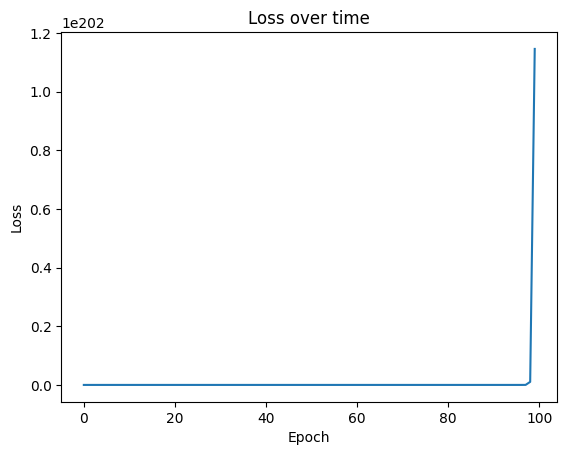

Validation Losses


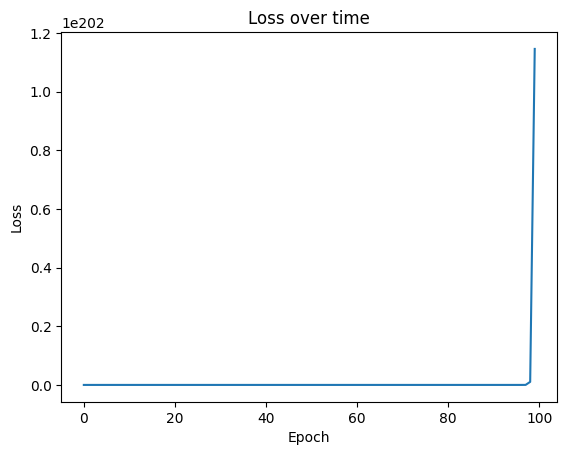

Epoch 0: Training Loss 2.3152800225869576e+184, Validation Loss 2.3152800225869565e+184
Epoch 1: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 2: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 3: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 4: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 5: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 6: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 7: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 8: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 9: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 10: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 11: Training Loss 2.173802356697208e+171, Val

Epoch 98: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171
Epoch 99: Training Loss 2.173802356697208e+171, Validation Loss 2.173802356697208e+171

Train Losses


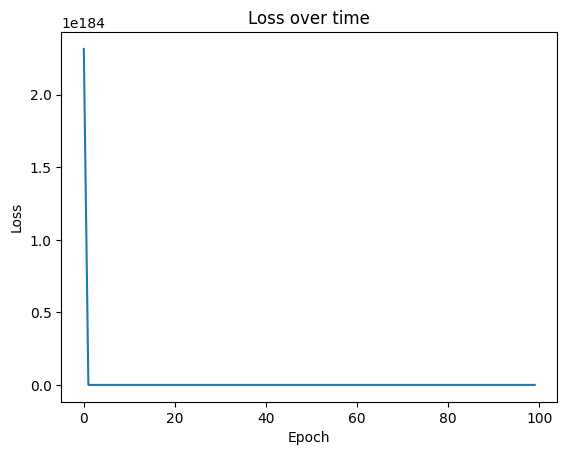

Validation Losses


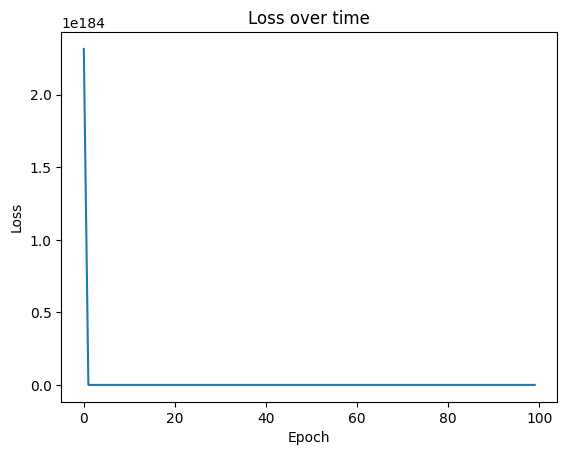

Epoch 0: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 1: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 2: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 3: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 4: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 5: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 6: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 7: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 8: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 9: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 10: Training Loss 6.038339879714466e+169, Validation Loss 6.038339879714466e+169
Epoch 11: Training Loss 6.038339879714466e+169, Valid

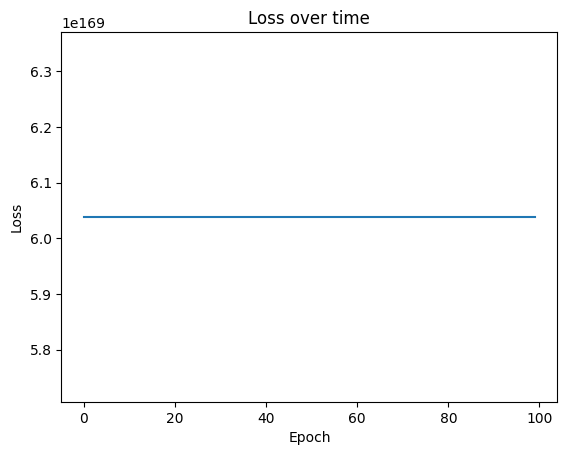

Validation Losses


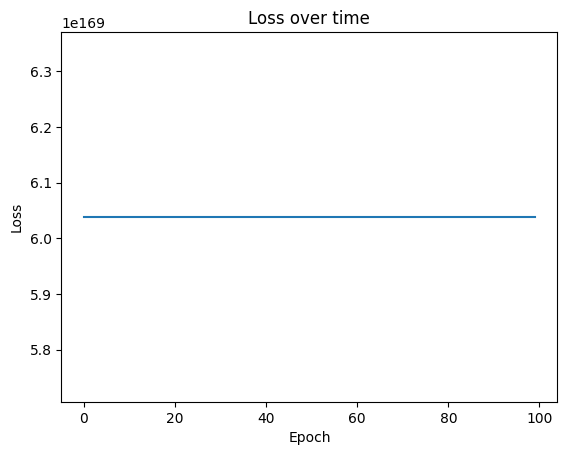

Epoch 0: Training Loss 53530197.32850837, Validation Loss 55228527.075539164
Epoch 1: Training Loss 479956863.27487546, Validation Loss 479904421.3149177
Epoch 2: Training Loss 1977853959.4017842, Validation Loss 1977960349.831269
Epoch 3: Training Loss 8150538102.831171, Validation Loss 8150322063.510085
Epoch 4: Training Loss 33587552189.489326, Validation Loss 33587990682.5619
Epoch 5: Training Loss 138410943539.19888, Validation Loss 138410053331.5123
Epoch 6: Training Loss 570377656952.2168, Validation Loss 570379464007.0713
Epoch 7: Training Loss 2350469286255.9214, Validation Loss 2350465617867.818
Epoch 8: Training Loss 9686048881453.56, Validation Loss 9686056328214.662
Epoch 9: Training Loss 39915238835303.5, Validation Loss 39915223718311.71
Epoch 10: Training Loss 164486707716123.66, Validation Loss 164486738403550.28
Epoch 11: Training Loss 677833273827095.9, Validation Loss 677833211531553.2
Epoch 12: Training Loss 2793283138113801.5, Validation Loss 2793283264573686.5
Ep

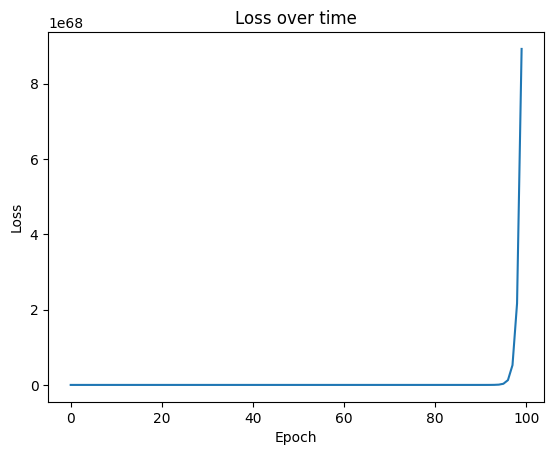

Validation Losses


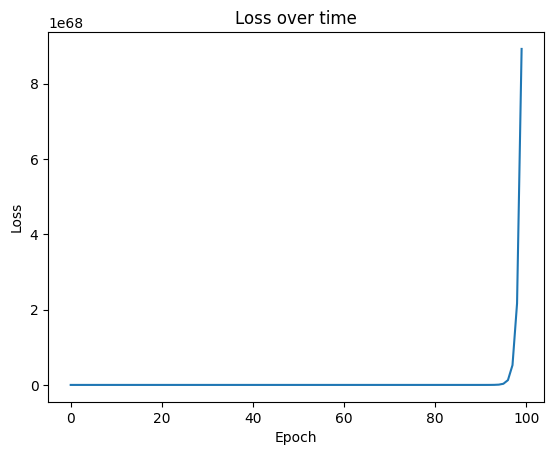

Epoch 0: Training Loss 2.0200098293988246e+66, Validation Loss 2.0200098293988246e+66
Epoch 1: Training Loss 4.573844640324802e+63, Validation Loss 4.573844640324803e+63
Epoch 2: Training Loss 1.0356412374514952e+61, Validation Loss 1.035641237451495e+61
Epoch 3: Training Loss 2.3449698384025135e+58, Validation Loss 2.3449698384025132e+58
Epoch 4: Training Loss 5.309641354711935e+55, Validation Loss 5.309641354711934e+55
Epoch 5: Training Loss 1.2022453702378069e+53, Validation Loss 1.2022453702378069e+53
Epoch 6: Training Loss 2.7222063293890055e+50, Validation Loss 2.7222063293890055e+50
Epoch 7: Training Loss 6.163806060903997e+47, Validation Loss 6.163806060903999e+47
Epoch 8: Training Loss 1.3956511946309454e+45, Validation Loss 1.3956511946309456e+45
Epoch 9: Training Loss 3.1601290466123303e+42, Validation Loss 3.160129046612331e+42
Epoch 10: Training Loss 7.155380677966351e+39, Validation Loss 7.155380677966354e+39
Epoch 11: Training Loss 1.6201703123959528e+37, Validation Loss

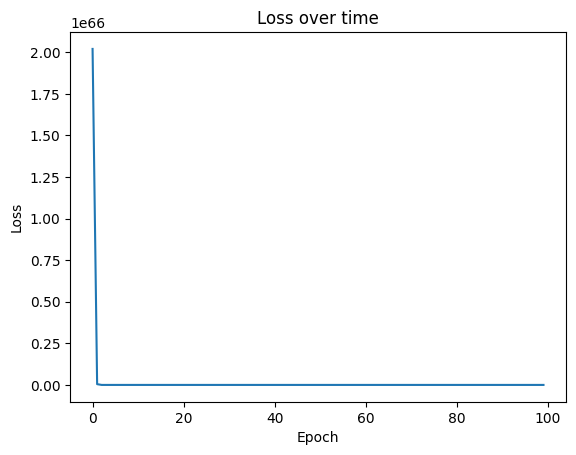

Validation Losses


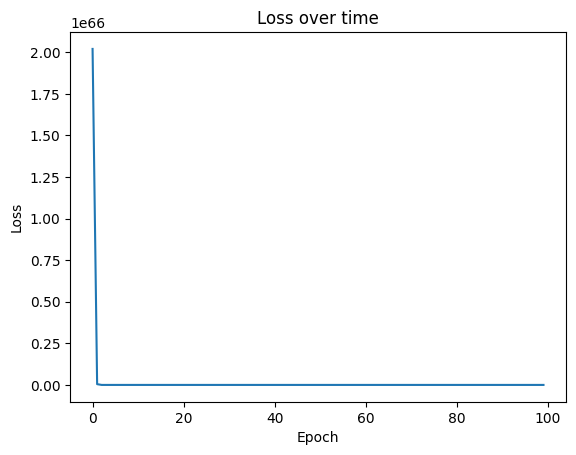

Epoch 0: Training Loss 89.25172797279478, Validation Loss 66.84384270185907
Epoch 1: Training Loss 89.27038054977986, Validation Loss 66.74092781694632
Epoch 2: Training Loss 89.42689778444351, Validation Loss 68.46800791440891
Epoch 3: Training Loss 89.8853778569426, Validation Loss 69.79783199007356
Epoch 4: Training Loss 90.08011191694443, Validation Loss 70.26106549030976
Epoch 5: Training Loss 89.28166815044273, Validation Loss 67.8131360998204
Epoch 6: Training Loss 89.28340132424236, Validation Loss 67.82364574653657
Epoch 7: Training Loss 89.63249031534548, Validation Loss 66.07885146046516
Epoch 8: Training Loss 89.47362088939714, Validation Loss 68.63311934954451
Epoch 9: Training Loss 89.2536072709265, Validation Loss 67.61655296187448
Epoch 10: Training Loss 89.34041449212349, Validation Loss 68.11778797746607
Epoch 11: Training Loss 89.2273260208147, Validation Loss 67.25710583001043
Epoch 12: Training Loss 89.67529083530734, Validation Loss 66.04328254443129
Epoch 13: Tra

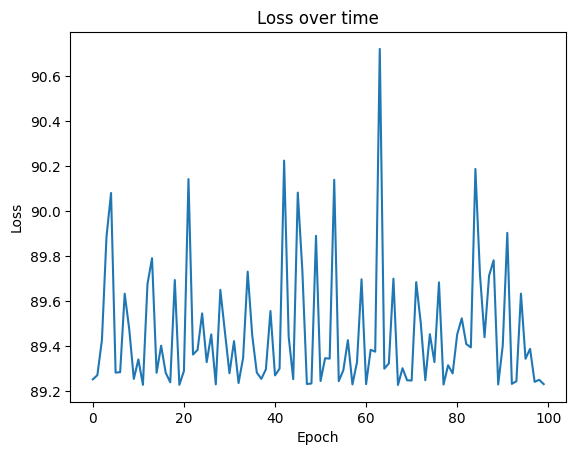

Validation Losses


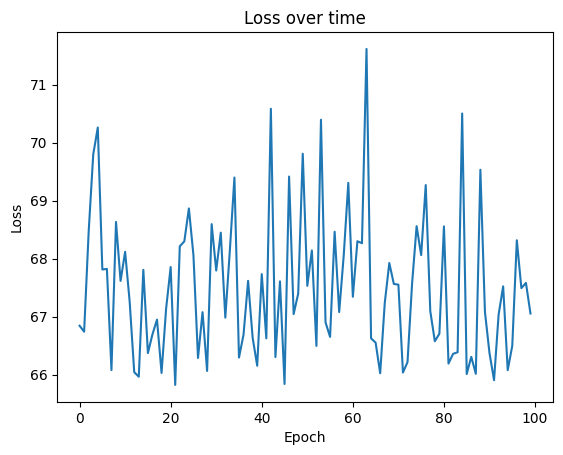

Epoch 0: Training Loss 12844703.558638439, Validation Loss 13115788.992986541
Epoch 1: Training Loss 115911627.43789391, Validation Loss 115885844.64600518
Epoch 2: Training Loss 477659947.0411676, Validation Loss 477712219.3594716
Epoch 3: Training Loss 1968388597.2942975, Validation Loss 1968282417.7389097
Epoch 4: Training Loss 8111532292.122416, Validation Loss 8111747769.870623
Epoch 5: Training Loss 33426813144.139626, Validation Loss 33426375657.56154
Epoch 6: Training Loss 137748554007.21735, Validation Loss 137749442038.22162
Epoch 7: Training Loss 567648015929.8741, Validation Loss 567646213160.1862
Epoch 8: Training Loss 2339220708566.951, Validation Loss 2339224368122.6685
Epoch 9: Training Loss 9639694617655.086, Validation Loss 9639687188690.229
Epoch 10: Training Loss 39724217549616.35, Validation Loss 39724232630348.26
Epoch 11: Training Loss 163699528099935.56, Validation Loss 163699497485983.03
Epoch 12: Training Loss 674589385346746.0, Validation Loss 674589447493002

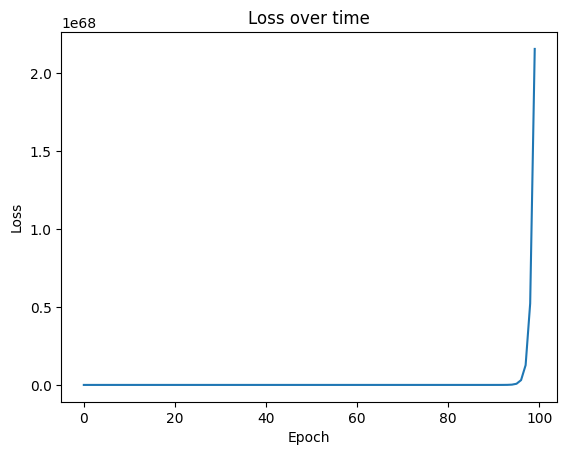

Validation Losses


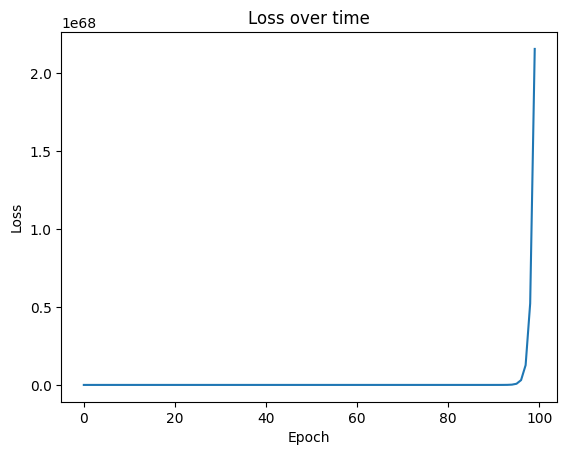

Epoch 0: Training Loss 4.878406956369504e+65, Validation Loss 4.878406956369502e+65
Epoch 1: Training Loss 1.1046023235121792e+63, Validation Loss 1.104602323512179e+63
Epoch 2: Training Loss 2.501116253770953e+60, Validation Loss 2.5011162537709534e+60
Epoch 3: Training Loss 5.663198765495163e+57, Validation Loss 5.663198765495162e+57
Epoch 4: Training Loss 1.2823002612993665e+55, Validation Loss 1.2823002612993668e+55
Epoch 5: Training Loss 2.9034720980425416e+52, Validation Loss 2.9034720980425416e+52
Epoch 6: Training Loss 6.574240432244194e+49, Validation Loss 6.574240432244192e+49
Epoch 7: Training Loss 1.488584556748203e+47, Validation Loss 1.4885845567482024e+47
Epoch 8: Training Loss 3.3705551316942367e+44, Validation Loss 3.370555131694236e+44
Epoch 9: Training Loss 7.631841835446391e+41, Validation Loss 7.631841835446392e+41
Epoch 10: Training Loss 1.7280539117600055e+39, Validation Loss 1.7280539117600055e+39
Epoch 11: Training Loss 3.9127780506137676e+36, Validation Loss 3

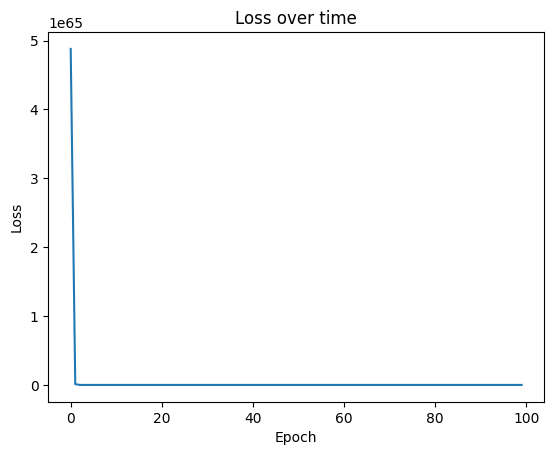

Validation Losses


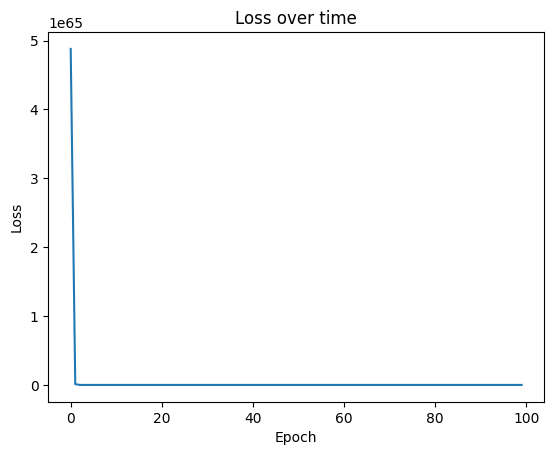

Epoch 0: Training Loss 89.32360489001027, Validation Loss 68.03895395003654
Epoch 1: Training Loss 89.22909709242356, Validation Loss 67.3164719333582
Epoch 2: Training Loss 89.22673485941422, Validation Loss 67.20839981376952
Epoch 3: Training Loss 90.16956757954054, Validation Loss 65.81675250886134
Epoch 4: Training Loss 90.06359600728409, Validation Loss 65.8452382926452
Epoch 5: Training Loss 91.44909919261353, Validation Loss 72.98666681246067
Epoch 6: Training Loss 89.63439970412485, Validation Loss 69.13272268614382
Epoch 7: Training Loss 89.38505312505596, Validation Loss 66.40348692019184
Epoch 8: Training Loss 89.26671211215344, Validation Loss 67.71580409418475
Epoch 9: Training Loss 89.58274710875725, Validation Loss 66.12558494643913
Epoch 10: Training Loss 89.23828068815251, Validation Loss 67.46617539593251
Epoch 11: Training Loss 89.28544044704375, Validation Loss 66.67614262864322
Epoch 12: Training Loss 89.71469321230288, Validation Loss 66.01378293597719
Epoch 13: T

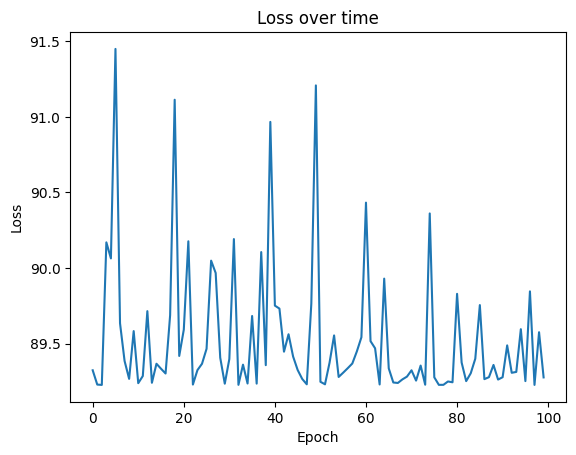

Validation Losses


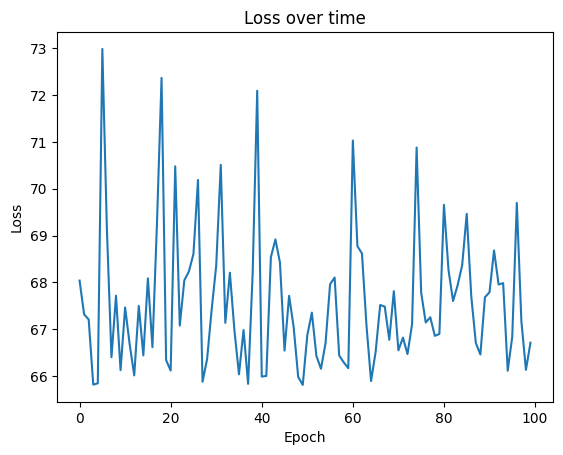

Epoch 0: Training Loss 14047.49880125644, Validation Loss 14308.15994816359
Epoch 1: Training Loss 913631.4837921024, Validation Loss 911322.4961293131
Epoch 2: Training Loss 59789684.520020366, Validation Loss 59808164.70208923
Epoch 3: Training Loss 1755837337.0721314, Validation Loss 1754708692.1833696
Epoch 4: Training Loss 45037267587.67867, Validation Loss 45037775352.94195
Epoch 5: Training Loss 1153111105918.4521, Validation Loss 1153109821579.6572
Epoch 6: Training Loss 7380972965841.382, Validation Loss 7380979466400.52
Epoch 7: Training Loss 30416251494657.28, Validation Loss 30416238298455.484
Epoch 8: Training Loss 125342330784054.7, Validation Loss 125342357572277.62
Epoch 9: Training Loss 516523210927733.0, Validation Loss 516523156547573.7
Epoch 10: Training Loss 2128540499911817.8, Validation Loss 2128540610303473.8
Epoch 11: Training Loss 8771502546086337.0, Validation Loss 8771502321991207.0
Epoch 12: Training Loss 3.614648484216691e+16, Validation Loss 3.61464852970

Epoch 149: Training Loss 6.486052472576177e+100, Validation Loss 6.486052472576177e+100
Epoch 150: Training Loss 2.6728373634239187e+101, Validation Loss 2.6728373634239184e+101
Epoch 151: Training Loss 1.1014495490933623e+102, Validation Loss 1.1014495490933626e+102
Epoch 152: Training Loss 4.53896344685884e+102, Validation Loss 4.538963446858839e+102
Epoch 153: Training Loss 1.8704614468160587e+103, Validation Loss 1.8704614468160583e+103
Epoch 154: Training Loss 7.707984576184299e+103, Validation Loss 7.707984576184299e+103
Epoch 155: Training Loss 3.176383363999786e+104, Validation Loss 3.176383363999786e+104
Epoch 156: Training Loss 1.3089558204706722e+105, Validation Loss 1.3089558204706722e+105
Epoch 157: Training Loss 5.394076040577593e+105, Validation Loss 5.394076040577592e+105
Epoch 158: Training Loss 2.222844795561622e+106, Validation Loss 2.2228447955616225e+106
Epoch 159: Training Loss 9.160121118029884e+106, Validation Loss 9.160121118029882e+106
Epoch 160: Training Loss

Epoch 257: Training Loss 1.7026471158687452e+167, Validation Loss 1.702647115868746e+167
Epoch 258: Training Loss 7.016438499783511e+167, Validation Loss 7.016438499783514e+167
Epoch 259: Training Loss 2.891404141375787e+168, Validation Loss 2.8914041413757875e+168
Epoch 260: Training Loss 1.1915187326195476e+169, Validation Loss 1.1915187326195477e+169
Epoch 261: Training Loss 4.9101295452518954e+169, Validation Loss 4.910129545251895e+169
Epoch 262: Training Loss 2.0234152843028545e+170, Validation Loss 2.0234152843028542e+170
Epoch 263: Training Loss 8.338292045083639e+170, Validation Loss 8.33829204508364e+170
Epoch 264: Training Loss 3.4361267688585157e+171, Validation Loss 3.436126768858517e+171
Epoch 265: Training Loss 1.4159934801789062e+172, Validation Loss 1.4159934801789062e+172
Epoch 266: Training Loss 5.835167532469251e+172, Validation Loss 5.83516753246925e+172
Epoch 267: Training Loss 2.4046141884552527e+173, Validation Loss 2.4046141884552527e+173
Epoch 268: Training Lo

Epoch 380: Training Loss 7.50153212966432e+242, Validation Loss 7.50153212966432e+242
Epoch 381: Training Loss 3.0913063753133712e+243, Validation Loss 3.0913063753133716e+243
Epoch 382: Training Loss 1.2738964442028878e+244, Validation Loss 1.2738964442028878e+244
Epoch 383: Training Loss 5.249599856915682e+244, Validation Loss 5.2495998569156805e+244
Epoch 384: Training Loss 2.163307605036384e+245, Validation Loss 2.1633076050363838e+245
Epoch 385: Training Loss 8.914774309594446e+245, Validation Loss 8.914774309594442e+245
Epoch 386: Training Loss 3.6736893452407795e+246, Validation Loss 3.67368934524078e+246
Epoch 387: Training Loss 1.513890642280273e+247, Validation Loss 1.513890642280273e+247
Epoch 388: Training Loss 6.238591947772781e+247, Validation Loss 6.23859194777278e+247
Epoch 389: Training Loss 2.5708613557576835e+248, Validation Loss 2.570861355757683e+248
Epoch 390: Training Loss 1.059426256094184e+249, Validation Loss 1.0594262560941839e+249
Epoch 391: Training Loss 4.

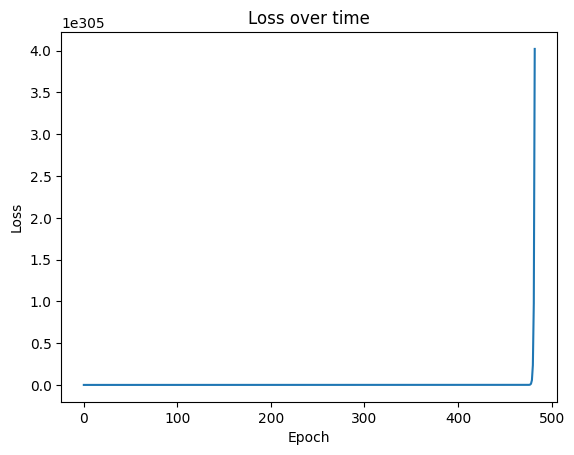

Validation Losses


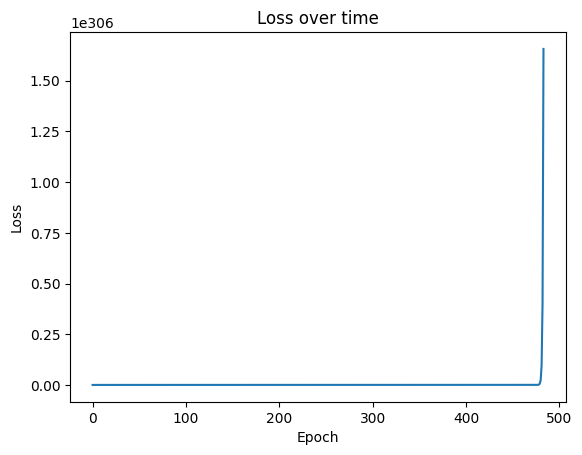

Epoch 0: Training Loss inf, Validation Loss inf
Epoch 1: Training Loss inf, Validation Loss inf
Epoch 2: Training Loss inf, Validation Loss inf
Epoch 3: Training Loss 3.012442052363056e+305, Validation Loss 3.0124420523630547e+305
Epoch 4: Training Loss 6.820977668009861e+302, Validation Loss 6.82097766800986e+302
Epoch 5: Training Loss 1.5444524919904394e+300, Validation Loss 1.5444524919904394e+300
Epoch 6: Training Loss 3.4970551380084495e+297, Validation Loss 3.497055138008448e+297
Epoch 7: Training Loss 7.918271815865604e+294, Validation Loss 7.918271815865604e+294
Epoch 8: Training Loss 1.7929093501693597e+292, Validation Loss 1.7929093501693597e+292
Epoch 9: Training Loss 4.059628177304892e+289, Validation Loss 4.059628177304892e+289
Epoch 10: Training Loss 9.192088231572354e+286, Validation Loss 9.192088231572354e+286
Epoch 11: Training Loss 2.0813355895343435e+284, Validation Loss 2.081335589534343e+284
Epoch 12: Training Loss 4.712702627660992e+281, Validation Loss 4.71270262

Epoch 96: Training Loss 3.070547571672151e+59, Validation Loss 3.0705475716721505e+59
Epoch 97: Training Loss 6.952544165458187e+56, Validation Loss 6.952544165458188e+56
Epoch 98: Training Loss 1.574242679663905e+54, Validation Loss 1.5742426796639047e+54
Epoch 99: Training Loss 3.564508121771948e+51, Validation Loss 3.564508121771948e+51
Epoch 100: Training Loss 8.071003482697352e+48, Validation Loss 8.07100348269735e+48
Epoch 101: Training Loss 1.82749190049062e+46, Validation Loss 1.8274919004906196e+46
Epoch 102: Training Loss 4.137932356885415e+43, Validation Loss 4.1379323568854155e+43
Epoch 103: Training Loss 9.369389919354745e+40, Validation Loss 9.369389919354743e+40
Epoch 104: Training Loss 2.1214814523208338e+38, Validation Loss 2.121481452320834e+38
Epoch 105: Training Loss 4.8036036404505365e+35, Validation Loss 4.803603640450537e+35
Epoch 106: Training Loss 1.0876648442675192e+33, Validation Loss 1.0876648442675195e+33
Epoch 107: Training Loss 2.4627652529310903e+30, Val

Epoch 200: Training Loss 89.6091804228678, Validation Loss 66.09996762368213
Epoch 201: Training Loss 89.2577580333372, Validation Loss 66.80672000505864
Epoch 202: Training Loss 89.25212759194687, Validation Loss 67.60412600694384
Epoch 203: Training Loss 89.22787142460452, Validation Loss 67.27985094965719
Epoch 204: Training Loss 89.3568166053837, Validation Loss 66.46431057352295
Epoch 205: Training Loss 89.2320759832778, Validation Loss 67.02740576549007
Epoch 206: Training Loss 89.32898893527707, Validation Loss 68.06475160449489
Epoch 207: Training Loss 90.03055720265118, Validation Loss 65.85584188617912
Epoch 208: Training Loss 89.23997377490505, Validation Loss 66.93499094288006
Epoch 209: Training Loss 89.34905998857431, Validation Loss 66.48267654929116
Epoch 210: Training Loss 89.69805392428763, Validation Loss 66.025887804913
Epoch 211: Training Loss 89.30474461291325, Validation Loss 66.60690586067344
Epoch 212: Training Loss 89.4999469969991, Validation Loss 68.72122512

Epoch 306: Training Loss 89.22854543739784, Validation Loss 67.30151454918487
Epoch 307: Training Loss 89.43017356069984, Validation Loss 66.32144206343631
Epoch 308: Training Loss 89.31946515316257, Validation Loss 66.56130297317692
Epoch 309: Training Loss 89.27637127370815, Validation Loss 66.7137226644688
Epoch 310: Training Loss 89.78668921408101, Validation Loss 65.96671672580612
Epoch 311: Training Loss 89.98611522590961, Validation Loss 70.0417872125176
Epoch 312: Training Loss 89.2358923056988, Validation Loss 66.97720178805586
Epoch 313: Training Loss 89.28409329046484, Validation Loss 66.68148470394172
Epoch 314: Training Loss 89.27986752667478, Validation Loss 67.8020695830591
Epoch 315: Training Loss 89.26086610588213, Validation Loss 67.67360699573216
Epoch 316: Training Loss 89.25787488149241, Validation Loss 66.80604419659291
Epoch 317: Training Loss 89.83981424451528, Validation Loss 69.6838985131535
Epoch 318: Training Loss 89.24612529517192, Validation Loss 67.550049

Epoch 416: Training Loss 90.28503580479234, Validation Loss 70.71711277543594
Epoch 417: Training Loss 89.44689394154763, Validation Loss 68.54019998567605
Epoch 418: Training Loss 89.25455564403113, Validation Loss 66.8258536014578
Epoch 419: Training Loss 89.39737167871057, Validation Loss 66.37946258346776
Epoch 420: Training Loss 89.28050408667488, Validation Loss 67.80599951907999
Epoch 421: Training Loss 89.53819073998258, Validation Loss 68.84413362756406
Epoch 422: Training Loss 89.2852200774276, Validation Loss 66.67701120311327
Epoch 423: Training Loss 89.49892048297295, Validation Loss 66.22109628925601
Epoch 424: Training Loss 89.88327614535042, Validation Loss 65.91502495397339
Epoch 425: Training Loss 89.24013106907422, Validation Loss 66.93351888087682
Epoch 426: Training Loss 89.22941200398535, Validation Loss 67.3242640258209
Epoch 427: Training Loss 89.73001157973329, Validation Loss 69.39805617504376
Epoch 428: Training Loss 89.37584563701176, Validation Loss 68.2704

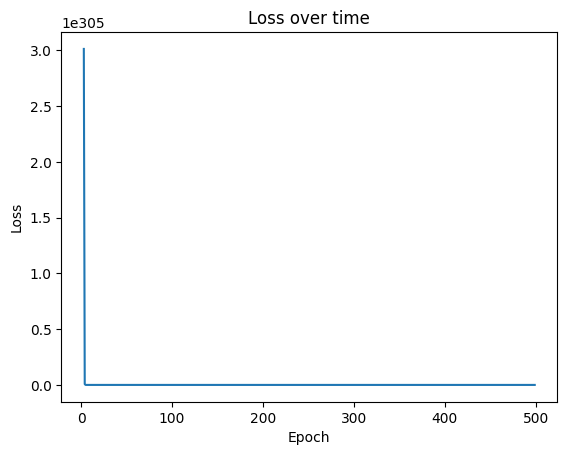

Validation Losses


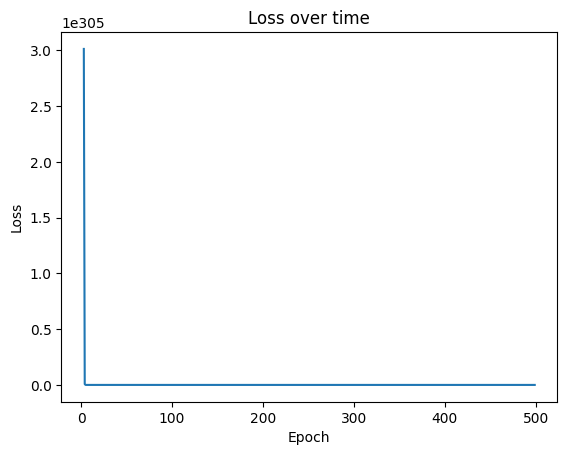

Epoch 0: Training Loss 89.99220178328218, Validation Loss 70.05621314760076
Epoch 1: Training Loss 89.37331740465548, Validation Loss 66.4277145850024
Epoch 2: Training Loss 89.32280217666617, Validation Loss 66.55164701785776
Epoch 3: Training Loss 89.6862450950409, Validation Loss 69.27880489656513
Epoch 4: Training Loss 89.22974037407837, Validation Loss 67.33193760839406
Epoch 5: Training Loss 89.88225089234857, Validation Loss 69.79009001639811
Epoch 6: Training Loss 89.31995823764406, Validation Loss 68.02115711967338
Epoch 7: Training Loss 89.43174270153351, Validation Loss 66.31885733757994
Epoch 8: Training Loss 89.22853264141749, Validation Loss 67.30114347659355
Epoch 9: Training Loss 89.2388955513364, Validation Loss 66.94535215725466
Epoch 10: Training Loss 90.83183818580382, Validation Loss 65.77094362539957
Epoch 11: Training Loss 89.2415727630889, Validation Loss 67.50379752831509
Epoch 12: Training Loss 89.2313207451626, Validation Loss 67.36428689951927
Epoch 13: Trai

Epoch 162: Training Loss 89.2304182285995, Validation Loss 67.05532752932731
Epoch 163: Training Loss 90.10539034069475, Validation Loss 65.83304091610536
Epoch 164: Training Loss 89.35062218337866, Validation Loss 68.163434199713
Epoch 165: Training Loss 89.47965677449038, Validation Loss 66.24681588914851
Epoch 166: Training Loss 89.23693149728064, Validation Loss 66.96561217935353
Epoch 167: Training Loss 89.35594731952393, Validation Loss 68.1866675475407
Epoch 168: Training Loss 89.47539937619665, Validation Loss 66.2527288667192
Epoch 169: Training Loss 89.37070938705183, Validation Loss 68.2492289557957
Epoch 170: Training Loss 89.34161683667274, Validation Loss 68.12324501461423
Epoch 171: Training Loss 89.2476241826895, Validation Loss 67.56417980108583
Epoch 172: Training Loss 89.22742284750844, Validation Loss 67.26171084967797
Epoch 173: Training Loss 89.28393793968203, Validation Loss 66.68210576614003
Epoch 174: Training Loss 89.22911256044827, Validation Loss 67.31686581

Epoch 327: Training Loss 89.69015391382881, Validation Loss 66.03181253289794
Epoch 328: Training Loss 89.3674858542617, Validation Loss 68.2357848951808
Epoch 329: Training Loss 89.54995189550718, Validation Loss 68.88087287559863
Epoch 330: Training Loss 89.22676575416205, Validation Loss 67.1799849791614
Epoch 331: Training Loss 89.6464138539001, Validation Loss 66.06684557902433
Epoch 332: Training Loss 90.10812696247486, Validation Loss 70.32506869427863
Epoch 333: Training Loss 89.85798311440092, Validation Loss 69.72962520977606
Epoch 334: Training Loss 89.52139470165136, Validation Loss 66.19305770255146
Epoch 335: Training Loss 89.73530049245169, Validation Loss 65.99946243543737
Epoch 336: Training Loss 89.31793590467467, Validation Loss 66.56580603105459
Epoch 337: Training Loss 89.56270767180895, Validation Loss 68.92021068129316
Epoch 338: Training Loss 89.22671385991667, Validation Loss 67.19545105089169
Epoch 339: Training Loss 89.33380200877032, Validation Loss 66.52134

Epoch 473: Training Loss 89.23560224728061, Validation Loss 66.98056284045667
Epoch 474: Training Loss 89.24383878987784, Validation Loss 66.90126542123927
Epoch 475: Training Loss 89.53238218223576, Validation Loss 68.82581500909556
Epoch 476: Training Loss 89.34178580664991, Validation Loss 68.12401012509216
Epoch 477: Training Loss 89.30613565582186, Validation Loss 67.9510079803958
Epoch 478: Training Loss 89.24030019278418, Validation Loss 67.4897559445551
Epoch 479: Training Loss 89.28233017714575, Validation Loss 67.81716662013284
Epoch 480: Training Loss 89.61496422912296, Validation Loss 66.09460465069493
Epoch 481: Training Loss 89.6457093404423, Validation Loss 66.06744263477144
Epoch 482: Training Loss 89.22744053892708, Validation Loss 67.13346514602958
Epoch 483: Training Loss 89.23423852991537, Validation Loss 67.41235542367565
Epoch 484: Training Loss 89.31891406221591, Validation Loss 66.56291995505269
Epoch 485: Training Loss 89.57277644292374, Validation Loss 68.9509

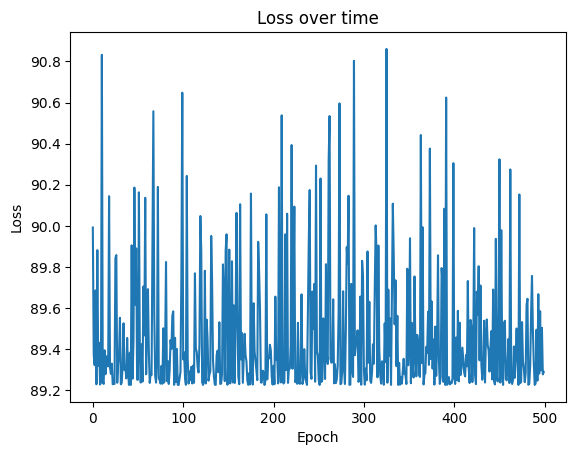

Validation Losses


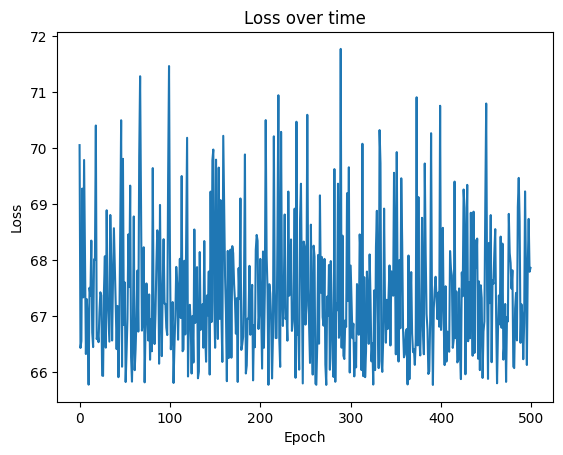

Epoch 0: Training Loss 11797.295918868502, Validation Loss 12034.183310995295
Epoch 1: Training Loss 764926.6223924138, Validation Loss 762825.4118615307
Epoch 2: Training Loss 22379274.769746996, Validation Loss 22390571.98949651
Epoch 3: Training Loss 572987802.81391, Validation Loss 572930505.474747
Epoch 4: Training Loss 14670548073.334923, Validation Loss 14670837897.068226
Epoch 5: Training Loss 93901014605.74248, Validation Loss 93900281370.09882
Epoch 6: Training Loss 386956690810.3367, Validation Loss 386958179211.94415
Epoch 7: Training Loss 1594609826881.849, Validation Loss 1594606805359.836
Epoch 8: Training Loss 6571227635318.942, Validation Loss 6571233768941.879
Epoch 9: Training Loss 27079371962107.348, Validation Loss 27079359510786.04
Epoch 10: Training Loss 111591383918369.69, Validation Loss 111591409194485.19
Epoch 11: Training Loss 459856933988931.25, Validation Loss 459856882678349.94
Epoch 12: Training Loss 1895024439274708.0, Validation Loss 1895024543435121.8

Epoch 146: Training Loss 4.859067990621515e+97, Validation Loss 4.859067990621515e+97
Epoch 147: Training Loss 2.0023733282552202e+98, Validation Loss 2.002373328255221e+98
Epoch 148: Training Loss 8.251580248406936e+98, Validation Loss 8.25158024840694e+98
Epoch 149: Training Loss 3.4003937045660156e+99, Validation Loss 3.4003937045660146e+99
Epoch 150: Training Loss 1.4012682417146092e+100, Validation Loss 1.4012682417146092e+100
Epoch 151: Training Loss 5.7744862972817304e+100, Validation Loss 5.7744862972817304e+100
Epoch 152: Training Loss 2.3796080582468287e+101, Validation Loss 2.3796080582468293e+101
Epoch 153: Training Loss 9.806126847229359e+101, Validation Loss 9.806126847229358e+101
Epoch 154: Training Loss 4.0410068124747516e+102, Validation Loss 4.041006812474752e+102
Epoch 155: Training Loss 1.66525849735272e+103, Validation Loss 1.66525849735272e+103
Epoch 156: Training Loss 6.862363741740826e+103, Validation Loss 6.862363741740826e+103
Epoch 157: Training Loss 2.827911

Epoch 295: Training Loss 2.0910878283350132e+189, Validation Loss 2.0910878283350132e+189
Epoch 296: Training Loss 8.617163831785761e+189, Validation Loss 8.617163831785759e+189
Epoch 297: Training Loss 3.5510470434405974e+190, Validation Loss 3.551047043440597e+190
Epoch 298: Training Loss 1.463350976131436e+191, Validation Loss 1.4633509761314355e+191
Epoch 299: Training Loss 6.030323037540035e+191, Validation Loss 6.030323037540035e+191
Epoch 300: Training Loss 2.485035820539874e+192, Validation Loss 2.4850358205398734e+192
Epoch 301: Training Loss 1.0240584112862776e+193, Validation Loss 1.0240584112862776e+193
Epoch 302: Training Loss 4.220042307069619e+193, Validation Loss 4.22004230706962e+193
Epoch 303: Training Loss 1.7390372343203202e+194, Validation Loss 1.73903723432032e+194
Epoch 304: Training Loss 7.166398538910615e+194, Validation Loss 7.166398538910615e+194
Epoch 305: Training Loss 2.9532011738996776e+195, Validation Loss 2.9532011738996776e+195
Epoch 306: Training Loss

Epoch 464: Training Loss 1.794870372333856e+293, Validation Loss 1.7948703723338563e+293
Epoch 465: Training Loss 7.396481317350585e+293, Validation Loss 7.396481317350583e+293
Epoch 466: Training Loss 3.048015986067002e+294, Validation Loss 3.048015986067002e+294
Epoch 467: Training Loss 1.2560569076983513e+295, Validation Loss 1.256056907698351e+295
Epoch 468: Training Loss 5.176084910934139e+295, Validation Loss 5.176084910934139e+295
Epoch 469: Training Loss 2.133012830946849e+296, Validation Loss 2.133012830946849e+296
Epoch 470: Training Loss 8.789932575048868e+296, Validation Loss 8.789932575048868e+296
Epoch 471: Training Loss 3.622243314851885e+297, Validation Loss 3.6222433148518835e+297
Epoch 472: Training Loss 1.4926902476173131e+298, Validation Loss 1.492690247617313e+298
Epoch 473: Training Loss 6.151227241406182e+298, Validation Loss 6.151227241406186e+298
Epoch 474: Training Loss 2.5348592339110767e+299, Validation Loss 2.5348592339110764e+299
Epoch 475: Training Loss 1

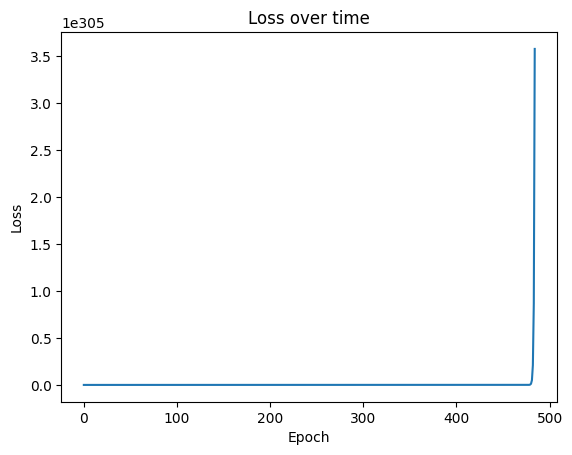

Validation Losses


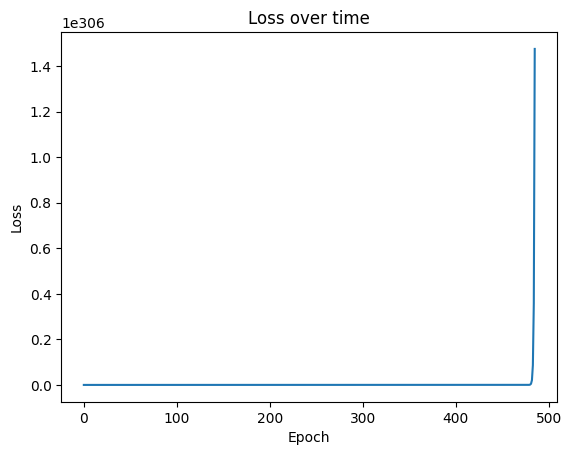

Epoch 0: Training Loss inf, Validation Loss inf
Epoch 1: Training Loss inf, Validation Loss inf
Epoch 2: Training Loss inf, Validation Loss inf
Epoch 3: Training Loss 1.5793102250615417e+304, Validation Loss 1.579310225061542e+304
Epoch 4: Training Loss 3.5759824052230778e+301, Validation Loss 3.5759824052230763e+301
Epoch 5: Training Loss 8.096984341354911e+298, Validation Loss 8.096984341354912e+298
Epoch 6: Training Loss 1.8333746644946633e+296, Validation Loss 1.8333746644946633e+296
Epoch 7: Training Loss 4.15125251415326e+293, Validation Loss 4.15125251415326e+293
Epoch 8: Training Loss 9.399550331963205e+290, Validation Loss 9.399550331963204e+290
Epoch 9: Training Loss 2.1283105795632546e+288, Validation Loss 2.1283105795632546e+288
Epoch 10: Training Loss 4.819066618195136e+285, Validation Loss 4.819066618195137e+285
Epoch 11: Training Loss 1.0911660776205084e+283, Validation Loss 1.0911660776205084e+283
Epoch 12: Training Loss 2.4706929853475495e+280, Validation Loss 2.470692

Epoch 96: Training Loss 1.6097727664755607e+58, Validation Loss 1.6097727664755605e+58
Epoch 97: Training Loss 3.644957778386796e+55, Validation Loss 3.6449577783867967e+55
Epoch 98: Training Loss 8.253163106560805e+52, Validation Loss 8.253163106560803e+52
Epoch 99: Training Loss 1.8687377304447972e+50, Validation Loss 1.8687377304447966e+50
Epoch 100: Training Loss 4.231323990691382e+47, Validation Loss 4.231323990691381e+47
Epoch 101: Training Loss 9.580853654589006e+44, Validation Loss 9.580853654589004e+44
Epoch 102: Training Loss 2.1693625199249567e+42, Validation Loss 2.1693625199249567e+42
Epoch 103: Training Loss 4.9120192339030474e+39, Validation Loss 4.912019233903047e+39
Epoch 104: Training Loss 1.112213045658599e+37, Validation Loss 1.112213045658599e+37
Epoch 105: Training Loss 2.518348972241815e+34, Validation Loss 2.518348972241815e+34
Epoch 106: Training Loss 5.702218267216911e+31, Validation Loss 5.702218267216911e+31
Epoch 107: Training Loss 1.2911353241896915e+29, V

Epoch 200: Training Loss 90.05690071880662, Validation Loss 65.84731651893797
Epoch 201: Training Loss 89.2379981001977, Validation Loss 67.46272996122843
Epoch 202: Training Loss 89.22678389701251, Validation Loss 67.17722865185793
Epoch 203: Training Loss 89.29438142568598, Validation Loss 66.64250689450493
Epoch 204: Training Loss 89.26912776804635, Validation Loss 66.74689960106991
Epoch 205: Training Loss 89.24281988360198, Validation Loss 67.51703781410286
Epoch 206: Training Loss 89.92665357938472, Validation Loss 65.89538079644893
Epoch 207: Training Loss 89.30486020108825, Validation Loss 66.60652658748262
Epoch 208: Training Loss 89.23366167436113, Validation Loss 67.40366438225463
Epoch 209: Training Loss 89.32631422018963, Validation Loss 68.05200468657
Epoch 210: Training Loss 89.57645311840322, Validation Loss 66.13196683402609
Epoch 211: Training Loss 89.5721093075523, Validation Loss 68.94888295660924
Epoch 212: Training Loss 89.23319539397542, Validation Loss 67.396389

Epoch 307: Training Loss 89.43561770263986, Validation Loss 66.31254193225178
Epoch 308: Training Loss 89.35981560231873, Validation Loss 66.45741912489436
Epoch 309: Training Loss 89.22710345744291, Validation Loss 67.24491785022153
Epoch 310: Training Loss 89.32115217612015, Validation Loss 66.55639273644269
Epoch 311: Training Loss 89.28620476583231, Validation Loss 66.67314585331692
Epoch 312: Training Loss 89.23811890508739, Validation Loss 67.46420765730629
Epoch 313: Training Loss 89.72610823038049, Validation Loss 66.00576122392876
Epoch 314: Training Loss 89.36814861311946, Validation Loss 68.23855847617111
Epoch 315: Training Loss 89.3787305413509, Validation Loss 68.28219614167907
Epoch 316: Training Loss 89.97052103701228, Validation Loss 70.00467317412264
Epoch 317: Training Loss 91.65398861083872, Validation Loss 65.8967200588828
Epoch 318: Training Loss 89.2750001738802, Validation Loss 67.77133849431382
Epoch 319: Training Loss 89.24001600196976, Validation Loss 67.4865

Epoch 416: Training Loss 89.27487574976917, Validation Loss 67.77053621746079
Epoch 417: Training Loss 89.26056407301215, Validation Loss 67.67134535270752
Epoch 418: Training Loss 89.73322641404431, Validation Loss 69.40668377701402
Epoch 419: Training Loss 89.28946223884259, Validation Loss 67.85938837989312
Epoch 420: Training Loss 90.42325671763491, Validation Loss 71.0111446637937
Epoch 421: Training Loss 89.26952664305132, Validation Loss 66.74498679642873
Epoch 422: Training Loss 89.4693367378837, Validation Loss 66.26130055377031
Epoch 423: Training Loss 89.36322420010826, Validation Loss 68.21782990057113
Epoch 424: Training Loss 89.2474602481841, Validation Loss 67.56265691771594
Epoch 425: Training Loss 89.2579404506754, Validation Loss 66.80566561847284
Epoch 426: Training Loss 89.38960824269282, Validation Loss 66.3944438948874
Epoch 427: Training Loss 89.29212508785072, Validation Loss 66.65071566696705
Epoch 428: Training Loss 89.22694043965727, Validation Loss 67.233554

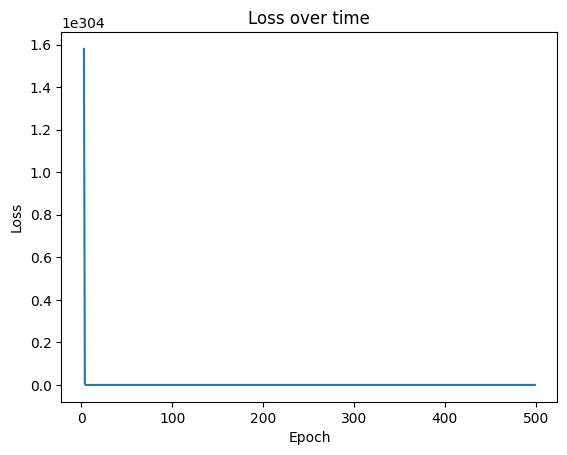

Validation Losses


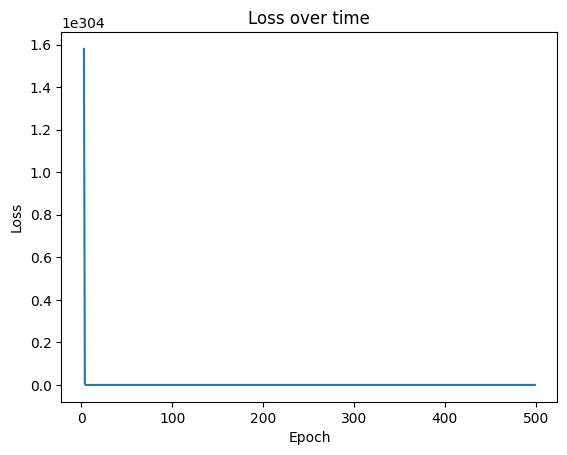

Epoch 0: Training Loss 89.37418568280543, Validation Loss 66.42587385973653
Epoch 1: Training Loss 89.23266882280636, Validation Loss 67.01856718122649
Epoch 2: Training Loss 89.75690052879884, Validation Loss 69.4696998358359
Epoch 3: Training Loss 89.22990938848291, Validation Loss 67.33573186933694
Epoch 4: Training Loss 89.22965579075873, Validation Loss 67.33000075806544
Epoch 5: Training Loss 89.392834321537, Validation Loss 68.33861690604554
Epoch 6: Training Loss 89.3139642245843, Validation Loss 66.57774158194182
Epoch 7: Training Loss 90.40693284549091, Validation Loss 70.97690594119491
Epoch 8: Training Loss 89.2269412575743, Validation Loss 67.2336197844349
Epoch 9: Training Loss 89.28453850875555, Validation Loss 67.83046869435613
Epoch 10: Training Loss 89.2268215514597, Validation Loss 67.22226940593274
Epoch 11: Training Loss 89.29289812246674, Validation Loss 67.87901527613421
Epoch 12: Training Loss 90.11878739580732, Validation Loss 70.34927300767116
Epoch 13: Traini

Epoch 175: Training Loss 89.27495481095866, Validation Loss 66.71996581131772
Epoch 176: Training Loss 90.08712744415024, Validation Loss 70.27714794021554
Epoch 177: Training Loss 89.23330799126923, Validation Loss 67.39816821756669
Epoch 178: Training Loss 89.23500200678984, Validation Loss 66.9877123854894
Epoch 179: Training Loss 90.22386776696747, Validation Loss 65.80508635406129
Epoch 180: Training Loss 89.24520651880344, Validation Loss 66.89036945812941
Epoch 181: Training Loss 89.34318859608656, Validation Loss 68.13034527149308
Epoch 182: Training Loss 89.27502429554788, Validation Loss 66.71965695172513
Epoch 183: Training Loss 89.60998611171357, Validation Loss 69.06185898297211
Epoch 184: Training Loss 89.22918046957726, Validation Loss 67.08088243586273
Epoch 185: Training Loss 89.31559009088606, Validation Loss 67.99946976920589
Epoch 186: Training Loss 89.78928499688548, Validation Loss 69.55450498450233
Epoch 187: Training Loss 89.53254347531016, Validation Loss 68.82

Epoch 282: Training Loss 89.34867461648099, Validation Loss 68.15484120113456
Epoch 283: Training Loss 89.22891719127271, Validation Loss 67.31179734253634
Epoch 284: Training Loss 89.27792423774955, Validation Loss 66.70700238288867
Epoch 285: Training Loss 89.29574819620777, Validation Loss 67.89497951164627
Epoch 286: Training Loss 89.44234100677373, Validation Loss 68.52397815013462
Epoch 287: Training Loss 90.5592642990687, Validation Loss 71.29190210154285
Epoch 288: Training Loss 89.29128556200811, Validation Loss 66.65381591805316
Epoch 289: Training Loss 89.74029156785537, Validation Loss 65.99610103557009
Epoch 290: Training Loss 89.24442817765116, Validation Loss 66.89651217417861
Epoch 291: Training Loss 89.31140581794774, Validation Loss 66.58562242118477
Epoch 292: Training Loss 89.25530957161071, Validation Loss 66.82123805918278
Epoch 293: Training Loss 89.28725317072922, Validation Loss 67.84653432721197
Epoch 294: Training Loss 89.81125826002865, Validation Loss 69.61

Epoch 427: Training Loss 89.33389880584616, Validation Loss 66.5210862573824
Epoch 428: Training Loss 89.26380737056456, Validation Loss 66.77352112120553
Epoch 429: Training Loss 89.33758816433584, Validation Loss 66.51140786397171
Epoch 430: Training Loss 89.28581317631505, Validation Loss 67.83805046403798
Epoch 431: Training Loss 89.24130741507636, Validation Loss 66.9228008999643
Epoch 432: Training Loss 89.22899985839874, Validation Loss 67.08513469366886
Epoch 433: Training Loss 89.22709277143193, Validation Loss 67.2442554496433
Epoch 434: Training Loss 89.37035533442035, Validation Loss 68.24775797550745
Epoch 435: Training Loss 89.45737213854646, Validation Loss 66.2787634367788
Epoch 436: Training Loss 89.39021112685228, Validation Loss 68.32826319855694
Epoch 437: Training Loss 89.38334587587273, Validation Loss 66.40692653412279
Epoch 438: Training Loss 89.25333711762471, Validation Loss 66.83346951449745
Epoch 439: Training Loss 89.24888736733747, Validation Loss 66.86313

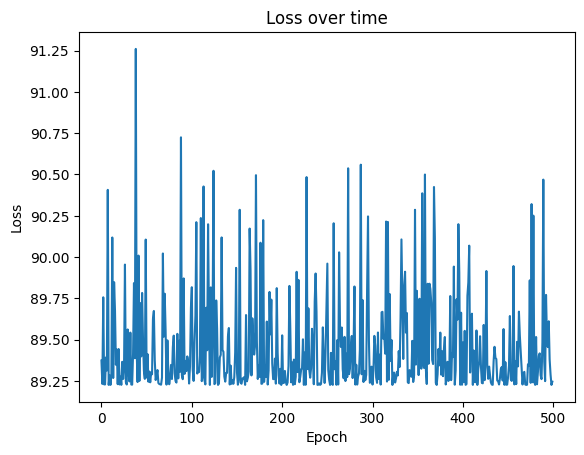

Validation Losses


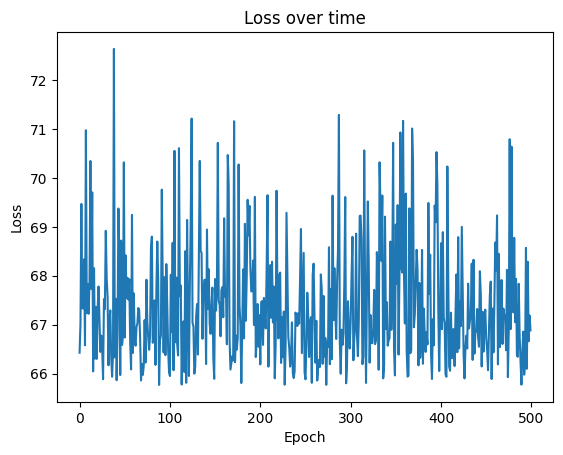

Epoch 0: Training Loss 5011.841614837419, Validation Loss 5157.689981382976
Epoch 1: Training Loss 502.5928902851857, Validation Loss 529.211201359735
Epoch 2: Training Loss 608792.2187957856, Validation Loss 606903.3880396669
Epoch 3: Training Loss 19397208.05251309, Validation Loss 19386647.88240195
Epoch 4: Training Loss 324496705.40849805, Validation Loss 324453581.0771725
Epoch 5: Training Loss 3622677627.757275, Validation Loss 3622533589.9026175
Epoch 6: Training Loss 27037250426.786526, Validation Loss 27036856966.453182
Epoch 7: Training Loss 107025889817.17442, Validation Loss 107025107014.9997
Epoch 8: Training Loss 23732980744.031178, Validation Loss 23732612108.26066
Epoch 9: Training Loss 7313308848256.072, Validation Loss 7313315318949.987
Epoch 10: Training Loss 327654519905351.7, Validation Loss 327654563216853.1
Epoch 11: Training Loss 6339581967853140.0, Validation Loss 6339582158366588.0
Epoch 12: Training Loss 7.908500644801013e+16, Validation Loss 7.90850071208976

Epoch 228: Training Loss 1.2641728750935896e+220, Validation Loss 1.2641728750935896e+220
Epoch 229: Training Loss 1.3064447026717926e+221, Validation Loss 1.3064447026717928e+221
Epoch 230: Training Loss 8.837714558233555e+221, Validation Loss 8.837714558233557e+221
Epoch 231: Training Loss 2.814522113283002e+222, Validation Loss 2.8145221132830014e+222
Epoch 232: Training Loss 8.25024249563638e+220, Validation Loss 8.250242495636377e+220
Epoch 233: Training Loss 1.0201787856524137e+223, Validation Loss 1.0201787856524137e+223
Epoch 234: Training Loss 1.0823358875450841e+222, Validation Loss 1.0823358875450841e+222
Epoch 235: Training Loss 1.3383559477285565e+224, Validation Loss 1.338355947728556e+224
Epoch 236: Training Loss 8.000093788717812e+224, Validation Loss 8.000093788717814e+224
Epoch 237: Training Loss 1.8283638916295378e+225, Validation Loss 1.8283638916295378e+225
Epoch 238: Training Loss 3.069286951604712e+225, Validation Loss 3.069286951604713e+225
Epoch 239: Training L

Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan
Epoch 355: Training Loss nan, Validation Loss nan
Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan
Epoch 358: Training Loss nan, Validation Loss nan
Epoch 359: Training Loss nan, Validation Loss nan
Epoch 360: Training Loss nan, Validation Loss nan
Epoch 361: Training Loss nan, Validation Loss nan
Epoch 362: Training Loss nan, Validation Loss nan
Epoch 363: Training Loss nan, Validation Loss nan
Epoch 364: Training Loss nan, Validation Loss nan
Epoch 365: Training Loss nan, Validation Loss nan
Epoch 366: Training Loss nan, Validation Loss nan
Epoch 367: Training Loss nan, Validation Loss nan
Epoch 368: Training Loss nan, Validation Loss nan
Epoch 369: Training Loss nan, Validation Loss nan
Epoch 370: Training Loss nan, Validation Loss nan
Epoch 371: Training Loss nan, Validation Loss nan
Epoch 372: Training Loss nan, Validation Loss nan


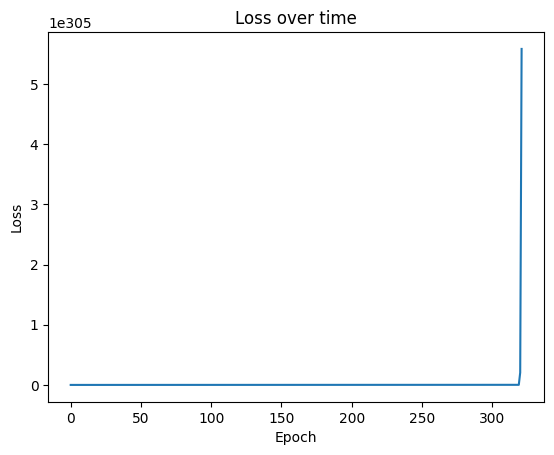

Validation Losses


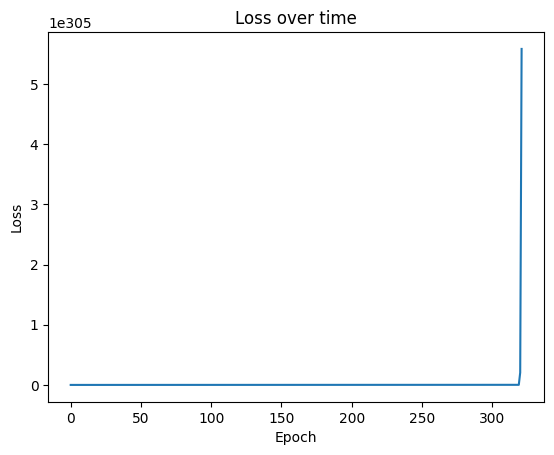

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 171: Training Loss nan, Validation Loss nan
Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan
Epoch 187: Training Loss nan, Validation Loss nan
Epoch 188: Training Loss nan, Validation Loss nan
Epoch 189: Training Loss nan, Validation Loss nan
Epoch 190: Training Loss nan, Validation Loss nan


Epoch 339: Training Loss nan, Validation Loss nan
Epoch 340: Training Loss nan, Validation Loss nan
Epoch 341: Training Loss nan, Validation Loss nan
Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan
Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan
Epoch 355: Training Loss nan, Validation Loss nan
Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan
Epoch 358: Training Loss nan, Validation Loss nan


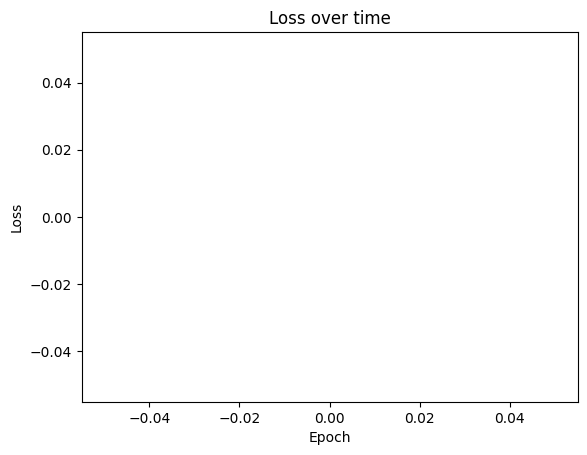

Validation Losses


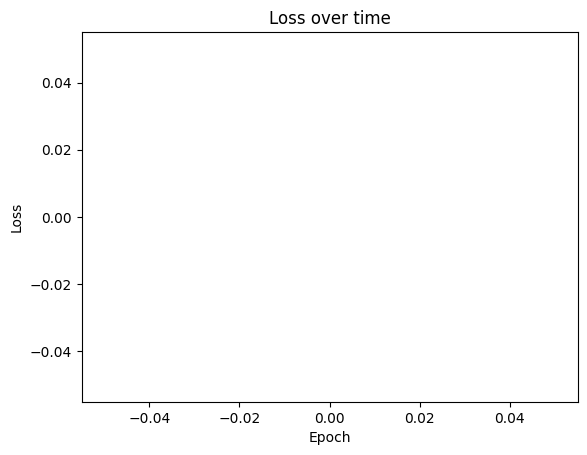

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 218: Training Loss nan, Validation Loss nan
Epoch 219: Training Loss nan, Validation Loss nan
Epoch 220: Training Loss nan, Validation Loss nan
Epoch 221: Training Loss nan, Validation Loss nan
Epoch 222: Training Loss nan, Validation Loss nan
Epoch 223: Training Loss nan, Validation Loss nan
Epoch 224: Training Loss nan, Validation Loss nan
Epoch 225: Training Loss nan, Validation Loss nan
Epoch 226: Training Loss nan, Validation Loss nan
Epoch 227: Training Loss nan, Validation Loss nan
Epoch 228: Training Loss nan, Validation Loss nan
Epoch 229: Training Loss nan, Validation Loss nan
Epoch 230: Training Loss nan, Validation Loss nan
Epoch 231: Training Loss nan, Validation Loss nan
Epoch 232: Training Loss nan, Validation Loss nan
Epoch 233: Training Loss nan, Validation Loss nan
Epoch 234: Training Loss nan, Validation Loss nan
Epoch 235: Training Loss nan, Validation Loss nan
Epoch 236: Training Loss nan, Validation Loss nan
Epoch 237: Training Loss nan, Validation Loss nan


Epoch 423: Training Loss nan, Validation Loss nan
Epoch 424: Training Loss nan, Validation Loss nan
Epoch 425: Training Loss nan, Validation Loss nan
Epoch 426: Training Loss nan, Validation Loss nan
Epoch 427: Training Loss nan, Validation Loss nan
Epoch 428: Training Loss nan, Validation Loss nan
Epoch 429: Training Loss nan, Validation Loss nan
Epoch 430: Training Loss nan, Validation Loss nan
Epoch 431: Training Loss nan, Validation Loss nan
Epoch 432: Training Loss nan, Validation Loss nan
Epoch 433: Training Loss nan, Validation Loss nan
Epoch 434: Training Loss nan, Validation Loss nan
Epoch 435: Training Loss nan, Validation Loss nan
Epoch 436: Training Loss nan, Validation Loss nan
Epoch 437: Training Loss nan, Validation Loss nan
Epoch 438: Training Loss nan, Validation Loss nan
Epoch 439: Training Loss nan, Validation Loss nan
Epoch 440: Training Loss nan, Validation Loss nan
Epoch 441: Training Loss nan, Validation Loss nan
Epoch 442: Training Loss nan, Validation Loss nan


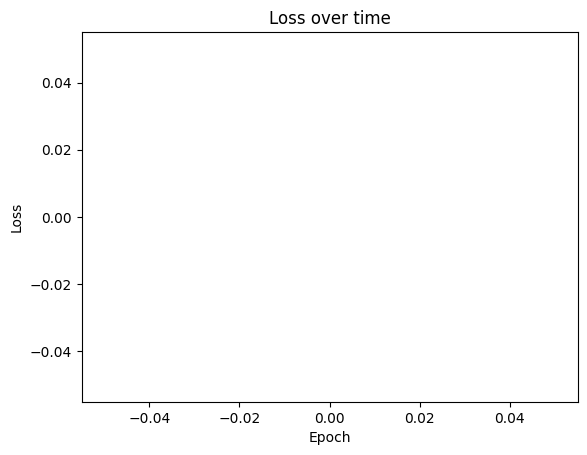

Validation Losses


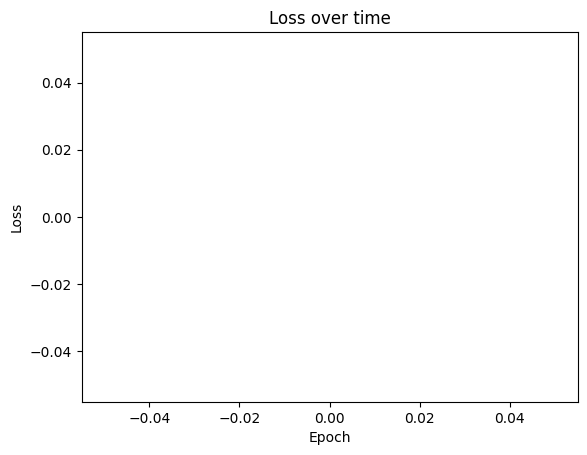

Epoch 0: Training Loss 92.15979715301023, Validation Loss 74.22821303103355
Epoch 1: Training Loss 7340.015177440756, Validation Loss 7114.240242610033
Epoch 2: Training Loss 115721.81451993059, Validation Loss 114886.139058189
Epoch 3: Training Loss 357438.0027769886, Validation Loss 355985.62593909435
Epoch 4: Training Loss 4925988.428424905, Validation Loss 4931276.932299854
Epoch 5: Training Loss 953811321.4166172, Validation Loss 953737402.4234784
Epoch 6: Training Loss 24395375443.049534, Validation Loss 24395001698.61903
Epoch 7: Training Loss 172996328473.07285, Validation Loss 172995333243.12918
Epoch 8: Training Loss 26511044041.274635, Validation Loss 26511433610.135128
Epoch 9: Training Loss 29943025035740.285, Validation Loss 29943011942596.254
Epoch 10: Training Loss 3385908181365559.5, Validation Loss 3385908042135491.0
Epoch 11: Training Loss 3.736094160189002e+17, Validation Loss 3.7360941455637184e+17
Epoch 12: Training Loss 4.106887986811965e+19, Validation Loss 4.10

Epoch 163: Training Loss nan, Validation Loss nan
Epoch 164: Training Loss nan, Validation Loss nan
Epoch 165: Training Loss nan, Validation Loss nan
Epoch 166: Training Loss nan, Validation Loss nan
Epoch 167: Training Loss nan, Validation Loss nan
Epoch 168: Training Loss nan, Validation Loss nan
Epoch 169: Training Loss nan, Validation Loss nan
Epoch 170: Training Loss nan, Validation Loss nan
Epoch 171: Training Loss nan, Validation Loss nan
Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan


Epoch 416: Training Loss nan, Validation Loss nan
Epoch 417: Training Loss nan, Validation Loss nan
Epoch 418: Training Loss nan, Validation Loss nan
Epoch 419: Training Loss nan, Validation Loss nan
Epoch 420: Training Loss nan, Validation Loss nan
Epoch 421: Training Loss nan, Validation Loss nan
Epoch 422: Training Loss nan, Validation Loss nan
Epoch 423: Training Loss nan, Validation Loss nan
Epoch 424: Training Loss nan, Validation Loss nan
Epoch 425: Training Loss nan, Validation Loss nan
Epoch 426: Training Loss nan, Validation Loss nan
Epoch 427: Training Loss nan, Validation Loss nan
Epoch 428: Training Loss nan, Validation Loss nan
Epoch 429: Training Loss nan, Validation Loss nan
Epoch 430: Training Loss nan, Validation Loss nan
Epoch 431: Training Loss nan, Validation Loss nan
Epoch 432: Training Loss nan, Validation Loss nan
Epoch 433: Training Loss nan, Validation Loss nan
Epoch 434: Training Loss nan, Validation Loss nan
Epoch 435: Training Loss nan, Validation Loss nan


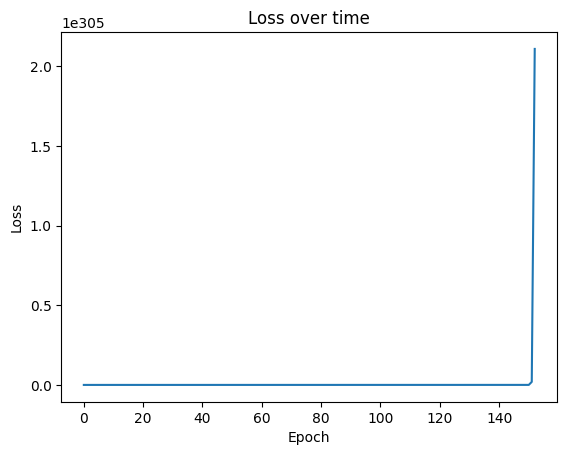

Validation Losses


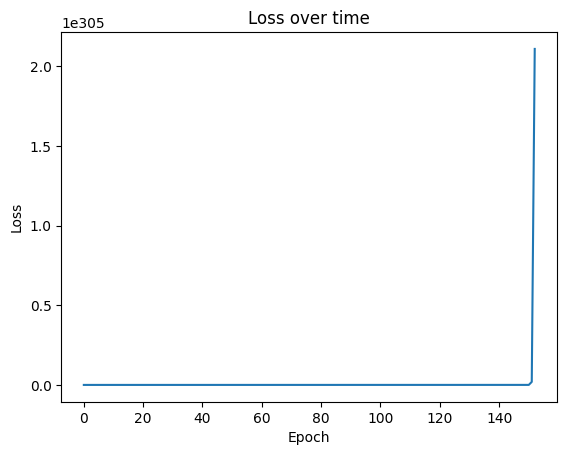

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 170: Training Loss nan, Validation Loss nan
Epoch 171: Training Loss nan, Validation Loss nan
Epoch 172: Training Loss nan, Validation Loss nan
Epoch 173: Training Loss nan, Validation Loss nan
Epoch 174: Training Loss nan, Validation Loss nan
Epoch 175: Training Loss nan, Validation Loss nan
Epoch 176: Training Loss nan, Validation Loss nan
Epoch 177: Training Loss nan, Validation Loss nan
Epoch 178: Training Loss nan, Validation Loss nan
Epoch 179: Training Loss nan, Validation Loss nan
Epoch 180: Training Loss nan, Validation Loss nan
Epoch 181: Training Loss nan, Validation Loss nan
Epoch 182: Training Loss nan, Validation Loss nan
Epoch 183: Training Loss nan, Validation Loss nan
Epoch 184: Training Loss nan, Validation Loss nan
Epoch 185: Training Loss nan, Validation Loss nan
Epoch 186: Training Loss nan, Validation Loss nan
Epoch 187: Training Loss nan, Validation Loss nan
Epoch 188: Training Loss nan, Validation Loss nan
Epoch 189: Training Loss nan, Validation Loss nan


Epoch 338: Training Loss nan, Validation Loss nan
Epoch 339: Training Loss nan, Validation Loss nan
Epoch 340: Training Loss nan, Validation Loss nan
Epoch 341: Training Loss nan, Validation Loss nan
Epoch 342: Training Loss nan, Validation Loss nan
Epoch 343: Training Loss nan, Validation Loss nan
Epoch 344: Training Loss nan, Validation Loss nan
Epoch 345: Training Loss nan, Validation Loss nan
Epoch 346: Training Loss nan, Validation Loss nan
Epoch 347: Training Loss nan, Validation Loss nan
Epoch 348: Training Loss nan, Validation Loss nan
Epoch 349: Training Loss nan, Validation Loss nan
Epoch 350: Training Loss nan, Validation Loss nan
Epoch 351: Training Loss nan, Validation Loss nan
Epoch 352: Training Loss nan, Validation Loss nan
Epoch 353: Training Loss nan, Validation Loss nan
Epoch 354: Training Loss nan, Validation Loss nan
Epoch 355: Training Loss nan, Validation Loss nan
Epoch 356: Training Loss nan, Validation Loss nan
Epoch 357: Training Loss nan, Validation Loss nan


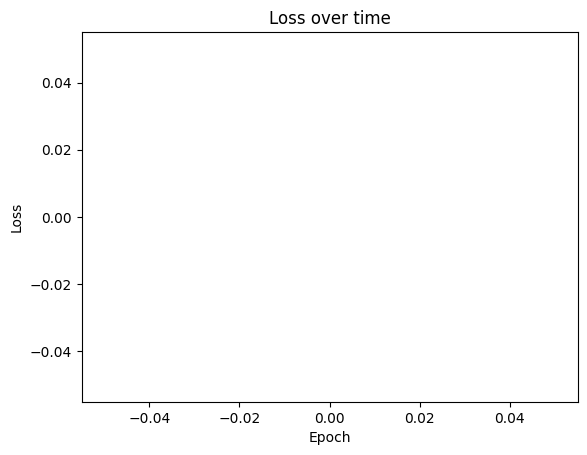

Validation Losses


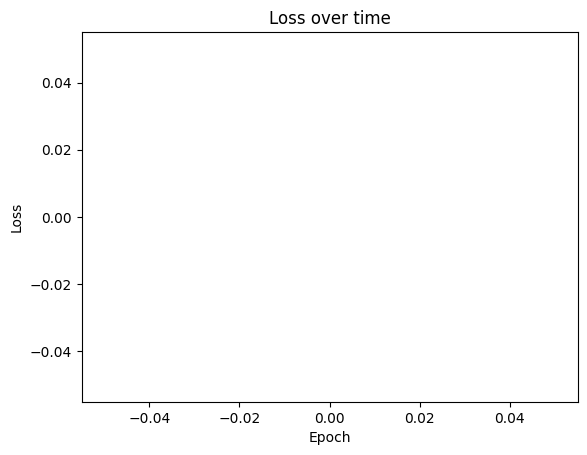

Epoch 0: Training Loss nan, Validation Loss nan
Epoch 1: Training Loss nan, Validation Loss nan
Epoch 2: Training Loss nan, Validation Loss nan
Epoch 3: Training Loss nan, Validation Loss nan
Epoch 4: Training Loss nan, Validation Loss nan
Epoch 5: Training Loss nan, Validation Loss nan
Epoch 6: Training Loss nan, Validation Loss nan
Epoch 7: Training Loss nan, Validation Loss nan
Epoch 8: Training Loss nan, Validation Loss nan
Epoch 9: Training Loss nan, Validation Loss nan
Epoch 10: Training Loss nan, Validation Loss nan
Epoch 11: Training Loss nan, Validation Loss nan
Epoch 12: Training Loss nan, Validation Loss nan
Epoch 13: Training Loss nan, Validation Loss nan
Epoch 14: Training Loss nan, Validation Loss nan
Epoch 15: Training Loss nan, Validation Loss nan
Epoch 16: Training Loss nan, Validation Loss nan
Epoch 17: Training Loss nan, Validation Loss nan
Epoch 18: Training Loss nan, Validation Loss nan
Epoch 19: Training Loss nan, Validation Loss nan
Epoch 20: Training Loss nan, V

Epoch 241: Training Loss nan, Validation Loss nan
Epoch 242: Training Loss nan, Validation Loss nan
Epoch 243: Training Loss nan, Validation Loss nan
Epoch 244: Training Loss nan, Validation Loss nan
Epoch 245: Training Loss nan, Validation Loss nan
Epoch 246: Training Loss nan, Validation Loss nan
Epoch 247: Training Loss nan, Validation Loss nan
Epoch 248: Training Loss nan, Validation Loss nan
Epoch 249: Training Loss nan, Validation Loss nan
Epoch 250: Training Loss nan, Validation Loss nan
Epoch 251: Training Loss nan, Validation Loss nan
Epoch 252: Training Loss nan, Validation Loss nan
Epoch 253: Training Loss nan, Validation Loss nan
Epoch 254: Training Loss nan, Validation Loss nan
Epoch 255: Training Loss nan, Validation Loss nan
Epoch 256: Training Loss nan, Validation Loss nan
Epoch 257: Training Loss nan, Validation Loss nan
Epoch 258: Training Loss nan, Validation Loss nan
Epoch 259: Training Loss nan, Validation Loss nan
Epoch 260: Training Loss nan, Validation Loss nan


Epoch 431: Training Loss nan, Validation Loss nan
Epoch 432: Training Loss nan, Validation Loss nan
Epoch 433: Training Loss nan, Validation Loss nan
Epoch 434: Training Loss nan, Validation Loss nan
Epoch 435: Training Loss nan, Validation Loss nan
Epoch 436: Training Loss nan, Validation Loss nan
Epoch 437: Training Loss nan, Validation Loss nan
Epoch 438: Training Loss nan, Validation Loss nan
Epoch 439: Training Loss nan, Validation Loss nan
Epoch 440: Training Loss nan, Validation Loss nan
Epoch 441: Training Loss nan, Validation Loss nan
Epoch 442: Training Loss nan, Validation Loss nan
Epoch 443: Training Loss nan, Validation Loss nan
Epoch 444: Training Loss nan, Validation Loss nan
Epoch 445: Training Loss nan, Validation Loss nan
Epoch 446: Training Loss nan, Validation Loss nan
Epoch 447: Training Loss nan, Validation Loss nan
Epoch 448: Training Loss nan, Validation Loss nan
Epoch 449: Training Loss nan, Validation Loss nan
Epoch 450: Training Loss nan, Validation Loss nan


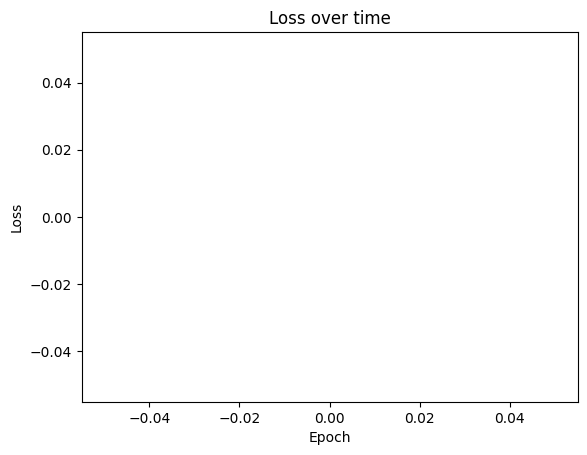

Validation Losses


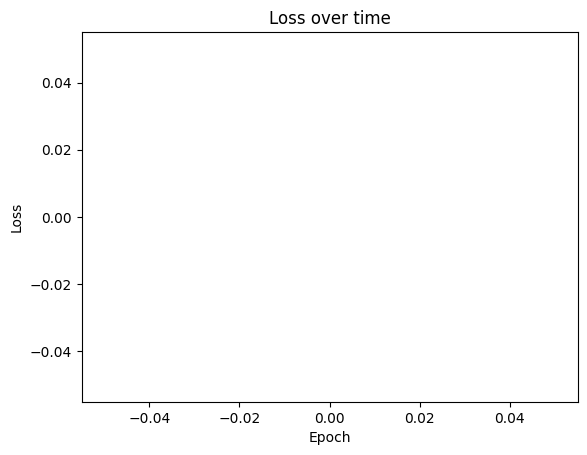

Epoch 0: Training Loss 253594.60195847845, Validation Loss 262990.3019694304
Epoch 1: Training Loss 2142939.453414363, Validation Loss 2139414.8179699616
Epoch 2: Training Loss 8830560.725925757, Validation Loss 8837648.98664786
Epoch 3: Training Loss 36389579.22781796, Validation Loss 36375123.30932205
Epoch 4: Training Loss 149957538.57226557, Validation Loss 149986817.33758217
Epoch 5: Training Loss 617959742.2347996, Validation Loss 617900239.5919769
Epoch 6: Training Loss 2546550023.3077364, Validation Loss 2546670746.923436
Epoch 7: Training Loss 10494077712.581205, Validation Loss 10493832576.892105
Epoch 8: Training Loss 43245044567.30824, Validation Loss 43245542126.0079
Epoch 9: Training Loss 178208503878.95288, Validation Loss 178207493768.0434
Epoch 10: Training Loss 734379423356.3094, Validation Loss 734381473814.7067
Epoch 11: Training Loss 3026304165430.548, Validation Loss 3026300002933.252
Epoch 12: Training Loss 12471096835044.281, Validation Loss 12471105284847.04
Ep

Epoch 210: Training Loss 7.317043973892777e+134, Validation Loss 7.317043973892777e+134
Epoch 211: Training Loss 3.0152806512014726e+135, Validation Loss 3.015280651201472e+135
Epoch 212: Training Loss 1.2425670035536149e+136, Validation Loss 1.2425670035536149e+136
Epoch 213: Training Loss 5.120494364944092e+136, Validation Loss 5.120494364944092e+136
Epoch 214: Training Loss 2.1101045228498123e+137, Validation Loss 2.1101045228498127e+137
Epoch 215: Training Loss 8.695529728211786e+137, Validation Loss 8.695529728211784e+137
Epoch 216: Training Loss 3.583340845698794e+138, Validation Loss 3.583340845698794e+138
Epoch 217: Training Loss 1.4766589291040163e+139, Validation Loss 1.4766589291040158e+139
Epoch 218: Training Loss 6.085163780944735e+139, Validation Loss 6.085163780944735e+139
Epoch 219: Training Loss 2.507635142489514e+140, Validation Loss 2.5076351424895153e+140
Epoch 220: Training Loss 1.0333713658685038e+141, Validation Loss 1.0333713658685041e+141
Epoch 221: Training Lo

Epoch 319: Training Loss 7.915382932854764e+201, Validation Loss 7.915382932854764e+201
Epoch 320: Training Loss 3.261850152800119e+202, Validation Loss 3.261850152800119e+202
Epoch 321: Training Loss 1.3441758294674011e+203, Validation Loss 1.3441758294674013e+203
Epoch 322: Training Loss 5.539214175652215e+203, Validation Loss 5.5392141756522156e+203
Epoch 323: Training Loss 2.2826547696445192e+204, Validation Loss 2.2826547696445186e+204
Epoch 324: Training Loss 9.406592040228105e+204, Validation Loss 9.406592040228106e+204
Epoch 325: Training Loss 3.876362513857597e+205, Validation Loss 3.8763625138575968e+205
Epoch 326: Training Loss 1.5974102283355767e+206, Validation Loss 1.5974102283355762e+206
Epoch 327: Training Loss 6.582767809948078e+206, Validation Loss 6.582767809948078e+206
Epoch 328: Training Loss 2.712692786801502e+207, Validation Loss 2.712692786801502e+207
Epoch 329: Training Loss 1.117873570513032e+208, Validation Loss 1.117873570513032e+208
Epoch 330: Training Loss

Epoch 442: Training Loss 3.4873638134412023e+277, Validation Loss 3.4873638134412023e+277
Epoch 443: Training Loss 1.437107753880985e+278, Validation Loss 1.4371077538809853e+278
Epoch 444: Training Loss 5.922177342968148e+278, Validation Loss 5.922177342968148e+278
Epoch 445: Training Loss 2.440470061263742e+279, Validation Loss 2.440470061263742e+279
Epoch 446: Training Loss 1.0056933075461752e+280, Validation Loss 1.0056933075461754e+280
Epoch 447: Training Loss 4.144361551067029e+280, Validation Loss 4.144361551067029e+280
Epoch 448: Training Loss 1.70784995157921e+281, Validation Loss 1.7078499515792098e+281
Epoch 449: Training Loss 7.037878865462777e+281, Validation Loss 7.037878865462778e+281
Epoch 450: Training Loss 2.900239501668555e+282, Validation Loss 2.9002395016685545e+282
Epoch 451: Training Loss 1.1951596962425955e+283, Validation Loss 1.1951596962425955e+283
Epoch 452: Training Loss 4.9251335922461115e+283, Validation Loss 4.925133592246109e+283
Epoch 453: Training Los

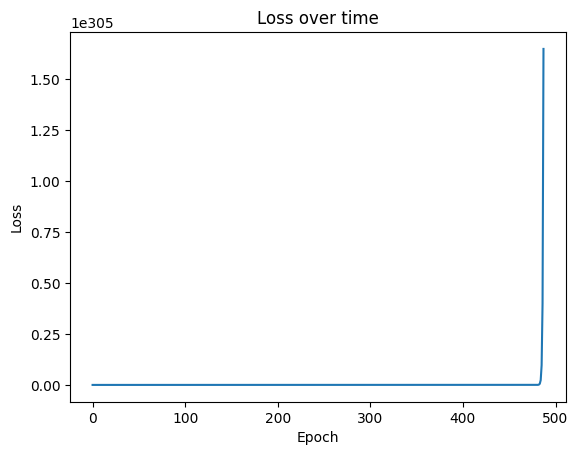

Validation Losses


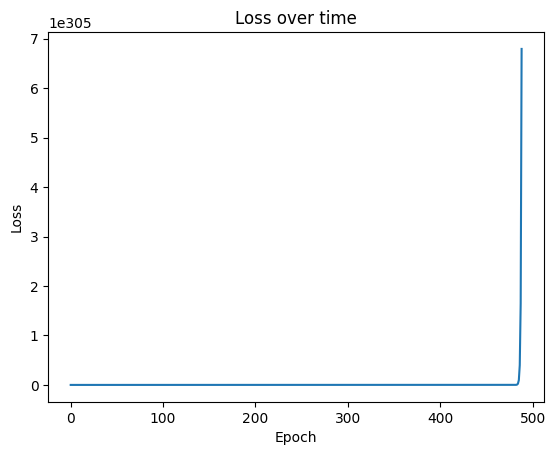

Epoch 0: Training Loss inf, Validation Loss inf
Epoch 1: Training Loss inf, Validation Loss inf
Epoch 2: Training Loss 4.59017620439256e+304, Validation Loss 4.590176204392561e+304
Epoch 3: Training Loss 1.0393391420701943e+302, Validation Loss 1.0393391420701943e+302
Epoch 4: Training Loss 2.3533428873721298e+299, Validation Loss 2.353342887372131e+299
Epoch 5: Training Loss 5.3286001858005355e+296, Validation Loss 5.328600185800536e+296
Epoch 6: Training Loss 1.2065381586539507e+294, Validation Loss 1.2065381586539506e+294
Epoch 7: Training Loss 2.7319263550064354e+291, Validation Loss 2.7319263550064354e+291
Epoch 8: Training Loss 6.185814808795713e+288, Validation Loss 6.185814808795712e+288
Epoch 9: Training Loss 1.4006345661036859e+286, Validation Loss 1.400634566103686e+286
Epoch 10: Training Loss 3.171412737696195e+283, Validation Loss 3.1714127376961947e+283
Epoch 11: Training Loss 7.180929984329081e+280, Validation Loss 7.180929984329081e+280
Epoch 12: Training Loss 1.6259553

Epoch 96: Training Loss 1.0593864457322993e+56, Validation Loss 1.0593864457322991e+56
Epoch 97: Training Loss 2.3987353657023782e+53, Validation Loss 2.3987353657023782e+53
Epoch 98: Training Loss 5.431380944933603e+50, Validation Loss 5.4313809449336025e+50
Epoch 99: Training Loss 1.2298104822559207e+48, Validation Loss 1.2298104822559208e+48
Epoch 100: Training Loss 2.7846211444206315e+45, Validation Loss 2.784621144420631e+45
Epoch 101: Training Loss 6.30512996094371e+42, Validation Loss 6.30512996094371e+42
Epoch 102: Training Loss 1.427650720244086e+40, Validation Loss 1.4276507202440858e+40
Epoch 103: Training Loss 3.2325845646937125e+37, Validation Loss 3.232584564693712e+37
Epoch 104: Training Loss 7.319439425708766e+34, Validation Loss 7.319439425708766e+34
Epoch 105: Training Loss 1.657317617975324e+32, Validation Loss 1.657317617975324e+32
Epoch 106: Training Loss 3.752612088302691e+29, Validation Loss 3.752612088302675e+29
Epoch 107: Training Loss 8.496921370134627e+26, Va

Epoch 200: Training Loss 89.28538644800658, Validation Loss 67.83551991088862
Epoch 201: Training Loss 89.22771399995521, Validation Loss 67.27395724025328
Epoch 202: Training Loss 89.2506104056338, Validation Loss 67.59104778024479
Epoch 203: Training Loss 89.26016757685647, Validation Loss 67.6683630423024
Epoch 204: Training Loss 89.23597866666536, Validation Loss 67.43684736004059
Epoch 205: Training Loss 89.22732537625639, Validation Loss 67.25707402489107
Epoch 206: Training Loss 89.23111352251443, Validation Loss 67.04294401856666
Epoch 207: Training Loss 89.2445409004049, Validation Loss 66.89561327442559
Epoch 208: Training Loss 89.22674503539581, Validation Loss 67.21077862442519
Epoch 209: Training Loss 90.0405590134546, Validation Loss 65.85253873960336
Epoch 210: Training Loss 89.69393274973537, Validation Loss 66.02896395996379
Epoch 211: Training Loss 89.23557264039148, Validation Loss 67.43133832971247
Epoch 212: Training Loss 89.60687172813228, Validation Loss 69.05271

Epoch 308: Training Loss 89.22676739032397, Validation Loss 67.17971845556114
Epoch 309: Training Loss 89.74623173373485, Validation Loss 65.99215316054841
Epoch 310: Training Loss 89.28761158657565, Validation Loss 66.66769255358345
Epoch 311: Training Loss 89.39784884001155, Validation Loss 68.35824112778975
Epoch 312: Training Loss 89.25827016555354, Validation Loss 66.803768971391
Epoch 313: Training Loss 89.2349529332068, Validation Loss 67.42269901978771
Epoch 314: Training Loss 89.27863445454936, Validation Loss 67.79440036639657
Epoch 315: Training Loss 89.24386811339993, Validation Loss 67.52781173299532
Epoch 316: Training Loss 89.4614384585655, Validation Loss 68.5912345518936
Epoch 317: Training Loss 89.44204854844506, Validation Loss 66.30226743847797
Epoch 318: Training Loss 89.70583273931926, Validation Loss 66.0201667209902
Epoch 319: Training Loss 89.23102333066929, Validation Loss 67.35866004931883
Epoch 320: Training Loss 89.2330837314023, Validation Loss 67.39461154

Epoch 417: Training Loss 89.89901258390807, Validation Loss 69.83146300535304
Epoch 418: Training Loss 89.43676555737837, Validation Loss 66.31068935937161
Epoch 419: Training Loss 89.53509854495344, Validation Loss 68.8343963427701
Epoch 420: Training Loss 89.28569815120842, Validation Loss 67.83736910034054
Epoch 421: Training Loss 89.22737415541746, Validation Loss 67.25943639653975
Epoch 422: Training Loss 89.23748170140365, Validation Loss 67.45632974408603
Epoch 423: Training Loss 89.2278833233317, Validation Loss 67.28028007716273
Epoch 424: Training Loss 89.63561701595776, Validation Loss 66.07611713372211
Epoch 425: Training Loss 89.23009978773379, Validation Loss 67.33989319759463
Epoch 426: Training Loss 89.25578727788674, Validation Loss 66.81835011488059
Epoch 427: Training Loss 89.44034932567085, Validation Loss 66.30495773974327
Epoch 428: Training Loss 89.54286945479303, Validation Loss 68.85880444462725
Epoch 429: Training Loss 89.44504627444483, Validation Loss 68.533

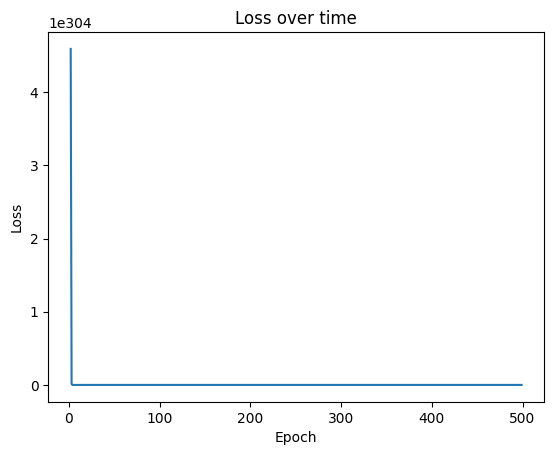

Validation Losses


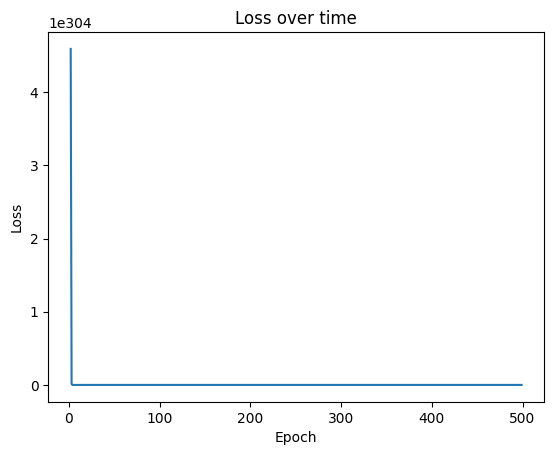

Epoch 0: Training Loss 89.25437422236426, Validation Loss 66.8269750787167
Epoch 1: Training Loss 89.22764105190524, Validation Loss 67.2710732714676
Epoch 2: Training Loss 89.24128528350865, Validation Loss 67.50067483020246
Epoch 3: Training Loss 89.67648080934948, Validation Loss 66.04234831376112
Epoch 4: Training Loss 89.76142109765262, Validation Loss 65.98231232429102
Epoch 5: Training Loss 89.44714920448362, Validation Loss 66.2942948133206
Epoch 6: Training Loss 89.92431129413853, Validation Loss 65.89639077707484
Epoch 7: Training Loss 89.2407683816864, Validation Loss 66.9276502540603
Epoch 8: Training Loss 89.39757879482765, Validation Loss 68.35718980905597
Epoch 9: Training Loss 89.24335400535668, Validation Loss 66.90524437847881
Epoch 10: Training Loss 89.57183419658246, Validation Loss 68.94804769978
Epoch 11: Training Loss 89.3494938919823, Validation Loss 66.48162766914092
Epoch 12: Training Loss 89.41164575297982, Validation Loss 68.41116511469654
Epoch 13: Training

Epoch 164: Training Loss 89.26548904057931, Validation Loss 66.76487248369646
Epoch 165: Training Loss 89.74300504264589, Validation Loss 69.43282178775
Epoch 166: Training Loss 90.0184547518474, Validation Loss 70.11806184205251
Epoch 167: Training Loss 89.3668657965251, Validation Loss 68.23318551058314
Epoch 168: Training Loss 89.28265736388474, Validation Loss 67.81915118040118
Epoch 169: Training Loss 89.22734621535162, Validation Loss 67.13770057774921
Epoch 170: Training Loss 89.6185969300458, Validation Loss 66.09127867852082
Epoch 171: Training Loss 89.26143669868802, Validation Loss 67.6778561303832
Epoch 172: Training Loss 89.27813492260736, Validation Loss 66.70610038516833
Epoch 173: Training Loss 89.29141706231006, Validation Loss 67.87060779163085
Epoch 174: Training Loss 89.64487210507129, Validation Loss 66.06815359239171
Epoch 175: Training Loss 89.95820776266218, Validation Loss 69.97520780298652
Epoch 176: Training Loss 89.41461334312807, Validation Loss 68.42235571

Epoch 320: Training Loss 90.74075914605115, Validation Loss 71.6554939172606
Epoch 321: Training Loss 89.37906333215892, Validation Loss 66.41567942684517
Epoch 322: Training Loss 89.30410807765126, Validation Loss 67.94031736328581
Epoch 323: Training Loss 89.37964038540125, Validation Loss 68.28589363109073
Epoch 324: Training Loss 89.27292876267622, Validation Loss 67.7578658599427
Epoch 325: Training Loss 89.25721182690769, Validation Loss 67.64562693062894
Epoch 326: Training Loss 89.55571267362227, Validation Loss 68.8987024154912
Epoch 327: Training Loss 89.44329482176747, Validation Loss 68.52738666136646
Epoch 328: Training Loss 89.27304656564745, Validation Loss 67.75863882901015
Epoch 329: Training Loss 89.57177157629293, Validation Loss 68.94785754885669
Epoch 330: Training Loss 89.24403437229891, Validation Loss 67.52949297796651
Epoch 331: Training Loss 89.53782741250127, Validation Loss 68.84299122910751
Epoch 332: Training Loss 89.23588011090467, Validation Loss 67.4355

Epoch 449: Training Loss 89.24221938597553, Validation Loss 66.91481827339112
Epoch 450: Training Loss 89.26514054930665, Validation Loss 67.70473734152364
Epoch 451: Training Loss 89.25225038641992, Validation Loss 67.6051692116117
Epoch 452: Training Loss 89.72679396772861, Validation Loss 69.38940378122652
Epoch 453: Training Loss 89.24066616909528, Validation Loss 67.4938532419244
Epoch 454: Training Loss 89.27208127008421, Validation Loss 67.7522801780183
Epoch 455: Training Loss 89.29357089093975, Validation Loss 67.88280874657195
Epoch 456: Training Loss 90.62673551293966, Validation Loss 65.76613689345696
Epoch 457: Training Loss 89.4062849810088, Validation Loss 68.39078094341173
Epoch 458: Training Loss 89.2303167628385, Validation Loss 67.0572342248114
Epoch 459: Training Loss 89.57120528334977, Validation Loss 66.13737542064457
Epoch 460: Training Loss 89.27929327637844, Validation Loss 66.70118147271536
Epoch 461: Training Loss 89.23770022666704, Validation Loss 67.4590549

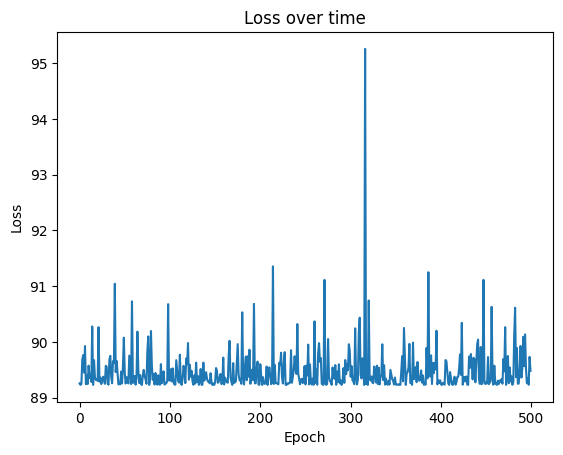

Validation Losses


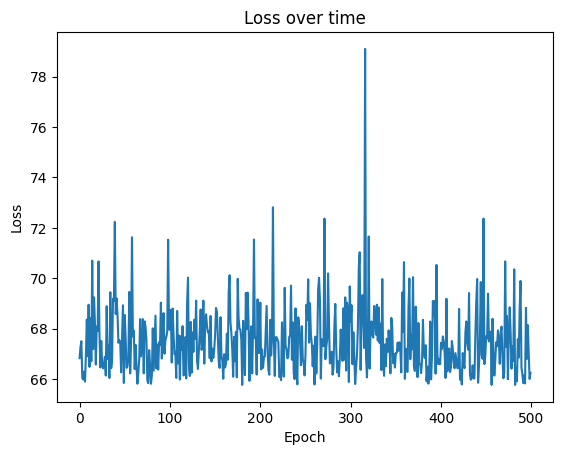

Epoch 0: Training Loss 777985.1877786323, Validation Loss 795279.3343192536
Epoch 1: Training Loss 6827454.086451147, Validation Loss 6821180.014319048
Epoch 2: Training Loss 28134977.077207047, Validation Loss 28147646.694405172
Epoch 3: Training Loss 115941148.56981298, Validation Loss 115915362.49767077
Epoch 4: Training Loss 477781600.67369294, Validation Loss 477833879.65091175
Epoch 5: Training Loss 1968889919.748572, Validation Loss 1968783726.6755881
Epoch 6: Training Loss 8113598191.824242, Validation Loss 8113813697.013169
Epoch 7: Training Loss 33435326510.22085, Validation Loss 33434888967.938095
Epoch 8: Training Loss 137783636737.50153, Validation Loss 137784524881.58627
Epoch 9: Training Loss 567792588353.1024, Validation Loss 567790785353.8611
Epoch 10: Training Loss 2339816477065.8325, Validation Loss 2339820137087.5425
Epoch 11: Training Loss 9642149720062.123, Validation Loss 9642142290151.303
Epoch 12: Training Loss 39734334781125.53, Validation Loss 39734349863777.

Epoch 259: Training Loss 3.1784009051601756e+165, Validation Loss 3.178400905160176e+165
Epoch 260: Training Loss 1.3097872290074565e+166, Validation Loss 1.3097872290074568e+166
Epoch 261: Training Loss 5.397502192016823e+166, Validation Loss 5.397502192016822e+166
Epoch 262: Training Loss 2.2242566783082128e+167, Validation Loss 2.2242566783082128e+167
Epoch 263: Training Loss 9.16593934564031e+167, Validation Loss 9.165939345640314e+167
Epoch 264: Training Loss 3.777191944944914e+168, Validation Loss 3.777191944944915e+168
Epoch 265: Training Loss 1.556543028592348e+169, Validation Loss 1.556543028592348e+169
Epoch 266: Training Loss 6.414358166526205e+169, Validation Loss 6.414358166526203e+169
Epoch 267: Training Loss 2.643292856843783e+170, Validation Loss 2.643292856843783e+170
Epoch 268: Training Loss 1.0892745533767545e+171, Validation Loss 1.089274553376754e+171
Epoch 269: Training Loss 4.488791507010268e+171, Validation Loss 4.488791507010269e+171
Epoch 270: Training Loss 1.

Epoch 417: Training Loss 4.687665957087903e+262, Validation Loss 4.687665957087905e+262
Epoch 418: Training Loss 1.931740264256354e+263, Validation Loss 1.931740264256354e+263
Epoch 419: Training Loss 7.960508454974014e+263, Validation Loss 7.960508454974012e+263
Epoch 420: Training Loss 3.280445929210242e+264, Validation Loss 3.2804459292102427e+264
Epoch 421: Training Loss 1.351838962968249e+265, Validation Loss 1.3518389629682489e+265
Epoch 422: Training Loss 5.5707931824958536e+265, Validation Loss 5.570793182495853e+265
Epoch 423: Training Loss 2.2956681625747185e+266, Validation Loss 2.2956681625747185e+266
Epoch 424: Training Loss 9.460218931154157e+266, Validation Loss 9.460218931154155e+266
Epoch 425: Training Loss 3.8984616193393163e+267, Validation Loss 3.898461619339316e+267
Epoch 426: Training Loss 1.6065170487135377e+268, Validation Loss 1.6065170487135375e+268
Epoch 427: Training Loss 6.620296106043624e+268, Validation Loss 6.620296106043624e+268
Epoch 428: Training Loss

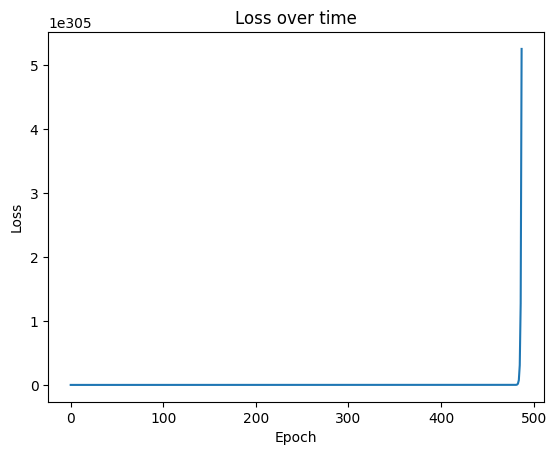

Validation Losses


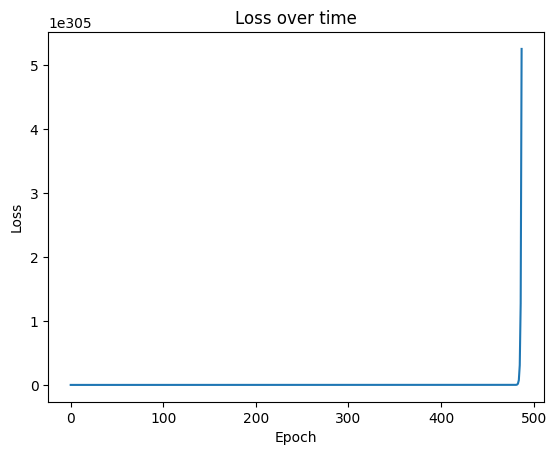

Epoch 0: Training Loss inf, Validation Loss inf
Epoch 1: Training Loss inf, Validation Loss inf
Epoch 2: Training Loss 1.4624824137205717e+305, Validation Loss 1.4624824137205715e+305
Epoch 3: Training Loss 3.311452871274315e+302, Validation Loss 3.3114528712743152e+302
Epoch 4: Training Loss 7.498018448491274e+299, Validation Loss 7.498018448491273e+299
Epoch 5: Training Loss 1.69775270370316e+297, Validation Loss 1.69775270370316e+297
Epoch 6: Training Loss 3.8441679794897923e+294, Validation Loss 3.844167979489792e+294
Epoch 7: Training Loss 8.704228491170407e+291, Validation Loss 8.704228491170405e+291
Epoch 8: Training Loss 1.9708710449369655e+289, Validation Loss 1.9708710449369655e+289
Epoch 9: Training Loss 4.462581238200725e+286, Validation Loss 4.462581238200725e+286
Epoch 10: Training Loss 1.0104482157115495e+284, Validation Loss 1.01044821571155e+284
Epoch 11: Training Loss 2.2879260726832525e+281, Validation Loss 2.2879260726832525e+281
Epoch 12: Training Loss 5.1804789524

Epoch 95: Training Loss 1.4906915207017325e+59, Validation Loss 1.4906915207017325e+59
Epoch 96: Training Loss 3.375325863819376e+56, Validation Loss 3.375325863819376e+56
Epoch 97: Training Loss 7.642644053952189e+53, Validation Loss 7.642644053952191e+53
Epoch 98: Training Loss 1.7304998240767308e+51, Validation Loss 1.7304998240767304e+51
Epoch 99: Training Loss 3.918316252843156e+48, Validation Loss 3.9183162528431544e+48
Epoch 100: Training Loss 8.872120091365019e+45, Validation Loss 8.872120091365015e+45
Epoch 101: Training Loss 2.0088862112262368e+43, Validation Loss 2.0088862112262373e+43
Epoch 102: Training Loss 4.548657782013882e+40, Validation Loss 4.548657782013882e+40
Epoch 103: Training Loss 1.029938256445396e+38, Validation Loss 1.0299382564453959e+38
Epoch 104: Training Loss 2.3320567581149875e+35, Validation Loss 2.332056758114988e+35
Epoch 105: Training Loss 5.280402673689889e+32, Validation Loss 5.280402673689887e+32
Epoch 106: Training Loss 1.1956249477756774e+30, V

Epoch 199: Training Loss 89.78597140862303, Validation Loss 69.54589822548792
Epoch 200: Training Loss 89.47855754607677, Validation Loss 66.24833432641984
Epoch 201: Training Loss 89.50542044611176, Validation Loss 68.73916380902324
Epoch 202: Training Loss 89.2328962484329, Validation Loss 67.01530194683733
Epoch 203: Training Loss 89.47235292754948, Validation Loss 66.25701352736773
Epoch 204: Training Loss 89.54824027808563, Validation Loss 66.16202809137478
Epoch 205: Training Loss 89.24422989592749, Validation Loss 67.53146088067231
Epoch 206: Training Loss 90.15248066934264, Validation Loss 70.42524912937638
Epoch 207: Training Loss 89.57911623190071, Validation Loss 68.97008202861805
Epoch 208: Training Loss 89.45605053466535, Validation Loss 66.28073872745496
Epoch 209: Training Loss 89.3639694418021, Validation Loss 66.44805619470884
Epoch 210: Training Loss 89.41646506285507, Validation Loss 66.34472684636732
Epoch 211: Training Loss 89.52704638200636, Validation Loss 66.186

Epoch 309: Training Loss 89.30074514768381, Validation Loss 66.62026072419137
Epoch 310: Training Loss 89.36663651563107, Validation Loss 68.23222321861527
Epoch 311: Training Loss 89.53555410525338, Validation Loss 68.83583298244554
Epoch 312: Training Loss 89.74045405284961, Validation Loss 65.99599228853698
Epoch 313: Training Loss 89.23114496207397, Validation Loss 67.0424094403116
Epoch 314: Training Loss 89.22850992954035, Validation Loss 67.09764041289797
Epoch 315: Training Loss 89.73178411896022, Validation Loss 69.40281524255741
Epoch 316: Training Loss 89.25481590905893, Validation Loss 67.62648197051335
Epoch 317: Training Loss 89.26655524476396, Validation Loss 67.71470793429296
Epoch 318: Training Loss 89.3320583538474, Validation Loss 66.52600038341409
Epoch 319: Training Loss 89.23226357696075, Validation Loss 67.02455497449417
Epoch 320: Training Loss 89.24807516092075, Validation Loss 67.56834195717194
Epoch 321: Training Loss 89.59661149768358, Validation Loss 69.022

Epoch 416: Training Loss 89.48526872152584, Validation Loss 68.67248822767365
Epoch 417: Training Loss 89.23012258242093, Validation Loss 67.34038382903793
Epoch 418: Training Loss 89.63963585733084, Validation Loss 66.07263543521482
Epoch 419: Training Loss 89.55857165258601, Validation Loss 66.1507339060402
Epoch 420: Training Loss 89.4281685445466, Validation Loss 68.47267122364575
Epoch 421: Training Loss 89.22672553654492, Validation Loss 67.18890163014507
Epoch 422: Training Loss 89.4969658447235, Validation Loss 66.22363183063767
Epoch 423: Training Loss 89.23558346295508, Validation Loss 67.43148667102074
Epoch 424: Training Loss 89.24166420527636, Validation Loss 67.50478504395456
Epoch 425: Training Loss 89.34016260996472, Validation Loss 68.1166419234954
Epoch 426: Training Loss 89.23602565862913, Validation Loss 67.4374776731332
Epoch 427: Training Loss 89.2267315578563, Validation Loss 67.2075108344651
Epoch 428: Training Loss 89.28942833335596, Validation Loss 66.66076643

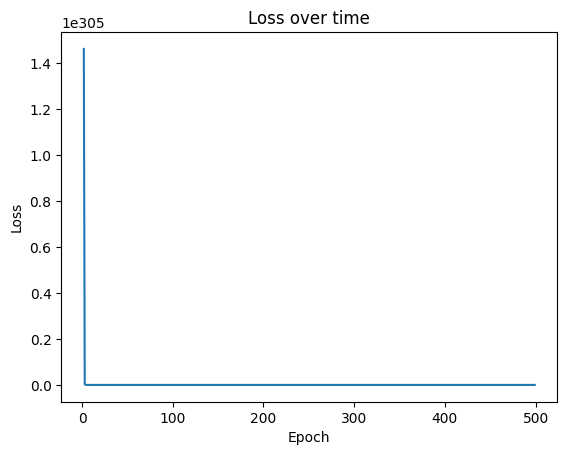

Validation Losses


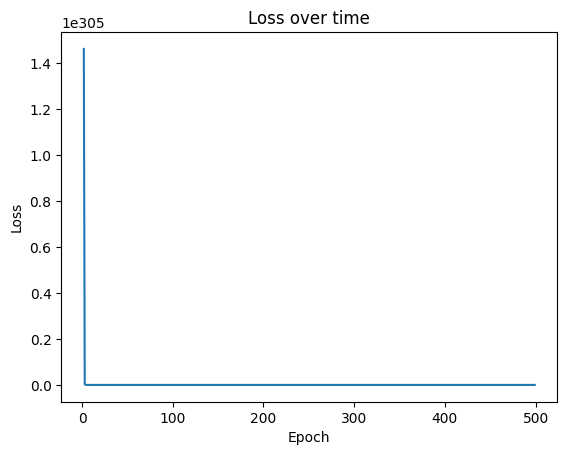

Epoch 0: Training Loss 89.44877614279835, Validation Loss 66.2917836975396
Epoch 1: Training Loss 89.47892789945105, Validation Loss 66.24782209572828
Epoch 2: Training Loss 89.3104796033043, Validation Loss 67.97354719336259
Epoch 3: Training Loss 89.24823596296713, Validation Loss 66.86775767630543
Epoch 4: Training Loss 89.47641013894508, Validation Loss 66.25131721615097
Epoch 5: Training Loss 90.49024000255868, Validation Loss 65.77119178624494
Epoch 6: Training Loss 89.25789754011217, Validation Loss 66.80591331927006
Epoch 7: Training Loss 89.3911928809808, Validation Loss 68.3321453775447
Epoch 8: Training Loss 89.23081762047859, Validation Loss 67.04807771651105
Epoch 9: Training Loss 89.57264497280688, Validation Loss 66.1358835986191
Epoch 10: Training Loss 89.25917178108418, Validation Loss 67.66080461213163
Epoch 11: Training Loss 89.31324932318233, Validation Loss 66.57992815553888
Epoch 12: Training Loss 89.2859827004736, Validation Loss 66.6740140343376
Epoch 13: Traini

Epoch 154: Training Loss 89.83676438283057, Validation Loss 65.93844814374336
Epoch 155: Training Loss 89.22919332804348, Validation Loss 67.08058598787248
Epoch 156: Training Loss 90.67459638868607, Validation Loss 65.76601187626378
Epoch 157: Training Loss 89.23372121289957, Validation Loss 67.0039680976473
Epoch 158: Training Loss 89.27893708997375, Validation Loss 66.70268681545332
Epoch 159: Training Loss 89.94918535422843, Validation Loss 69.95352556825806
Epoch 160: Training Loss 89.24137975987439, Validation Loss 67.5017041239564
Epoch 161: Training Loss 89.23501570288681, Validation Loss 66.98754617828456
Epoch 162: Training Loss 89.40801938607697, Validation Loss 66.35974085250909
Epoch 163: Training Loss 89.5708274881857, Validation Loss 68.94498935454051
Epoch 164: Training Loss 89.22671493326068, Validation Loss 67.19419434558272
Epoch 165: Training Loss 89.27114920090973, Validation Loss 66.73731501676943
Epoch 166: Training Loss 89.27752218259943, Validation Loss 66.7087

Epoch 298: Training Loss 89.45952819572862, Validation Loss 66.27556116648051
Epoch 299: Training Loss 89.43254843850022, Validation Loss 66.31753628492565
Epoch 300: Training Loss 89.28456565928661, Validation Loss 67.83063090716874
Epoch 301: Training Loss 89.49662576748459, Validation Loss 68.71027919086039
Epoch 302: Training Loss 89.23042056681855, Validation Loss 67.05528391693613
Epoch 303: Training Loss 89.22765024439111, Validation Loss 67.12496014358105
Epoch 304: Training Loss 89.93684325538504, Validation Loss 69.923736875714
Epoch 305: Training Loss 89.42093135638191, Validation Loss 66.3369980101274
Epoch 306: Training Loss 89.41705591004408, Validation Loss 66.3436962197099
Epoch 307: Training Loss 89.3470338100057, Validation Loss 68.14756038581115
Epoch 308: Training Loss 89.33619548915115, Validation Loss 68.09845848064585
Epoch 309: Training Loss 89.3039800885597, Validation Loss 66.60942372423855
Epoch 310: Training Loss 89.86387820984845, Validation Loss 69.7443763

Epoch 447: Training Loss 89.26664985493606, Validation Loss 66.75903272506302
Epoch 448: Training Loss 89.22951518331239, Validation Loss 67.07341155823927
Epoch 449: Training Loss 89.25809718684548, Validation Loss 67.65253410867243
Epoch 450: Training Loss 89.22939241687433, Validation Loss 67.323792533734
Epoch 451: Training Loss 89.23078628513066, Validation Loss 67.35404219117522
Epoch 452: Training Loss 89.25577679364255, Validation Loss 66.81841319870064
Epoch 453: Training Loss 89.24137417649007, Validation Loss 66.92220726302884
Epoch 454: Training Loss 89.2267169734986, Validation Loss 67.2018633662979
Epoch 455: Training Loss 89.47583031814885, Validation Loss 68.64063652066439
Epoch 456: Training Loss 90.49336461254366, Validation Loss 65.77099285754764
Epoch 457: Training Loss 89.27637643295832, Validation Loss 66.71370012586453
Epoch 458: Training Loss 89.4438039006261, Validation Loss 68.52920367097174
Epoch 459: Training Loss 89.51084522083977, Validation Loss 66.205969

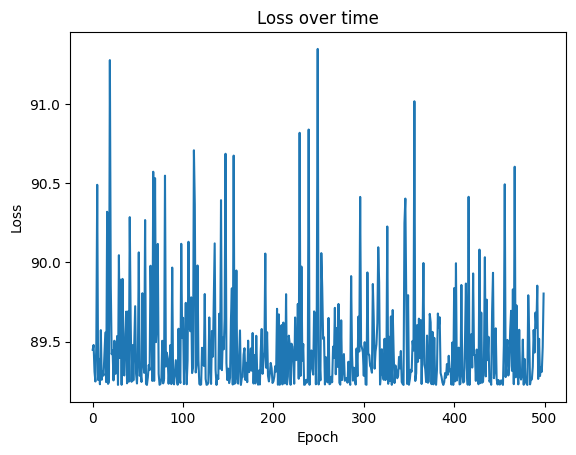

Validation Losses


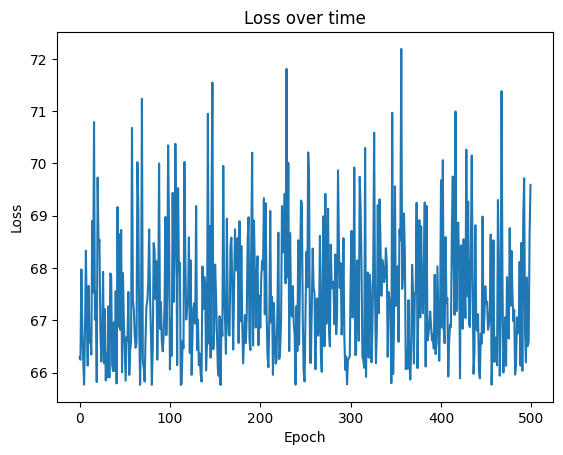

Epoch 0: Training Loss 124.75837945075249, Validation Loss 88.66465983292518
Epoch 1: Training Loss 89.62701727112777, Validation Loss 66.43470279403061
Epoch 2: Training Loss 89.3339584946514, Validation Loss 67.22713502987426
Epoch 3: Training Loss 89.2881991750368, Validation Loss 67.28948349317682
Epoch 4: Training Loss 89.24409367037693, Validation Loss 67.26320323851981
Epoch 5: Training Loss 89.1953653256408, Validation Loss 67.2255072552956
Epoch 6: Training Loss 89.13616801281353, Validation Loss 67.17922109203373
Epoch 7: Training Loss 89.05643758580965, Validation Loss 67.11659111954953
Epoch 8: Training Loss 88.93548317547952, Validation Loss 67.0199301495371
Epoch 9: Training Loss 88.72247152364942, Validation Loss 66.84437824012403
Epoch 10: Training Loss 88.2611378145561, Validation Loss 66.44695400904857
Epoch 11: Training Loss 86.9030559014327, Validation Loss 65.20440740953424
Epoch 12: Training Loss 81.53269635638895, Validation Loss 59.825521814267624
Epoch 13: Trai

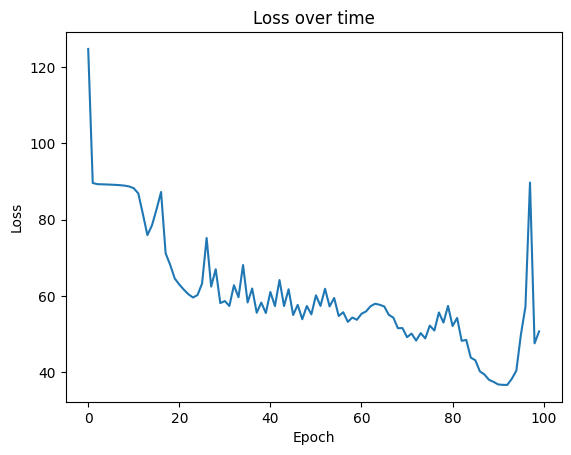

Validation Losses


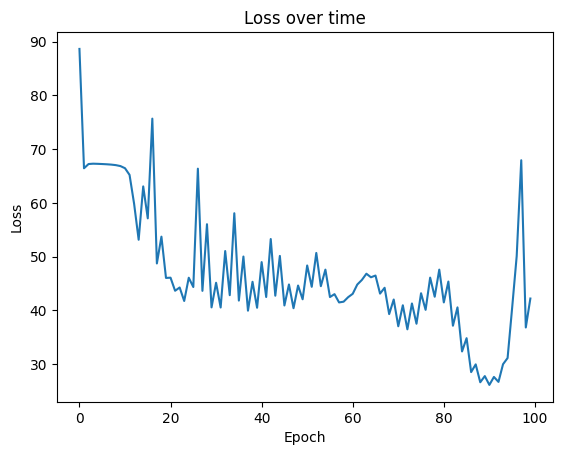

Epoch 0: Training Loss 35.88919787854854, Validation Loss 26.32826544285778
Epoch 1: Training Loss 35.40583309556002, Validation Loss 26.2019578159302
Epoch 2: Training Loss 34.92425836694653, Validation Loss 25.401348712763255
Epoch 3: Training Loss 34.419455140047155, Validation Loss 25.272810624375918
Epoch 4: Training Loss 33.92984265490358, Validation Loss 25.25574795346664
Epoch 5: Training Loss 33.503470010293576, Validation Loss 25.28634559470865
Epoch 6: Training Loss 33.161427577328524, Validation Loss 25.183683217065703
Epoch 7: Training Loss 32.87637081814146, Validation Loss 25.116775911395585
Epoch 8: Training Loss 32.683477020016525, Validation Loss 25.253287629913146
Epoch 9: Training Loss 32.386682133878345, Validation Loss 25.043576329751147
Epoch 10: Training Loss 32.172025059389, Validation Loss 24.916852650837836
Epoch 11: Training Loss 32.06040886533151, Validation Loss 24.786677176414095
Epoch 12: Training Loss 31.76287466200299, Validation Loss 24.62059245414905

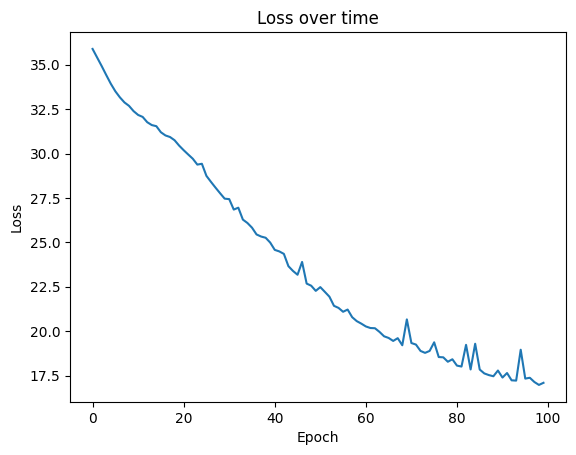

Validation Losses


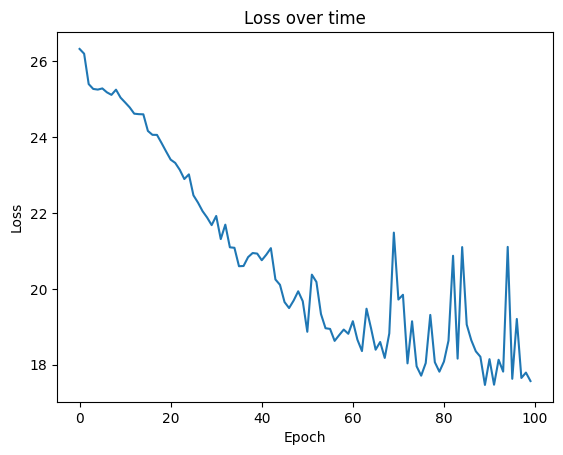

Epoch 0: Training Loss 16.953425433229906, Validation Loss 17.616335433216925
Epoch 1: Training Loss 16.914198299605285, Validation Loss 18.4997083087143
Epoch 2: Training Loss 17.173173914024193, Validation Loss 19.264975931456075
Epoch 3: Training Loss 16.925848662047454, Validation Loss 18.98648373776398
Epoch 4: Training Loss 16.727884334368884, Validation Loss 17.64300269139737
Epoch 5: Training Loss 17.274859114366144, Validation Loss 19.487884926124305
Epoch 6: Training Loss 16.802298985735327, Validation Loss 18.51996212629713
Epoch 7: Training Loss 16.643079839039903, Validation Loss 17.721172579035702
Epoch 8: Training Loss 16.541388001790786, Validation Loss 17.851578129825295
Epoch 9: Training Loss 17.211864326649298, Validation Loss 17.216902479307738
Epoch 10: Training Loss 16.485954075927335, Validation Loss 18.227845508390512
Epoch 11: Training Loss 16.47433324460359, Validation Loss 17.737273901723484
Epoch 12: Training Loss 16.78017270279009, Validation Loss 17.394598

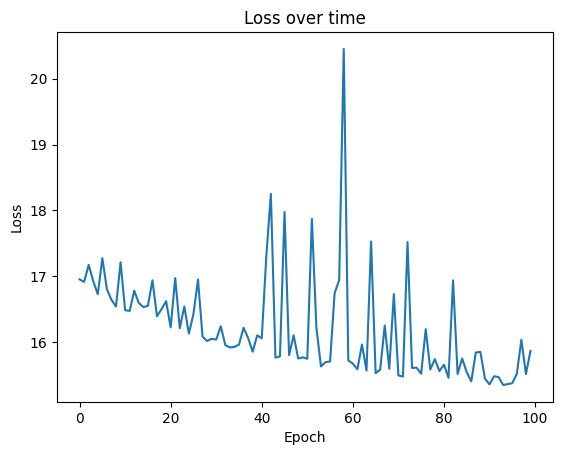

Validation Losses


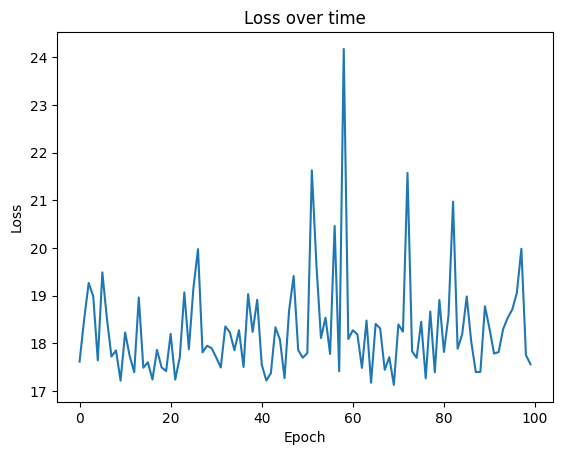

Epoch 0: Training Loss 170.93398377815532, Validation Loss 128.00026718661186
Epoch 1: Training Loss 101.43321538220906, Validation Loss 88.79754013472146
Epoch 2: Training Loss 94.93930326618711, Validation Loss 66.7026195188451
Epoch 3: Training Loss 85.25837241217646, Validation Loss 66.627995975741
Epoch 4: Training Loss 82.2179160719385, Validation Loss 61.54051553458395
Epoch 5: Training Loss 79.24477039722323, Validation Loss 60.68211485687947
Epoch 6: Training Loss 76.24384625207372, Validation Loss 56.71583057678815
Epoch 7: Training Loss 73.48713877536674, Validation Loss 55.85893416126793
Epoch 8: Training Loss 71.03912070767554, Validation Loss 51.61683516910422
Epoch 9: Training Loss 69.4199345472897, Validation Loss 53.87529588291134
Epoch 10: Training Loss 70.7042946347678, Validation Loss 49.56474425088219
Epoch 11: Training Loss 77.86786349508718, Validation Loss 67.10674194587907
Epoch 12: Training Loss 101.67649180017492, Validation Loss 73.07907574185042
Epoch 13: T

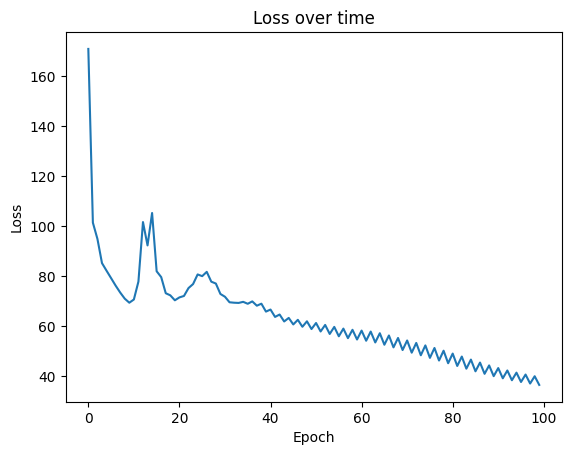

Validation Losses


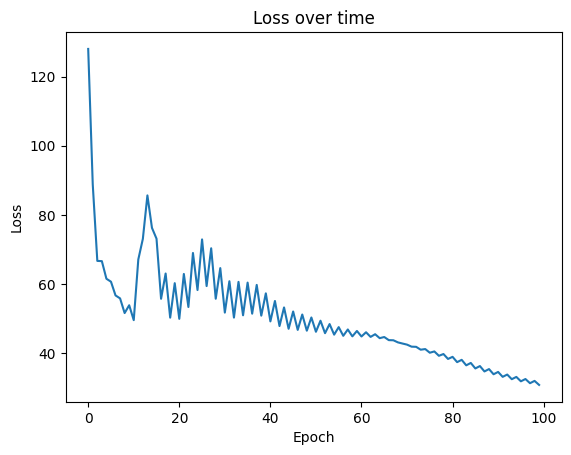

Epoch 0: Training Loss 25.277488941803146, Validation Loss 19.600454480397158
Epoch 1: Training Loss 24.752123099049573, Validation Loss 19.185563715036597
Epoch 2: Training Loss 24.336634879162602, Validation Loss 18.90574224662233
Epoch 3: Training Loss 24.06067800864352, Validation Loss 18.73720740933051
Epoch 4: Training Loss 23.849352816576655, Validation Loss 18.617229285220215
Epoch 5: Training Loss 23.63190993195387, Validation Loss 18.449636780114933
Epoch 6: Training Loss 23.37973122800251, Validation Loss 18.257173842488662
Epoch 7: Training Loss 23.11211656930486, Validation Loss 18.06880109484393
Epoch 8: Training Loss 22.87235633707479, Validation Loss 17.90937886816188
Epoch 9: Training Loss 22.663763144129717, Validation Loss 17.75574230391402
Epoch 10: Training Loss 22.455617834081057, Validation Loss 17.614740060629043
Epoch 11: Training Loss 22.243798263249477, Validation Loss 17.45311461126153
Epoch 12: Training Loss 22.065910191941907, Validation Loss 17.3187713135

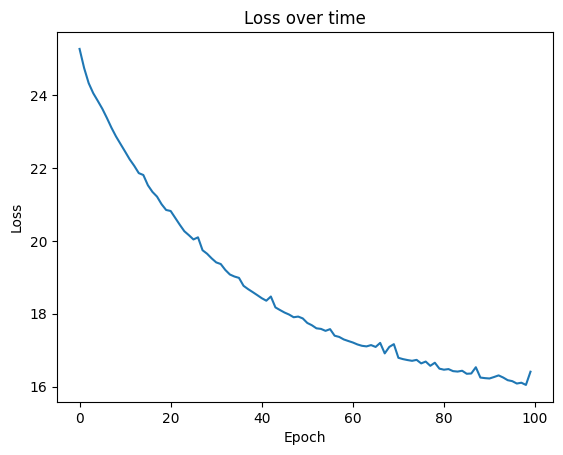

Validation Losses


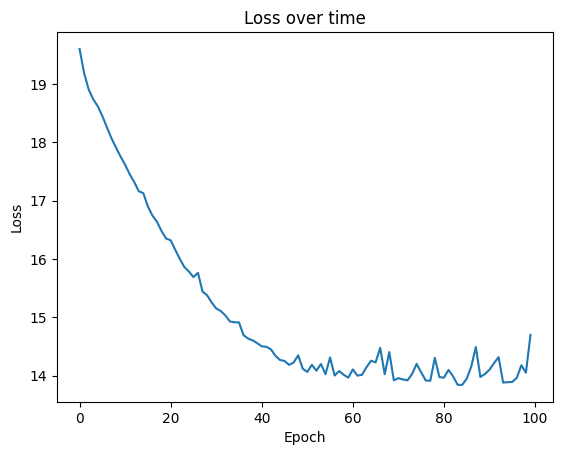

Epoch 0: Training Loss 15.992436847705465, Validation Loss 13.968178490684588
Epoch 1: Training Loss 15.995647376911128, Validation Loss 14.050257536249473
Epoch 2: Training Loss 15.974832986514086, Validation Loss 13.848035675052522
Epoch 3: Training Loss 15.964466383241364, Validation Loss 14.059169377848
Epoch 4: Training Loss 15.976773393796844, Validation Loss 13.803883510793586
Epoch 5: Training Loss 16.14470073606822, Validation Loss 13.857564375756972
Epoch 6: Training Loss 15.984408435171998, Validation Loss 13.864760416612087
Epoch 7: Training Loss 16.37784945107718, Validation Loss 14.818306764431707
Epoch 8: Training Loss 15.890273543822014, Validation Loss 14.155494585847626
Epoch 9: Training Loss 15.923192227587462, Validation Loss 13.88942000125245
Epoch 10: Training Loss 15.86061813483681, Validation Loss 14.148400496021706
Epoch 11: Training Loss 16.00674404885568, Validation Loss 14.421923142410485
Epoch 12: Training Loss 15.94260465580162, Validation Loss 14.34159365

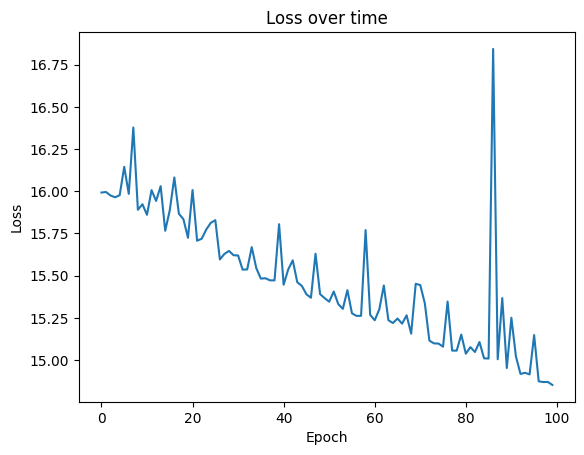

Validation Losses


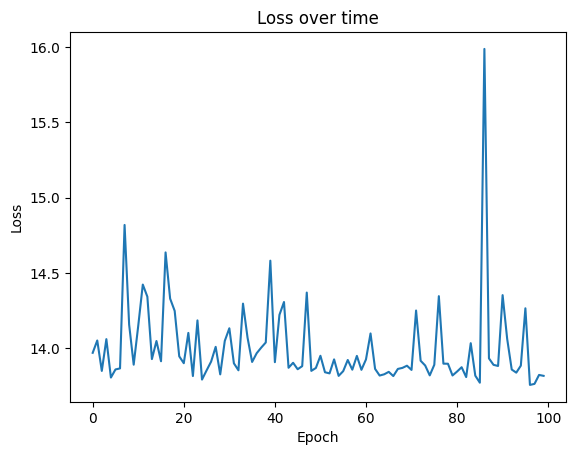

Epoch 0: Training Loss 270.4332958526237, Validation Loss 216.19906866541848
Epoch 1: Training Loss 90.22846819835566, Validation Loss 65.80418783177706
Epoch 2: Training Loss 89.2717254607273, Validation Loss 67.74998183686874
Epoch 3: Training Loss 89.22872018941885, Validation Loss 67.09163719065332
Epoch 4: Training Loss 89.22677718420903, Validation Loss 67.22015667773108
Epoch 5: Training Loss 89.2266711062353, Validation Loss 67.19241008432232
Epoch 6: Training Loss 89.2266189861771, Validation Loss 67.19826294689226
Epoch 7: Training Loss 89.12903506000619, Validation Loss 67.07101607710925
Epoch 8: Training Loss 83.70919437361826, Validation Loss 62.9060974587107
Epoch 9: Training Loss 82.02479926690158, Validation Loss 65.21994369128711
Epoch 10: Training Loss 81.83714681464548, Validation Loss 62.85971602685428
Epoch 11: Training Loss 78.50199303722842, Validation Loss 63.248699771561846
Epoch 12: Training Loss 76.03640046773172, Validation Loss 58.880134188184705
Epoch 13: 

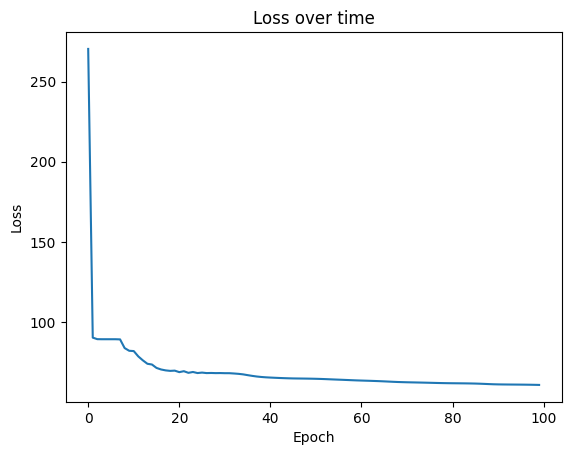

Validation Losses


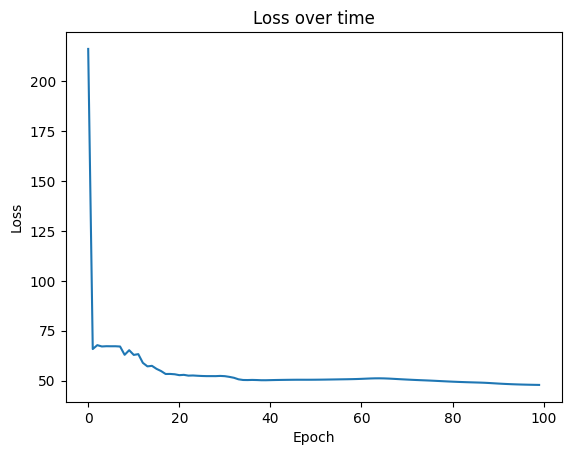

Epoch 0: Training Loss 60.743181338276216, Validation Loss 48.208050754004745
Epoch 1: Training Loss 60.62387630520481, Validation Loss 48.00664280987757
Epoch 2: Training Loss 60.43252782347321, Validation Loss 47.692471982619686
Epoch 3: Training Loss 60.48309043075009, Validation Loss 48.14949696329525
Epoch 4: Training Loss 60.16666618240914, Validation Loss 47.45783775774989
Epoch 5: Training Loss 60.2901482771424, Validation Loss 48.209420137081366
Epoch 6: Training Loss 60.02750502227596, Validation Loss 47.75814359270735
Epoch 7: Training Loss 60.03168135228516, Validation Loss 48.29051740757414
Epoch 8: Training Loss 59.67506776990793, Validation Loss 47.56089396841772
Epoch 9: Training Loss 59.41642758538584, Validation Loss 46.825270596359935
Epoch 10: Training Loss 59.257283131329636, Validation Loss 47.05137672317691
Epoch 11: Training Loss 59.13842000776126, Validation Loss 47.51378371746453
Epoch 12: Training Loss 58.76645545972239, Validation Loss 46.79567812305269
Epoc

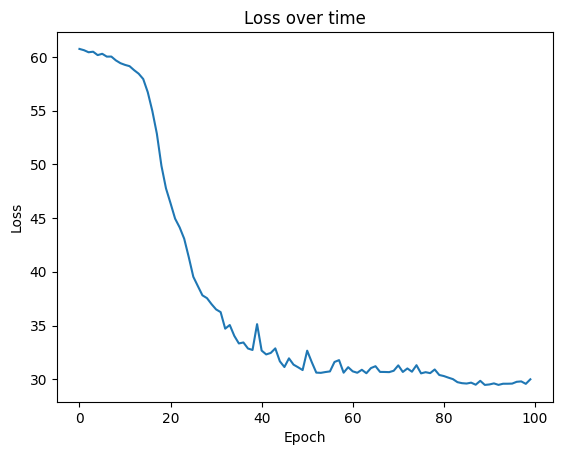

Validation Losses


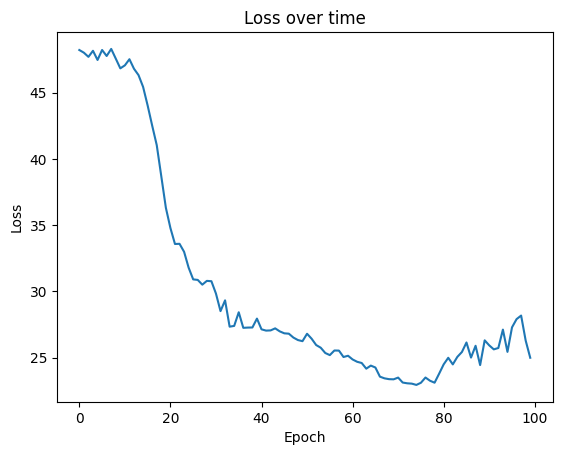

Epoch 0: Training Loss 29.83040550749566, Validation Loss 27.863611734013716
Epoch 1: Training Loss 30.634634938155425, Validation Loss 24.334712076545415
Epoch 2: Training Loss 29.62212341110615, Validation Loss 26.695866284669425
Epoch 3: Training Loss 29.65806429344347, Validation Loss 27.298907277502895
Epoch 4: Training Loss 30.308978067043018, Validation Loss 24.81572137252235
Epoch 5: Training Loss 29.909312515431743, Validation Loss 25.13404185812311
Epoch 6: Training Loss 30.125809172648545, Validation Loss 24.784452425656564
Epoch 7: Training Loss 30.214113425040686, Validation Loss 24.858091877281485
Epoch 8: Training Loss 29.98763685845303, Validation Loss 28.143092546778817
Epoch 9: Training Loss 29.72145102884971, Validation Loss 26.778257835287807
Epoch 10: Training Loss 29.865034758737075, Validation Loss 25.914280013520134
Epoch 11: Training Loss 29.835410518641464, Validation Loss 26.144600948446314
Epoch 12: Training Loss 29.814974778162313, Validation Loss 28.069504

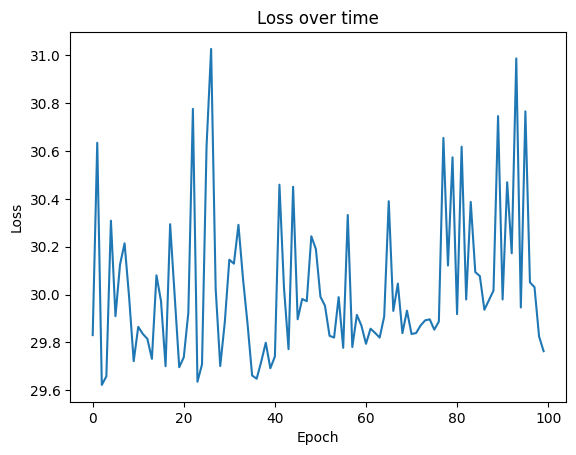

Validation Losses


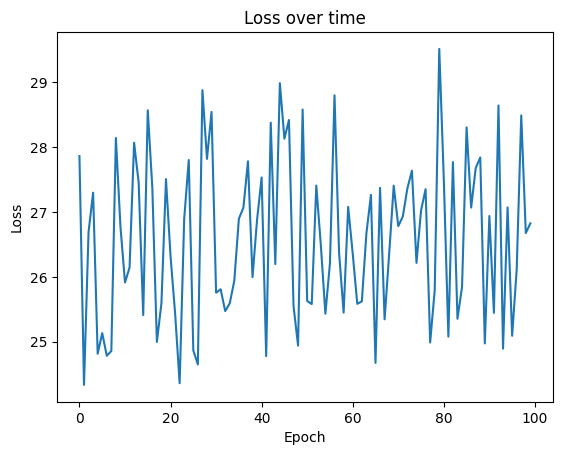

Epoch 0: Training Loss 1033.3497012905718, Validation Loss 940.7705056790005
Epoch 1: Training Loss 356.2666742866628, Validation Loss 295.1366178398977
Epoch 2: Training Loss 369.02632175675404, Validation Loss 387.02072907034
Epoch 3: Training Loss 1205.6284479317362, Validation Loss 1103.9415317579653
Epoch 4: Training Loss 507.5442709744823, Validation Loss 436.5766765516602
Epoch 5: Training Loss 393.99197102350803, Validation Loss 413.7338321798985
Epoch 6: Training Loss 293.1524280077005, Validation Loss 236.95404948380758
Epoch 7: Training Loss 305.38930432461353, Validation Loss 318.53903016371254
Epoch 8: Training Loss 233.86626720126878, Validation Loss 183.06027596814815
Epoch 9: Training Loss 292.0971572298512, Validation Loss 304.0052666200423
Epoch 10: Training Loss 134.06372868867905, Validation Loss 98.39395942748357
Epoch 11: Training Loss 192.01350780987454, Validation Loss 197.25195722276854
Epoch 12: Training Loss 123.4363973935028, Validation Loss 87.8836634367063

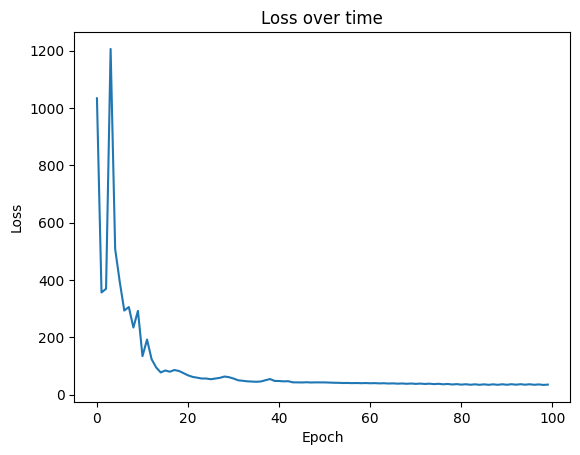

Validation Losses


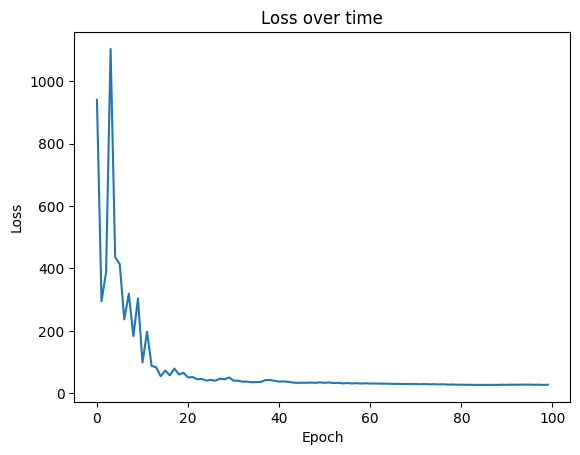

Epoch 0: Training Loss 30.387392313720735, Validation Loss 23.264532684435604
Epoch 1: Training Loss 30.315756920732515, Validation Loss 23.3882648406378
Epoch 2: Training Loss 29.93566785724967, Validation Loss 23.00372460996851
Epoch 3: Training Loss 29.6922795922026, Validation Loss 22.998370793876436
Epoch 4: Training Loss 29.209323243663214, Validation Loss 22.75718537937247
Epoch 5: Training Loss 28.544499086811093, Validation Loss 21.854980776379374
Epoch 6: Training Loss 27.967647939579102, Validation Loss 21.59637013051003
Epoch 7: Training Loss 27.667839216654304, Validation Loss 21.919688045948163
Epoch 8: Training Loss 27.034007699237083, Validation Loss 21.438262465372432
Epoch 9: Training Loss 26.449587241710578, Validation Loss 21.2617511038531
Epoch 10: Training Loss 25.940125841620503, Validation Loss 21.357040076007028
Epoch 11: Training Loss 25.582717349109675, Validation Loss 21.37693104667435
Epoch 12: Training Loss 25.206724449785515, Validation Loss 21.5390196944

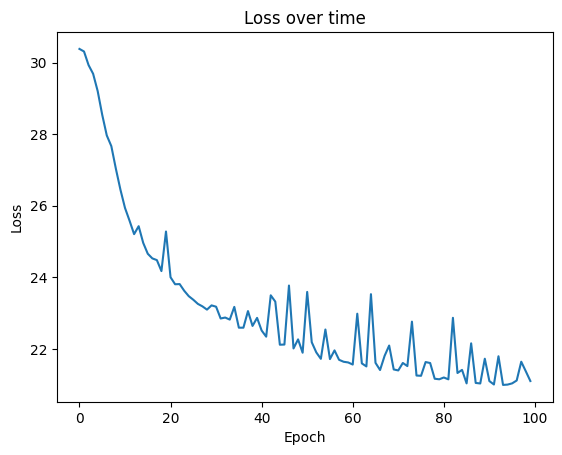

Validation Losses


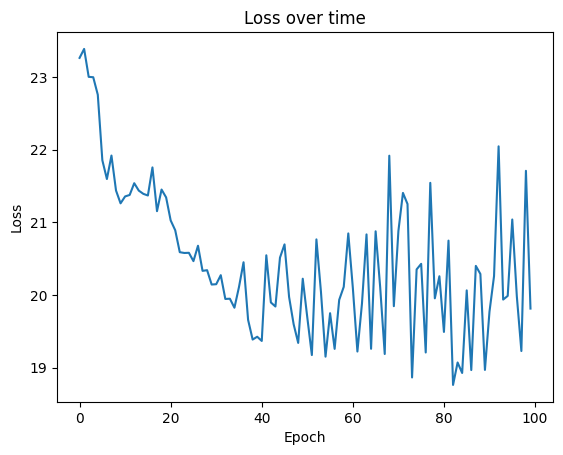

Epoch 0: Training Loss 21.191972216688796, Validation Loss 21.391977460745597
Epoch 1: Training Loss 22.806491355348243, Validation Loss 22.721321753403807
Epoch 2: Training Loss 21.424294894860157, Validation Loss 19.892780791169557
Epoch 3: Training Loss 21.526158421174816, Validation Loss 19.807394507519472
Epoch 4: Training Loss 21.83367723835463, Validation Loss 19.39289363961807
Epoch 5: Training Loss 21.1942494049772, Validation Loss 20.31759040561738
Epoch 6: Training Loss 21.161872500921444, Validation Loss 20.33181328956414
Epoch 7: Training Loss 21.321226736252278, Validation Loss 20.38734608602055
Epoch 8: Training Loss 21.393973656061274, Validation Loss 19.968847931355846
Epoch 9: Training Loss 21.144269343668068, Validation Loss 20.934242713763748
Epoch 10: Training Loss 22.126428346793762, Validation Loss 22.486361344306435
Epoch 11: Training Loss 21.15384500813911, Validation Loss 21.303508978922498
Epoch 12: Training Loss 22.051470887341825, Validation Loss 22.4917969

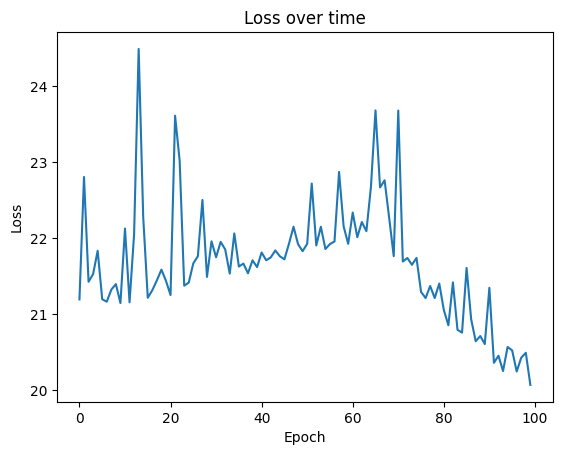

Validation Losses


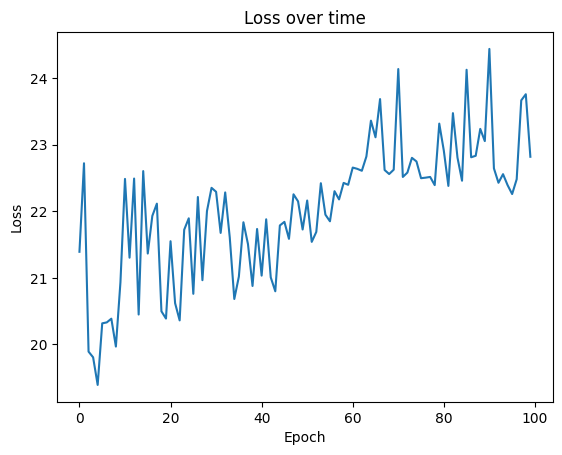

Epoch 0: Training Loss 4036.998677820284, Validation Loss 4277.329154888545
Epoch 1: Training Loss 1293.8282897728138, Validation Loss 1188.753152100735
Epoch 2: Training Loss 674.4330005570661, Validation Loss 594.5207065963264
Epoch 3: Training Loss 373.52519449845283, Validation Loss 311.15140260451693
Epoch 4: Training Loss 227.34147414492395, Validation Loss 177.19201819155035
Epoch 5: Training Loss 156.32410714369644, Validation Loss 114.69501334089473
Epoch 6: Training Loss 121.8232310981971, Validation Loss 86.13282971434397
Epoch 7: Training Loss 105.06239500740911, Validation Loss 73.51126223956315
Epoch 8: Training Loss 96.91982998697951, Validation Loss 68.25376744449053
Epoch 9: Training Loss 92.9640986169696, Validation Loss 66.30893002155447
Epoch 10: Training Loss 91.04236871583646, Validation Loss 65.78879320153177
Epoch 11: Training Loss 90.10877503429688, Validation Loss 65.83210989752618
Epoch 12: Training Loss 89.65522682146182, Validation Loss 66.05946821783232
Ep

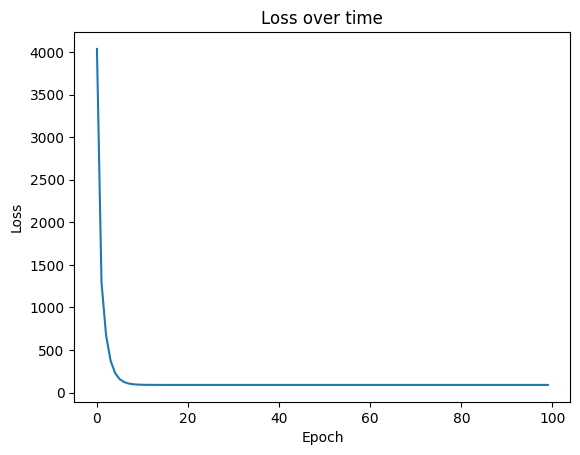

Validation Losses


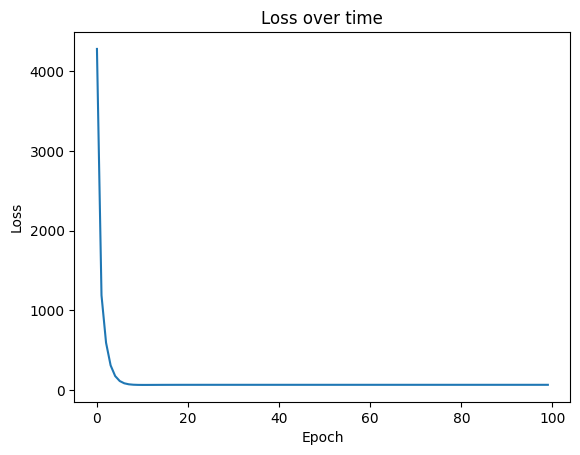

Epoch 0: Training Loss 89.22671370525325, Validation Loss 67.195714060262
Epoch 1: Training Loss 89.22709880566397, Validation Loss 67.15066929117056
Epoch 2: Training Loss 89.22721453743632, Validation Loss 67.14419544758124
Epoch 3: Training Loss 89.22672062152412, Validation Loss 67.19079087153855
Epoch 4: Training Loss 89.22680238430107, Validation Loss 67.17476790608312
Epoch 5: Training Loss 89.22695195909607, Validation Loss 67.16053749576469
Epoch 6: Training Loss 89.2280858373201, Validation Loss 67.10999084712053
Epoch 7: Training Loss 89.22693310486225, Validation Loss 67.16200873838982
Epoch 8: Training Loss 89.22671345334098, Validation Loss 67.19824576971845
Epoch 9: Training Loss 89.22674114669456, Validation Loss 67.18466245636638
Epoch 10: Training Loss 89.2267207826353, Validation Loss 67.19072025657107
Epoch 11: Training Loss 89.22672020899026, Validation Loss 67.19097531077674
Epoch 12: Training Loss 89.22675447449464, Validation Loss 67.18194928262159
Epoch 13: Tra

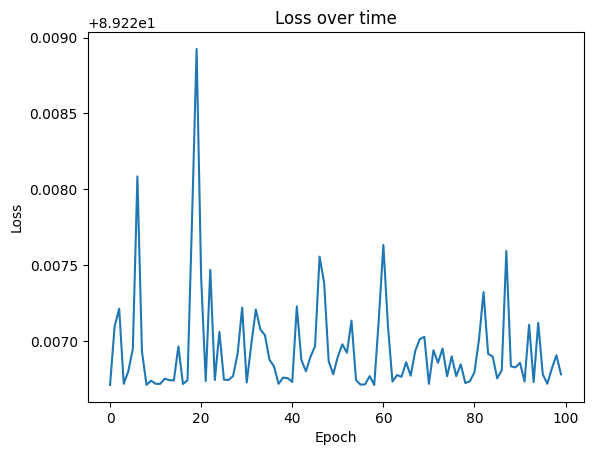

Validation Losses


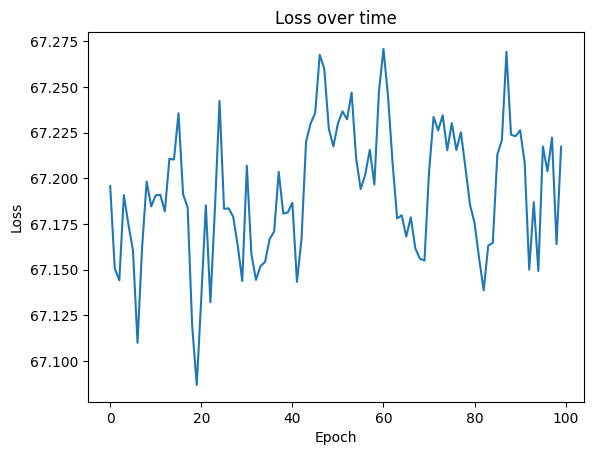

Epoch 0: Training Loss 89.22676923881316, Validation Loss 67.2152185883359
Epoch 1: Training Loss 89.22674038707986, Validation Loss 67.20974800648001
Epoch 2: Training Loss 89.2268612983529, Validation Loss 67.16830221854177
Epoch 3: Training Loss 89.22756222973364, Validation Loss 67.12839696019005
Epoch 4: Training Loss 89.22714257023362, Validation Loss 67.14811808272519
Epoch 5: Training Loss 89.22698001397939, Validation Loss 67.15845333847956
Epoch 6: Training Loss 89.22687752060784, Validation Loss 67.1667646661147
Epoch 7: Training Loss 89.2267672329966, Validation Loss 67.2148928487435
Epoch 8: Training Loss 89.22671613351964, Validation Loss 67.20130550271536
Epoch 9: Training Loss 89.2271659280318, Validation Loss 67.14681057604477
Epoch 10: Training Loss 89.22776144182161, Validation Loss 67.12084706055008
Epoch 11: Training Loss 89.2285215344706, Validation Loss 67.09732499561757
Epoch 12: Training Loss 89.22730437795366, Validation Loss 67.13968228933064
Epoch 13: Traini

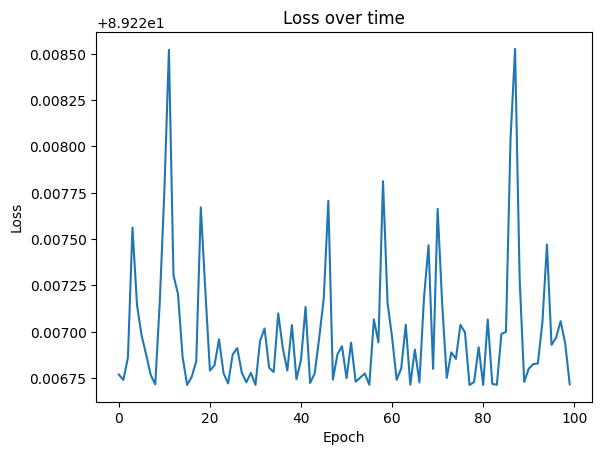

Validation Losses


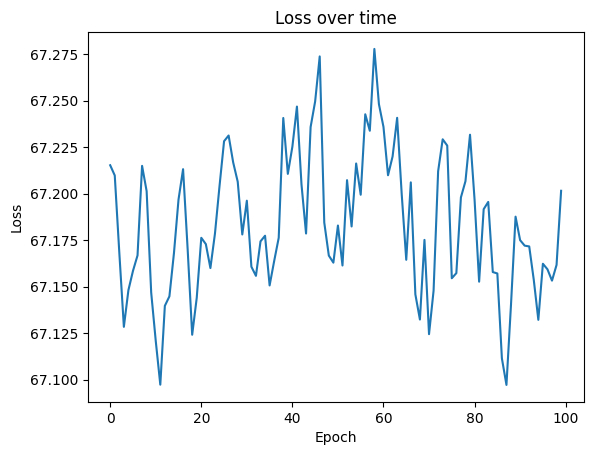

Epoch 0: Training Loss 2645.866329312446, Validation Loss 2831.471735116861
Epoch 1: Training Loss 1063.0983694737174, Validation Loss 966.3989051713837
Epoch 2: Training Loss 562.3423287064822, Validation Loss 488.26787908445544
Epoch 3: Training Loss 319.0705372973926, Validation Loss 260.76572290753955
Epoch 4: Training Loss 200.88691158473404, Validation Loss 153.5735329517062
Epoch 5: Training Loss 143.47224256089316, Validation Loss 103.81989465037243
Epoch 6: Training Loss 115.57967961709001, Validation Loss 81.26707012015673
Epoch 7: Training Loss 102.02922150592397, Validation Loss 71.43840968326113
Epoch 8: Training Loss 95.4462870013965, Validation Loss 67.4495681577002
Epoch 9: Training Loss 92.24823817268651, Validation Loss 66.05960213532984
Epoch 10: Training Loss 90.69459726925975, Validation Loss 65.7661949479218
Epoch 11: Training Loss 89.93982453560689, Validation Loss 65.88980511433401
Epoch 12: Training Loss 89.57314914864374, Validation Loss 66.13536260871622
Epoc

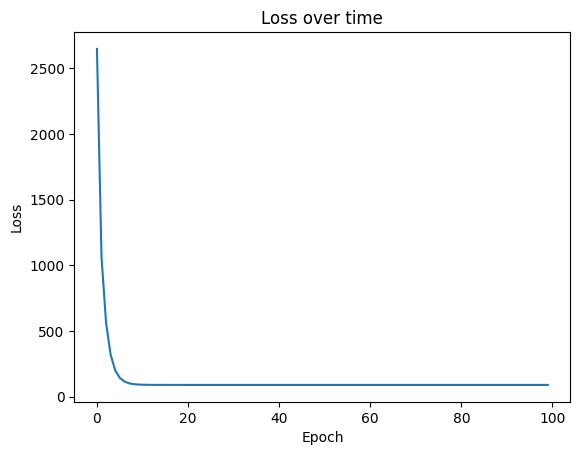

Validation Losses


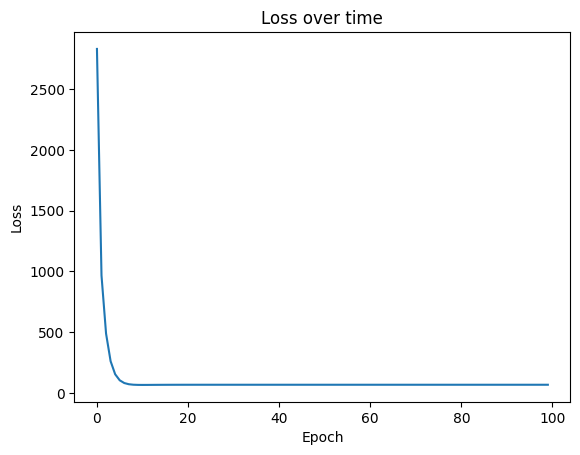

Epoch 0: Training Loss 89.22671505395179, Validation Loss 67.19408397918019
Epoch 1: Training Loss 89.22671897720144, Validation Loss 67.19156153915635
Epoch 2: Training Loss 89.226766415625, Validation Loss 67.17987673324842
Epoch 3: Training Loss 89.22710316207119, Validation Loss 67.24489966163735
Epoch 4: Training Loss 89.22711689010893, Validation Loss 67.24573797691663
Epoch 5: Training Loss 89.22793771250173, Validation Loss 67.28221515340277
Epoch 6: Training Loss 89.22700071756746, Validation Loss 67.23811795850247
Epoch 7: Training Loss 89.22705762818171, Validation Loss 67.24200959358255
Epoch 8: Training Loss 89.22693182818607, Validation Loss 67.23285531515161
Epoch 9: Training Loss 89.22673916735305, Validation Loss 67.1851173664808
Epoch 10: Training Loss 89.22671378580475, Validation Loss 67.1955719678898
Epoch 11: Training Loss 89.22727533587359, Validation Loss 67.14110035501089
Epoch 12: Training Loss 89.22680467589055, Validation Loss 67.22023004473581
Epoch 13: Tra

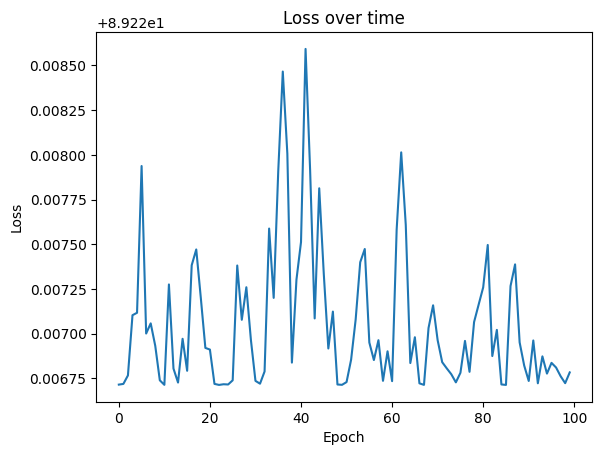

Validation Losses


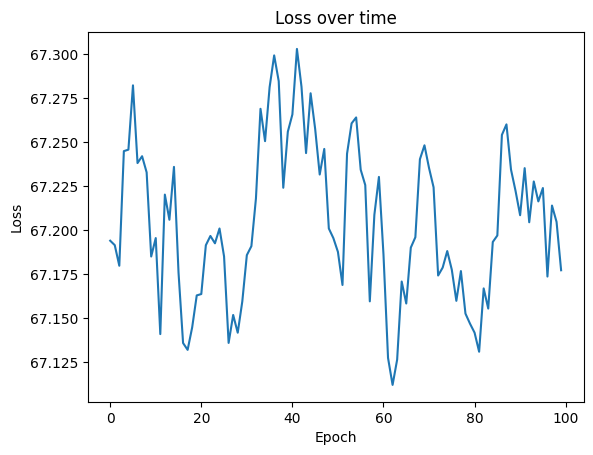

Epoch 0: Training Loss 89.22682430696568, Validation Loss 67.22258699631361
Epoch 1: Training Loss 89.22734097672841, Validation Loss 67.1379449744793
Epoch 2: Training Loss 89.2267508322484, Validation Loss 67.18264030993663
Epoch 3: Training Loss 89.22859569895151, Validation Loss 67.09533356084104
Epoch 4: Training Loss 89.2300029076188, Validation Loss 67.06331794002776
Epoch 5: Training Loss 89.22766115888707, Validation Loss 67.12454570511868
Epoch 6: Training Loss 89.22702912596775, Validation Loss 67.15505672364652
Epoch 7: Training Loss 89.22673650264935, Validation Loss 67.20881694118744
Epoch 8: Training Loss 89.2267956789964, Validation Loss 67.21906596506597
Epoch 9: Training Loss 89.22673385531094, Validation Loss 67.18643289917156
Epoch 10: Training Loss 89.22671554325564, Validation Loss 67.20086222371235
Epoch 11: Training Loss 89.22683341517522, Validation Loss 67.22360989714662
Epoch 12: Training Loss 89.22689155815522, Validation Loss 67.16549511090675
Epoch 13: Tra

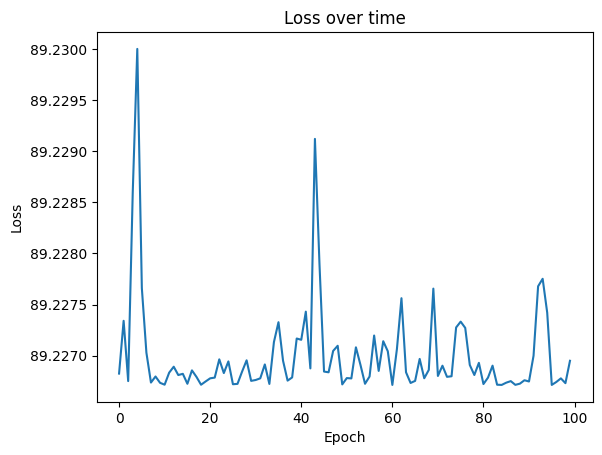

Validation Losses


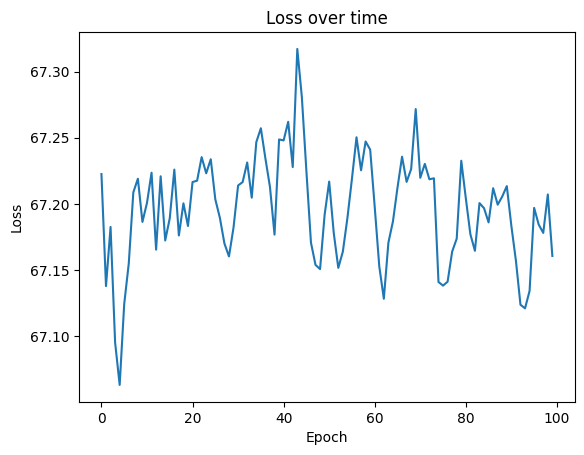

Epoch 0: Training Loss 187.07337213546063, Validation Loss 140.9981822334171
Epoch 1: Training Loss 91.04727558654113, Validation Loss 66.01054393584567
Epoch 2: Training Loss 89.48945485531492, Validation Loss 67.12202092895271
Epoch 3: Training Loss 89.40984317819895, Validation Loss 67.29613786779916
Epoch 4: Training Loss 89.36084163807534, Validation Loss 67.28553068461486
Epoch 5: Training Loss 89.3223071532069, Validation Loss 67.26190164524328
Epoch 6: Training Loss 89.28962884482169, Validation Loss 67.23950151584405
Epoch 7: Training Loss 89.26027275411178, Validation Loss 67.21858425760126
Epoch 8: Training Loss 89.23260930194904, Validation Loss 67.19840887987272
Epoch 9: Training Loss 89.20543556851074, Validation Loss 67.17827519313708
Epoch 10: Training Loss 89.1777254995311, Validation Loss 67.15753075511287
Epoch 11: Training Loss 89.14846801754527, Validation Loss 67.13550062564856
Epoch 12: Training Loss 89.11652873408049, Validation Loss 67.11140887338746
Epoch 13: 

Epoch 214: Training Loss 23.235965998524637, Validation Loss 18.46532713524614
Epoch 215: Training Loss 22.590674793819836, Validation Loss 18.936006328630267
Epoch 216: Training Loss 22.26839773112984, Validation Loss 17.531766212632338
Epoch 217: Training Loss 21.85185731249581, Validation Loss 18.14168913950667
Epoch 218: Training Loss 21.634631918251362, Validation Loss 16.9183346417934
Epoch 219: Training Loss 21.370903244091004, Validation Loss 17.64037151791602
Epoch 220: Training Loss 21.24065678964758, Validation Loss 16.532533199082046
Epoch 221: Training Loss 21.08258455484368, Validation Loss 17.366735974983026
Epoch 222: Training Loss 21.0271413683325, Validation Loss 16.312794160029135
Epoch 223: Training Loss 20.952820492435237, Validation Loss 17.288561617136533
Epoch 224: Training Loss 20.974213301902516, Validation Loss 16.23502347395433
Epoch 225: Training Loss 20.982769313732103, Validation Loss 17.412490370090598
Epoch 226: Training Loss 21.10270979169507, Validati

Epoch 337: Training Loss 19.789639030465587, Validation Loss 16.785015506473925
Epoch 338: Training Loss 19.703179494461807, Validation Loss 15.031931808283542
Epoch 339: Training Loss 19.624438323272763, Validation Loss 16.627781872049248
Epoch 340: Training Loss 19.604539701774424, Validation Loss 14.938817567909812
Epoch 341: Training Loss 19.58907811618782, Validation Loss 16.652795431884318
Epoch 342: Training Loss 19.634953761014565, Validation Loss 14.948407955862036
Epoch 343: Training Loss 19.680213764299985, Validation Loss 16.85529203564932
Epoch 344: Training Loss 19.802480246321878, Validation Loss 15.066343442080628
Epoch 345: Training Loss 19.914138679582578, Validation Loss 17.25336858225901
Epoch 346: Training Loss 20.135617078033533, Validation Loss 15.318537700678842
Epoch 347: Training Loss 20.32301566309323, Validation Loss 17.88141753925373
Epoch 348: Training Loss 20.679552418566864, Validation Loss 15.748899866557055
Epoch 349: Training Loss 20.946181132228915, 

Epoch 457: Training Loss 20.85789081662769, Validation Loss 18.6013230151961
Epoch 458: Training Loss 21.006520362544943, Validation Loss 16.140873073289267
Epoch 459: Training Loss 20.783967844269554, Validation Loss 18.505799249301358
Epoch 460: Training Loss 20.94686238756006, Validation Loss 16.090020560506222
Epoch 461: Training Loss 20.746375635600295, Validation Loss 18.4574866040489
Epoch 462: Training Loss 20.92691981704493, Validation Loss 16.073401230009758
Epoch 463: Training Loss 20.743331851785943, Validation Loss 18.45344711394082
Epoch 464: Training Loss 20.94345706404678, Validation Loss 16.08847542629307
Epoch 465: Training Loss 20.77105840564616, Validation Loss 18.488147706168718
Epoch 466: Training Loss 20.991260217787723, Validation Loss 16.131026006939347
Epoch 467: Training Loss 20.823949624583577, Validation Loss 18.55375114971599
Epoch 468: Training Loss 21.063237286170786, Validation Loss 16.195203596506758
Epoch 469: Training Loss 20.89472321612914, Validati

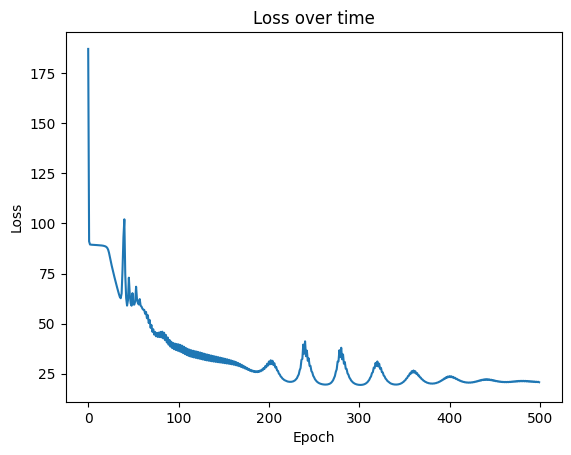

Validation Losses


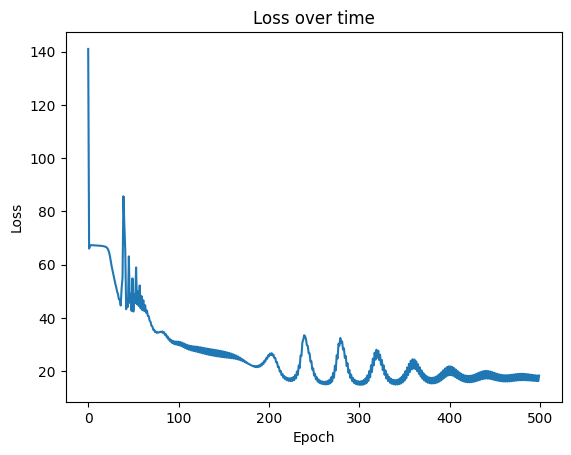

Epoch 0: Training Loss 17.15861314969412, Validation Loss 13.47405065753592
Epoch 1: Training Loss 17.054321906489445, Validation Loss 13.235508910725455
Epoch 2: Training Loss 17.033688630500148, Validation Loss 13.241493899100542
Epoch 3: Training Loss 17.01910062499448, Validation Loss 13.118443438992093
Epoch 4: Training Loss 16.989604430954998, Validation Loss 13.088079140481108
Epoch 5: Training Loss 16.967330074200614, Validation Loss 13.068792428873696
Epoch 6: Training Loss 16.924019751045904, Validation Loss 13.077053901999804
Epoch 7: Training Loss 16.899799726249405, Validation Loss 13.057987491220405
Epoch 8: Training Loss 16.88272808733959, Validation Loss 13.026417702276209
Epoch 9: Training Loss 16.906194352588873, Validation Loss 12.979115122201065
Epoch 10: Training Loss 16.8382543510003, Validation Loss 13.060656349213128
Epoch 11: Training Loss 16.822968247037966, Validation Loss 12.953867828943977
Epoch 12: Training Loss 16.808073831866473, Validation Loss 13.07173

Epoch 108: Training Loss 15.212365324745376, Validation Loss 12.499442885770428
Epoch 109: Training Loss 15.16277174108571, Validation Loss 12.374929711218607
Epoch 110: Training Loss 15.179306077774445, Validation Loss 12.406656266904761
Epoch 111: Training Loss 15.168783217133715, Validation Loss 12.379310391689907
Epoch 112: Training Loss 15.131932320470627, Validation Loss 12.338759733684782
Epoch 113: Training Loss 15.178498328908303, Validation Loss 12.454799303082119
Epoch 114: Training Loss 15.144542153796756, Validation Loss 12.398710335264074
Epoch 115: Training Loss 15.102708796530084, Validation Loss 12.402458021010945
Epoch 116: Training Loss 15.072555217561035, Validation Loss 12.356779938432558
Epoch 117: Training Loss 15.066422799055815, Validation Loss 12.315725724642917
Epoch 118: Training Loss 15.053645966713107, Validation Loss 12.365821657473743
Epoch 119: Training Loss 15.071462518443612, Validation Loss 12.366769596650915
Epoch 120: Training Loss 15.0588554352039

Epoch 216: Training Loss 13.708552927103312, Validation Loss 12.268706557052331
Epoch 217: Training Loss 13.696694918813895, Validation Loss 12.26611374083891
Epoch 218: Training Loss 13.69447736142597, Validation Loss 12.18633643517911
Epoch 219: Training Loss 13.821497824072647, Validation Loss 12.224205698889405
Epoch 220: Training Loss 13.688832737913058, Validation Loss 12.13620948738745
Epoch 221: Training Loss 13.612750121816536, Validation Loss 12.163079529004209
Epoch 222: Training Loss 13.615807095634334, Validation Loss 12.186220772884994
Epoch 223: Training Loss 13.59090423630494, Validation Loss 12.152827426377682
Epoch 224: Training Loss 13.584901443014843, Validation Loss 12.135218337331176
Epoch 225: Training Loss 13.636713880863585, Validation Loss 12.271920569536128
Epoch 226: Training Loss 13.560636687628358, Validation Loss 12.15333058413176
Epoch 227: Training Loss 13.679787591625297, Validation Loss 12.365943759349516
Epoch 228: Training Loss 13.563386052591271, V

Epoch 324: Training Loss 12.999603189502142, Validation Loss 12.522112902340353
Epoch 325: Training Loss 12.739187569221874, Validation Loss 12.497432356729647
Epoch 326: Training Loss 12.731313054614406, Validation Loss 12.48011699756096
Epoch 327: Training Loss 12.877359818056853, Validation Loss 12.798120981794023
Epoch 328: Training Loss 12.813960544146259, Validation Loss 12.6928889376353
Epoch 329: Training Loss 12.84203949252102, Validation Loss 12.746497532733866
Epoch 330: Training Loss 12.738867177773361, Validation Loss 12.48397445121089
Epoch 331: Training Loss 12.74188558789742, Validation Loss 12.462041656399485
Epoch 332: Training Loss 12.705894260859504, Validation Loss 12.592390780063749
Epoch 333: Training Loss 12.693525643644465, Validation Loss 12.492588857702064
Epoch 334: Training Loss 12.727535469102635, Validation Loss 12.668367001395058
Epoch 335: Training Loss 12.734014079969288, Validation Loss 12.473269894199797
Epoch 336: Training Loss 12.669315619534414, V

Epoch 430: Training Loss 12.321035649098235, Validation Loss 13.178200946820283
Epoch 431: Training Loss 12.268626656577155, Validation Loss 13.060554550686854
Epoch 432: Training Loss 12.258589129355524, Validation Loss 13.063573889660052
Epoch 433: Training Loss 12.348509823192655, Validation Loss 13.253157994923722
Epoch 434: Training Loss 12.267797841868383, Validation Loss 13.106194432972114
Epoch 435: Training Loss 12.25663177191412, Validation Loss 13.107308856355253
Epoch 436: Training Loss 12.244545517508428, Validation Loss 12.967652876645642
Epoch 437: Training Loss 12.230287870407874, Validation Loss 13.05844924002685
Epoch 438: Training Loss 12.240563994428284, Validation Loss 12.966100508454211
Epoch 439: Training Loss 12.253499974186761, Validation Loss 13.171118297452967
Epoch 440: Training Loss 12.323683128851782, Validation Loss 12.955120705482207
Epoch 441: Training Loss 12.21799685723254, Validation Loss 13.084527979598974
Epoch 442: Training Loss 12.245623574070999

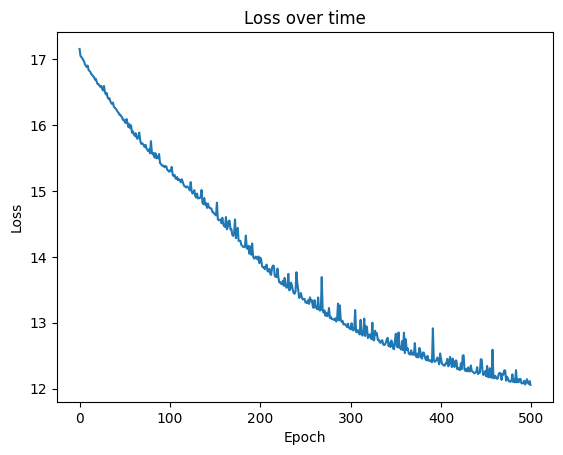

Validation Losses


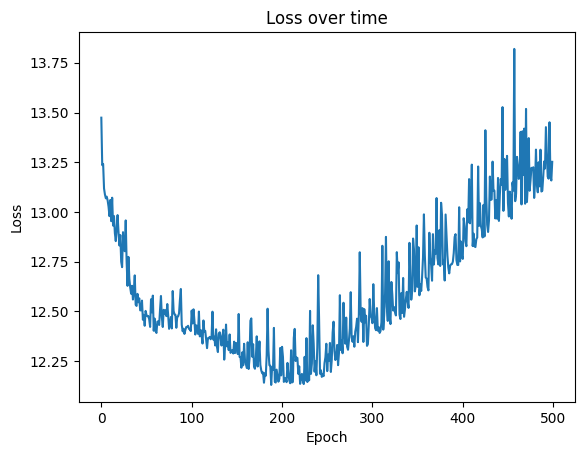

Epoch 0: Training Loss 12.096627180054801, Validation Loss 13.183338144297773
Epoch 1: Training Loss 12.074124268931877, Validation Loss 13.430693134916238
Epoch 2: Training Loss 12.069480699973411, Validation Loss 13.437557551157187
Epoch 3: Training Loss 12.342701253820996, Validation Loss 13.192482085615916
Epoch 4: Training Loss 12.176528667594138, Validation Loss 13.656290495533236
Epoch 5: Training Loss 12.074477652776162, Validation Loss 13.20467485840798
Epoch 6: Training Loss 12.026784839627515, Validation Loss 13.308076864987394
Epoch 7: Training Loss 12.039700578792246, Validation Loss 13.41630781163672
Epoch 8: Training Loss 12.023537088695953, Validation Loss 13.253313404924612
Epoch 9: Training Loss 12.025917442190142, Validation Loss 13.39872661295215
Epoch 10: Training Loss 12.281105877162563, Validation Loss 13.892548196937392
Epoch 11: Training Loss 12.015413039014105, Validation Loss 13.316124676665892
Epoch 12: Training Loss 12.16134147126695, Validation Loss 13.716

Epoch 124: Training Loss 11.890332180332473, Validation Loss 13.594110452934553
Epoch 125: Training Loss 11.933368173414422, Validation Loss 14.141196336460899
Epoch 126: Training Loss 11.789890228986996, Validation Loss 13.681320594534467
Epoch 127: Training Loss 11.790076143416584, Validation Loss 13.825229619586844
Epoch 128: Training Loss 11.803548528840063, Validation Loss 13.90204157633492
Epoch 129: Training Loss 11.797342111198985, Validation Loss 13.85633821922825
Epoch 130: Training Loss 11.791413879176014, Validation Loss 13.88547361385813
Epoch 131: Training Loss 11.768527514053849, Validation Loss 13.777890470269616
Epoch 132: Training Loss 11.951398184805587, Validation Loss 14.241097430151479
Epoch 133: Training Loss 11.834718782206117, Validation Loss 13.599416663757664
Epoch 134: Training Loss 11.817604126888428, Validation Loss 13.89565738698629
Epoch 135: Training Loss 11.78572036469139, Validation Loss 13.889412397999019
Epoch 136: Training Loss 11.861387704940901, 

Epoch 231: Training Loss 11.648687534036744, Validation Loss 14.245817655662139
Epoch 232: Training Loss 11.681701030909807, Validation Loss 14.339930126415785
Epoch 233: Training Loss 11.614709492526773, Validation Loss 14.14317883844208
Epoch 234: Training Loss 11.77807124649776, Validation Loss 14.518522921483456
Epoch 235: Training Loss 11.607302262820665, Validation Loss 14.01293141639486
Epoch 236: Training Loss 11.60337420929851, Validation Loss 14.09673542238296
Epoch 237: Training Loss 11.708904890464535, Validation Loss 13.869275559428516
Epoch 238: Training Loss 11.606331593274364, Validation Loss 14.111470239607701
Epoch 239: Training Loss 11.599280667633888, Validation Loss 14.051639417514673
Epoch 240: Training Loss 11.596007047269646, Validation Loss 14.080245356610588
Epoch 241: Training Loss 11.657403641756021, Validation Loss 14.335118002171132
Epoch 242: Training Loss 11.623037644924489, Validation Loss 14.234378319077372
Epoch 243: Training Loss 11.997214092565422, 

Epoch 341: Training Loss 11.540315534831677, Validation Loss 14.164089030665897
Epoch 342: Training Loss 11.69839905421833, Validation Loss 14.887800509900218
Epoch 343: Training Loss 11.494358438797022, Validation Loss 14.439728131598656
Epoch 344: Training Loss 11.57850238237179, Validation Loss 14.70831376058811
Epoch 345: Training Loss 12.30054389057286, Validation Loss 14.144048522289518
Epoch 346: Training Loss 11.68001485086445, Validation Loss 14.148269889573754
Epoch 347: Training Loss 11.545371772084616, Validation Loss 14.163283174185572
Epoch 348: Training Loss 11.480731761025979, Validation Loss 14.42422714234554
Epoch 349: Training Loss 11.481605671636295, Validation Loss 14.317359615002141
Epoch 350: Training Loss 11.85588148037425, Validation Loss 15.196376007784888
Epoch 351: Training Loss 11.482992109750924, Validation Loss 14.460653262553597
Epoch 352: Training Loss 11.521154592520167, Validation Loss 14.226172442851992
Epoch 353: Training Loss 12.009608663609574, Va

Epoch 481: Training Loss 11.474175675752324, Validation Loss 14.980649951389113
Epoch 482: Training Loss 11.429759771219581, Validation Loss 14.398461764221183
Epoch 483: Training Loss 11.364351318138034, Validation Loss 14.659943173813316
Epoch 484: Training Loss 11.43468440516627, Validation Loss 14.403424764175606
Epoch 485: Training Loss 11.57165340259297, Validation Loss 15.219407288374137
Epoch 486: Training Loss 11.416164966292353, Validation Loss 14.895774725959189
Epoch 487: Training Loss 11.394804574238302, Validation Loss 14.483865701343497
Epoch 488: Training Loss 11.479042075717455, Validation Loss 15.048428017232558
Epoch 489: Training Loss 11.373596511469346, Validation Loss 14.519195378856182
Epoch 490: Training Loss 11.64577516894455, Validation Loss 15.36020805743996
Epoch 491: Training Loss 11.488867712432846, Validation Loss 14.367854057293183
Epoch 492: Training Loss 11.476919987666845, Validation Loss 14.396785993949571
Epoch 493: Training Loss 11.369003735108102,

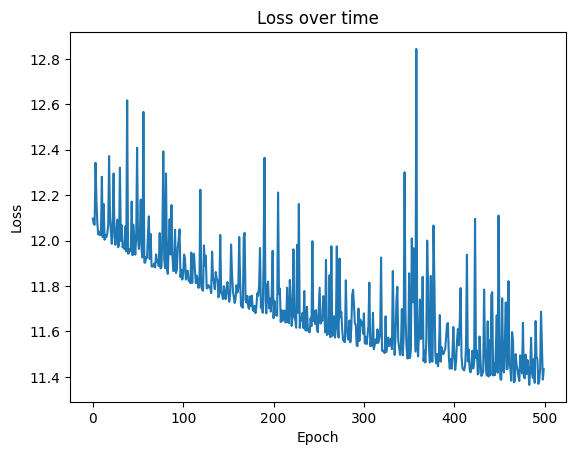

Validation Losses


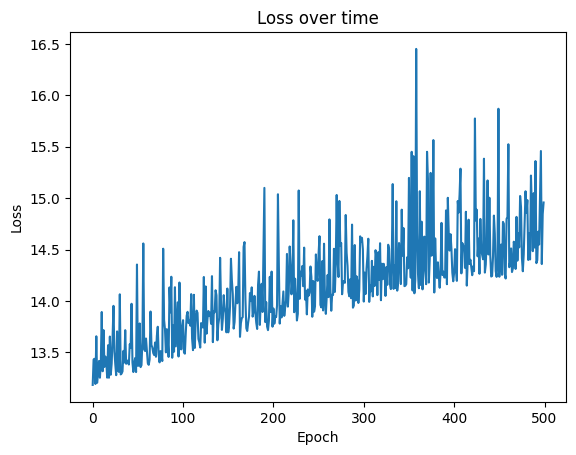

Epoch 0: Training Loss 143.36147436673969, Validation Loss 103.31241589134756
Epoch 1: Training Loss 106.03683146248987, Validation Loss 94.44584283990191
Epoch 2: Training Loss 93.69314589329242, Validation Loss 65.40408885795058
Epoch 3: Training Loss 88.9906730837992, Validation Loss 72.85821806415032
Epoch 4: Training Loss 85.48649807039806, Validation Loss 60.321589144638935
Epoch 5: Training Loss 82.79272511034786, Validation Loss 66.3146411829871
Epoch 6: Training Loss 81.16763117930368, Validation Loss 57.53652408217076
Epoch 7: Training Loss 79.24507318518631, Validation Loss 63.21746625539955
Epoch 8: Training Loss 77.66343822567536, Validation Loss 54.89357002939037
Epoch 9: Training Loss 76.46578163081607, Validation Loss 61.03610649148622
Epoch 10: Training Loss 75.12869079637218, Validation Loss 52.67544765381542
Epoch 11: Training Loss 74.81593034560755, Validation Loss 60.390528392129326
Epoch 12: Training Loss 73.86786551070331, Validation Loss 51.25394821939544
Epoch 

Epoch 198: Training Loss 27.603461344585373, Validation Loss 22.13195353360087
Epoch 199: Training Loss 26.44091611027553, Validation Loss 23.24525468040771
Epoch 200: Training Loss 27.57785655550213, Validation Loss 22.115613382326547
Epoch 201: Training Loss 26.411204950987717, Validation Loss 23.248323178119566
Epoch 202: Training Loss 27.54517117587984, Validation Loss 22.09344798486646
Epoch 203: Training Loss 26.37149139782929, Validation Loss 23.239471615227057
Epoch 204: Training Loss 27.494109151918128, Validation Loss 22.05572683674186
Epoch 205: Training Loss 26.31324048936279, Validation Loss 23.209675354293093
Epoch 206: Training Loss 27.415102723083777, Validation Loss 21.994111478432064
Epoch 207: Training Loss 26.229853060609813, Validation Loss 23.15210748648518
Epoch 208: Training Loss 27.301821748127903, Validation Loss 21.90295789180854
Epoch 209: Training Loss 26.117767299109616, Validation Loss 23.063309159279065
Epoch 210: Training Loss 27.152362212573863, Valida

Epoch 331: Training Loss 21.441360804549486, Validation Loss 20.11028818683085
Epoch 332: Training Loss 22.09518953909748, Validation Loss 17.583420919084404
Epoch 333: Training Loss 21.420671864023653, Validation Loss 20.143190888771265
Epoch 334: Training Loss 22.12835735423654, Validation Loss 17.599493953242483
Epoch 335: Training Loss 21.46499342792747, Validation Loss 20.24317391406046
Epoch 336: Training Loss 22.23491850468509, Validation Loss 17.67025656174146
Epoch 337: Training Loss 21.56288316884379, Validation Loss 20.39454074029993
Epoch 338: Training Loss 22.396665721007217, Validation Loss 17.78275198559256
Epoch 339: Training Loss 21.696137624333122, Validation Loss 20.575157011836886
Epoch 340: Training Loss 22.587190555666844, Validation Loss 17.91817993952041
Epoch 341: Training Loss 21.84081420856937, Validation Loss 20.75810605554362
Epoch 342: Training Loss 22.774016271851256, Validation Loss 18.05319270295802
Epoch 343: Training Loss 21.97013984316213, Validation

Epoch 490: Training Loss 20.428611116673114, Validation Loss 16.323443538434105
Epoch 491: Training Loss 19.45427745047114, Validation Loss 19.61968544817505
Epoch 492: Training Loss 20.40456169221371, Validation Loss 16.30728624549664
Epoch 493: Training Loss 19.429158693518396, Validation Loss 19.605220164153955
Epoch 494: Training Loss 20.38051939107805, Validation Loss 16.29119922476549
Epoch 495: Training Loss 19.404094568577996, Validation Loss 19.590625082829085
Epoch 496: Training Loss 20.356480527688188, Validation Loss 16.27518136049513
Epoch 497: Training Loss 19.37908118959235, Validation Loss 19.575896480869737
Epoch 498: Training Loss 20.332439468631613, Validation Loss 16.2592304129089
Epoch 499: Training Loss 19.354113227006728, Validation Loss 19.561029166568837

Train Losses


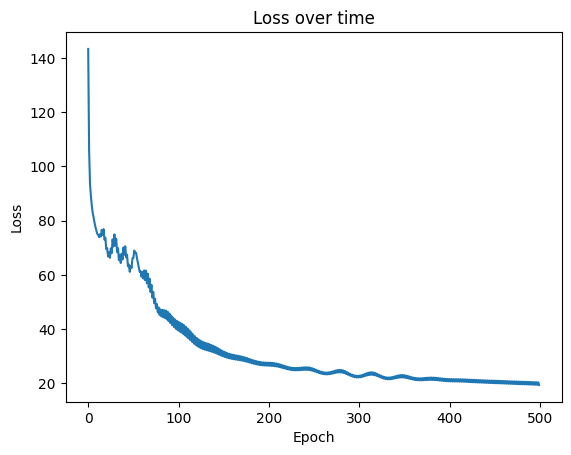

Validation Losses


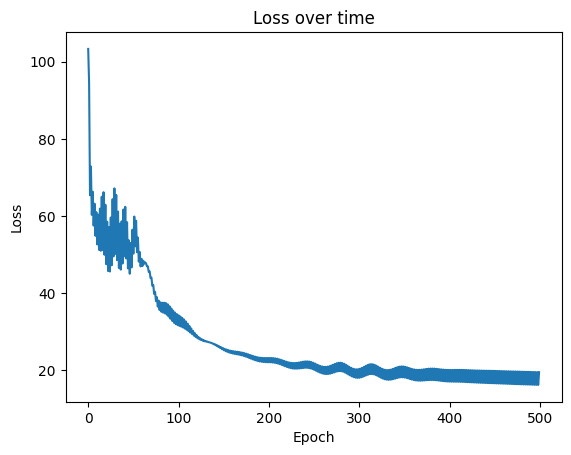

Epoch 0: Training Loss 14.763239349770942, Validation Loss 14.208081035504552
Epoch 1: Training Loss 14.720150574236467, Validation Loss 14.257262976408766
Epoch 2: Training Loss 14.73377656601139, Validation Loss 14.541646946872618
Epoch 3: Training Loss 14.554079011693515, Validation Loss 14.155467395105882
Epoch 4: Training Loss 14.524122871121286, Validation Loss 14.014223906101773
Epoch 5: Training Loss 14.513387511711393, Validation Loss 13.843081550620608
Epoch 6: Training Loss 14.46265294013466, Validation Loss 14.058462951268723
Epoch 7: Training Loss 14.435119971427154, Validation Loss 14.05569741857171
Epoch 8: Training Loss 14.438126188088177, Validation Loss 13.848808063869718
Epoch 9: Training Loss 14.404636048831668, Validation Loss 13.805628941477677
Epoch 10: Training Loss 14.381675860486535, Validation Loss 14.10619774691508
Epoch 11: Training Loss 14.38908648783988, Validation Loss 14.251969045488531
Epoch 12: Training Loss 14.342519803504882, Validation Loss 13.8010

Epoch 106: Training Loss 13.319601836047504, Validation Loss 12.711656143354265
Epoch 107: Training Loss 13.322131833529257, Validation Loss 12.726830394916274
Epoch 108: Training Loss 13.307920328681435, Validation Loss 12.627521585413527
Epoch 109: Training Loss 13.307142349588288, Validation Loss 12.721436355810011
Epoch 110: Training Loss 13.291457798802828, Validation Loss 12.659683732888679
Epoch 111: Training Loss 13.291014039854002, Validation Loss 12.697524465293615
Epoch 112: Training Loss 13.292248783900005, Validation Loss 12.67904868673026
Epoch 113: Training Loss 13.288918683982482, Validation Loss 12.58680535180848
Epoch 114: Training Loss 13.30460830954151, Validation Loss 12.881399764379669
Epoch 115: Training Loss 13.259179183335482, Validation Loss 12.714629677879785
Epoch 116: Training Loss 13.29032662763784, Validation Loss 12.62657128765753
Epoch 117: Training Loss 13.244993325454386, Validation Loss 12.73153364959373
Epoch 118: Training Loss 13.244226839924757, V

Epoch 214: Training Loss 12.645332247339644, Validation Loss 12.377898301698217
Epoch 215: Training Loss 12.65325680748042, Validation Loss 12.417495095865979
Epoch 216: Training Loss 12.631560003241265, Validation Loss 12.277331395416349
Epoch 217: Training Loss 12.626273670500634, Validation Loss 12.328726813199433
Epoch 218: Training Loss 12.610173219097906, Validation Loss 12.166861218604263
Epoch 219: Training Loss 12.60066554867849, Validation Loss 12.211144870672584
Epoch 220: Training Loss 12.6517533630045, Validation Loss 12.246883044574995
Epoch 221: Training Loss 12.61192477667869, Validation Loss 12.202502606735102
Epoch 222: Training Loss 12.5941501660324, Validation Loss 12.247860829378547
Epoch 223: Training Loss 12.713686619890959, Validation Loss 12.214870867592492
Epoch 224: Training Loss 12.573802335032198, Validation Loss 12.155948751550616
Epoch 225: Training Loss 12.578407143581595, Validation Loss 12.199819373321361
Epoch 226: Training Loss 12.608760166684945, Va

Epoch 320: Training Loss 11.937266144637169, Validation Loss 12.77960768792659
Epoch 321: Training Loss 11.852245134336465, Validation Loss 12.757607695907298
Epoch 322: Training Loss 11.847959090088562, Validation Loss 12.732093285251604
Epoch 323: Training Loss 11.835839325779078, Validation Loss 12.816348681960376
Epoch 324: Training Loss 11.810772893950642, Validation Loss 12.712219889038302
Epoch 325: Training Loss 11.828364188556847, Validation Loss 12.799698509546758
Epoch 326: Training Loss 11.830579470682732, Validation Loss 12.882264727897756
Epoch 327: Training Loss 11.778300673015574, Validation Loss 12.819848499694611
Epoch 328: Training Loss 11.768372024384725, Validation Loss 12.749858087025999
Epoch 329: Training Loss 12.003064524507744, Validation Loss 13.121472594898437
Epoch 330: Training Loss 11.806495052463156, Validation Loss 12.968772399159409
Epoch 331: Training Loss 11.804410409754533, Validation Loss 13.024615420567656
Epoch 332: Training Loss 11.7356175085462

Epoch 423: Training Loss 10.976356255098507, Validation Loss 13.97959326893703
Epoch 424: Training Loss 10.818538913370974, Validation Loss 13.726634422172932
Epoch 425: Training Loss 10.760727443567417, Validation Loss 13.750879460402654
Epoch 426: Training Loss 10.67923760970976, Validation Loss 13.531904601890954
Epoch 427: Training Loss 10.69315425406526, Validation Loss 13.96784368806277
Epoch 428: Training Loss 10.654997093226592, Validation Loss 13.900523105905082
Epoch 429: Training Loss 10.646919878634964, Validation Loss 13.92135720156625
Epoch 430: Training Loss 10.672214397382954, Validation Loss 13.73662480251895
Epoch 431: Training Loss 10.668459392232254, Validation Loss 13.735142029614098
Epoch 432: Training Loss 10.854371424860364, Validation Loss 14.162170194486272
Epoch 433: Training Loss 10.741442447082928, Validation Loss 13.929414108594782
Epoch 434: Training Loss 10.64075006394908, Validation Loss 13.481361230680657
Epoch 435: Training Loss 10.591157698481075, Va

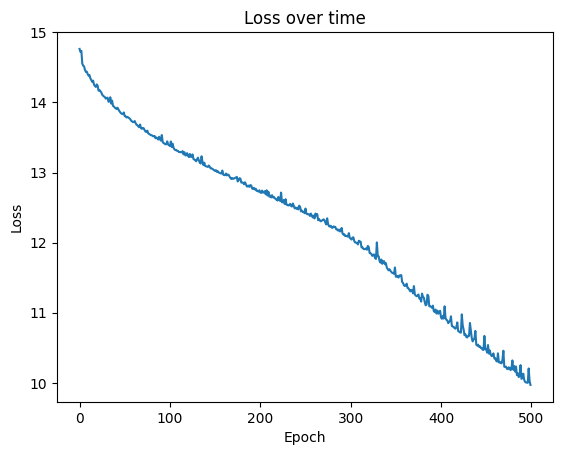

Validation Losses


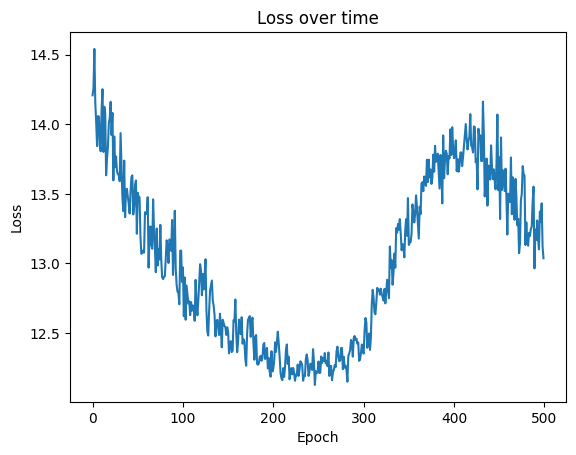

Epoch 0: Training Loss 9.966305175671499, Validation Loss 13.0213788677511
Epoch 1: Training Loss 9.989158238318154, Validation Loss 12.936524298354906
Epoch 2: Training Loss 10.014880081688325, Validation Loss 13.3182223102809
Epoch 3: Training Loss 9.946337885403278, Validation Loss 13.251012863128608
Epoch 4: Training Loss 10.010298443643686, Validation Loss 13.323588957047148
Epoch 5: Training Loss 9.947239312209028, Validation Loss 12.96950641854903
Epoch 6: Training Loss 9.980716859457296, Validation Loss 13.083471966289114
Epoch 7: Training Loss 9.905420283351274, Validation Loss 13.131434498639878
Epoch 8: Training Loss 9.914276955792642, Validation Loss 12.952161664177186
Epoch 9: Training Loss 9.922868617234545, Validation Loss 13.1416533038979
Epoch 10: Training Loss 9.914033034198756, Validation Loss 13.135228799231808
Epoch 11: Training Loss 9.886859552226278, Validation Loss 13.040663917664256
Epoch 12: Training Loss 9.881328278665386, Validation Loss 13.093084990452974
E

Epoch 147: Training Loss 9.209266028515652, Validation Loss 12.572531162218105
Epoch 148: Training Loss 9.246995317185966, Validation Loss 12.544127818524016
Epoch 149: Training Loss 9.220181483846062, Validation Loss 12.586692763923606
Epoch 150: Training Loss 9.296824674124604, Validation Loss 12.932894697900775
Epoch 151: Training Loss 9.202426797632361, Validation Loss 12.721943459549276
Epoch 152: Training Loss 9.187446442572217, Validation Loss 12.599815857350087
Epoch 153: Training Loss 9.251943203403679, Validation Loss 12.452070402949792
Epoch 154: Training Loss 9.206166582680858, Validation Loss 12.55628148198719
Epoch 155: Training Loss 9.197431368278895, Validation Loss 12.424569572697504
Epoch 156: Training Loss 9.268662038182148, Validation Loss 12.531554955782566
Epoch 157: Training Loss 9.195635951580297, Validation Loss 12.826781030861985
Epoch 158: Training Loss 9.173701774925256, Validation Loss 12.71733802346766
Epoch 159: Training Loss 9.175530468245713, Validation

Epoch 253: Training Loss 8.956294739272547, Validation Loss 12.76234618781887
Epoch 254: Training Loss 9.067033916004625, Validation Loss 12.899220992109356
Epoch 255: Training Loss 9.18172093813025, Validation Loss 12.792154573374235
Epoch 256: Training Loss 8.999547107920925, Validation Loss 12.655198971743106
Epoch 257: Training Loss 8.91297750443057, Validation Loss 12.592068698771234
Epoch 258: Training Loss 9.08611282076294, Validation Loss 12.658175954713244
Epoch 259: Training Loss 8.966270520621727, Validation Loss 12.52567343672729
Epoch 260: Training Loss 9.00332906716503, Validation Loss 12.416523443871187
Epoch 261: Training Loss 8.923567023458723, Validation Loss 12.486355001655014
Epoch 262: Training Loss 8.928222286917396, Validation Loss 12.269030236796242
Epoch 263: Training Loss 8.9065004273168, Validation Loss 12.623094766511807
Epoch 264: Training Loss 9.009979553573512, Validation Loss 12.566992457404458
Epoch 265: Training Loss 8.985692110931188, Validation Loss 

Epoch 371: Training Loss 8.723592663110884, Validation Loss 12.54831673590175
Epoch 372: Training Loss 8.747918569893024, Validation Loss 12.842555435762378
Epoch 373: Training Loss 8.71650176322796, Validation Loss 12.436320451036536
Epoch 374: Training Loss 8.745418532846182, Validation Loss 12.268941180682363
Epoch 375: Training Loss 8.742719678907925, Validation Loss 12.794556555495337
Epoch 376: Training Loss 8.671227157717034, Validation Loss 12.401937121994926
Epoch 377: Training Loss 8.736297497980912, Validation Loss 12.635281068706934
Epoch 378: Training Loss 8.740491580349731, Validation Loss 12.52641321139876
Epoch 379: Training Loss 8.694852941966941, Validation Loss 12.503687836656463
Epoch 380: Training Loss 8.675514911180807, Validation Loss 12.495131082363581
Epoch 381: Training Loss 8.666059667282079, Validation Loss 12.407072152781462
Epoch 382: Training Loss 8.850452611799586, Validation Loss 12.525413944059272
Epoch 383: Training Loss 8.693234151218315, Validation 

Epoch 478: Training Loss 8.577152712917934, Validation Loss 12.75601103248426
Epoch 479: Training Loss 8.57209278002657, Validation Loss 12.454529975275582
Epoch 480: Training Loss 8.571386266681886, Validation Loss 12.782604669846604
Epoch 481: Training Loss 8.54695027178194, Validation Loss 12.394259406641442
Epoch 482: Training Loss 8.529114345099675, Validation Loss 12.400280911510796
Epoch 483: Training Loss 8.697975197512022, Validation Loss 12.582329420392652
Epoch 484: Training Loss 8.52779420657273, Validation Loss 12.43715241159098
Epoch 485: Training Loss 8.526591501746461, Validation Loss 12.484371216574267
Epoch 486: Training Loss 8.576498660503123, Validation Loss 12.711822787595933
Epoch 487: Training Loss 8.532065540571047, Validation Loss 12.698106176022064
Epoch 488: Training Loss 8.555215218510746, Validation Loss 12.690271289922766
Epoch 489: Training Loss 8.641404844105855, Validation Loss 12.38543588841866
Epoch 490: Training Loss 8.60293003102049, Validation Loss

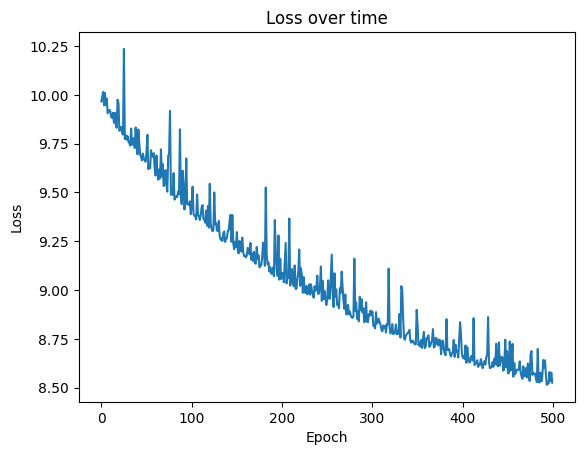

Validation Losses


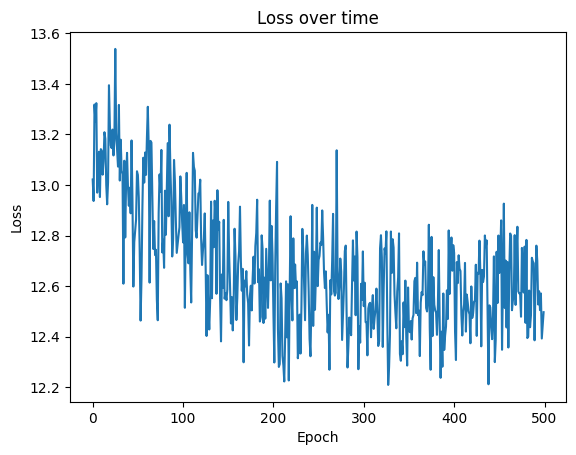

Epoch 0: Training Loss 282.96925362970006, Validation Loss 227.47570391061907
Epoch 1: Training Loss 91.83186604123715, Validation Loss 65.94041815629042
Epoch 2: Training Loss 89.34371870723797, Validation Loss 68.1330409903478
Epoch 3: Training Loss 89.2318697670513, Validation Loss 67.02886517588016
Epoch 4: Training Loss 89.22414230476426, Validation Loss 67.23195857778016
Epoch 5: Training Loss 83.9351124769851, Validation Loss 62.08587558648374
Epoch 6: Training Loss 77.11462657538345, Validation Loss 57.120380492689286
Epoch 7: Training Loss 71.37198432889988, Validation Loss 53.487637264550095
Epoch 8: Training Loss 67.5227285370955, Validation Loss 51.04499313665917
Epoch 9: Training Loss 68.61043324569843, Validation Loss 53.50069840372075
Epoch 10: Training Loss 69.74892544162218, Validation Loss 52.96026915914152
Epoch 11: Training Loss 75.33322869043859, Validation Loss 61.11914104765644
Epoch 12: Training Loss 76.19498772499854, Validation Loss 58.90983183576062
Epoch 13:

Epoch 189: Training Loss 33.46004946142838, Validation Loss 28.751816786216718
Epoch 190: Training Loss 30.99067209766932, Validation Loss 26.106639221185727
Epoch 191: Training Loss 33.3187342903524, Validation Loss 28.706249599171976
Epoch 192: Training Loss 30.933079172685556, Validation Loss 26.1297957354527
Epoch 193: Training Loss 33.18793057926586, Validation Loss 28.662074612689462
Epoch 194: Training Loss 30.878411631954158, Validation Loss 26.14953676899965
Epoch 195: Training Loss 33.06766093792683, Validation Loss 28.619482564115746
Epoch 196: Training Loss 30.826597496628438, Validation Loss 26.16635053574765
Epoch 197: Training Loss 32.95766158011546, Validation Loss 28.578811015853468
Epoch 198: Training Loss 30.777521591849894, Validation Loss 26.180797044280112
Epoch 199: Training Loss 32.85749175131512, Validation Loss 28.5404704054104
Epoch 200: Training Loss 30.731068885605534, Validation Loss 26.193426290932926
Epoch 201: Training Loss 32.76657239825556, Validation

Epoch 372: Training Loss 28.080541535145727, Validation Loss 24.549549401042103
Epoch 373: Training Loss 28.366040606831266, Validation Loss 25.982255828548755
Epoch 374: Training Loss 28.078593439102473, Validation Loss 24.501124539900772
Epoch 375: Training Loss 28.351190060031843, Validation Loss 25.90098875705545
Epoch 376: Training Loss 28.07681642896853, Validation Loss 24.45379750937182
Epoch 377: Training Loss 28.33729960337008, Validation Loss 25.81582682361888
Epoch 378: Training Loss 28.075244820295644, Validation Loss 24.407621287181577
Epoch 379: Training Loss 28.324419857281978, Validation Loss 25.727394004947264
Epoch 380: Training Loss 28.073895339909843, Validation Loss 24.362678049551164
Epoch 381: Training Loss 28.31258143661888, Validation Loss 25.636414886625616
Epoch 382: Training Loss 28.07276804849609, Validation Loss 24.319070517234145
Epoch 383: Training Loss 28.30178809687272, Validation Loss 25.54366892507521
Epoch 384: Training Loss 28.07184933106271, Valid

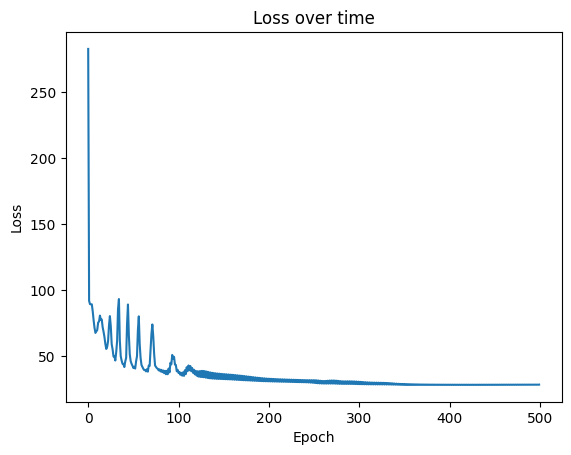

Validation Losses


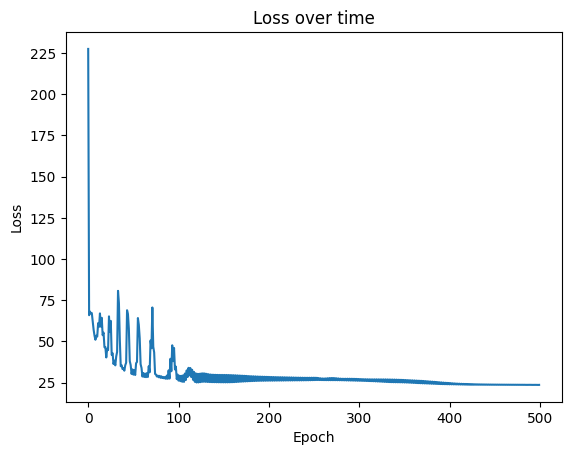

Epoch 0: Training Loss 28.188222245698533, Validation Loss 23.61876427578367
Epoch 1: Training Loss 28.24833479660667, Validation Loss 23.637480689988728
Epoch 2: Training Loss 28.182722485906865, Validation Loss 23.6252404811309
Epoch 3: Training Loss 28.264419348809326, Validation Loss 23.647130003273862
Epoch 4: Training Loss 28.205874499319624, Validation Loss 23.61853914688254
Epoch 5: Training Loss 28.18335502499492, Validation Loss 23.60461724398291
Epoch 6: Training Loss 28.189754878199928, Validation Loss 23.60325863936051
Epoch 7: Training Loss 28.342798596644247, Validation Loss 23.648665407261046
Epoch 8: Training Loss 28.174853373968332, Validation Loss 23.55066782226315
Epoch 9: Training Loss 28.137568102287055, Validation Loss 23.521992212777448
Epoch 10: Training Loss 28.173119033255073, Validation Loss 23.55290706870022
Epoch 11: Training Loss 28.133049841328173, Validation Loss 23.55519899542887
Epoch 12: Training Loss 28.43515988920352, Validation Loss 23.66559584296

Epoch 108: Training Loss 28.468930283131154, Validation Loss 23.103497129279564
Epoch 109: Training Loss 28.457462904459774, Validation Loss 23.091866652991264
Epoch 110: Training Loss 28.48748077016541, Validation Loss 23.13299869193189
Epoch 111: Training Loss 28.727518474531696, Validation Loss 23.149997393801776
Epoch 112: Training Loss 28.502637349291184, Validation Loss 23.144979993352703
Epoch 113: Training Loss 28.551899651165435, Validation Loss 23.12293910851518
Epoch 114: Training Loss 28.43379270507335, Validation Loss 23.044422334214186
Epoch 115: Training Loss 28.435240400889537, Validation Loss 23.06500216875924
Epoch 116: Training Loss 28.447054029790944, Validation Loss 23.126321569504935
Epoch 117: Training Loss 28.460922200134483, Validation Loss 23.131212499551914
Epoch 118: Training Loss 28.468254768815342, Validation Loss 23.151619407187507
Epoch 119: Training Loss 28.581874620578205, Validation Loss 23.11895606482781
Epoch 120: Training Loss 28.644252749688302, V

Epoch 216: Training Loss 28.503966332749197, Validation Loss 22.9919627363379
Epoch 217: Training Loss 28.519240872998463, Validation Loss 22.984753073620876
Epoch 218: Training Loss 28.773144557909642, Validation Loss 23.1234609488816
Epoch 219: Training Loss 28.68467463479993, Validation Loss 23.071193376482356
Epoch 220: Training Loss 28.51062279370285, Validation Loss 23.00578027133148
Epoch 221: Training Loss 28.487938519292193, Validation Loss 23.01455992951007
Epoch 222: Training Loss 28.519432066107093, Validation Loss 23.010754516223223
Epoch 223: Training Loss 28.505798007527886, Validation Loss 23.009509937284985
Epoch 224: Training Loss 28.70644059026513, Validation Loss 23.201364321785245
Epoch 225: Training Loss 28.522485334158574, Validation Loss 23.057699422567012
Epoch 226: Training Loss 28.516057660817463, Validation Loss 23.04318633916692
Epoch 227: Training Loss 28.58655397946335, Validation Loss 23.044459084346258
Epoch 228: Training Loss 28.523859933310412, Valida

Epoch 320: Training Loss 28.692023589139023, Validation Loss 23.130138779805947
Epoch 321: Training Loss 28.736443364718852, Validation Loss 23.142941384271136
Epoch 322: Training Loss 28.735233146249666, Validation Loss 23.14471696694768
Epoch 323: Training Loss 28.79322682256345, Validation Loss 23.18126462773525
Epoch 324: Training Loss 28.771593148388504, Validation Loss 23.169985915906885
Epoch 325: Training Loss 28.756533381093536, Validation Loss 23.159901724646378
Epoch 326: Training Loss 28.83117696335602, Validation Loss 23.206671893420392
Epoch 327: Training Loss 28.760933311314428, Validation Loss 23.154692047346146
Epoch 328: Training Loss 28.751498778679704, Validation Loss 23.14872617973744
Epoch 329: Training Loss 28.81621218440242, Validation Loss 23.201865356344985
Epoch 330: Training Loss 28.799500970196917, Validation Loss 23.19690650276023
Epoch 331: Training Loss 28.790021209612412, Validation Loss 23.188219501706044
Epoch 332: Training Loss 28.783770266262888, Va

Epoch 425: Training Loss 28.994811294740654, Validation Loss 23.52792105692259
Epoch 426: Training Loss 29.0041211900553, Validation Loss 23.62738958896083
Epoch 427: Training Loss 28.95962229988401, Validation Loss 23.421782693442278
Epoch 428: Training Loss 28.96433316266213, Validation Loss 23.336334786093914
Epoch 429: Training Loss 28.951918291720204, Validation Loss 23.42350442575893
Epoch 430: Training Loss 28.954434023877262, Validation Loss 23.441634092112935
Epoch 431: Training Loss 29.12474300218978, Validation Loss 23.952794173470377
Epoch 432: Training Loss 28.973221678076136, Validation Loss 23.411589980630993
Epoch 433: Training Loss 29.041090035101078, Validation Loss 23.729991303860093
Epoch 434: Training Loss 29.004477698831522, Validation Loss 23.585912364082596
Epoch 435: Training Loss 29.004488364833005, Validation Loss 23.59615550611269
Epoch 436: Training Loss 29.073996863111294, Validation Loss 23.84362264658954
Epoch 437: Training Loss 28.98334135222412, Valida

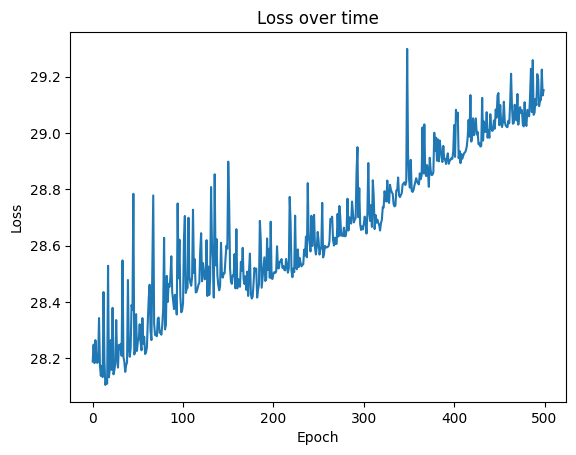

Validation Losses


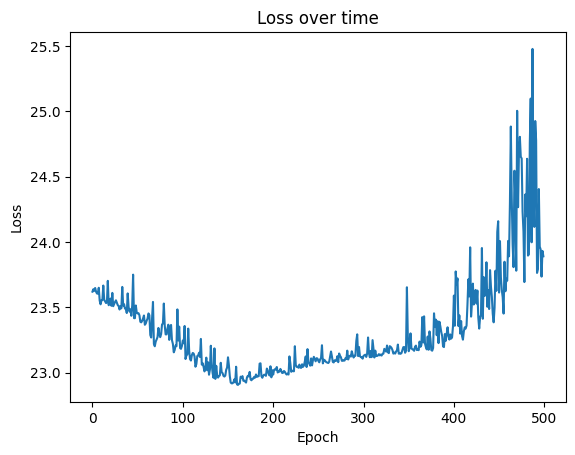

Epoch 0: Training Loss 29.214330065966053, Validation Loss 23.77710153770146
Epoch 1: Training Loss 29.163975328629903, Validation Loss 23.862015657342
Epoch 2: Training Loss 29.160844435757745, Validation Loss 24.87583819333513
Epoch 3: Training Loss 29.122406729388548, Validation Loss 24.481260742723624
Epoch 4: Training Loss 29.217432002342687, Validation Loss 23.808980986732124
Epoch 5: Training Loss 29.256059426244228, Validation Loss 23.77262223790735
Epoch 6: Training Loss 29.11456226143257, Validation Loss 24.889234046400667
Epoch 7: Training Loss 29.074845688311033, Validation Loss 24.323736179457814
Epoch 8: Training Loss 29.16347671364344, Validation Loss 25.40132073266904
Epoch 9: Training Loss 29.081021887257904, Validation Loss 24.785568591429705
Epoch 10: Training Loss 29.1055705945112, Validation Loss 24.376709146659866
Epoch 11: Training Loss 29.097105874868234, Validation Loss 25.172101171650585
Epoch 12: Training Loss 29.08287736115123, Validation Loss 24.46145498692

Epoch 106: Training Loss 29.296048986288362, Validation Loss 26.608125698545198
Epoch 107: Training Loss 29.18578687359672, Validation Loss 26.419064970033393
Epoch 108: Training Loss 29.22636012266014, Validation Loss 26.151843623874395
Epoch 109: Training Loss 29.1929650463962, Validation Loss 26.25553151781578
Epoch 110: Training Loss 29.186709198510467, Validation Loss 26.391763811932464
Epoch 111: Training Loss 29.241618370808233, Validation Loss 26.55349560746358
Epoch 112: Training Loss 29.197166778513736, Validation Loss 26.450249325495136
Epoch 113: Training Loss 29.193172438501907, Validation Loss 26.233706880377746
Epoch 114: Training Loss 29.264549186077424, Validation Loss 26.57121042161577
Epoch 115: Training Loss 29.21510422177153, Validation Loss 26.21036357077445
Epoch 116: Training Loss 29.19860203272664, Validation Loss 26.464406349093597
Epoch 117: Training Loss 29.196355687186976, Validation Loss 26.40285561920182
Epoch 118: Training Loss 29.43154506904367, Validat

Epoch 227: Training Loss 29.323219603350495, Validation Loss 26.716681090426746
Epoch 228: Training Loss 29.358147447562263, Validation Loss 26.652339495738154
Epoch 229: Training Loss 29.324593964237287, Validation Loss 26.72532316628675
Epoch 230: Training Loss 29.36436524844201, Validation Loss 26.792628217103218
Epoch 231: Training Loss 29.351909821546233, Validation Loss 26.616726693479016
Epoch 232: Training Loss 29.340070347111695, Validation Loss 26.7808524821141
Epoch 233: Training Loss 29.363466542837138, Validation Loss 26.668280791896496
Epoch 234: Training Loss 29.371624701379723, Validation Loss 26.80620616673002
Epoch 235: Training Loss 29.389301083819745, Validation Loss 26.79643488227975
Epoch 236: Training Loss 29.317780623679656, Validation Loss 26.719346857897378
Epoch 237: Training Loss 29.32467840051594, Validation Loss 26.754144463452832
Epoch 238: Training Loss 29.355213625292524, Validation Loss 26.774964165011344
Epoch 239: Training Loss 29.57550407031759, Val

Epoch 358: Training Loss 29.44051137820998, Validation Loss 26.68111850780727
Epoch 359: Training Loss 29.362302871777953, Validation Loss 26.795037735411068
Epoch 360: Training Loss 29.424165237615494, Validation Loss 26.712741978503512
Epoch 361: Training Loss 29.38522537619519, Validation Loss 26.83319280543793
Epoch 362: Training Loss 29.37604898376525, Validation Loss 26.82071153449479
Epoch 363: Training Loss 29.412219036665704, Validation Loss 26.876342139433337
Epoch 364: Training Loss 29.36783814937968, Validation Loss 26.779351123894532
Epoch 365: Training Loss 29.44487525984929, Validation Loss 26.87525556079387
Epoch 366: Training Loss 29.38983582422188, Validation Loss 26.82898636879878
Epoch 367: Training Loss 29.452079542781505, Validation Loss 26.889467012667836
Epoch 368: Training Loss 29.441145794462283, Validation Loss 26.76334237136044
Epoch 369: Training Loss 29.407059500230417, Validation Loss 26.716806468902394
Epoch 370: Training Loss 29.445942604866353, Validat

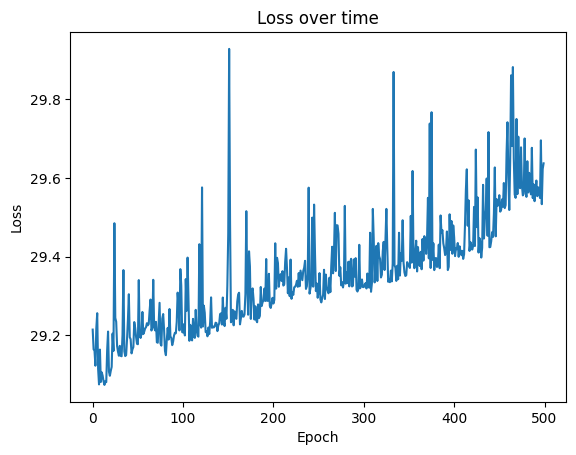

Validation Losses


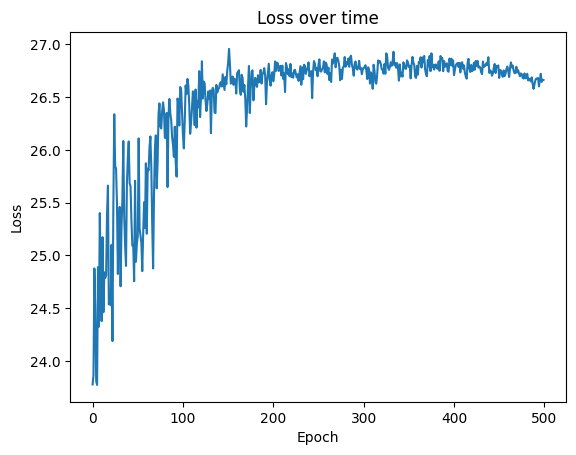

Epoch 0: Training Loss 240.33488814232132, Validation Loss 189.0254154351861
Epoch 1: Training Loss 94.37800846042079, Validation Loss 77.84900320266782
Epoch 2: Training Loss 92.90537634940357, Validation Loss 66.27591856883856
Epoch 3: Training Loss 90.81346020778696, Validation Loss 73.13831582556774
Epoch 4: Training Loss 98.3455064439887, Validation Loss 73.01827249823953
Epoch 5: Training Loss 97.68487472385216, Validation Loss 86.54240222948629
Epoch 6: Training Loss 273.3448019077107, Validation Loss 257.35368879356554
Epoch 7: Training Loss 100.36798436448976, Validation Loss 86.32515048948822
Epoch 8: Training Loss 96.6816051479782, Validation Loss 68.11910523728488
Epoch 9: Training Loss 94.2149603507166, Validation Loss 77.52954725642574
Epoch 10: Training Loss 92.56446772373143, Validation Loss 66.16359753701586
Epoch 11: Training Loss 91.46008511692501, Validation Loss 73.00645924774015
Epoch 12: Training Loss 90.68825261839055, Validation Loss 65.72593212026807
Epoch 13:

Epoch 179: Training Loss 48.16980759379029, Validation Loss 33.098294295400194
Epoch 180: Training Loss 48.15684477588439, Validation Loss 32.99656637588738
Epoch 181: Training Loss 48.1414011331087, Validation Loss 32.89942214541889
Epoch 182: Training Loss 48.12222066474798, Validation Loss 32.80993530880251
Epoch 183: Training Loss 48.097877641950866, Validation Loss 32.73066657475919
Epoch 184: Training Loss 48.066551492852874, Validation Loss 32.663288225048696
Epoch 185: Training Loss 48.0257109860408, Validation Loss 32.60855294791164
Epoch 186: Training Loss 47.971670309227356, Validation Loss 32.56669475854596
Epoch 187: Training Loss 47.89900011839039, Validation Loss 32.53821288653295
Epoch 188: Training Loss 47.799959459989445, Validation Loss 32.524910892451814
Epoch 189: Training Loss 47.664922121186365, Validation Loss 32.53094618425309
Epoch 190: Training Loss 47.4873043321615, Validation Loss 32.562891088488854
Epoch 191: Training Loss 47.279226101341706, Validation Lo

Epoch 295: Training Loss 43.02101990322558, Validation Loss 33.19465585590365
Epoch 296: Training Loss 42.90883380355427, Validation Loss 33.151183748094546
Epoch 297: Training Loss 42.830094554424136, Validation Loss 33.12300941583767
Epoch 298: Training Loss 42.776054951225866, Validation Loss 33.1040793533232
Epoch 299: Training Loss 42.73916063812607, Validation Loss 33.089854950275424
Epoch 300: Training Loss 42.71371697223951, Validation Loss 33.07744921656992
Epoch 301: Training Loss 42.69590533746434, Validation Loss 33.065497630939554
Epoch 302: Training Loss 42.68322619633943, Validation Loss 33.05336741213037
Epoch 303: Training Loss 42.67408041519889, Validation Loss 33.040887120525475
Epoch 304: Training Loss 42.667408090243335, Validation Loss 33.028023726518306
Epoch 305: Training Loss 42.66249681089224, Validation Loss 33.014840869971216
Epoch 306: Training Loss 42.658843302065165, Validation Loss 33.00140760379466
Epoch 307: Training Loss 42.65608496905008, Validation 

Epoch 415: Training Loss 40.2312439712067, Validation Loss 32.55989411836969
Epoch 416: Training Loss 40.22226383300477, Validation Loss 32.56540499614212
Epoch 417: Training Loss 40.213539292157606, Validation Loss 32.57067518201958
Epoch 418: Training Loss 40.205046261318415, Validation Loss 32.575677748690325
Epoch 419: Training Loss 40.19676446162375, Validation Loss 32.580400855459246
Epoch 420: Training Loss 40.1886772203153, Validation Loss 32.58484474911189
Epoch 421: Training Loss 40.18077113719644, Validation Loss 32.589018793037006
Epoch 422: Training Loss 40.173035647319644, Validation Loss 32.59293879232166
Epoch 423: Training Loss 40.165462533881716, Validation Loss 32.59662475903661
Epoch 424: Training Loss 40.158045445198916, Validation Loss 32.60009915793834
Epoch 425: Training Loss 40.15077945544092, Validation Loss 32.60338560178679
Epoch 426: Training Loss 40.14366069107154, Validation Loss 32.606507927181795
Epoch 427: Training Loss 40.13668602989192, Validation Lo

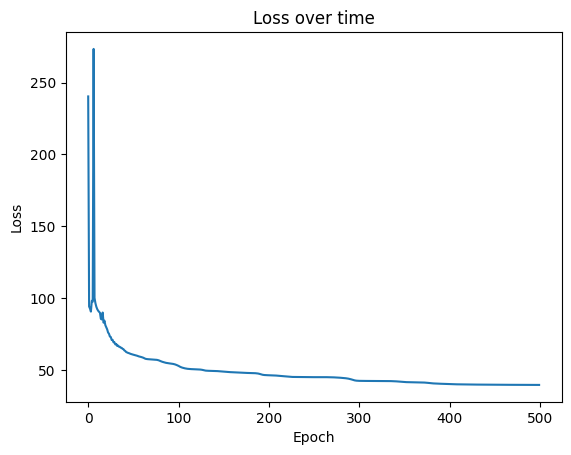

Validation Losses


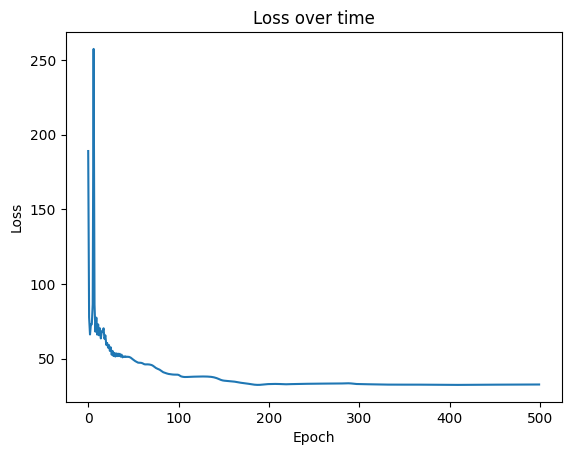

Epoch 0: Training Loss 39.93130981847829, Validation Loss 32.50910939214795
Epoch 1: Training Loss 39.91722828714474, Validation Loss 32.53493009266102
Epoch 2: Training Loss 39.88140323518764, Validation Loss 32.72993774530644
Epoch 3: Training Loss 39.881345819988525, Validation Loss 32.731357106794114
Epoch 4: Training Loss 39.870717373661925, Validation Loss 32.734400584976726
Epoch 5: Training Loss 39.868193910975585, Validation Loss 32.69066956990403
Epoch 6: Training Loss 39.87467980724186, Validation Loss 32.526731981232906
Epoch 7: Training Loss 39.848229238835025, Validation Loss 32.698628327474694
Epoch 8: Training Loss 39.866932894958985, Validation Loss 32.95715737905485
Epoch 9: Training Loss 39.84299392680863, Validation Loss 32.65281407244117
Epoch 10: Training Loss 39.863652697614775, Validation Loss 33.024463034790536
Epoch 11: Training Loss 39.87769834404716, Validation Loss 33.136081712614896
Epoch 12: Training Loss 39.881874107686116, Validation Loss 32.44625899936

Epoch 109: Training Loss 39.38299017160719, Validation Loss 31.484981535718365
Epoch 110: Training Loss 39.384205380061246, Validation Loss 31.30210109563688
Epoch 111: Training Loss 39.46211247152953, Validation Loss 31.144147224892833
Epoch 112: Training Loss 39.56597543708708, Validation Loss 31.079731429686305
Epoch 113: Training Loss 39.5046296624863, Validation Loss 31.099789133195635
Epoch 114: Training Loss 39.40904958021524, Validation Loss 31.12292419503547
Epoch 115: Training Loss 39.356262162813415, Validation Loss 31.42862704268516
Epoch 116: Training Loss 39.37684780215837, Validation Loss 31.172363534463077
Epoch 117: Training Loss 39.360381293332765, Validation Loss 31.220401840799948
Epoch 118: Training Loss 39.34039689439543, Validation Loss 31.337409083998825
Epoch 119: Training Loss 39.373163352847826, Validation Loss 31.138908817652503
Epoch 120: Training Loss 39.37745779655844, Validation Loss 31.136081036870127
Epoch 121: Training Loss 39.312467859934536, Validat

Epoch 218: Training Loss 34.89004129681329, Validation Loss 25.522626111232
Epoch 219: Training Loss 34.09337884084646, Validation Loss 28.213422410541778
Epoch 220: Training Loss 33.443195145507495, Validation Loss 26.68501892838047
Epoch 221: Training Loss 32.96553457631542, Validation Loss 28.49779112633076
Epoch 222: Training Loss 32.31359585313977, Validation Loss 27.350926604638303
Epoch 223: Training Loss 32.088935711992754, Validation Loss 25.563152720434218
Epoch 224: Training Loss 31.371096276117825, Validation Loss 27.481673470121528
Epoch 225: Training Loss 31.07816846156854, Validation Loss 28.13186476870202
Epoch 226: Training Loss 30.58965904531121, Validation Loss 25.655610053731746
Epoch 227: Training Loss 30.21859155057309, Validation Loss 27.14844967344181
Epoch 228: Training Loss 29.76637019988627, Validation Loss 26.248305180391167
Epoch 229: Training Loss 29.373706771131747, Validation Loss 25.325765368151377
Epoch 230: Training Loss 29.186390124356343, Validation

Epoch 325: Training Loss 23.26154172332293, Validation Loss 20.592814247519094
Epoch 326: Training Loss 23.39036780273646, Validation Loss 20.528806136544848
Epoch 327: Training Loss 23.358408801420353, Validation Loss 21.059650395089765
Epoch 328: Training Loss 23.42965747384263, Validation Loss 21.091645043569365
Epoch 329: Training Loss 23.2649355394892, Validation Loss 20.728577011823795
Epoch 330: Training Loss 23.451720574180282, Validation Loss 21.057249208836147
Epoch 331: Training Loss 23.360046714596734, Validation Loss 21.030010333652793
Epoch 332: Training Loss 23.315978760277805, Validation Loss 20.91863937573032
Epoch 333: Training Loss 23.287054236533987, Validation Loss 20.806759274488552
Epoch 334: Training Loss 23.456319435843803, Validation Loss 21.09948499007004
Epoch 335: Training Loss 23.41813100296623, Validation Loss 20.670129879942092
Epoch 336: Training Loss 23.39569383799866, Validation Loss 20.687731501399654
Epoch 337: Training Loss 23.42446043143123, Valid

Epoch 431: Training Loss 24.022952023492387, Validation Loss 21.295217154811045
Epoch 432: Training Loss 24.308002463009576, Validation Loss 20.926208023258827
Epoch 433: Training Loss 24.020189303294586, Validation Loss 21.0857935348374
Epoch 434: Training Loss 24.201801637955047, Validation Loss 21.46846072004596
Epoch 435: Training Loss 23.91772079885722, Validation Loss 21.19769004780927
Epoch 436: Training Loss 24.023082189887052, Validation Loss 21.078989577951585
Epoch 437: Training Loss 24.177260765913907, Validation Loss 21.05570114559503
Epoch 438: Training Loss 23.984035740925922, Validation Loss 21.148781056057334
Epoch 439: Training Loss 23.98681998940691, Validation Loss 21.246294071918072
Epoch 440: Training Loss 23.999848228132652, Validation Loss 21.1162417719607
Epoch 441: Training Loss 24.002178809859686, Validation Loss 21.132965582439823
Epoch 442: Training Loss 24.10420676981161, Validation Loss 21.28180996129837
Epoch 443: Training Loss 24.04363347917266, Validat

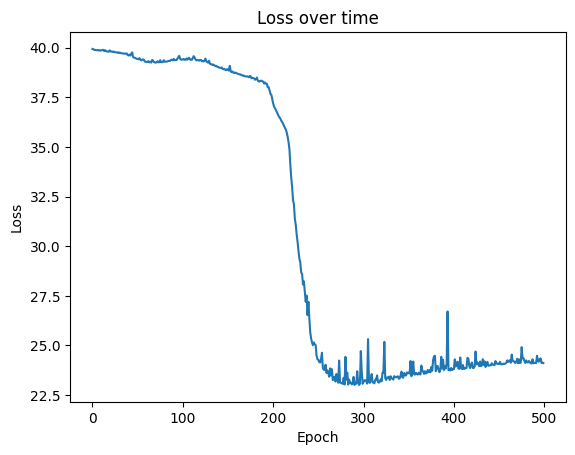

Validation Losses


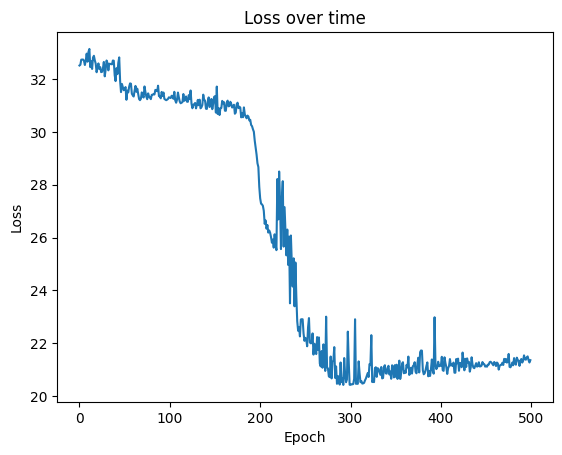

Epoch 0: Training Loss 24.310379342213757, Validation Loss 21.134870782858645
Epoch 1: Training Loss 24.598447240863553, Validation Loss 21.72258588838083
Epoch 2: Training Loss 24.108940733030845, Validation Loss 21.341519679934272
Epoch 3: Training Loss 24.226528043814508, Validation Loss 21.507644694611738
Epoch 4: Training Loss 24.186696596452162, Validation Loss 21.212218472181867
Epoch 5: Training Loss 24.28970394046504, Validation Loss 21.147100583636753
Epoch 6: Training Loss 24.120990816552613, Validation Loss 21.286617190810038
Epoch 7: Training Loss 24.094928491049053, Validation Loss 21.302260175386493
Epoch 8: Training Loss 24.346568289314302, Validation Loss 21.596322040909783
Epoch 9: Training Loss 24.087163854187118, Validation Loss 21.29714582725828
Epoch 10: Training Loss 24.198368716377, Validation Loss 21.51960474519632
Epoch 11: Training Loss 24.1327515160184, Validation Loss 21.45983945317519
Epoch 12: Training Loss 24.293594389610462, Validation Loss 21.548610993

Epoch 141: Training Loss 24.34074278753831, Validation Loss 21.79606111546304
Epoch 142: Training Loss 24.072337251084477, Validation Loss 21.685217846881823
Epoch 143: Training Loss 25.706842930204793, Validation Loss 22.10268628000419
Epoch 144: Training Loss 24.539484012791316, Validation Loss 21.824904346550657
Epoch 145: Training Loss 24.07507760320431, Validation Loss 21.548311160391783
Epoch 146: Training Loss 24.113059031381425, Validation Loss 21.68562720631022
Epoch 147: Training Loss 24.21302185200394, Validation Loss 21.745687721751196
Epoch 148: Training Loss 24.283026821625118, Validation Loss 21.762432924634176
Epoch 149: Training Loss 24.13601893406989, Validation Loss 21.511728962648288
Epoch 150: Training Loss 24.212223906172436, Validation Loss 21.75176857947911
Epoch 151: Training Loss 24.064503576850125, Validation Loss 21.627155346639732
Epoch 152: Training Loss 24.07119956701142, Validation Loss 21.65269049405332
Epoch 153: Training Loss 24.188433878823577, Valid

Epoch 292: Training Loss 24.17146663320431, Validation Loss 21.952413267247227
Epoch 293: Training Loss 24.237351993483838, Validation Loss 21.905893936178103
Epoch 294: Training Loss 24.22848471865681, Validation Loss 21.873071952298332
Epoch 295: Training Loss 24.218046088261836, Validation Loss 21.86729824783852
Epoch 296: Training Loss 24.643901880837912, Validation Loss 22.050670133843987
Epoch 297: Training Loss 24.240257922965718, Validation Loss 21.82851491076136
Epoch 298: Training Loss 24.245014355950516, Validation Loss 21.87555105067449
Epoch 299: Training Loss 24.388392247428648, Validation Loss 21.813200314881296
Epoch 300: Training Loss 24.2451397664505, Validation Loss 21.860887740801612
Epoch 301: Training Loss 24.217810572894, Validation Loss 21.944694722243554
Epoch 302: Training Loss 24.257205401075023, Validation Loss 21.806259243357612
Epoch 303: Training Loss 24.20773194973548, Validation Loss 21.907914795702066
Epoch 304: Training Loss 24.19000688421511, Validat

Epoch 401: Training Loss 24.26472368639017, Validation Loss 21.917899428916982
Epoch 402: Training Loss 24.456644119221725, Validation Loss 21.991507514457737
Epoch 403: Training Loss 24.615434571986224, Validation Loss 21.962994777763466
Epoch 404: Training Loss 24.28270938413693, Validation Loss 21.846166772070728
Epoch 405: Training Loss 24.26121260381805, Validation Loss 21.890028552506454
Epoch 406: Training Loss 24.260687826880865, Validation Loss 21.888202519974932
Epoch 407: Training Loss 24.268941632877837, Validation Loss 21.91486992458778
Epoch 408: Training Loss 24.347907803844503, Validation Loss 21.84812526870745
Epoch 409: Training Loss 24.64963068591213, Validation Loss 22.016417155242166
Epoch 410: Training Loss 24.49358353431777, Validation Loss 21.849997879301633
Epoch 411: Training Loss 24.276267482440485, Validation Loss 21.966088094230987
Epoch 412: Training Loss 24.262958465970538, Validation Loss 21.877042754222416
Epoch 413: Training Loss 24.42428541979869, Val

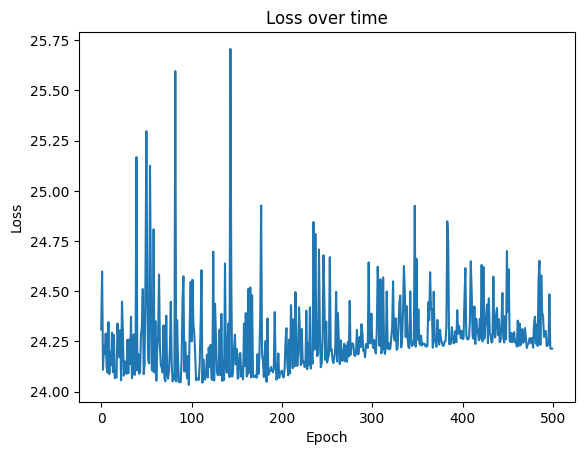

Validation Losses


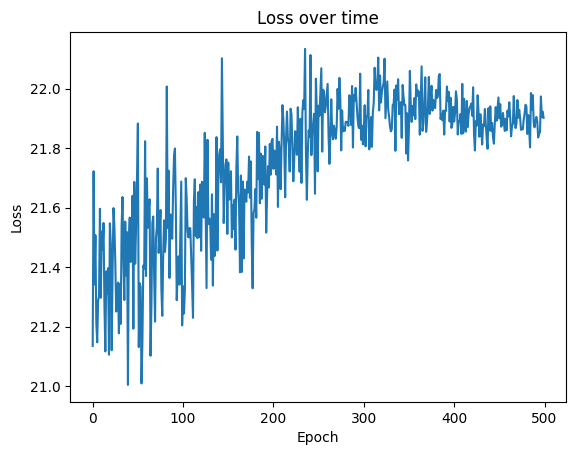

Epoch 0: Training Loss 333.95356809287586, Validation Loss 274.0082230940107
Epoch 1: Training Loss 316.5159299033717, Validation Loss 338.1786165465027
Epoch 2: Training Loss 325.35082628534525, Validation Loss 266.55375494880116
Epoch 3: Training Loss 203.93793249768243, Validation Loss 156.28145077281079
Epoch 4: Training Loss 144.9544559795917, Validation Loss 105.06296521405582
Epoch 5: Training Loss 116.29975223581455, Validation Loss 81.82046016893571
Epoch 6: Training Loss 102.3790392647539, Validation Loss 71.67204969083902
Epoch 7: Training Loss 95.61623161699592, Validation Loss 67.53853688067693
Epoch 8: Training Loss 92.33079879644625, Validation Loss 66.08572256193159
Epoch 9: Training Loss 90.73470596332784, Validation Loss 65.76696482457078
Epoch 10: Training Loss 89.9593097001634, Validation Loss 65.88187112314941
Epoch 11: Training Loss 89.5826152169518, Validation Loss 66.1257175254727
Epoch 12: Training Loss 89.3996136467572, Validation Loss 66.37523295249595
Epoch 

Epoch 120: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 121: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 122: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 123: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 124: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 125: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 126: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 127: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 128: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 129: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 130: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 131: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 132: Training Loss 89.2267132851899, Validation Loss 67.19726442941322

Epoch 324: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 325: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 326: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 327: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 328: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 329: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 330: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 331: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 332: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 333: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 334: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 335: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 336: Training Loss 89.2267132851899, Validation Loss 67.19726442941322

Epoch 490: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 491: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 492: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 493: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 494: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 495: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 496: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 497: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 498: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 499: Training Loss 89.2267132851899, Validation Loss 67.19726442941322

Train Losses


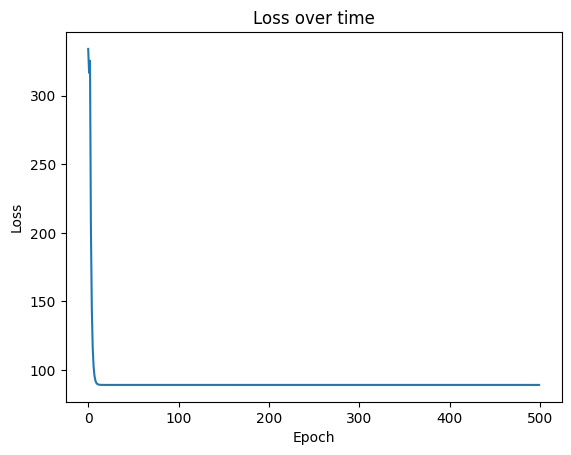

Validation Losses


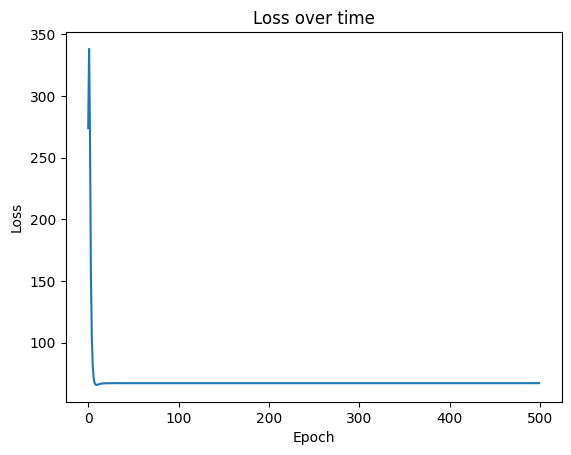

Epoch 0: Training Loss 89.22671373715828, Validation Loss 67.19565627645159
Epoch 1: Training Loss 89.22678790477087, Validation Loss 67.21800815920747
Epoch 2: Training Loss 89.22671329769919, Validation Loss 67.19699682613091
Epoch 3: Training Loss 89.22674821178235, Validation Loss 67.21144013993518
Epoch 4: Training Loss 89.22697079703786, Validation Loss 67.15912523372761
Epoch 5: Training Loss 89.22702364354106, Validation Loss 67.15542192291976
Epoch 6: Training Loss 89.22671416695971, Validation Loss 67.19951215554187
Epoch 7: Training Loss 89.22713942883003, Validation Loss 67.14829666559623
Epoch 8: Training Loss 89.22733058366228, Validation Loss 67.13843294341413
Epoch 9: Training Loss 89.22821181712034, Validation Loss 67.10613792770917
Epoch 10: Training Loss 89.22715750306239, Validation Loss 67.14727813359283
Epoch 11: Training Loss 89.2270766720765, Validation Loss 67.1520157230435
Epoch 12: Training Loss 89.22707725035913, Validation Loss 67.15198002291804
Epoch 13: T

Epoch 107: Training Loss 89.22702586555295, Validation Loss 67.1552735172504
Epoch 108: Training Loss 89.22696099795489, Validation Loss 67.15985307384732
Epoch 109: Training Loss 89.22689954092394, Validation Loss 67.16479564636134
Epoch 110: Training Loss 89.22714978074048, Validation Loss 67.14771067727214
Epoch 111: Training Loss 89.22737393571788, Validation Loss 67.13642420826159
Epoch 112: Training Loss 89.22742955564638, Validation Loss 67.13394326940521
Epoch 113: Training Loss 89.22693165241624, Validation Loss 67.16212468139867
Epoch 114: Training Loss 89.22672812276998, Validation Loss 67.20649599807298
Epoch 115: Training Loss 89.22672689060296, Validation Loss 67.18845229250014
Epoch 116: Training Loss 89.22671748794222, Validation Loss 67.20217389492475
Epoch 117: Training Loss 89.22766086770271, Validation Loss 67.27186729395453
Epoch 118: Training Loss 89.22709641380699, Validation Loss 67.24448225063112
Epoch 119: Training Loss 89.2267317181607, Validation Loss 67.207

Epoch 217: Training Loss 89.22813019688726, Validation Loss 67.28874856376541
Epoch 218: Training Loss 89.22757809117776, Validation Loss 67.26849391622888
Epoch 219: Training Loss 89.22728447995188, Validation Loss 67.25502133004272
Epoch 220: Training Loss 89.22672031826937, Validation Loss 67.20361699597723
Epoch 221: Training Loss 89.22672989966563, Validation Loss 67.20703405454333
Epoch 222: Training Loss 89.2267457109815, Validation Loss 67.2109219857397
Epoch 223: Training Loss 89.22692030990325, Validation Loss 67.23189903237568
Epoch 224: Training Loss 89.22734073014858, Validation Loss 67.25782724498926
Epoch 225: Training Loss 89.22706559603871, Validation Loss 67.24252832569404
Epoch 226: Training Loss 89.22688618423443, Validation Loss 67.22889971589044
Epoch 227: Training Loss 89.22683854349891, Validation Loss 67.22416895255984
Epoch 228: Training Loss 89.22672547248675, Validation Loss 67.2056297434865
Epoch 229: Training Loss 89.22683184657794, Validation Loss 67.2234

Epoch 327: Training Loss 89.22691056343876, Validation Loss 67.16385430262032
Epoch 328: Training Loss 89.22722808957309, Validation Loss 67.25206881557129
Epoch 329: Training Loss 89.22841765766401, Validation Loss 67.2977507607172
Epoch 330: Training Loss 89.22779459366656, Validation Loss 67.27702679421135
Epoch 331: Training Loss 89.22698881693849, Validation Loss 67.23725739696388
Epoch 332: Training Loss 89.22675134774751, Validation Loss 67.21206446344382
Epoch 333: Training Loss 89.22715806676918, Validation Loss 67.2481717123781
Epoch 334: Training Loss 89.2270314098249, Validation Loss 67.24025956838257
Epoch 335: Training Loss 89.22795511363475, Validation Loss 67.28282540007103
Epoch 336: Training Loss 89.2282275034934, Validation Loss 67.29188721068604
Epoch 337: Training Loss 89.22765272688062, Validation Loss 67.27154207892244
Epoch 338: Training Loss 89.22703703514262, Validation Loss 67.24064086369991
Epoch 339: Training Loss 89.22699472565469, Validation Loss 67.23768

Epoch 433: Training Loss 89.22728522441943, Validation Loss 67.14061340837188
Epoch 434: Training Loss 89.22703675007007, Validation Loss 67.15455416878903
Epoch 435: Training Loss 89.22680348809018, Validation Loss 67.22007972320239
Epoch 436: Training Loss 89.22711980293202, Validation Loss 67.24591403866565
Epoch 437: Training Loss 89.22679233016807, Validation Loss 67.2186166595421
Epoch 438: Training Loss 89.22685732499744, Validation Loss 67.16869162949686
Epoch 439: Training Loss 89.2268127466327, Validation Loss 67.17350101645039
Epoch 440: Training Loss 89.22671781117278, Validation Loss 67.20235935445994
Epoch 441: Training Loss 89.22673751230418, Validation Loss 67.20906596965754
Epoch 442: Training Loss 89.22716425877486, Validation Loss 67.1469028600133
Epoch 443: Training Loss 89.22722865228954, Validation Loss 67.14346055172531
Epoch 444: Training Loss 89.22751551902644, Validation Loss 67.13029535552961
Epoch 445: Training Loss 89.22777965464184, Validation Loss 67.1201

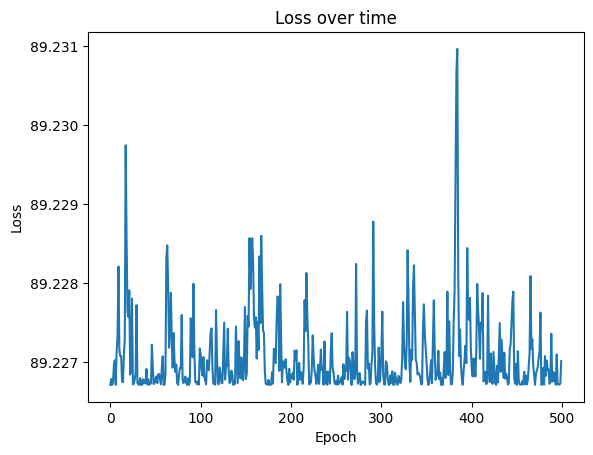

Validation Losses


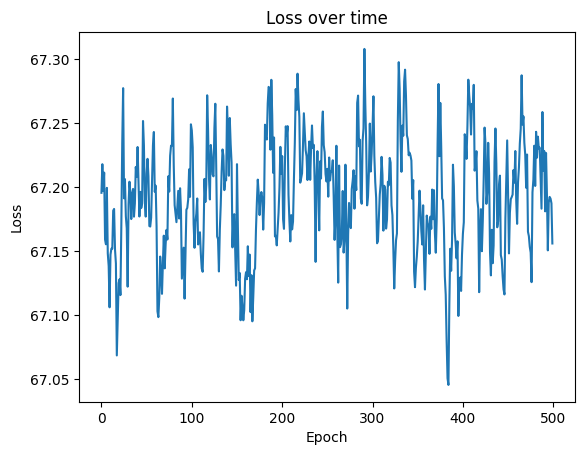

Epoch 0: Training Loss 89.22678377892164, Validation Loss 67.17724535371575
Epoch 1: Training Loss 89.2269446197051, Validation Loss 67.23388857436821
Epoch 2: Training Loss 89.22671517604702, Validation Loss 67.19397610181775
Epoch 3: Training Loss 89.22677802258326, Validation Loss 67.17807729405949
Epoch 4: Training Loss 89.22712798393776, Validation Loss 67.14895301829687
Epoch 5: Training Loss 89.22672990971272, Validation Loss 67.18752509480936
Epoch 6: Training Loss 89.22676482930255, Validation Loss 67.21449446057483
Epoch 7: Training Loss 89.22672149512618, Validation Loss 67.19041672676344
Epoch 8: Training Loss 89.22689735522236, Validation Loss 67.16498562870302
Epoch 9: Training Loss 89.22743453019153, Validation Loss 67.13372625664056
Epoch 10: Training Loss 89.2285541889533, Validation Loss 67.09644304946946
Epoch 11: Training Loss 89.22686192375632, Validation Loss 67.16824140872477
Epoch 12: Training Loss 89.22672779650493, Validation Loss 67.18816410674121
Epoch 13: T

Epoch 108: Training Loss 89.227413903856, Validation Loss 67.26129894777804
Epoch 109: Training Loss 89.2268129427704, Validation Loss 67.22125047857351
Epoch 110: Training Loss 89.22678289310967, Validation Loss 67.21729698671807
Epoch 111: Training Loss 89.22678725491046, Validation Loss 67.17675948916839
Epoch 112: Training Loss 89.22674052548538, Validation Loss 67.1848034283066
Epoch 113: Training Loss 89.22675740011023, Validation Loss 67.18141619409126
Epoch 114: Training Loss 89.22815218111505, Validation Loss 67.10794006886987
Epoch 115: Training Loss 89.22809363664278, Validation Loss 67.10974714400216
Epoch 116: Training Loss 89.22755420245602, Validation Loss 67.1287193209335
Epoch 117: Training Loss 89.22766236338974, Validation Loss 67.12450011887061
Epoch 118: Training Loss 89.22729463802648, Validation Loss 67.14015382460597
Epoch 119: Training Loss 89.2271389498863, Validation Loss 67.14832395141462
Epoch 120: Training Loss 89.22673304328924, Validation Loss 67.2079199

Epoch 229: Training Loss 89.22671445092277, Validation Loss 67.19468217584563
Epoch 230: Training Loss 89.22703365775692, Validation Loss 67.15475727093231
Epoch 231: Training Loss 89.22758658696874, Validation Loss 67.12742826633097
Epoch 232: Training Loss 89.22754272389125, Validation Loss 67.12918303097283
Epoch 233: Training Loss 89.22709331143251, Validation Loss 67.15099976986278
Epoch 234: Training Loss 89.22691429378737, Validation Loss 67.16354177856597
Epoch 235: Training Loss 89.22722117984225, Validation Loss 67.14384831188403
Epoch 236: Training Loss 89.2272697626191, Validation Loss 67.14137672854372
Epoch 237: Training Loss 89.22748768127009, Validation Loss 67.13145374162985
Epoch 238: Training Loss 89.22784409401073, Validation Loss 67.11793339600263
Epoch 239: Training Loss 89.2267850589279, Validation Loss 67.17706506373298
Epoch 240: Training Loss 89.2272530334416, Validation Loss 67.1422149039138
Epoch 241: Training Loss 89.22873142779827, Validation Loss 67.09179

Epoch 335: Training Loss 89.22687837035633, Validation Loss 67.16668629096102
Epoch 336: Training Loss 89.22758577054427, Validation Loss 67.12746050974768
Epoch 337: Training Loss 89.22785645761556, Validation Loss 67.1175070939241
Epoch 338: Training Loss 89.22800485259812, Validation Loss 67.11256481519233
Epoch 339: Training Loss 89.22724613494385, Validation Loss 67.14256438979498
Epoch 340: Training Loss 89.22751205941897, Validation Loss 67.13043818459552
Epoch 341: Training Loss 89.22679554505551, Validation Loss 67.1756452081298
Epoch 342: Training Loss 89.22687657268874, Validation Loss 67.16685233809673
Epoch 343: Training Loss 89.22683638729293, Validation Loss 67.22393530566113
Epoch 344: Training Loss 89.22695342359762, Validation Loss 67.23458341230075
Epoch 345: Training Loss 89.22707599407995, Validation Loss 67.24319666084315
Epoch 346: Training Loss 89.22685442991633, Validation Loss 67.22583235661257
Epoch 347: Training Loss 89.2273281860176, Validation Loss 67.2572

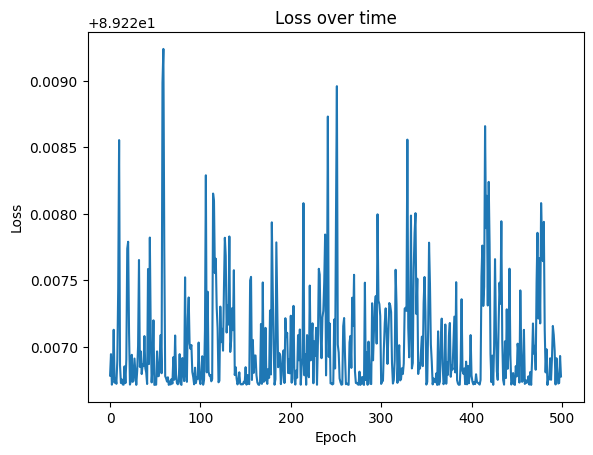

Validation Losses


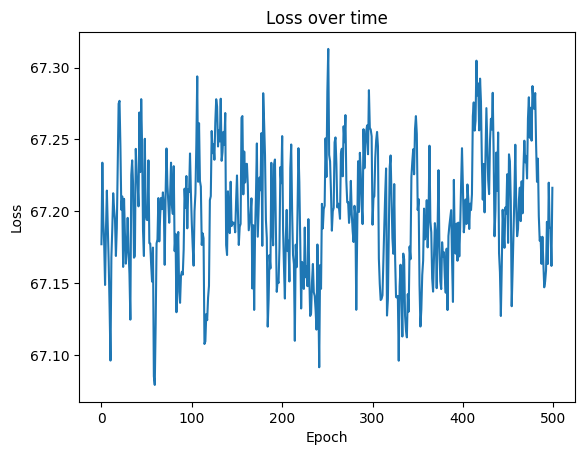

Epoch 0: Training Loss 10915.13301704787, Validation Loss 11458.930986943127
Epoch 1: Training Loss 2333.0399634676896, Validation Loss 2197.6690730004957
Epoch 2: Training Loss 1179.2913845430999, Validation Loss 1078.262950884165
Epoch 3: Training Loss 618.789941164324, Validation Loss 541.698199900746
Epoch 4: Training Loss 346.49329545792415, Validation Loss 286.08542879390995
Epoch 5: Training Loss 214.2091343039437, Validation Loss 165.4299282358255
Epoch 6: Training Loss 149.9442982578896, Validation Loss 109.27026862511096
Epoch 7: Training Loss 118.72386252319221, Validation Loss 83.69914086584512
Epoch 8: Training Loss 103.55669385935457, Validation Loss 72.4695398608833
Epoch 9: Training Loss 96.18834681794426, Validation Loss 67.84567747770947
Epoch 10: Training Loss 92.60873751010377, Validation Loss 66.17897397665979
Epoch 11: Training Loss 90.86973109187109, Validation Loss 65.7732629057603
Epoch 12: Training Loss 90.0249061228359, Validation Loss 65.85774479381632
Epoch

Epoch 326: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 327: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 328: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 329: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 330: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 331: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 332: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 333: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 334: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 335: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 336: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 337: Training Loss 89.2267132851899, Validation Loss 67.19726442941322
Epoch 338: Training Loss 89.2267132851899, Validation Loss 67.19726442941322

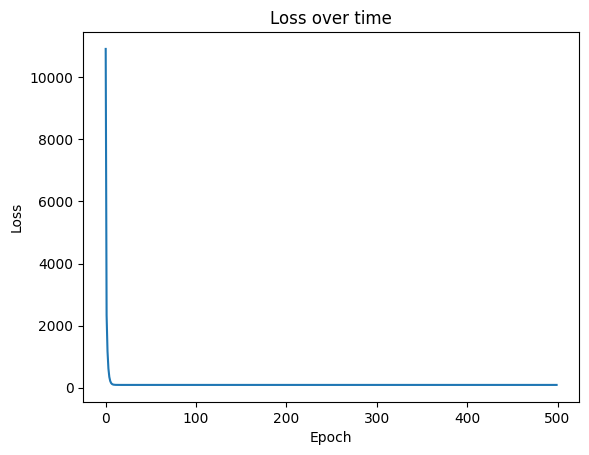

Validation Losses


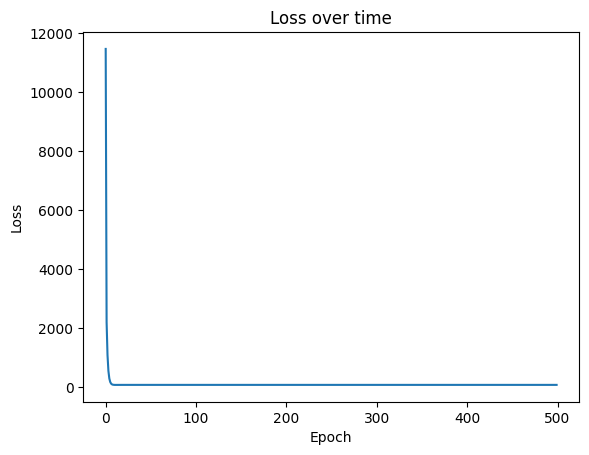

Epoch 0: Training Loss 89.2272157441151, Validation Loss 67.14413221244644
Epoch 1: Training Loss 89.22687278191596, Validation Loss 67.16720554013665
Epoch 2: Training Loss 89.22695507597632, Validation Loss 67.16030002570814
Epoch 3: Training Loss 89.22674542185706, Validation Loss 67.1837323157735
Epoch 4: Training Loss 89.22740904889017, Validation Loss 67.13484611231803
Epoch 5: Training Loss 89.22754734204206, Validation Loss 67.12899607445257
Epoch 6: Training Loss 89.22672729490675, Validation Loss 67.18832252219589
Epoch 7: Training Loss 89.22699062619176, Validation Loss 67.15769414757769
Epoch 8: Training Loss 89.2267961815977, Validation Loss 67.17556204142687
Epoch 9: Training Loss 89.22677957027827, Validation Loss 67.21681135795974
Epoch 10: Training Loss 89.22676371286853, Validation Loss 67.18032342960987
Epoch 11: Training Loss 89.22673613087044, Validation Loss 67.2087238881601
Epoch 12: Training Loss 89.22679144541324, Validation Loss 67.21849638378937
Epoch 13: Tra

Epoch 108: Training Loss 89.22697203973705, Validation Loss 67.23601242729252
Epoch 109: Training Loss 89.22673788503768, Validation Loss 67.20915659340872
Epoch 110: Training Loss 89.22672035133347, Validation Loss 67.20363192745174
Epoch 111: Training Loss 89.22674546218227, Validation Loss 67.21086936427926
Epoch 112: Training Loss 89.22689660898632, Validation Loss 67.22984475346098
Epoch 113: Training Loss 89.2267228530366, Validation Loss 67.20467520308969
Epoch 114: Training Loss 89.2267809900025, Validation Loss 67.17764397340592
Epoch 115: Training Loss 89.22709218007819, Validation Loss 67.24421852673305
Epoch 116: Training Loss 89.22671575781342, Validation Loss 67.19350442051494
Epoch 117: Training Loss 89.22682127436335, Validation Loss 67.22223724814303
Epoch 118: Training Loss 89.2267296101394, Validation Loss 67.20694841286634
Epoch 119: Training Loss 89.22696251867714, Validation Loss 67.15973917589685
Epoch 120: Training Loss 89.22854959972227, Validation Loss 67.0965

Epoch 215: Training Loss 89.22759972093634, Validation Loss 67.12691166928781
Epoch 216: Training Loss 89.22734573882116, Validation Loss 67.13772276643734
Epoch 217: Training Loss 89.22731143028712, Validation Loss 67.13934333794656
Epoch 218: Training Loss 89.22673651575366, Validation Loss 67.20882020749637
Epoch 219: Training Loss 89.22671574903072, Validation Loss 67.19351109980339
Epoch 220: Training Loss 89.22720742816298, Validation Loss 67.14456958895231
Epoch 221: Training Loss 89.22673722694151, Validation Loss 67.18558062391483
Epoch 222: Training Loss 89.22712406881963, Validation Loss 67.24617076895711
Epoch 223: Training Loss 89.22671740803997, Validation Loss 67.19241014241969
Epoch 224: Training Loss 89.22671766416669, Validation Loss 67.20227585574885
Epoch 225: Training Loss 89.22679391549704, Validation Loss 67.17585960571327
Epoch 226: Training Loss 89.22674021243635, Validation Loss 67.18487508086697
Epoch 227: Training Loss 89.22672228187211, Validation Loss 67.1

Epoch 322: Training Loss 89.22677806494019, Validation Loss 67.21658737901782
Epoch 323: Training Loss 89.2267628654523, Validation Loss 67.18046595401987
Epoch 324: Training Loss 89.22671938037762, Validation Loss 67.20317782315585
Epoch 325: Training Loss 89.22671820883481, Validation Loss 67.20257867107996
Epoch 326: Training Loss 89.22671347448664, Validation Loss 67.1962235798477
Epoch 327: Training Loss 89.22672320424637, Validation Loss 67.20481016920914
Epoch 328: Training Loss 89.2267171678878, Validation Loss 67.19255352401525
Epoch 329: Training Loss 89.22671609333034, Validation Loss 67.19325760302237
Epoch 330: Training Loss 89.2267444452017, Validation Loss 67.18393904279026
Epoch 331: Training Loss 89.22680344992966, Validation Loss 67.22007487758539
Epoch 332: Training Loss 89.2267450024786, Validation Loss 67.18382069270712
Epoch 333: Training Loss 89.22689079280728, Validation Loss 67.1655629968054
Epoch 334: Training Loss 89.22711602765057, Validation Loss 67.1496486

Epoch 432: Training Loss 89.22686124448278, Validation Loss 67.22651731485313
Epoch 433: Training Loss 89.22695425490346, Validation Loss 67.23464836752153
Epoch 434: Training Loss 89.22672517508045, Validation Loss 67.20552689600459
Epoch 435: Training Loss 89.22672024753962, Validation Loss 67.20358493697451
Epoch 436: Training Loss 89.22671727451552, Validation Loss 67.19248932971185
Epoch 437: Training Loss 89.22738193590757, Validation Loss 67.13606095463639
Epoch 438: Training Loss 89.22712176399288, Validation Loss 67.14931359322487
Epoch 439: Training Loss 89.22757961804253, Validation Loss 67.12770399238413
Epoch 440: Training Loss 89.22844149184664, Validation Loss 67.09952238482886
Epoch 441: Training Loss 89.22708076933529, Validation Loss 67.15176339840671
Epoch 442: Training Loss 89.22697805567527, Validation Loss 67.15859509776064
Epoch 443: Training Loss 89.22683060701982, Validation Loss 67.17146474745601
Epoch 444: Training Loss 89.22895750111991, Validation Loss 67.0

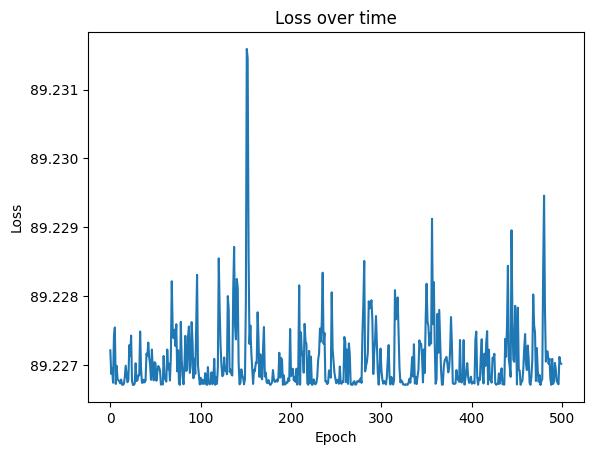

Validation Losses


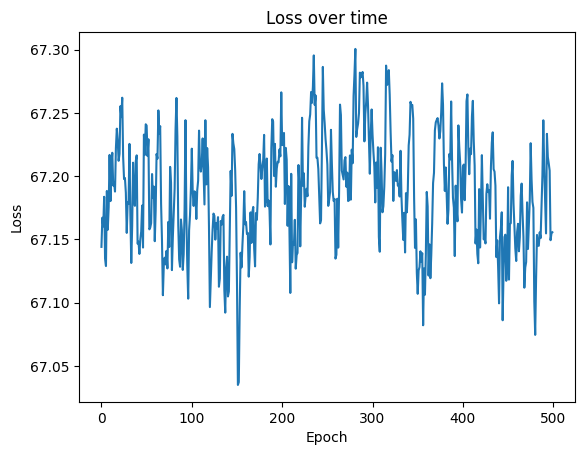

Epoch 0: Training Loss 89.22701593410511, Validation Loss 67.15594105350715
Epoch 1: Training Loss 89.22683322540937, Validation Loss 67.22358898549247
Epoch 2: Training Loss 89.22711418168018, Validation Loss 67.24557370805536
Epoch 3: Training Loss 89.22671535535835, Validation Loss 67.19382380718476
Epoch 4: Training Loss 89.22691143745774, Validation Loss 67.16378081201162
Epoch 5: Training Loss 89.22679363100896, Validation Loss 67.17589725830511
Epoch 6: Training Loss 89.22718357714865, Validation Loss 67.14584526095757
Epoch 7: Training Loss 89.2277593604063, Validation Loss 67.12092193235533
Epoch 8: Training Loss 89.22757659458105, Validation Loss 67.12782396941279
Epoch 9: Training Loss 89.22699774516896, Validation Loss 67.15719308903076
Epoch 10: Training Loss 89.22678831587469, Validation Loss 67.17661349162856
Epoch 11: Training Loss 89.22684687364122, Validation Loss 67.2250534109402
Epoch 12: Training Loss 89.22740176320926, Validation Loss 67.26073566944005
Epoch 13: T

Epoch 117: Training Loss 89.22674645957312, Validation Loss 67.21107911386606
Epoch 118: Training Loss 89.22735647888683, Validation Loss 67.25859051482387
Epoch 119: Training Loss 89.22729983397, Validation Loss 67.25580017835124
Epoch 120: Training Loss 89.22677906963968, Validation Loss 67.21673715109954
Epoch 121: Training Loss 89.22755333381615, Validation Loss 67.2674546577851
Epoch 122: Training Loss 89.22771987324167, Validation Loss 67.27418491049627
Epoch 123: Training Loss 89.22730427274766, Validation Loss 67.2560234725891
Epoch 124: Training Loss 89.22682579979646, Validation Loss 67.22275742400178
Epoch 125: Training Loss 89.2267483548414, Validation Loss 67.21146921367259
Epoch 126: Training Loss 89.22674040220288, Validation Loss 67.1848315963402
Epoch 127: Training Loss 89.22671609556791, Validation Loss 67.19325600810677
Epoch 128: Training Loss 89.22726452581094, Validation Loss 67.25399363264637
Epoch 129: Training Loss 89.2267897238518, Validation Loss 67.218260397

Epoch 224: Training Loss 89.22675844081826, Validation Loss 67.21338829951601
Epoch 225: Training Loss 89.22690308861449, Validation Loss 67.23041880170271
Epoch 226: Training Loss 89.22681335280936, Validation Loss 67.22129997819103
Epoch 227: Training Loss 89.22671544475405, Validation Loss 67.20078282834817
Epoch 228: Training Loss 89.22671843046243, Validation Loss 67.19184207797225
Epoch 229: Training Loss 89.22689488181715, Validation Loss 67.16520199970773
Epoch 230: Training Loss 89.22784245795387, Validation Loss 67.11798998720525
Epoch 231: Training Loss 89.22746655908566, Validation Loss 67.13234697439043
Epoch 232: Training Loss 89.22674769036136, Validation Loss 67.18326400184397
Epoch 233: Training Loss 89.22672594081544, Validation Loss 67.20578919422783
Epoch 234: Training Loss 89.22671426590618, Validation Loss 67.19489585361674
Epoch 235: Training Loss 89.22680361920486, Validation Loss 67.22009636437825
Epoch 236: Training Loss 89.22705419413774, Validation Loss 67.1

Epoch 346: Training Loss 89.22674885065811, Validation Loss 67.18303046572385
Epoch 347: Training Loss 89.22672255865817, Validation Loss 67.20456016099995
Epoch 348: Training Loss 89.22673730862441, Validation Loss 67.20901615495946
Epoch 349: Training Loss 89.22680474891445, Validation Loss 67.17447253174761
Epoch 350: Training Loss 89.22677014040444, Validation Loss 67.17927945699572
Epoch 351: Training Loss 89.22677429694565, Validation Loss 67.17863574938028
Epoch 352: Training Loss 89.22715368079206, Validation Loss 67.14749174460364
Epoch 353: Training Loss 89.2270515027316, Validation Loss 67.15359851661736
Epoch 354: Training Loss 89.22683485873279, Validation Loss 67.17100356566147
Epoch 355: Training Loss 89.2267798748944, Validation Loss 67.21685637336199
Epoch 356: Training Loss 89.22673771694718, Validation Loss 67.18546191199155
Epoch 357: Training Loss 89.22757454143697, Validation Loss 67.12790556512772
Epoch 358: Training Loss 89.22771224665975, Validation Loss 67.122

Epoch 491: Training Loss 89.22696168603726, Validation Loss 67.159801494596
Epoch 492: Training Loss 89.2267142442567, Validation Loss 67.19960864484064
Epoch 493: Training Loss 89.22671340939604, Validation Loss 67.19810782413516
Epoch 494: Training Loss 89.22674736194416, Validation Loss 67.21126619300104
Epoch 495: Training Loss 89.22674325251617, Validation Loss 67.1841959627371
Epoch 496: Training Loss 89.22676356941801, Validation Loss 67.1803474709443
Epoch 497: Training Loss 89.22672079725379, Validation Loss 67.19071388708937
Epoch 498: Training Loss 89.22731369380632, Validation Loss 67.25649469519318
Epoch 499: Training Loss 89.22677281890452, Validation Loss 67.21578588329434

Train Losses


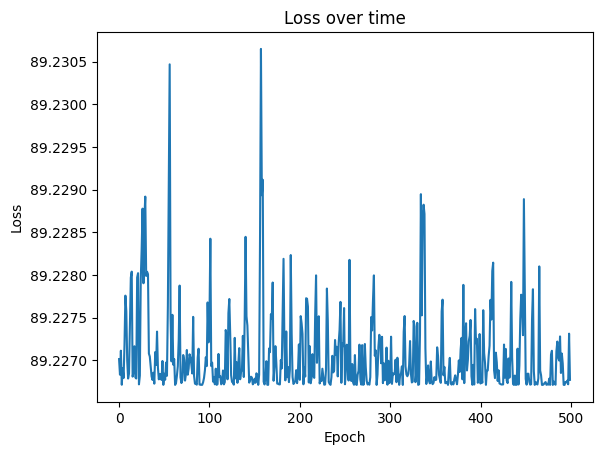

Validation Losses


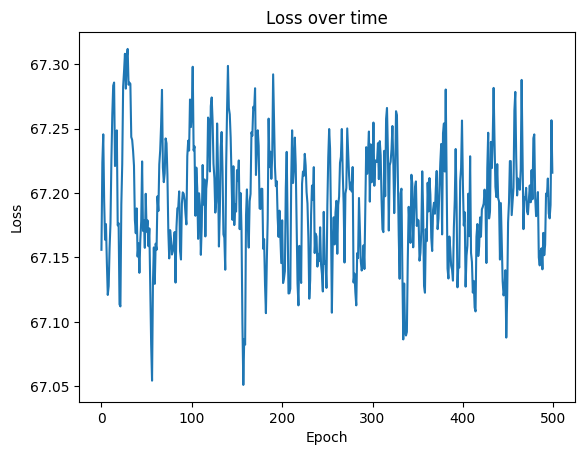

In [288]:
for lr in learning_rates_multi:
    for epochs in num_epochs_multi:
        for activation in activations_multi:
            for layers in hidden_layers_multi:
                    wandb.init(project="Multilayer Perceptron Regression")
                    
                    model = MLPRegression(num, layers, learning_rate=lr, activation=activation, output_dim=1)
                    model.train_gd(X_train_normalized, y, X_val_normalized, y_val, epochs)
                    model.train_sgd(X_train_normalized, y, X_val_normalized, y_val, epochs)
                    model.train_mini_batch(X_train_normalized, y, X_val_normalized, y_val, epochs)
                    
                    wandb.finish()

In [292]:
mlp = MLPRegression(input_dim=num, hidden_layers=[3], learning_rate=0.001, activation="relu", output_dim=1)

Epoch 0: Training Loss 77.83276445371898, Validation Loss 54.479599829577694
Epoch 1: Training Loss 54.50087363075713, Validation Loss 38.76320919084509
Epoch 2: Training Loss 59.65574191596786, Validation Loss 44.565320670953234
Epoch 3: Training Loss 108.32353183384767, Validation Loss 91.61783609434549
Epoch 4: Training Loss 40.1220096891378, Validation Loss 30.187012101988284
Epoch 5: Training Loss 38.97203894436432, Validation Loss 31.148827750479647
Epoch 6: Training Loss 36.97417589406923, Validation Loss 30.592601895404048
Epoch 7: Training Loss 30.124891342836676, Validation Loss 24.75560155591249
Epoch 8: Training Loss 33.11964568012801, Validation Loss 27.783053412153283
Epoch 9: Training Loss 30.653739747198927, Validation Loss 25.773223303492298
Epoch 10: Training Loss 29.305782255207426, Validation Loss 24.504944887792384
Epoch 11: Training Loss 27.233981102552494, Validation Loss 21.97572557832239
Epoch 12: Training Loss 28.981108786966427, Validation Loss 24.47187870038

Epoch 243: Training Loss 14.021800780337168, Validation Loss 14.687041118524128
Epoch 244: Training Loss 13.431545591452146, Validation Loss 16.2036146883321
Epoch 245: Training Loss 13.802898425197577, Validation Loss 15.755323761231065
Epoch 246: Training Loss 14.965881814467553, Validation Loss 19.85771660952366
Epoch 247: Training Loss 14.860445312704764, Validation Loss 17.536846145941965
Epoch 248: Training Loss 13.568583966707019, Validation Loss 15.764795695041238
Epoch 249: Training Loss 16.341319603249964, Validation Loss 15.257224254093535
Epoch 250: Training Loss 14.302292326921181, Validation Loss 16.544260351392314
Epoch 251: Training Loss 14.656049444531254, Validation Loss 19.7207143814039
Epoch 252: Training Loss 14.403776253099437, Validation Loss 16.16647122319618
Epoch 253: Training Loss 16.92713148658262, Validation Loss 14.842500467801619
Epoch 254: Training Loss 14.341696382462972, Validation Loss 14.419916625437022
Epoch 255: Training Loss 14.397794563741709, Va

Epoch 365: Training Loss 19.79354220944997, Validation Loss 19.844260995192915
Epoch 366: Training Loss 13.270973195660943, Validation Loss 16.63186408914556
Epoch 367: Training Loss 16.359963074014694, Validation Loss 20.478936213461033
Epoch 368: Training Loss 15.065024792570217, Validation Loss 16.56890651110382
Epoch 369: Training Loss 13.476917083988717, Validation Loss 16.109789309486377
Epoch 370: Training Loss 13.45951776024346, Validation Loss 17.08919910791217
Epoch 371: Training Loss 14.326954374353743, Validation Loss 21.26302443518741
Epoch 372: Training Loss 14.16194499091512, Validation Loss 20.92209120020536
Epoch 373: Training Loss 13.25514897691862, Validation Loss 18.072952458501515
Epoch 374: Training Loss 14.577750110507749, Validation Loss 15.738964818357058
Epoch 375: Training Loss 12.947267071319601, Validation Loss 18.98608914304113
Epoch 376: Training Loss 16.711853747400312, Validation Loss 15.653467391173209
Epoch 377: Training Loss 13.785605376071661, Valid

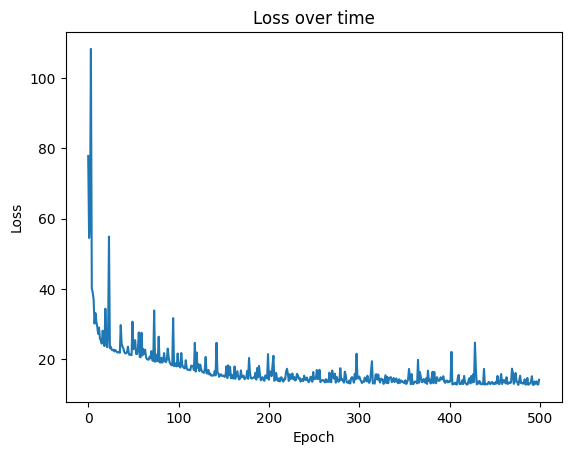

Validation Losses


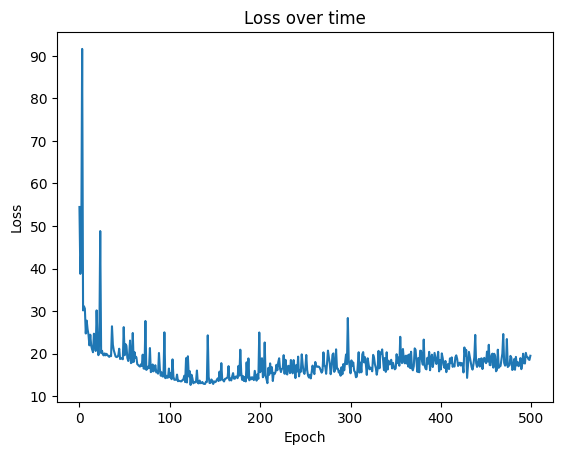

In [293]:
mlp.train_mini_batch(X_train_normalized, y, X_val_normalized, y_val, epochs=500)

In [294]:
y_pred = mlp.predict(X_val_normalized)

In [295]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R² score): {r2}')

Mean Absolute Error (MAE): 2.98752522687801
Mean Squared Error (MSE): 19.525374199151482
R-squared (R² score): 0.7031082192731379


In [296]:
y_pred = mlp.predict(X_test_normalized)

In [297]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R² score): {r2}')

Mean Absolute Error (MAE): 3.0407715700152225
Mean Squared Error (MSE): 19.263904161139454
R-squared (R² score): 0.7756611977838943
